In [3]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import os
for file in os.listdir("../data"):
    print(file)

Using TensorFlow backend.


popcorn


In [36]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [37]:
usecols = ['sentiment','review']
train_data = pd.read_csv(
    filepath_or_buffer='../data/popcorn/labeledTrainData.tsv',
    usecols=usecols, sep='\t')
additional_data = pd.read_csv(
    filepath_or_buffer='../data/popcorn/imdb_master.csv',encoding="latin-1",usecols=['label','review'])
unlabeled_data = pd.read_csv(
    filepath_or_buffer="../data/popcorn/unlabeledTrainData.tsv", 
    error_bad_lines=False,
    sep='\t')
submission_data = pd.read_csv(
    filepath_or_buffer="../data/popcorn/testData.tsv",
    sep='\t')


b'Skipping line 43043: expected 2 fields, saw 3\n'


In [38]:
additional_data.rename(columns={"label": "sentiment"},inplace=True)

In [39]:
datasets = [train_data, additional_data, submission_data, unlabeled_data]
titles = ['Train data', 'Additional data', 'Unlabeled train data', 'Submission data']
for dataset, title in zip(datasets,titles):
    print(title)
    dataset.info()
    display(dataset.head())

Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


sentiment                                             review
0          1  With all this stuff going down at the moment w...
1          1  \The Classic War of the Worlds\" by Timothy Hi...
2          0  The film starts with a manager (Nicholas Bell)...
3          0  It must be assumed that those who praised this...
4          1  Superbly trashy and wondrously unpretentious 8...

Additional data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
review       100000 non-null object
sentiment    100000 non-null object
dtypes: object(2)
memory usage: 1.5+ MB


review sentiment
0  Once again Mr. Costner has dragged out a movie...       neg
1  This is an example of why the majority of acti...       neg
2  First of all I hate those moronic rappers, who...       neg
3  Not even the Beatles could write songs everyon...       neg
4  Brass pictures (movies is not a fitting word f...       neg

Unlabeled train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
id        25000 non-null object
review    25000 non-null object
dtypes: object(2)
memory usage: 390.8+ KB


id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...

Submission data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 2 columns):
id        49998 non-null object
review    49998 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


id                                             review
0   9999_0  Watching Time Chasers, it obvious that it was ...
1  45057_0  I saw this film about 20 years ago and remembe...
2  15561_0  Minor Spoilers<br /><br />In New York, Joan Ba...
3   7161_0  I went to see this film with a great deal of e...
4  43971_0  Yes, I agree with everyone on this site this m...

In [40]:
all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)
print('Total number of reviews:', len(all_reviews))


Total number of reviews: 199998


In [41]:
train_data.sentiment.unique()

array([1, 0])

In [42]:
additional_data.sentiment.unique()

array(['neg', 'pos', 'unsup'], dtype=object)

In [43]:
cleanup_nums = {"sentiment":     {"neg": 0, "pos": 1, "unsup": -1}}

In [44]:
additional_data.replace(cleanup_nums, inplace=True)

In [45]:
additional_data.sentiment.unique()

array([ 0,  1, -1])

In [46]:
train_data = pd.concat((train_data, additional_data[additional_data.sentiment != -1]),
                       axis=0, ignore_index=True)
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
review       75000 non-null object
sentiment    75000 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


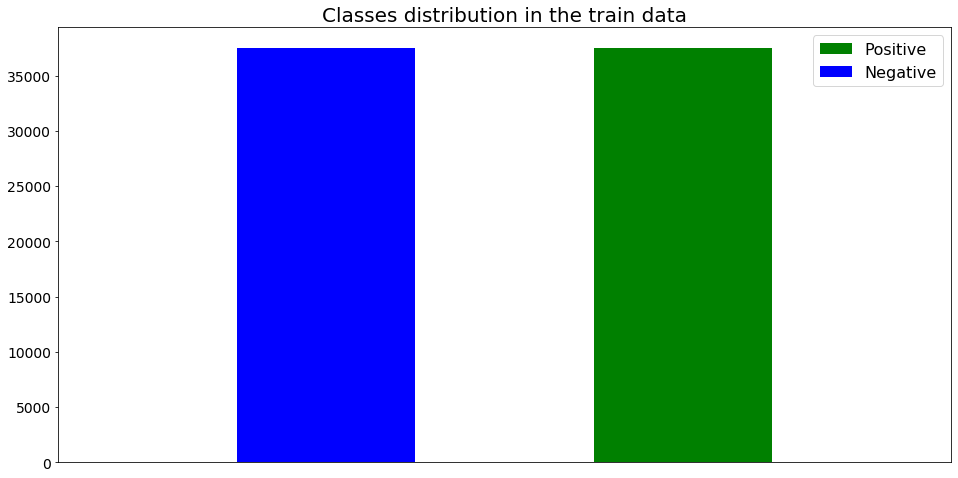

In [47]:
plt.hist(train_data[train_data.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(train_data[train_data.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()


In [60]:
def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "html.parser").get_text()
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    print("here")
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

In [61]:
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


In [63]:
all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0


here
hereessing...      2/199998
hereessing...      3/199998
hereessing...      4/199998
hereessing...      5/199998
hereessing...      6/199998
hereessing...      7/199998
hereessing...      8/199998
hereessing...      9/199998
hereessing...     10/199998
hereessing...     11/199998
hereessing...     12/199998
hereessing...     13/199998
hereessing...     14/199998
hereessing...     15/199998
hereessing...     16/199998
hereessing...     17/199998
hereessing...     18/199998
hereessing...     19/199998
hereessing...     20/199998
hereessing...     21/199998
hereessing...     22/199998
hereessing...     23/199998
hereessing...     24/199998
hereessing...     25/199998
hereessing...     26/199998
hereessing...     27/199998
hereessing...     28/199998
hereessing...     29/199998
hereessing...     30/199998
hereessing...     31/199998
hereessing...     32/199998
hereessing...     33/199998
hereessing...     34/199998
hereessing...     35/199998
hereessing...     36/199998
hereessing...  

hereessing...    320/199998
hereessing...    321/199998
hereessing...    322/199998
hereessing...    323/199998
hereessing...    324/199998
hereessing...    325/199998
hereessing...    326/199998
hereessing...    327/199998
hereessing...    328/199998
hereessing...    329/199998
hereessing...    330/199998
hereessing...    331/199998
hereessing...    332/199998
hereessing...    333/199998
hereessing...    334/199998
hereessing...    335/199998
hereessing...    336/199998
hereessing...    337/199998
hereessing...    338/199998
hereessing...    339/199998
hereessing...    340/199998
hereessing...    341/199998
hereessing...    342/199998
hereessing...    343/199998
hereessing...    344/199998
hereessing...    345/199998
hereessing...    346/199998
hereessing...    347/199998
hereessing...    348/199998
hereessing...    349/199998
hereessing...    350/199998
hereessing...    351/199998
hereessing...    352/199998
hereessing...    353/199998
hereessing...    354/199998
hereessing...    355

hereessing...    640/199998
hereessing...    641/199998
hereessing...    642/199998
hereessing...    643/199998
hereessing...    644/199998
hereessing...    645/199998
hereessing...    646/199998
hereessing...    647/199998
hereessing...    648/199998
hereessing...    649/199998
hereessing...    650/199998
hereessing...    651/199998
hereessing...    652/199998
hereessing...    653/199998
hereessing...    654/199998
hereessing...    655/199998
hereessing...    656/199998
hereessing...    657/199998
hereessing...    658/199998
hereessing...    659/199998
hereessing...    660/199998
hereessing...    661/199998
hereessing...    662/199998
hereessing...    663/199998
hereessing...    664/199998
hereessing...    665/199998
hereessing...    666/199998
hereessing...    667/199998
hereessing...    668/199998
hereessing...    669/199998
hereessing...    670/199998
hereessing...    671/199998
hereessing...    672/199998
hereessing...    673/199998
hereessing...    674/199998
hereessing...    675

hereessing...    936/199998
hereessing...    937/199998
hereessing...    938/199998
hereessing...    939/199998
hereessing...    940/199998
hereessing...    941/199998
hereessing...    942/199998
hereessing...    943/199998
hereessing...    944/199998
hereessing...    945/199998
hereessing...    946/199998
hereessing...    947/199998
hereessing...    948/199998
hereessing...    949/199998
hereessing...    950/199998
hereessing...    951/199998
hereessing...    952/199998
hereessing...    953/199998
hereessing...    954/199998
hereessing...    955/199998
hereessing...    956/199998
hereessing...    957/199998
hereessing...    958/199998
hereessing...    959/199998
hereessing...    960/199998
hereessing...    961/199998
hereessing...    962/199998
hereessing...    963/199998
hereessing...    964/199998
hereessing...    965/199998
hereessing...    966/199998
hereessing...    967/199998
hereessing...    968/199998
hereessing...    969/199998
hereessing...    970/199998
hereessing...    971

hereessing...   1271/199998
hereessing...   1272/199998
hereessing...   1273/199998
hereessing...   1274/199998
hereessing...   1275/199998
hereessing...   1276/199998
hereessing...   1277/199998
hereessing...   1278/199998
hereessing...   1279/199998
hereessing...   1280/199998
hereessing...   1281/199998
hereessing...   1282/199998
hereessing...   1283/199998
hereessing...   1284/199998
hereessing...   1285/199998
hereessing...   1286/199998
hereessing...   1287/199998
hereessing...   1288/199998
hereessing...   1289/199998
hereessing...   1290/199998
hereessing...   1291/199998
hereessing...   1292/199998
hereessing...   1293/199998
hereessing...   1294/199998
hereessing...   1295/199998
hereessing...   1296/199998
hereessing...   1297/199998
hereessing...   1298/199998
hereessing...   1299/199998
hereessing...   1300/199998
hereessing...   1301/199998
hereessing...   1302/199998
hereessing...   1303/199998
hereessing...   1304/199998
hereessing...   1305/199998
hereessing...   1306

hereessing...   1583/199998
hereessing...   1584/199998
hereessing...   1585/199998
hereessing...   1586/199998
hereessing...   1587/199998
hereessing...   1588/199998
hereessing...   1589/199998
hereessing...   1590/199998
hereessing...   1591/199998
hereessing...   1592/199998
hereessing...   1593/199998
hereessing...   1594/199998
hereessing...   1595/199998
hereessing...   1596/199998
hereessing...   1597/199998
hereessing...   1598/199998
hereessing...   1599/199998
hereessing...   1600/199998
hereessing...   1601/199998
hereessing...   1602/199998
hereessing...   1603/199998
hereessing...   1604/199998
hereessing...   1605/199998
hereessing...   1606/199998
hereessing...   1607/199998
hereessing...   1608/199998
hereessing...   1609/199998
hereessing...   1610/199998
hereessing...   1611/199998
hereessing...   1612/199998
hereessing...   1613/199998
hereessing...   1614/199998
hereessing...   1615/199998
hereessing...   1616/199998
hereessing...   1617/199998
hereessing...   1618

hereessing...   1891/199998
hereessing...   1892/199998
hereessing...   1893/199998
hereessing...   1894/199998
hereessing...   1895/199998
hereessing...   1896/199998
hereessing...   1897/199998
hereessing...   1898/199998
hereessing...   1899/199998
hereessing...   1900/199998
hereessing...   1901/199998
hereessing...   1902/199998
hereessing...   1903/199998
hereessing...   1904/199998
hereessing...   1905/199998
hereessing...   1906/199998
hereessing...   1907/199998
hereessing...   1908/199998
hereessing...   1909/199998
hereessing...   1910/199998
hereessing...   1911/199998
hereessing...   1912/199998
hereessing...   1913/199998
hereessing...   1914/199998
hereessing...   1915/199998
hereessing...   1916/199998
hereessing...   1917/199998
hereessing...   1918/199998
hereessing...   1919/199998
hereessing...   1920/199998
hereessing...   1921/199998
hereessing...   1922/199998
hereessing...   1923/199998
hereessing...   1924/199998
hereessing...   1925/199998
hereessing...   1926

hereessing...   2209/199998
hereessing...   2210/199998
hereessing...   2211/199998
hereessing...   2212/199998
hereessing...   2213/199998
hereessing...   2214/199998
hereessing...   2215/199998
hereessing...   2216/199998
hereessing...   2217/199998
hereessing...   2218/199998
hereessing...   2219/199998
hereessing...   2220/199998
hereessing...   2221/199998
hereessing...   2222/199998
hereessing...   2223/199998
hereessing...   2224/199998
hereessing...   2225/199998
hereessing...   2226/199998
hereessing...   2227/199998
hereessing...   2228/199998
hereessing...   2229/199998
hereessing...   2230/199998
hereessing...   2231/199998
hereessing...   2232/199998
hereessing...   2233/199998
hereessing...   2234/199998
hereessing...   2235/199998
hereessing...   2236/199998
hereessing...   2237/199998
hereessing...   2238/199998
hereessing...   2239/199998
hereessing...   2240/199998
hereessing...   2241/199998
hereessing...   2242/199998
hereessing...   2243/199998
hereessing...   2244

hereessing...   2522/199998
hereessing...   2523/199998
hereessing...   2524/199998
hereessing...   2525/199998
hereessing...   2526/199998
hereessing...   2527/199998
hereessing...   2528/199998
hereessing...   2529/199998
hereessing...   2530/199998
hereessing...   2531/199998
hereessing...   2532/199998
hereessing...   2533/199998
hereessing...   2534/199998
hereessing...   2535/199998
hereessing...   2536/199998
hereessing...   2537/199998
hereessing...   2538/199998
hereessing...   2539/199998
hereessing...   2540/199998
hereessing...   2541/199998
hereessing...   2542/199998
hereessing...   2543/199998
hereessing...   2544/199998
hereessing...   2545/199998
hereessing...   2546/199998
hereessing...   2547/199998
hereessing...   2548/199998
hereessing...   2549/199998
hereessing...   2550/199998
hereessing...   2551/199998
hereessing...   2552/199998
hereessing...   2553/199998
hereessing...   2554/199998
hereessing...   2555/199998
hereessing...   2556/199998
hereessing...   2557

hereessing...   2816/199998
hereessing...   2817/199998
hereessing...   2818/199998
hereessing...   2819/199998
hereessing...   2820/199998
hereessing...   2821/199998
hereessing...   2822/199998
hereessing...   2823/199998
hereessing...   2824/199998
hereessing...   2825/199998
hereessing...   2826/199998
hereessing...   2827/199998
hereessing...   2828/199998
hereessing...   2829/199998
hereessing...   2830/199998
hereessing...   2831/199998
hereessing...   2832/199998
hereessing...   2833/199998
hereessing...   2834/199998
hereessing...   2835/199998
hereessing...   2836/199998
hereessing...   2837/199998
hereessing...   2838/199998
hereessing...   2839/199998
hereessing...   2840/199998
hereessing...   2841/199998
hereessing...   2842/199998
hereessing...   2843/199998
hereessing...   2844/199998
hereessing...   2845/199998
hereessing...   2846/199998
hereessing...   2847/199998
hereessing...   2848/199998
hereessing...   2849/199998
hereessing...   2850/199998
hereessing...   2851

hereessing...   3145/199998
hereessing...   3146/199998
hereessing...   3147/199998
hereessing...   3148/199998
hereessing...   3149/199998
hereessing...   3150/199998
hereessing...   3151/199998
hereessing...   3152/199998
hereessing...   3153/199998
hereessing...   3154/199998
hereessing...   3155/199998
hereessing...   3156/199998
hereessing...   3157/199998
hereessing...   3158/199998
hereessing...   3159/199998
hereessing...   3160/199998
hereessing...   3161/199998
hereessing...   3162/199998
hereessing...   3163/199998
hereessing...   3164/199998
hereessing...   3165/199998
hereessing...   3166/199998
hereessing...   3167/199998
hereessing...   3168/199998
hereessing...   3169/199998
hereessing...   3170/199998
hereessing...   3171/199998
hereessing...   3172/199998
hereessing...   3173/199998
hereessing...   3174/199998
hereessing...   3175/199998
hereessing...   3176/199998
hereessing...   3177/199998
hereessing...   3178/199998
hereessing...   3179/199998
hereessing...   3180

hereessing...   3449/199998
hereessing...   3450/199998
hereessing...   3451/199998
hereessing...   3452/199998
hereessing...   3453/199998
hereessing...   3454/199998
hereessing...   3455/199998
hereessing...   3456/199998
hereessing...   3457/199998
hereessing...   3458/199998
hereessing...   3459/199998
hereessing...   3460/199998
hereessing...   3461/199998
hereessing...   3462/199998
hereessing...   3463/199998
hereessing...   3464/199998
hereessing...   3465/199998
hereessing...   3466/199998
hereessing...   3467/199998
hereessing...   3468/199998
hereessing...   3469/199998
hereessing...   3470/199998
hereessing...   3471/199998
hereessing...   3472/199998
hereessing...   3473/199998
hereessing...   3474/199998
hereessing...   3475/199998
hereessing...   3476/199998
hereessing...   3477/199998
hereessing...   3478/199998
hereessing...   3479/199998
hereessing...   3480/199998
hereessing...   3481/199998
hereessing...   3482/199998
hereessing...   3483/199998
hereessing...   3484

hereessing...   3742/199998
hereessing...   3743/199998
hereessing...   3744/199998
hereessing...   3745/199998
hereessing...   3746/199998
hereessing...   3747/199998
hereessing...   3748/199998
hereessing...   3749/199998
hereessing...   3750/199998
hereessing...   3751/199998
hereessing...   3752/199998
hereessing...   3753/199998
hereessing...   3754/199998
hereessing...   3755/199998
hereessing...   3756/199998
hereessing...   3757/199998
hereessing...   3758/199998
hereessing...   3759/199998
hereessing...   3760/199998
hereessing...   3761/199998
hereessing...   3762/199998
hereessing...   3763/199998
hereessing...   3764/199998
hereessing...   3765/199998
hereessing...   3766/199998
hereessing...   3767/199998
hereessing...   3768/199998
hereessing...   3769/199998
hereessing...   3770/199998
hereessing...   3771/199998
hereessing...   3772/199998
hereessing...   3773/199998
hereessing...   3774/199998
hereessing...   3775/199998
hereessing...   3776/199998
hereessing...   3777

hereessing...   4064/199998
hereessing...   4065/199998
hereessing...   4066/199998
hereessing...   4067/199998
hereessing...   4068/199998
hereessing...   4069/199998
hereessing...   4070/199998
hereessing...   4071/199998
hereessing...   4072/199998
hereessing...   4073/199998
hereessing...   4074/199998
hereessing...   4075/199998
hereessing...   4076/199998
hereessing...   4077/199998
hereessing...   4078/199998
hereessing...   4079/199998
hereessing...   4080/199998
hereessing...   4081/199998
hereessing...   4082/199998
hereessing...   4083/199998
hereessing...   4084/199998
hereessing...   4085/199998
hereessing...   4086/199998
hereessing...   4087/199998
hereessing...   4088/199998
hereessing...   4089/199998
hereessing...   4090/199998
hereessing...   4091/199998
hereessing...   4092/199998
hereessing...   4093/199998
hereessing...   4094/199998
hereessing...   4095/199998
hereessing...   4096/199998
hereessing...   4097/199998
hereessing...   4098/199998
hereessing...   4099

hereessing...   4394/199998
hereessing...   4395/199998
hereessing...   4396/199998
hereessing...   4397/199998
hereessing...   4398/199998
hereessing...   4399/199998
hereessing...   4400/199998
hereessing...   4401/199998
hereessing...   4402/199998
hereessing...   4403/199998
hereessing...   4404/199998
hereessing...   4405/199998
hereessing...   4406/199998
hereessing...   4407/199998
hereessing...   4408/199998
hereessing...   4409/199998
hereessing...   4410/199998
hereessing...   4411/199998
hereessing...   4412/199998
hereessing...   4413/199998
hereessing...   4414/199998
hereessing...   4415/199998
hereessing...   4416/199998
hereessing...   4417/199998
hereessing...   4418/199998
hereessing...   4419/199998
hereessing...   4420/199998
hereessing...   4421/199998
hereessing...   4422/199998
hereessing...   4423/199998
hereessing...   4424/199998
hereessing...   4425/199998
hereessing...   4426/199998
hereessing...   4427/199998
hereessing...   4428/199998
hereessing...   4429

hereessing...   4703/199998
hereessing...   4704/199998
hereessing...   4705/199998
hereessing...   4706/199998
hereessing...   4707/199998
hereessing...   4708/199998
hereessing...   4709/199998
hereessing...   4710/199998
hereessing...   4711/199998
hereessing...   4712/199998
hereessing...   4713/199998
hereessing...   4714/199998
hereessing...   4715/199998
hereessing...   4716/199998
hereessing...   4717/199998
hereessing...   4718/199998
hereessing...   4719/199998
hereessing...   4720/199998
hereessing...   4721/199998
hereessing...   4722/199998
hereessing...   4723/199998
hereessing...   4724/199998
hereessing...   4725/199998
hereessing...   4726/199998
hereessing...   4727/199998
hereessing...   4728/199998
hereessing...   4729/199998
hereessing...   4730/199998
hereessing...   4731/199998
hereessing...   4732/199998
hereessing...   4733/199998
hereessing...   4734/199998
hereessing...   4735/199998
hereessing...   4736/199998
hereessing...   4737/199998
hereessing...   4738

hereessing...   5007/199998
hereessing...   5008/199998
hereessing...   5009/199998
hereessing...   5010/199998
hereessing...   5011/199998
hereessing...   5012/199998
hereessing...   5013/199998
hereessing...   5014/199998
hereessing...   5015/199998
hereessing...   5016/199998
hereessing...   5017/199998
hereessing...   5018/199998
hereessing...   5019/199998
hereessing...   5020/199998
hereessing...   5021/199998
hereessing...   5022/199998
hereessing...   5023/199998
hereessing...   5024/199998
hereessing...   5025/199998
hereessing...   5026/199998
hereessing...   5027/199998
hereessing...   5028/199998
hereessing...   5029/199998
hereessing...   5030/199998
hereessing...   5031/199998
hereessing...   5032/199998
hereessing...   5033/199998
hereessing...   5034/199998
hereessing...   5035/199998
hereessing...   5036/199998
hereessing...   5037/199998
hereessing...   5038/199998
hereessing...   5039/199998
hereessing...   5040/199998
hereessing...   5041/199998
hereessing...   5042

hereessing...   5302/199998
hereessing...   5303/199998
hereessing...   5304/199998
hereessing...   5305/199998
hereessing...   5306/199998
hereessing...   5307/199998
hereessing...   5308/199998
hereessing...   5309/199998
hereessing...   5310/199998
hereessing...   5311/199998
hereessing...   5312/199998
hereessing...   5313/199998
hereessing...   5314/199998
hereessing...   5315/199998
hereessing...   5316/199998
hereessing...   5317/199998
hereessing...   5318/199998
hereessing...   5319/199998
hereessing...   5320/199998
hereessing...   5321/199998
hereessing...   5322/199998
hereessing...   5323/199998
hereessing...   5324/199998
hereessing...   5325/199998
hereessing...   5326/199998
hereessing...   5327/199998
hereessing...   5328/199998
hereessing...   5329/199998
hereessing...   5330/199998
hereessing...   5331/199998
hereessing...   5332/199998
hereessing...   5333/199998
hereessing...   5334/199998
hereessing...   5335/199998
hereessing...   5336/199998
hereessing...   5337

hereessing...   5622/199998
hereessing...   5623/199998
hereessing...   5624/199998
hereessing...   5625/199998
hereessing...   5626/199998
hereessing...   5627/199998
hereessing...   5628/199998
hereessing...   5629/199998
hereessing...   5630/199998
hereessing...   5631/199998
hereessing...   5632/199998
hereessing...   5633/199998
hereessing...   5634/199998
hereessing...   5635/199998
hereessing...   5636/199998
hereessing...   5637/199998
hereessing...   5638/199998
hereessing...   5639/199998
hereessing...   5640/199998
hereessing...   5641/199998
hereessing...   5642/199998
hereessing...   5643/199998
hereessing...   5644/199998
hereessing...   5645/199998
hereessing...   5646/199998
hereessing...   5647/199998
hereessing...   5648/199998
hereessing...   5649/199998
hereessing...   5650/199998
hereessing...   5651/199998
hereessing...   5652/199998
hereessing...   5653/199998
hereessing...   5654/199998
hereessing...   5655/199998
hereessing...   5656/199998
hereessing...   5657

hereessing...   5915/199998
hereessing...   5916/199998
hereessing...   5917/199998
hereessing...   5918/199998
hereessing...   5919/199998
hereessing...   5920/199998
hereessing...   5921/199998
hereessing...   5922/199998
hereessing...   5923/199998
hereessing...   5924/199998
hereessing...   5925/199998
hereessing...   5926/199998
hereessing...   5927/199998
hereessing...   5928/199998
hereessing...   5929/199998
hereessing...   5930/199998
hereessing...   5931/199998
hereessing...   5932/199998
hereessing...   5933/199998
hereessing...   5934/199998
hereessing...   5935/199998
hereessing...   5936/199998
hereessing...   5937/199998
hereessing...   5938/199998
hereessing...   5939/199998
hereessing...   5940/199998
hereessing...   5941/199998
hereessing...   5942/199998
hereessing...   5943/199998
hereessing...   5944/199998
hereessing...   5945/199998
hereessing...   5946/199998
hereessing...   5947/199998
hereessing...   5948/199998
hereessing...   5949/199998
hereessing...   5950

hereessing...   6215/199998
hereessing...   6216/199998
hereessing...   6217/199998
hereessing...   6218/199998
hereessing...   6219/199998
hereessing...   6220/199998
hereessing...   6221/199998
hereessing...   6222/199998
hereessing...   6223/199998
hereessing...   6224/199998
hereessing...   6225/199998
hereessing...   6226/199998
hereessing...   6227/199998
hereessing...   6228/199998
hereessing...   6229/199998
hereessing...   6230/199998
hereessing...   6231/199998
hereessing...   6232/199998
hereessing...   6233/199998
hereessing...   6234/199998
hereessing...   6235/199998
hereessing...   6236/199998
hereessing...   6237/199998
hereessing...   6238/199998
hereessing...   6239/199998
hereessing...   6240/199998
hereessing...   6241/199998
hereessing...   6242/199998
hereessing...   6243/199998
hereessing...   6244/199998
hereessing...   6245/199998
hereessing...   6246/199998
hereessing...   6247/199998
hereessing...   6248/199998
hereessing...   6249/199998
hereessing...   6250

hereessing...   6515/199998
hereessing...   6516/199998
hereessing...   6517/199998
hereessing...   6518/199998
hereessing...   6519/199998
hereessing...   6520/199998
hereessing...   6521/199998
hereessing...   6522/199998
hereessing...   6523/199998
hereessing...   6524/199998
hereessing...   6525/199998
hereessing...   6526/199998
hereessing...   6527/199998
hereessing...   6528/199998
hereessing...   6529/199998
hereessing...   6530/199998
hereessing...   6531/199998
hereessing...   6532/199998
hereessing...   6533/199998
hereessing...   6534/199998
hereessing...   6535/199998
hereessing...   6536/199998
hereessing...   6537/199998
hereessing...   6538/199998
hereessing...   6539/199998
hereessing...   6540/199998
hereessing...   6541/199998
hereessing...   6542/199998
hereessing...   6543/199998
hereessing...   6544/199998
hereessing...   6545/199998
hereessing...   6546/199998
hereessing...   6547/199998
hereessing...   6548/199998
hereessing...   6549/199998
hereessing...   6550

hereessing...   6813/199998
hereessing...   6814/199998
hereessing...   6815/199998
hereessing...   6816/199998
hereessing...   6817/199998
hereessing...   6818/199998
hereessing...   6819/199998
hereessing...   6820/199998
hereessing...   6821/199998
hereessing...   6822/199998
hereessing...   6823/199998
hereessing...   6824/199998
hereessing...   6825/199998
hereessing...   6826/199998
hereessing...   6827/199998
hereessing...   6828/199998
hereessing...   6829/199998
hereessing...   6830/199998
hereessing...   6831/199998
hereessing...   6832/199998
hereessing...   6833/199998
hereessing...   6834/199998
hereessing...   6835/199998
hereessing...   6836/199998
hereessing...   6837/199998
hereessing...   6838/199998
hereessing...   6839/199998
hereessing...   6840/199998
hereessing...   6841/199998
hereessing...   6842/199998
hereessing...   6843/199998
hereessing...   6844/199998
hereessing...   6845/199998
hereessing...   6846/199998
hereessing...   6847/199998
hereessing...   6848

hereessing...   7129/199998
hereessing...   7130/199998
hereessing...   7131/199998
hereessing...   7132/199998
hereessing...   7133/199998
hereessing...   7134/199998
hereessing...   7135/199998
hereessing...   7136/199998
hereessing...   7137/199998
hereessing...   7138/199998
hereessing...   7139/199998
hereessing...   7140/199998
hereessing...   7141/199998
hereessing...   7142/199998
hereessing...   7143/199998
hereessing...   7144/199998
hereessing...   7145/199998
hereessing...   7146/199998
hereessing...   7147/199998
hereessing...   7148/199998
hereessing...   7149/199998
hereessing...   7150/199998
hereessing...   7151/199998
hereessing...   7152/199998
hereessing...   7153/199998
hereessing...   7154/199998
hereessing...   7155/199998
hereessing...   7156/199998
hereessing...   7157/199998
hereessing...   7158/199998
hereessing...   7159/199998
hereessing...   7160/199998
hereessing...   7161/199998
hereessing...   7162/199998
hereessing...   7163/199998
hereessing...   7164

hereessing...   7495/199998
hereessing...   7496/199998
hereessing...   7497/199998
hereessing...   7498/199998
hereessing...   7499/199998
hereessing...   7500/199998
hereessing...   7501/199998
hereessing...   7502/199998
hereessing...   7503/199998
hereessing...   7504/199998
hereessing...   7505/199998
hereessing...   7506/199998
hereessing...   7507/199998
hereessing...   7508/199998
hereessing...   7509/199998
hereessing...   7510/199998
hereessing...   7511/199998
hereessing...   7512/199998
hereessing...   7513/199998
hereessing...   7514/199998
hereessing...   7515/199998
hereessing...   7516/199998
hereessing...   7517/199998
hereessing...   7518/199998
hereessing...   7519/199998
hereessing...   7520/199998
hereessing...   7521/199998
hereessing...   7522/199998
hereessing...   7523/199998
hereessing...   7524/199998
hereessing...   7525/199998
hereessing...   7526/199998
hereessing...   7527/199998
hereessing...   7528/199998
hereessing...   7529/199998
hereessing...   7530

hereessing...   7794/199998
hereessing...   7795/199998
hereessing...   7796/199998
hereessing...   7797/199998
hereessing...   7798/199998
hereessing...   7799/199998
hereessing...   7800/199998
hereessing...   7801/199998
hereessing...   7802/199998
hereessing...   7803/199998
hereessing...   7804/199998
hereessing...   7805/199998
hereessing...   7806/199998
hereessing...   7807/199998
hereessing...   7808/199998
hereessing...   7809/199998
hereessing...   7810/199998
hereessing...   7811/199998
hereessing...   7812/199998
hereessing...   7813/199998
hereessing...   7814/199998
hereessing...   7815/199998
hereessing...   7816/199998
hereessing...   7817/199998
hereessing...   7818/199998
hereessing...   7819/199998
hereessing...   7820/199998
hereessing...   7821/199998
hereessing...   7822/199998
hereessing...   7823/199998
hereessing...   7824/199998
hereessing...   7825/199998
hereessing...   7826/199998
hereessing...   7827/199998
hereessing...   7828/199998
hereessing...   7829

hereessing...   8093/199998
hereessing...   8094/199998
hereessing...   8095/199998
hereessing...   8096/199998
hereessing...   8097/199998
hereessing...   8098/199998
hereessing...   8099/199998
hereessing...   8100/199998
hereessing...   8101/199998
hereessing...   8102/199998
hereessing...   8103/199998
hereessing...   8104/199998
hereessing...   8105/199998
hereessing...   8106/199998
hereessing...   8107/199998
hereessing...   8108/199998
hereessing...   8109/199998
hereessing...   8110/199998
hereessing...   8111/199998
hereessing...   8112/199998
hereessing...   8113/199998
hereessing...   8114/199998
hereessing...   8115/199998
hereessing...   8116/199998
hereessing...   8117/199998
hereessing...   8118/199998
hereessing...   8119/199998
hereessing...   8120/199998
hereessing...   8121/199998
hereessing...   8122/199998
hereessing...   8123/199998
hereessing...   8124/199998
hereessing...   8125/199998
hereessing...   8126/199998
hereessing...   8127/199998
hereessing...   8128

hereessing...   8393/199998
hereessing...   8394/199998
hereessing...   8395/199998
hereessing...   8396/199998
hereessing...   8397/199998
hereessing...   8398/199998
hereessing...   8399/199998
hereessing...   8400/199998
hereessing...   8401/199998
hereessing...   8402/199998
hereessing...   8403/199998
hereessing...   8404/199998
hereessing...   8405/199998
hereessing...   8406/199998
hereessing...   8407/199998
hereessing...   8408/199998
hereessing...   8409/199998
hereessing...   8410/199998
hereessing...   8411/199998
hereessing...   8412/199998
hereessing...   8413/199998
hereessing...   8414/199998
hereessing...   8415/199998
hereessing...   8416/199998
hereessing...   8417/199998
hereessing...   8418/199998
hereessing...   8419/199998
hereessing...   8420/199998
hereessing...   8421/199998
hereessing...   8422/199998
hereessing...   8423/199998
hereessing...   8424/199998
hereessing...   8425/199998
hereessing...   8426/199998
hereessing...   8427/199998
hereessing...   8428

hereessing...   8722/199998
hereessing...   8723/199998
hereessing...   8724/199998
hereessing...   8725/199998
hereessing...   8726/199998
hereessing...   8727/199998
hereessing...   8728/199998
hereessing...   8729/199998
hereessing...   8730/199998
hereessing...   8731/199998
hereessing...   8732/199998
hereessing...   8733/199998
hereessing...   8734/199998
hereessing...   8735/199998
hereessing...   8736/199998
hereessing...   8737/199998
hereessing...   8738/199998
hereessing...   8739/199998
hereessing...   8740/199998
hereessing...   8741/199998
hereessing...   8742/199998
hereessing...   8743/199998
hereessing...   8744/199998
hereessing...   8745/199998
hereessing...   8746/199998
hereessing...   8747/199998
hereessing...   8748/199998
hereessing...   8749/199998
hereessing...   8750/199998
hereessing...   8751/199998
hereessing...   8752/199998
hereessing...   8753/199998
hereessing...   8754/199998
hereessing...   8755/199998
hereessing...   8756/199998
hereessing...   8757

hereessing...   9017/199998
hereessing...   9018/199998
hereessing...   9019/199998
hereessing...   9020/199998
hereessing...   9021/199998
hereessing...   9022/199998
hereessing...   9023/199998
hereessing...   9024/199998
hereessing...   9025/199998
hereessing...   9026/199998
hereessing...   9027/199998
hereessing...   9028/199998
hereessing...   9029/199998
hereessing...   9030/199998
hereessing...   9031/199998
hereessing...   9032/199998
hereessing...   9033/199998
hereessing...   9034/199998
hereessing...   9035/199998
hereessing...   9036/199998
hereessing...   9037/199998
hereessing...   9038/199998
hereessing...   9039/199998
hereessing...   9040/199998
hereessing...   9041/199998
hereessing...   9042/199998
hereessing...   9043/199998
hereessing...   9044/199998
hereessing...   9045/199998
hereessing...   9046/199998
hereessing...   9047/199998
hereessing...   9048/199998
hereessing...   9049/199998
hereessing...   9050/199998
hereessing...   9051/199998
hereessing...   9052

hereessing...   9328/199998
hereessing...   9329/199998
hereessing...   9330/199998
hereessing...   9331/199998
hereessing...   9332/199998
hereessing...   9333/199998
hereessing...   9334/199998
hereessing...   9335/199998
hereessing...   9336/199998
hereessing...   9337/199998
hereessing...   9338/199998
hereessing...   9339/199998
hereessing...   9340/199998
hereessing...   9341/199998
hereessing...   9342/199998
hereessing...   9343/199998
hereessing...   9344/199998
hereessing...   9345/199998
hereessing...   9346/199998
hereessing...   9347/199998
hereessing...   9348/199998
hereessing...   9349/199998
hereessing...   9350/199998
hereessing...   9351/199998
hereessing...   9352/199998
hereessing...   9353/199998
hereessing...   9354/199998
hereessing...   9355/199998
hereessing...   9356/199998
hereessing...   9357/199998
hereessing...   9358/199998
hereessing...   9359/199998
hereessing...   9360/199998
hereessing...   9361/199998
hereessing...   9362/199998
hereessing...   9363

hereessing...   9647/199998
hereessing...   9648/199998
hereessing...   9649/199998
hereessing...   9650/199998
hereessing...   9651/199998
hereessing...   9652/199998
hereessing...   9653/199998
hereessing...   9654/199998
hereessing...   9655/199998
hereessing...   9656/199998
hereessing...   9657/199998
hereessing...   9658/199998
hereessing...   9659/199998
hereessing...   9660/199998
hereessing...   9661/199998
hereessing...   9662/199998
hereessing...   9663/199998
hereessing...   9664/199998
hereessing...   9665/199998
hereessing...   9666/199998
hereessing...   9667/199998
hereessing...   9668/199998
hereessing...   9669/199998
hereessing...   9670/199998
hereessing...   9671/199998
hereessing...   9672/199998
hereessing...   9673/199998
hereessing...   9674/199998
hereessing...   9675/199998
hereessing...   9676/199998
hereessing...   9677/199998
hereessing...   9678/199998
hereessing...   9679/199998
hereessing...   9680/199998
hereessing...   9681/199998
hereessing...   9682

hereessing...   9945/199998
hereessing...   9946/199998
hereessing...   9947/199998
hereessing...   9948/199998
hereessing...   9949/199998
hereessing...   9950/199998
hereessing...   9951/199998
hereessing...   9952/199998
hereessing...   9953/199998
hereessing...   9954/199998
hereessing...   9955/199998
hereessing...   9956/199998
hereessing...   9957/199998
hereessing...   9958/199998
hereessing...   9959/199998
hereessing...   9960/199998
hereessing...   9961/199998
hereessing...   9962/199998
hereessing...   9963/199998
hereessing...   9964/199998
hereessing...   9965/199998
hereessing...   9966/199998
hereessing...   9967/199998
hereessing...   9968/199998
hereessing...   9969/199998
hereessing...   9970/199998
hereessing...   9971/199998
hereessing...   9972/199998
hereessing...   9973/199998
hereessing...   9974/199998
hereessing...   9975/199998
hereessing...   9976/199998
hereessing...   9977/199998
hereessing...   9978/199998
hereessing...   9979/199998
hereessing...   9980

hereessing...  10260/199998
hereessing...  10261/199998
hereessing...  10262/199998
hereessing...  10263/199998
hereessing...  10264/199998
hereessing...  10265/199998
hereessing...  10266/199998
hereessing...  10267/199998
hereessing...  10268/199998
hereessing...  10269/199998
hereessing...  10270/199998
hereessing...  10271/199998
hereessing...  10272/199998
hereessing...  10273/199998
hereessing...  10274/199998
hereessing...  10275/199998
hereessing...  10276/199998
hereessing...  10277/199998
hereessing...  10278/199998
hereessing...  10279/199998
hereessing...  10280/199998
hereessing...  10281/199998
hereessing...  10282/199998
hereessing...  10283/199998
hereessing...  10284/199998
hereessing...  10285/199998
hereessing...  10286/199998
hereessing...  10287/199998
hereessing...  10288/199998
hereessing...  10289/199998
hereessing...  10290/199998
hereessing...  10291/199998
hereessing...  10292/199998
hereessing...  10293/199998
hereessing...  10294/199998
hereessing...  10295

hereessing...  10573/199998
hereessing...  10574/199998
hereessing...  10575/199998
hereessing...  10576/199998
hereessing...  10577/199998
hereessing...  10578/199998
hereessing...  10579/199998
hereessing...  10580/199998
hereessing...  10581/199998
hereessing...  10582/199998
hereessing...  10583/199998
hereessing...  10584/199998
hereessing...  10585/199998
hereessing...  10586/199998
hereessing...  10587/199998
hereessing...  10588/199998
hereessing...  10589/199998
hereessing...  10590/199998
hereessing...  10591/199998
hereessing...  10592/199998
hereessing...  10593/199998
hereessing...  10594/199998
hereessing...  10595/199998
hereessing...  10596/199998
hereessing...  10597/199998
hereessing...  10598/199998
hereessing...  10599/199998
hereessing...  10600/199998
hereessing...  10601/199998
hereessing...  10602/199998
hereessing...  10603/199998
hereessing...  10604/199998
hereessing...  10605/199998
hereessing...  10606/199998
hereessing...  10607/199998
hereessing...  10608

hereessing...  10877/199998
hereessing...  10878/199998
hereessing...  10879/199998
hereessing...  10880/199998
hereessing...  10881/199998
hereessing...  10882/199998
hereessing...  10883/199998
hereessing...  10884/199998
hereessing...  10885/199998
hereessing...  10886/199998
hereessing...  10887/199998
hereessing...  10888/199998
hereessing...  10889/199998
hereessing...  10890/199998
hereessing...  10891/199998
hereessing...  10892/199998
hereessing...  10893/199998
hereessing...  10894/199998
hereessing...  10895/199998
hereessing...  10896/199998
hereessing...  10897/199998
hereessing...  10898/199998
hereessing...  10899/199998
hereessing...  10900/199998
hereessing...  10901/199998
hereessing...  10902/199998
hereessing...  10903/199998
hereessing...  10904/199998
hereessing...  10905/199998
hereessing...  10906/199998
hereessing...  10907/199998
hereessing...  10908/199998
hereessing...  10909/199998
hereessing...  10910/199998
hereessing...  10911/199998
hereessing...  10912

hereessing...  11169/199998
hereessing...  11170/199998
hereessing...  11171/199998
hereessing...  11172/199998
hereessing...  11173/199998
hereessing...  11174/199998
hereessing...  11175/199998
hereessing...  11176/199998
hereessing...  11177/199998
hereessing...  11178/199998
hereessing...  11179/199998
hereessing...  11180/199998
hereessing...  11181/199998
hereessing...  11182/199998
hereessing...  11183/199998
hereessing...  11184/199998
hereessing...  11185/199998
hereessing...  11186/199998
hereessing...  11187/199998
hereessing...  11188/199998
hereessing...  11189/199998
hereessing...  11190/199998
hereessing...  11191/199998
hereessing...  11192/199998
hereessing...  11193/199998
hereessing...  11194/199998
hereessing...  11195/199998
hereessing...  11196/199998
hereessing...  11197/199998
hereessing...  11198/199998
hereessing...  11199/199998
hereessing...  11200/199998
hereessing...  11201/199998
hereessing...  11202/199998
hereessing...  11203/199998
hereessing...  11204

hereessing...  11463/199998
hereessing...  11464/199998
hereessing...  11465/199998
hereessing...  11466/199998
hereessing...  11467/199998
hereessing...  11468/199998
hereessing...  11469/199998
hereessing...  11470/199998
hereessing...  11471/199998
hereessing...  11472/199998
hereessing...  11473/199998
hereessing...  11474/199998
hereessing...  11475/199998
hereessing...  11476/199998
hereessing...  11477/199998
hereessing...  11478/199998
hereessing...  11479/199998
hereessing...  11480/199998
hereessing...  11481/199998
hereessing...  11482/199998
hereessing...  11483/199998
hereessing...  11484/199998
hereessing...  11485/199998
hereessing...  11486/199998
hereessing...  11487/199998
hereessing...  11488/199998
hereessing...  11489/199998
hereessing...  11490/199998
hereessing...  11491/199998
hereessing...  11492/199998
hereessing...  11493/199998
hereessing...  11494/199998
hereessing...  11495/199998
hereessing...  11496/199998
hereessing...  11497/199998
hereessing...  11498

hereessing...  11775/199998
hereessing...  11776/199998
hereessing...  11777/199998
hereessing...  11778/199998
hereessing...  11779/199998
hereessing...  11780/199998
hereessing...  11781/199998
hereessing...  11782/199998
hereessing...  11783/199998
hereessing...  11784/199998
hereessing...  11785/199998
hereessing...  11786/199998
hereessing...  11787/199998
hereessing...  11788/199998
hereessing...  11789/199998
hereessing...  11790/199998
hereessing...  11791/199998
hereessing...  11792/199998
hereessing...  11793/199998
hereessing...  11794/199998
hereessing...  11795/199998
hereessing...  11796/199998
hereessing...  11797/199998
hereessing...  11798/199998
hereessing...  11799/199998
hereessing...  11800/199998
hereessing...  11801/199998
hereessing...  11802/199998
hereessing...  11803/199998
hereessing...  11804/199998
hereessing...  11805/199998
hereessing...  11806/199998
hereessing...  11807/199998
hereessing...  11808/199998
hereessing...  11809/199998
hereessing...  11810

hereessing...  12101/199998
hereessing...  12102/199998
hereessing...  12103/199998
hereessing...  12104/199998
hereessing...  12105/199998
hereessing...  12106/199998
hereessing...  12107/199998
hereessing...  12108/199998
hereessing...  12109/199998
hereessing...  12110/199998
hereessing...  12111/199998
hereessing...  12112/199998
hereessing...  12113/199998
hereessing...  12114/199998
hereessing...  12115/199998
hereessing...  12116/199998
hereessing...  12117/199998
hereessing...  12118/199998
hereessing...  12119/199998
hereessing...  12120/199998
hereessing...  12121/199998
hereessing...  12122/199998
hereessing...  12123/199998
hereessing...  12124/199998
hereessing...  12125/199998
hereessing...  12126/199998
hereessing...  12127/199998
hereessing...  12128/199998
hereessing...  12129/199998
hereessing...  12130/199998
hereessing...  12131/199998
hereessing...  12132/199998
hereessing...  12133/199998
hereessing...  12134/199998
hereessing...  12135/199998
hereessing...  12136

hereessing...  12413/199998
hereessing...  12414/199998
hereessing...  12415/199998
hereessing...  12416/199998
hereessing...  12417/199998
hereessing...  12418/199998
hereessing...  12419/199998
hereessing...  12420/199998
hereessing...  12421/199998
hereessing...  12422/199998
hereessing...  12423/199998
hereessing...  12424/199998
hereessing...  12425/199998
hereessing...  12426/199998
hereessing...  12427/199998
hereessing...  12428/199998
hereessing...  12429/199998
hereessing...  12430/199998
hereessing...  12431/199998
hereessing...  12432/199998
hereessing...  12433/199998
hereessing...  12434/199998
hereessing...  12435/199998
hereessing...  12436/199998
hereessing...  12437/199998
hereessing...  12438/199998
hereessing...  12439/199998
hereessing...  12440/199998
hereessing...  12441/199998
hereessing...  12442/199998
hereessing...  12443/199998
hereessing...  12444/199998
hereessing...  12445/199998
hereessing...  12446/199998
hereessing...  12447/199998
hereessing...  12448

hereessing...  12722/199998
hereessing...  12723/199998
hereessing...  12724/199998
hereessing...  12725/199998
hereessing...  12726/199998
hereessing...  12727/199998
hereessing...  12728/199998
hereessing...  12729/199998
hereessing...  12730/199998
hereessing...  12731/199998
hereessing...  12732/199998
hereessing...  12733/199998
hereessing...  12734/199998
hereessing...  12735/199998
hereessing...  12736/199998
hereessing...  12737/199998
hereessing...  12738/199998
hereessing...  12739/199998
hereessing...  12740/199998
hereessing...  12741/199998
hereessing...  12742/199998
hereessing...  12743/199998
hereessing...  12744/199998
hereessing...  12745/199998
hereessing...  12746/199998
hereessing...  12747/199998
hereessing...  12748/199998
hereessing...  12749/199998
hereessing...  12750/199998
hereessing...  12751/199998
hereessing...  12752/199998
hereessing...  12753/199998
hereessing...  12754/199998
hereessing...  12755/199998
hereessing...  12756/199998
hereessing...  12757

hereessing...  13046/199998
hereessing...  13047/199998
hereessing...  13048/199998
hereessing...  13049/199998
hereessing...  13050/199998
hereessing...  13051/199998
hereessing...  13052/199998
hereessing...  13053/199998
hereessing...  13054/199998
hereessing...  13055/199998
hereessing...  13056/199998
hereessing...  13057/199998
hereessing...  13058/199998
hereessing...  13059/199998
hereessing...  13060/199998
hereessing...  13061/199998
hereessing...  13062/199998
hereessing...  13063/199998
hereessing...  13064/199998
hereessing...  13065/199998
hereessing...  13066/199998
hereessing...  13067/199998
hereessing...  13068/199998
hereessing...  13069/199998
hereessing...  13070/199998
hereessing...  13071/199998
hereessing...  13072/199998
hereessing...  13073/199998
hereessing...  13074/199998
hereessing...  13075/199998
hereessing...  13076/199998
hereessing...  13077/199998
hereessing...  13078/199998
hereessing...  13079/199998
hereessing...  13080/199998
hereessing...  13081

hereessing...  13348/199998
hereessing...  13349/199998
hereessing...  13350/199998
hereessing...  13351/199998
hereessing...  13352/199998
hereessing...  13353/199998
hereessing...  13354/199998
hereessing...  13355/199998
hereessing...  13356/199998
hereessing...  13357/199998
hereessing...  13358/199998
hereessing...  13359/199998
hereessing...  13360/199998
hereessing...  13361/199998
hereessing...  13362/199998
hereessing...  13363/199998
hereessing...  13364/199998
hereessing...  13365/199998
hereessing...  13366/199998
hereessing...  13367/199998
hereessing...  13368/199998
hereessing...  13369/199998
hereessing...  13370/199998
hereessing...  13371/199998
hereessing...  13372/199998
hereessing...  13373/199998
hereessing...  13374/199998
hereessing...  13375/199998
hereessing...  13376/199998
hereessing...  13377/199998
hereessing...  13378/199998
hereessing...  13379/199998
hereessing...  13380/199998
hereessing...  13381/199998
hereessing...  13382/199998
hereessing...  13383

hereessing...  13649/199998
hereessing...  13650/199998
hereessing...  13651/199998
hereessing...  13652/199998
hereessing...  13653/199998
hereessing...  13654/199998
hereessing...  13655/199998
hereessing...  13656/199998
hereessing...  13657/199998
hereessing...  13658/199998
hereessing...  13659/199998
hereessing...  13660/199998
hereessing...  13661/199998
hereessing...  13662/199998
hereessing...  13663/199998
hereessing...  13664/199998
hereessing...  13665/199998
hereessing...  13666/199998
hereessing...  13667/199998
hereessing...  13668/199998
hereessing...  13669/199998
hereessing...  13670/199998
hereessing...  13671/199998
hereessing...  13672/199998
hereessing...  13673/199998
hereessing...  13674/199998
hereessing...  13675/199998
hereessing...  13676/199998
hereessing...  13677/199998
hereessing...  13678/199998
hereessing...  13679/199998
hereessing...  13680/199998
hereessing...  13681/199998
hereessing...  13682/199998
hereessing...  13683/199998
hereessing...  13684

hereessing...  13942/199998
hereessing...  13943/199998
hereessing...  13944/199998
hereessing...  13945/199998
hereessing...  13946/199998
hereessing...  13947/199998
hereessing...  13948/199998
hereessing...  13949/199998
hereessing...  13950/199998
hereessing...  13951/199998
hereessing...  13952/199998
hereessing...  13953/199998
hereessing...  13954/199998
hereessing...  13955/199998
hereessing...  13956/199998
hereessing...  13957/199998
hereessing...  13958/199998
hereessing...  13959/199998
hereessing...  13960/199998
hereessing...  13961/199998
hereessing...  13962/199998
hereessing...  13963/199998
hereessing...  13964/199998
hereessing...  13965/199998
hereessing...  13966/199998
hereessing...  13967/199998
hereessing...  13968/199998
hereessing...  13969/199998
hereessing...  13970/199998
hereessing...  13971/199998
hereessing...  13972/199998
hereessing...  13973/199998
hereessing...  13974/199998
hereessing...  13975/199998
hereessing...  13976/199998
hereessing...  13977

hereessing...  14252/199998
hereessing...  14253/199998
hereessing...  14254/199998
hereessing...  14255/199998
hereessing...  14256/199998
hereessing...  14257/199998
hereessing...  14258/199998
hereessing...  14259/199998
hereessing...  14260/199998
hereessing...  14261/199998
hereessing...  14262/199998
hereessing...  14263/199998
hereessing...  14264/199998
hereessing...  14265/199998
hereessing...  14266/199998
hereessing...  14267/199998
hereessing...  14268/199998
hereessing...  14269/199998
hereessing...  14270/199998
hereessing...  14271/199998
hereessing...  14272/199998
hereessing...  14273/199998
hereessing...  14274/199998
hereessing...  14275/199998
hereessing...  14276/199998
hereessing...  14277/199998
hereessing...  14278/199998
hereessing...  14279/199998
hereessing...  14280/199998
hereessing...  14281/199998
hereessing...  14282/199998
hereessing...  14283/199998
hereessing...  14284/199998
hereessing...  14285/199998
hereessing...  14286/199998
hereessing...  14287

hereessing...  14557/199998
hereessing...  14558/199998
hereessing...  14559/199998
hereessing...  14560/199998
hereessing...  14561/199998
hereessing...  14562/199998
hereessing...  14563/199998
hereessing...  14564/199998
hereessing...  14565/199998
hereessing...  14566/199998
hereessing...  14567/199998
hereessing...  14568/199998
hereessing...  14569/199998
hereessing...  14570/199998
hereessing...  14571/199998
hereessing...  14572/199998
hereessing...  14573/199998
hereessing...  14574/199998
hereessing...  14575/199998
hereessing...  14576/199998
hereessing...  14577/199998
hereessing...  14578/199998
hereessing...  14579/199998
hereessing...  14580/199998
hereessing...  14581/199998
hereessing...  14582/199998
hereessing...  14583/199998
hereessing...  14584/199998
hereessing...  14585/199998
hereessing...  14586/199998
hereessing...  14587/199998
hereessing...  14588/199998
hereessing...  14589/199998
hereessing...  14590/199998
hereessing...  14591/199998
hereessing...  14592

hereessing...  14866/199998
hereessing...  14867/199998
hereessing...  14868/199998
hereessing...  14869/199998
hereessing...  14870/199998
hereessing...  14871/199998
hereessing...  14872/199998
hereessing...  14873/199998
hereessing...  14874/199998
hereessing...  14875/199998
hereessing...  14876/199998
hereessing...  14877/199998
hereessing...  14878/199998
hereessing...  14879/199998
hereessing...  14880/199998
hereessing...  14881/199998
hereessing...  14882/199998
hereessing...  14883/199998
hereessing...  14884/199998
hereessing...  14885/199998
hereessing...  14886/199998
hereessing...  14887/199998
hereessing...  14888/199998
hereessing...  14889/199998
hereessing...  14890/199998
hereessing...  14891/199998
hereessing...  14892/199998
hereessing...  14893/199998
hereessing...  14894/199998
hereessing...  14895/199998
hereessing...  14896/199998
hereessing...  14897/199998
hereessing...  14898/199998
hereessing...  14899/199998
hereessing...  14900/199998
hereessing...  14901

hereessing...  15169/199998
hereessing...  15170/199998
hereessing...  15171/199998
hereessing...  15172/199998
hereessing...  15173/199998
hereessing...  15174/199998
hereessing...  15175/199998
hereessing...  15176/199998
hereessing...  15177/199998
hereessing...  15178/199998
hereessing...  15179/199998
hereessing...  15180/199998
hereessing...  15181/199998
hereessing...  15182/199998
hereessing...  15183/199998
hereessing...  15184/199998
hereessing...  15185/199998
hereessing...  15186/199998
hereessing...  15187/199998
hereessing...  15188/199998
hereessing...  15189/199998
hereessing...  15190/199998
hereessing...  15191/199998
hereessing...  15192/199998
hereessing...  15193/199998
hereessing...  15194/199998
hereessing...  15195/199998
hereessing...  15196/199998
hereessing...  15197/199998
hereessing...  15198/199998
hereessing...  15199/199998
hereessing...  15200/199998
hereessing...  15201/199998
hereessing...  15202/199998
hereessing...  15203/199998
hereessing...  15204

hereessing...  15485/199998
hereessing...  15486/199998
hereessing...  15487/199998
hereessing...  15488/199998
hereessing...  15489/199998
hereessing...  15490/199998
hereessing...  15491/199998
hereessing...  15492/199998
hereessing...  15493/199998
hereessing...  15494/199998
hereessing...  15495/199998
hereessing...  15496/199998
hereessing...  15497/199998
hereessing...  15498/199998
hereessing...  15499/199998
hereessing...  15500/199998
hereessing...  15501/199998
hereessing...  15502/199998
hereessing...  15503/199998
hereessing...  15504/199998
hereessing...  15505/199998
hereessing...  15506/199998
hereessing...  15507/199998
hereessing...  15508/199998
hereessing...  15509/199998
hereessing...  15510/199998
hereessing...  15511/199998
hereessing...  15512/199998
hereessing...  15513/199998
hereessing...  15514/199998
hereessing...  15515/199998
hereessing...  15516/199998
hereessing...  15517/199998
hereessing...  15518/199998
hereessing...  15519/199998
hereessing...  15520

hereessing...  15805/199998
hereessing...  15806/199998
hereessing...  15807/199998
hereessing...  15808/199998
hereessing...  15809/199998
hereessing...  15810/199998
hereessing...  15811/199998
hereessing...  15812/199998
hereessing...  15813/199998
hereessing...  15814/199998
hereessing...  15815/199998
hereessing...  15816/199998
hereessing...  15817/199998
hereessing...  15818/199998
hereessing...  15819/199998
hereessing...  15820/199998
hereessing...  15821/199998
hereessing...  15822/199998
hereessing...  15823/199998
hereessing...  15824/199998
hereessing...  15825/199998
hereessing...  15826/199998
hereessing...  15827/199998
hereessing...  15828/199998
hereessing...  15829/199998
hereessing...  15830/199998
hereessing...  15831/199998
hereessing...  15832/199998
hereessing...  15833/199998
hereessing...  15834/199998
hereessing...  15835/199998
hereessing...  15836/199998
hereessing...  15837/199998
hereessing...  15838/199998
hereessing...  15839/199998
hereessing...  15840

hereessing...  16105/199998
hereessing...  16106/199998
hereessing...  16107/199998
hereessing...  16108/199998
hereessing...  16109/199998
hereessing...  16110/199998
hereessing...  16111/199998
hereessing...  16112/199998
hereessing...  16113/199998
hereessing...  16114/199998
hereessing...  16115/199998
hereessing...  16116/199998
hereessing...  16117/199998
hereessing...  16118/199998
hereessing...  16119/199998
hereessing...  16120/199998
hereessing...  16121/199998
hereessing...  16122/199998
hereessing...  16123/199998
hereessing...  16124/199998
hereessing...  16125/199998
hereessing...  16126/199998
hereessing...  16127/199998
hereessing...  16128/199998
hereessing...  16129/199998
hereessing...  16130/199998
hereessing...  16131/199998
hereessing...  16132/199998
hereessing...  16133/199998
hereessing...  16134/199998
hereessing...  16135/199998
hereessing...  16136/199998
hereessing...  16137/199998
hereessing...  16138/199998
hereessing...  16139/199998
hereessing...  16140

hereessing...  16399/199998
hereessing...  16400/199998
hereessing...  16401/199998
hereessing...  16402/199998
hereessing...  16403/199998
hereessing...  16404/199998
hereessing...  16405/199998
hereessing...  16406/199998
hereessing...  16407/199998
hereessing...  16408/199998
hereessing...  16409/199998
hereessing...  16410/199998
hereessing...  16411/199998
hereessing...  16412/199998
hereessing...  16413/199998
hereessing...  16414/199998
hereessing...  16415/199998
hereessing...  16416/199998
hereessing...  16417/199998
hereessing...  16418/199998
hereessing...  16419/199998
hereessing...  16420/199998
hereessing...  16421/199998
hereessing...  16422/199998
hereessing...  16423/199998
hereessing...  16424/199998
hereessing...  16425/199998
hereessing...  16426/199998
hereessing...  16427/199998
hereessing...  16428/199998
hereessing...  16429/199998
hereessing...  16430/199998
hereessing...  16431/199998
hereessing...  16432/199998
hereessing...  16433/199998
hereessing...  16434

hereessing...  16697/199998
hereessing...  16698/199998
hereessing...  16699/199998
hereessing...  16700/199998
hereessing...  16701/199998
hereessing...  16702/199998
hereessing...  16703/199998
hereessing...  16704/199998
hereessing...  16705/199998
hereessing...  16706/199998
hereessing...  16707/199998
hereessing...  16708/199998
hereessing...  16709/199998
hereessing...  16710/199998
hereessing...  16711/199998
hereessing...  16712/199998
hereessing...  16713/199998
hereessing...  16714/199998
hereessing...  16715/199998
hereessing...  16716/199998
hereessing...  16717/199998
hereessing...  16718/199998
hereessing...  16719/199998
hereessing...  16720/199998
hereessing...  16721/199998
hereessing...  16722/199998
hereessing...  16723/199998
hereessing...  16724/199998
hereessing...  16725/199998
hereessing...  16726/199998
hereessing...  16727/199998
hereessing...  16728/199998
hereessing...  16729/199998
hereessing...  16730/199998
hereessing...  16731/199998
hereessing...  16732

hereessing...  17014/199998
hereessing...  17015/199998
hereessing...  17016/199998
hereessing...  17017/199998
hereessing...  17018/199998
hereessing...  17019/199998
hereessing...  17020/199998
hereessing...  17021/199998
hereessing...  17022/199998
hereessing...  17023/199998
hereessing...  17024/199998
hereessing...  17025/199998
hereessing...  17026/199998
hereessing...  17027/199998
hereessing...  17028/199998
hereessing...  17029/199998
hereessing...  17030/199998
hereessing...  17031/199998
hereessing...  17032/199998
hereessing...  17033/199998
hereessing...  17034/199998
hereessing...  17035/199998
hereessing...  17036/199998
hereessing...  17037/199998
hereessing...  17038/199998
hereessing...  17039/199998
hereessing...  17040/199998
hereessing...  17041/199998
hereessing...  17042/199998
hereessing...  17043/199998
hereessing...  17044/199998
hereessing...  17045/199998
hereessing...  17046/199998
hereessing...  17047/199998
hereessing...  17048/199998
hereessing...  17049

hereessing...  17327/199998
hereessing...  17328/199998
hereessing...  17329/199998
hereessing...  17330/199998
hereessing...  17331/199998
hereessing...  17332/199998
hereessing...  17333/199998
hereessing...  17334/199998
hereessing...  17335/199998
hereessing...  17336/199998
hereessing...  17337/199998
hereessing...  17338/199998
hereessing...  17339/199998
hereessing...  17340/199998
hereessing...  17341/199998
hereessing...  17342/199998
hereessing...  17343/199998
hereessing...  17344/199998
hereessing...  17345/199998
hereessing...  17346/199998
hereessing...  17347/199998
hereessing...  17348/199998
hereessing...  17349/199998
hereessing...  17350/199998
hereessing...  17351/199998
hereessing...  17352/199998
hereessing...  17353/199998
hereessing...  17354/199998
hereessing...  17355/199998
hereessing...  17356/199998
hereessing...  17357/199998
hereessing...  17358/199998
hereessing...  17359/199998
hereessing...  17360/199998
hereessing...  17361/199998
hereessing...  17362

hereessing...  17626/199998
hereessing...  17627/199998
hereessing...  17628/199998
hereessing...  17629/199998
hereessing...  17630/199998
hereessing...  17631/199998
hereessing...  17632/199998
hereessing...  17633/199998
hereessing...  17634/199998
hereessing...  17635/199998
hereessing...  17636/199998
hereessing...  17637/199998
hereessing...  17638/199998
hereessing...  17639/199998
hereessing...  17640/199998
hereessing...  17641/199998
hereessing...  17642/199998
hereessing...  17643/199998
hereessing...  17644/199998
hereessing...  17645/199998
hereessing...  17646/199998
hereessing...  17647/199998
hereessing...  17648/199998
hereessing...  17649/199998
hereessing...  17650/199998
hereessing...  17651/199998
hereessing...  17652/199998
hereessing...  17653/199998
hereessing...  17654/199998
hereessing...  17655/199998
hereessing...  17656/199998
hereessing...  17657/199998
hereessing...  17658/199998
hereessing...  17659/199998
hereessing...  17660/199998
hereessing...  17661

hereessing...  17918/199998
hereessing...  17919/199998
hereessing...  17920/199998
hereessing...  17921/199998
hereessing...  17922/199998
hereessing...  17923/199998
hereessing...  17924/199998
hereessing...  17925/199998
hereessing...  17926/199998
hereessing...  17927/199998
hereessing...  17928/199998
hereessing...  17929/199998
hereessing...  17930/199998
hereessing...  17931/199998
hereessing...  17932/199998
hereessing...  17933/199998
hereessing...  17934/199998
hereessing...  17935/199998
hereessing...  17936/199998
hereessing...  17937/199998
hereessing...  17938/199998
hereessing...  17939/199998
hereessing...  17940/199998
hereessing...  17941/199998
hereessing...  17942/199998
hereessing...  17943/199998
hereessing...  17944/199998
hereessing...  17945/199998
hereessing...  17946/199998
hereessing...  17947/199998
hereessing...  17948/199998
hereessing...  17949/199998
hereessing...  17950/199998
hereessing...  17951/199998
hereessing...  17952/199998
hereessing...  17953

hereessing...  18254/199998
hereessing...  18255/199998
hereessing...  18256/199998
hereessing...  18257/199998
hereessing...  18258/199998
hereessing...  18259/199998
hereessing...  18260/199998
hereessing...  18261/199998
hereessing...  18262/199998
hereessing...  18263/199998
hereessing...  18264/199998
hereessing...  18265/199998
hereessing...  18266/199998
hereessing...  18267/199998
hereessing...  18268/199998
hereessing...  18269/199998
hereessing...  18270/199998
hereessing...  18271/199998
hereessing...  18272/199998
hereessing...  18273/199998
hereessing...  18274/199998
hereessing...  18275/199998
hereessing...  18276/199998
hereessing...  18277/199998
hereessing...  18278/199998
hereessing...  18279/199998
hereessing...  18280/199998
hereessing...  18281/199998
hereessing...  18282/199998
hereessing...  18283/199998
hereessing...  18284/199998
hereessing...  18285/199998
hereessing...  18286/199998
hereessing...  18287/199998
hereessing...  18288/199998
hereessing...  18289

hereessing...  18554/199998
hereessing...  18555/199998
hereessing...  18556/199998
hereessing...  18557/199998
hereessing...  18558/199998
hereessing...  18559/199998
hereessing...  18560/199998
hereessing...  18561/199998
hereessing...  18562/199998
hereessing...  18563/199998
hereessing...  18564/199998
hereessing...  18565/199998
hereessing...  18566/199998
hereessing...  18567/199998
hereessing...  18568/199998
hereessing...  18569/199998
hereessing...  18570/199998
hereessing...  18571/199998
hereessing...  18572/199998
hereessing...  18573/199998
hereessing...  18574/199998
hereessing...  18575/199998
hereessing...  18576/199998
hereessing...  18577/199998
hereessing...  18578/199998
hereessing...  18579/199998
hereessing...  18580/199998
hereessing...  18581/199998
hereessing...  18582/199998
hereessing...  18583/199998
hereessing...  18584/199998
hereessing...  18585/199998
hereessing...  18586/199998
hereessing...  18587/199998
hereessing...  18588/199998
hereessing...  18589

hereessing...  18857/199998
hereessing...  18858/199998
hereessing...  18859/199998
hereessing...  18860/199998
hereessing...  18861/199998
hereessing...  18862/199998
hereessing...  18863/199998
hereessing...  18864/199998
hereessing...  18865/199998
hereessing...  18866/199998
hereessing...  18867/199998
hereessing...  18868/199998
hereessing...  18869/199998
hereessing...  18870/199998
hereessing...  18871/199998
hereessing...  18872/199998
hereessing...  18873/199998
hereessing...  18874/199998
hereessing...  18875/199998
hereessing...  18876/199998
hereessing...  18877/199998
hereessing...  18878/199998
hereessing...  18879/199998
hereessing...  18880/199998
hereessing...  18881/199998
hereessing...  18882/199998
hereessing...  18883/199998
hereessing...  18884/199998
hereessing...  18885/199998
hereessing...  18886/199998
hereessing...  18887/199998
hereessing...  18888/199998
hereessing...  18889/199998
hereessing...  18890/199998
hereessing...  18891/199998
hereessing...  18892

hereessing...  19151/199998
hereessing...  19152/199998
hereessing...  19153/199998
hereessing...  19154/199998
hereessing...  19155/199998
hereessing...  19156/199998
hereessing...  19157/199998
hereessing...  19158/199998
hereessing...  19159/199998
hereessing...  19160/199998
hereessing...  19161/199998
hereessing...  19162/199998
hereessing...  19163/199998
hereessing...  19164/199998
hereessing...  19165/199998
hereessing...  19166/199998
hereessing...  19167/199998
hereessing...  19168/199998
hereessing...  19169/199998
hereessing...  19170/199998
hereessing...  19171/199998
hereessing...  19172/199998
hereessing...  19173/199998
hereessing...  19174/199998
hereessing...  19175/199998
hereessing...  19176/199998
hereessing...  19177/199998
hereessing...  19178/199998
hereessing...  19179/199998
hereessing...  19180/199998
hereessing...  19181/199998
hereessing...  19182/199998
hereessing...  19183/199998
hereessing...  19184/199998
hereessing...  19185/199998
hereessing...  19186

hereessing...  19444/199998
hereessing...  19445/199998
hereessing...  19446/199998
hereessing...  19447/199998
hereessing...  19448/199998
hereessing...  19449/199998
hereessing...  19450/199998
hereessing...  19451/199998
hereessing...  19452/199998
hereessing...  19453/199998
hereessing...  19454/199998
hereessing...  19455/199998
hereessing...  19456/199998
hereessing...  19457/199998
hereessing...  19458/199998
hereessing...  19459/199998
hereessing...  19460/199998
hereessing...  19461/199998
hereessing...  19462/199998
hereessing...  19463/199998
hereessing...  19464/199998
hereessing...  19465/199998
hereessing...  19466/199998
hereessing...  19467/199998
hereessing...  19468/199998
hereessing...  19469/199998
hereessing...  19470/199998
hereessing...  19471/199998
hereessing...  19472/199998
hereessing...  19473/199998
hereessing...  19474/199998
hereessing...  19475/199998
hereessing...  19476/199998
hereessing...  19477/199998
hereessing...  19478/199998
hereessing...  19479

hereessing...  19744/199998
hereessing...  19745/199998
hereessing...  19746/199998
hereessing...  19747/199998
hereessing...  19748/199998
hereessing...  19749/199998
hereessing...  19750/199998
hereessing...  19751/199998
hereessing...  19752/199998
hereessing...  19753/199998
hereessing...  19754/199998
hereessing...  19755/199998
hereessing...  19756/199998
hereessing...  19757/199998
hereessing...  19758/199998
hereessing...  19759/199998
hereessing...  19760/199998
hereessing...  19761/199998
hereessing...  19762/199998
hereessing...  19763/199998
hereessing...  19764/199998
hereessing...  19765/199998
hereessing...  19766/199998
hereessing...  19767/199998
hereessing...  19768/199998
hereessing...  19769/199998
hereessing...  19770/199998
hereessing...  19771/199998
hereessing...  19772/199998
hereessing...  19773/199998
hereessing...  19774/199998
hereessing...  19775/199998
hereessing...  19776/199998
hereessing...  19777/199998
hereessing...  19778/199998
hereessing...  19779

hereessing...  20041/199998
hereessing...  20042/199998
hereessing...  20043/199998
hereessing...  20044/199998
hereessing...  20045/199998
hereessing...  20046/199998
hereessing...  20047/199998
hereessing...  20048/199998
hereessing...  20049/199998
hereessing...  20050/199998
hereessing...  20051/199998
hereessing...  20052/199998
hereessing...  20053/199998
hereessing...  20054/199998
hereessing...  20055/199998
hereessing...  20056/199998
hereessing...  20057/199998
hereessing...  20058/199998
hereessing...  20059/199998
hereessing...  20060/199998
hereessing...  20061/199998
hereessing...  20062/199998
hereessing...  20063/199998
hereessing...  20064/199998
hereessing...  20065/199998
hereessing...  20066/199998
hereessing...  20067/199998
hereessing...  20068/199998
hereessing...  20069/199998
hereessing...  20070/199998
hereessing...  20071/199998
hereessing...  20072/199998
hereessing...  20073/199998
hereessing...  20074/199998
hereessing...  20075/199998
hereessing...  20076

hereessing...  20349/199998
hereessing...  20350/199998
hereessing...  20351/199998
hereessing...  20352/199998
hereessing...  20353/199998
hereessing...  20354/199998
hereessing...  20355/199998
hereessing...  20356/199998
hereessing...  20357/199998
hereessing...  20358/199998
hereessing...  20359/199998
hereessing...  20360/199998
hereessing...  20361/199998
hereessing...  20362/199998
hereessing...  20363/199998
hereessing...  20364/199998
hereessing...  20365/199998
hereessing...  20366/199998
hereessing...  20367/199998
hereessing...  20368/199998
hereessing...  20369/199998
hereessing...  20370/199998
hereessing...  20371/199998
hereessing...  20372/199998
hereessing...  20373/199998
hereessing...  20374/199998
hereessing...  20375/199998
hereessing...  20376/199998
hereessing...  20377/199998
hereessing...  20378/199998
hereessing...  20379/199998
hereessing...  20380/199998
hereessing...  20381/199998
hereessing...  20382/199998
hereessing...  20383/199998
hereessing...  20384

hereessing...  20644/199998
hereessing...  20645/199998
hereessing...  20646/199998
hereessing...  20647/199998
hereessing...  20648/199998
hereessing...  20649/199998
hereessing...  20650/199998
hereessing...  20651/199998
hereessing...  20652/199998
hereessing...  20653/199998
hereessing...  20654/199998
hereessing...  20655/199998
hereessing...  20656/199998
hereessing...  20657/199998
hereessing...  20658/199998
hereessing...  20659/199998
hereessing...  20660/199998
hereessing...  20661/199998
hereessing...  20662/199998
hereessing...  20663/199998
hereessing...  20664/199998
hereessing...  20665/199998
hereessing...  20666/199998
hereessing...  20667/199998
hereessing...  20668/199998
hereessing...  20669/199998
hereessing...  20670/199998
hereessing...  20671/199998
hereessing...  20672/199998
hereessing...  20673/199998
hereessing...  20674/199998
hereessing...  20675/199998
hereessing...  20676/199998
hereessing...  20677/199998
hereessing...  20678/199998
hereessing...  20679

hereessing...  20957/199998
hereessing...  20958/199998
hereessing...  20959/199998
hereessing...  20960/199998
hereessing...  20961/199998
hereessing...  20962/199998
hereessing...  20963/199998
hereessing...  20964/199998
hereessing...  20965/199998
hereessing...  20966/199998
hereessing...  20967/199998
hereessing...  20968/199998
hereessing...  20969/199998
hereessing...  20970/199998
hereessing...  20971/199998
hereessing...  20972/199998
hereessing...  20973/199998
hereessing...  20974/199998
hereessing...  20975/199998
hereessing...  20976/199998
hereessing...  20977/199998
hereessing...  20978/199998
hereessing...  20979/199998
hereessing...  20980/199998
hereessing...  20981/199998
hereessing...  20982/199998
hereessing...  20983/199998
hereessing...  20984/199998
hereessing...  20985/199998
hereessing...  20986/199998
hereessing...  20987/199998
hereessing...  20988/199998
hereessing...  20989/199998
hereessing...  20990/199998
hereessing...  20991/199998
hereessing...  20992

hereessing...  21275/199998
hereessing...  21276/199998
hereessing...  21277/199998
hereessing...  21278/199998
hereessing...  21279/199998
hereessing...  21280/199998
hereessing...  21281/199998
hereessing...  21282/199998
hereessing...  21283/199998
hereessing...  21284/199998
hereessing...  21285/199998
hereessing...  21286/199998
hereessing...  21287/199998
hereessing...  21288/199998
hereessing...  21289/199998
hereessing...  21290/199998
hereessing...  21291/199998
hereessing...  21292/199998
hereessing...  21293/199998
hereessing...  21294/199998
hereessing...  21295/199998
hereessing...  21296/199998
hereessing...  21297/199998
hereessing...  21298/199998
hereessing...  21299/199998
hereessing...  21300/199998
hereessing...  21301/199998
hereessing...  21302/199998
hereessing...  21303/199998
hereessing...  21304/199998
hereessing...  21305/199998
hereessing...  21306/199998
hereessing...  21307/199998
hereessing...  21308/199998
hereessing...  21309/199998
hereessing...  21310

hereessing...  21569/199998
hereessing...  21570/199998
hereessing...  21571/199998
hereessing...  21572/199998
hereessing...  21573/199998
hereessing...  21574/199998
hereessing...  21575/199998
hereessing...  21576/199998
hereessing...  21577/199998
hereessing...  21578/199998
hereessing...  21579/199998
hereessing...  21580/199998
hereessing...  21581/199998
hereessing...  21582/199998
hereessing...  21583/199998
hereessing...  21584/199998
hereessing...  21585/199998
hereessing...  21586/199998
hereessing...  21587/199998
hereessing...  21588/199998
hereessing...  21589/199998
hereessing...  21590/199998
hereessing...  21591/199998
hereessing...  21592/199998
hereessing...  21593/199998
hereessing...  21594/199998
hereessing...  21595/199998
hereessing...  21596/199998
hereessing...  21597/199998
hereessing...  21598/199998
hereessing...  21599/199998
hereessing...  21600/199998
hereessing...  21601/199998
hereessing...  21602/199998
hereessing...  21603/199998
hereessing...  21604

hereessing...  21872/199998
hereessing...  21873/199998
hereessing...  21874/199998
hereessing...  21875/199998
hereessing...  21876/199998
hereessing...  21877/199998
hereessing...  21878/199998
hereessing...  21879/199998
hereessing...  21880/199998
hereessing...  21881/199998
hereessing...  21882/199998
hereessing...  21883/199998
hereessing...  21884/199998
hereessing...  21885/199998
hereessing...  21886/199998
hereessing...  21887/199998
hereessing...  21888/199998
hereessing...  21889/199998
hereessing...  21890/199998
hereessing...  21891/199998
hereessing...  21892/199998
hereessing...  21893/199998
hereessing...  21894/199998
hereessing...  21895/199998
hereessing...  21896/199998
hereessing...  21897/199998
hereessing...  21898/199998
hereessing...  21899/199998
hereessing...  21900/199998
hereessing...  21901/199998
hereessing...  21902/199998
hereessing...  21903/199998
hereessing...  21904/199998
hereessing...  21905/199998
hereessing...  21906/199998
hereessing...  21907

hereessing...  22179/199998
hereessing...  22180/199998
hereessing...  22181/199998
hereessing...  22182/199998
hereessing...  22183/199998
hereessing...  22184/199998
hereessing...  22185/199998
hereessing...  22186/199998
hereessing...  22187/199998
hereessing...  22188/199998
hereessing...  22189/199998
hereessing...  22190/199998
hereessing...  22191/199998
hereessing...  22192/199998
hereessing...  22193/199998
hereessing...  22194/199998
hereessing...  22195/199998
hereessing...  22196/199998
hereessing...  22197/199998
hereessing...  22198/199998
hereessing...  22199/199998
hereessing...  22200/199998
hereessing...  22201/199998
hereessing...  22202/199998
hereessing...  22203/199998
hereessing...  22204/199998
hereessing...  22205/199998
hereessing...  22206/199998
hereessing...  22207/199998
hereessing...  22208/199998
hereessing...  22209/199998
hereessing...  22210/199998
hereessing...  22211/199998
hereessing...  22212/199998
hereessing...  22213/199998
hereessing...  22214

hereessing...  22493/199998
hereessing...  22494/199998
hereessing...  22495/199998
hereessing...  22496/199998
hereessing...  22497/199998
hereessing...  22498/199998
hereessing...  22499/199998
hereessing...  22500/199998
hereessing...  22501/199998
hereessing...  22502/199998
hereessing...  22503/199998
hereessing...  22504/199998
hereessing...  22505/199998
hereessing...  22506/199998
hereessing...  22507/199998
hereessing...  22508/199998
hereessing...  22509/199998
hereessing...  22510/199998
hereessing...  22511/199998
hereessing...  22512/199998
hereessing...  22513/199998
hereessing...  22514/199998
hereessing...  22515/199998
hereessing...  22516/199998
hereessing...  22517/199998
hereessing...  22518/199998
hereessing...  22519/199998
hereessing...  22520/199998
hereessing...  22521/199998
hereessing...  22522/199998
hereessing...  22523/199998
hereessing...  22524/199998
hereessing...  22525/199998
hereessing...  22526/199998
hereessing...  22527/199998
hereessing...  22528

hereessing...  22793/199998
hereessing...  22794/199998
hereessing...  22795/199998
hereessing...  22796/199998
hereessing...  22797/199998
hereessing...  22798/199998
hereessing...  22799/199998
hereessing...  22800/199998
hereessing...  22801/199998
hereessing...  22802/199998
hereessing...  22803/199998
hereessing...  22804/199998
hereessing...  22805/199998
hereessing...  22806/199998
hereessing...  22807/199998
hereessing...  22808/199998
hereessing...  22809/199998
hereessing...  22810/199998
hereessing...  22811/199998
hereessing...  22812/199998
hereessing...  22813/199998
hereessing...  22814/199998
hereessing...  22815/199998
hereessing...  22816/199998
hereessing...  22817/199998
hereessing...  22818/199998
hereessing...  22819/199998
hereessing...  22820/199998
hereessing...  22821/199998
hereessing...  22822/199998
hereessing...  22823/199998
hereessing...  22824/199998
hereessing...  22825/199998
hereessing...  22826/199998
hereessing...  22827/199998
hereessing...  22828

hereessing...  23112/199998
hereessing...  23113/199998
hereessing...  23114/199998
hereessing...  23115/199998
hereessing...  23116/199998
hereessing...  23117/199998
hereessing...  23118/199998
hereessing...  23119/199998
hereessing...  23120/199998
hereessing...  23121/199998
hereessing...  23122/199998
hereessing...  23123/199998
hereessing...  23124/199998
hereessing...  23125/199998
hereessing...  23126/199998
hereessing...  23127/199998
hereessing...  23128/199998
hereessing...  23129/199998
hereessing...  23130/199998
hereessing...  23131/199998
hereessing...  23132/199998
hereessing...  23133/199998
hereessing...  23134/199998
hereessing...  23135/199998
hereessing...  23136/199998
hereessing...  23137/199998
hereessing...  23138/199998
hereessing...  23139/199998
hereessing...  23140/199998
hereessing...  23141/199998
hereessing...  23142/199998
hereessing...  23143/199998
hereessing...  23144/199998
hereessing...  23145/199998
hereessing...  23146/199998
hereessing...  23147

hereessing...  23439/199998
hereessing...  23440/199998
hereessing...  23441/199998
hereessing...  23442/199998
hereessing...  23443/199998
hereessing...  23444/199998
hereessing...  23445/199998
hereessing...  23446/199998
hereessing...  23447/199998
hereessing...  23448/199998
hereessing...  23449/199998
hereessing...  23450/199998
hereessing...  23451/199998
hereessing...  23452/199998
hereessing...  23453/199998
hereessing...  23454/199998
hereessing...  23455/199998
hereessing...  23456/199998
hereessing...  23457/199998
hereessing...  23458/199998
hereessing...  23459/199998
hereessing...  23460/199998
hereessing...  23461/199998
hereessing...  23462/199998
hereessing...  23463/199998
hereessing...  23464/199998
hereessing...  23465/199998
hereessing...  23466/199998
hereessing...  23467/199998
hereessing...  23468/199998
hereessing...  23469/199998
hereessing...  23470/199998
hereessing...  23471/199998
hereessing...  23472/199998
hereessing...  23473/199998
hereessing...  23474

hereessing...  23761/199998
hereessing...  23762/199998
hereessing...  23763/199998
hereessing...  23764/199998
hereessing...  23765/199998
hereessing...  23766/199998
hereessing...  23767/199998
hereessing...  23768/199998
hereessing...  23769/199998
hereessing...  23770/199998
hereessing...  23771/199998
hereessing...  23772/199998
hereessing...  23773/199998
hereessing...  23774/199998
hereessing...  23775/199998
hereessing...  23776/199998
hereessing...  23777/199998
hereessing...  23778/199998
hereessing...  23779/199998
hereessing...  23780/199998
hereessing...  23781/199998
hereessing...  23782/199998
hereessing...  23783/199998
hereessing...  23784/199998
hereessing...  23785/199998
hereessing...  23786/199998
hereessing...  23787/199998
hereessing...  23788/199998
hereessing...  23789/199998
hereessing...  23790/199998
hereessing...  23791/199998
hereessing...  23792/199998
hereessing...  23793/199998
hereessing...  23794/199998
hereessing...  23795/199998
hereessing...  23796

hereessing...  24059/199998
hereessing...  24060/199998
hereessing...  24061/199998
hereessing...  24062/199998
hereessing...  24063/199998
hereessing...  24064/199998
hereessing...  24065/199998
hereessing...  24066/199998
hereessing...  24067/199998
hereessing...  24068/199998
hereessing...  24069/199998
hereessing...  24070/199998
hereessing...  24071/199998
hereessing...  24072/199998
hereessing...  24073/199998
hereessing...  24074/199998
hereessing...  24075/199998
hereessing...  24076/199998
hereessing...  24077/199998
hereessing...  24078/199998
hereessing...  24079/199998
hereessing...  24080/199998
hereessing...  24081/199998
hereessing...  24082/199998
hereessing...  24083/199998
hereessing...  24084/199998
hereessing...  24085/199998
hereessing...  24086/199998
hereessing...  24087/199998
hereessing...  24088/199998
hereessing...  24089/199998
hereessing...  24090/199998
hereessing...  24091/199998
hereessing...  24092/199998
hereessing...  24093/199998
hereessing...  24094

hereessing...  24356/199998
hereessing...  24357/199998
hereessing...  24358/199998
hereessing...  24359/199998
hereessing...  24360/199998
hereessing...  24361/199998
hereessing...  24362/199998
hereessing...  24363/199998
hereessing...  24364/199998
hereessing...  24365/199998
hereessing...  24366/199998
hereessing...  24367/199998
hereessing...  24368/199998
hereessing...  24369/199998
hereessing...  24370/199998
hereessing...  24371/199998
hereessing...  24372/199998
hereessing...  24373/199998
hereessing...  24374/199998
hereessing...  24375/199998
hereessing...  24376/199998
hereessing...  24377/199998
hereessing...  24378/199998
hereessing...  24379/199998
hereessing...  24380/199998
hereessing...  24381/199998
hereessing...  24382/199998
hereessing...  24383/199998
hereessing...  24384/199998
hereessing...  24385/199998
hereessing...  24386/199998
hereessing...  24387/199998
hereessing...  24388/199998
hereessing...  24389/199998
hereessing...  24390/199998
hereessing...  24391

hereessing...  24672/199998
hereessing...  24673/199998
hereessing...  24674/199998
hereessing...  24675/199998
hereessing...  24676/199998
hereessing...  24677/199998
hereessing...  24678/199998
hereessing...  24679/199998
hereessing...  24680/199998
hereessing...  24681/199998
hereessing...  24682/199998
hereessing...  24683/199998
hereessing...  24684/199998
hereessing...  24685/199998
hereessing...  24686/199998
hereessing...  24687/199998
hereessing...  24688/199998
hereessing...  24689/199998
hereessing...  24690/199998
hereessing...  24691/199998
hereessing...  24692/199998
hereessing...  24693/199998
hereessing...  24694/199998
hereessing...  24695/199998
hereessing...  24696/199998
hereessing...  24697/199998
hereessing...  24698/199998
hereessing...  24699/199998
hereessing...  24700/199998
hereessing...  24701/199998
hereessing...  24702/199998
hereessing...  24703/199998
hereessing...  24704/199998
hereessing...  24705/199998
hereessing...  24706/199998
hereessing...  24707

hereessing...  24981/199998
hereessing...  24982/199998
hereessing...  24983/199998
hereessing...  24984/199998
hereessing...  24985/199998
hereessing...  24986/199998
hereessing...  24987/199998
hereessing...  24988/199998
hereessing...  24989/199998
hereessing...  24990/199998
hereessing...  24991/199998
hereessing...  24992/199998
hereessing...  24993/199998
hereessing...  24994/199998
hereessing...  24995/199998
hereessing...  24996/199998
hereessing...  24997/199998
hereessing...  24998/199998
hereessing...  24999/199998
hereessing...  25000/199998
hereessing...  25001/199998
hereessing...  25002/199998
hereessing...  25003/199998
hereessing...  25004/199998
hereessing...  25005/199998
hereessing...  25006/199998
hereessing...  25007/199998
hereessing...  25008/199998
hereessing...  25009/199998
hereessing...  25010/199998
hereessing...  25011/199998
hereessing...  25012/199998
hereessing...  25013/199998
hereessing...  25014/199998
hereessing...  25015/199998
hereessing...  25016

hereessing...  25282/199998
hereessing...  25283/199998
hereessing...  25284/199998
hereessing...  25285/199998
hereessing...  25286/199998
hereessing...  25287/199998
hereessing...  25288/199998
hereessing...  25289/199998
hereessing...  25290/199998
hereessing...  25291/199998
hereessing...  25292/199998
hereessing...  25293/199998
hereessing...  25294/199998
hereessing...  25295/199998
hereessing...  25296/199998
hereessing...  25297/199998
hereessing...  25298/199998
hereessing...  25299/199998
hereessing...  25300/199998
hereessing...  25301/199998
hereessing...  25302/199998
hereessing...  25303/199998
hereessing...  25304/199998
hereessing...  25305/199998
hereessing...  25306/199998
hereessing...  25307/199998
hereessing...  25308/199998
hereessing...  25309/199998
hereessing...  25310/199998
hereessing...  25311/199998
hereessing...  25312/199998
hereessing...  25313/199998
hereessing...  25314/199998
hereessing...  25315/199998
hereessing...  25316/199998
hereessing...  25317

hereessing...  25629/199998
hereessing...  25630/199998
hereessing...  25631/199998
hereessing...  25632/199998
hereessing...  25633/199998
hereessing...  25634/199998
hereessing...  25635/199998
hereessing...  25636/199998
hereessing...  25637/199998
hereessing...  25638/199998
hereessing...  25639/199998
hereessing...  25640/199998
hereessing...  25641/199998
hereessing...  25642/199998
hereessing...  25643/199998
hereessing...  25644/199998
hereessing...  25645/199998
hereessing...  25646/199998
hereessing...  25647/199998
hereessing...  25648/199998
hereessing...  25649/199998
hereessing...  25650/199998
hereessing...  25651/199998
hereessing...  25652/199998
hereessing...  25653/199998
hereessing...  25654/199998
hereessing...  25655/199998
hereessing...  25656/199998
hereessing...  25657/199998
hereessing...  25658/199998
hereessing...  25659/199998
hereessing...  25660/199998
hereessing...  25661/199998
hereessing...  25662/199998
hereessing...  25663/199998
hereessing...  25664

hereessing...  25940/199998
hereessing...  25941/199998
hereessing...  25942/199998
hereessing...  25943/199998
hereessing...  25944/199998
hereessing...  25945/199998
hereessing...  25946/199998
hereessing...  25947/199998
hereessing...  25948/199998
hereessing...  25949/199998
hereessing...  25950/199998
hereessing...  25951/199998
hereessing...  25952/199998
hereessing...  25953/199998
hereessing...  25954/199998
hereessing...  25955/199998
hereessing...  25956/199998
hereessing...  25957/199998
hereessing...  25958/199998
hereessing...  25959/199998
hereessing...  25960/199998
hereessing...  25961/199998
hereessing...  25962/199998
hereessing...  25963/199998
hereessing...  25964/199998
hereessing...  25965/199998
hereessing...  25966/199998
hereessing...  25967/199998
hereessing...  25968/199998
hereessing...  25969/199998
hereessing...  25970/199998
hereessing...  25971/199998
hereessing...  25972/199998
hereessing...  25973/199998
hereessing...  25974/199998
hereessing...  25975

hereessing...  26242/199998
hereessing...  26243/199998
hereessing...  26244/199998
hereessing...  26245/199998
hereessing...  26246/199998
hereessing...  26247/199998
hereessing...  26248/199998
hereessing...  26249/199998
hereessing...  26250/199998
hereessing...  26251/199998
hereessing...  26252/199998
hereessing...  26253/199998
hereessing...  26254/199998
hereessing...  26255/199998
hereessing...  26256/199998
hereessing...  26257/199998
hereessing...  26258/199998
hereessing...  26259/199998
hereessing...  26260/199998
hereessing...  26261/199998
hereessing...  26262/199998
hereessing...  26263/199998
hereessing...  26264/199998
hereessing...  26265/199998
hereessing...  26266/199998
hereessing...  26267/199998
hereessing...  26268/199998
hereessing...  26269/199998
hereessing...  26270/199998
hereessing...  26271/199998
hereessing...  26272/199998
hereessing...  26273/199998
hereessing...  26274/199998
hereessing...  26275/199998
hereessing...  26276/199998
hereessing...  26277

hereessing...  26542/199998
hereessing...  26543/199998
hereessing...  26544/199998
hereessing...  26545/199998
hereessing...  26546/199998
hereessing...  26547/199998
hereessing...  26548/199998
hereessing...  26549/199998
hereessing...  26550/199998
hereessing...  26551/199998
hereessing...  26552/199998
hereessing...  26553/199998
hereessing...  26554/199998
hereessing...  26555/199998
hereessing...  26556/199998
hereessing...  26557/199998
hereessing...  26558/199998
hereessing...  26559/199998
hereessing...  26560/199998
hereessing...  26561/199998
hereessing...  26562/199998
hereessing...  26563/199998
hereessing...  26564/199998
hereessing...  26565/199998
hereessing...  26566/199998
hereessing...  26567/199998
hereessing...  26568/199998
hereessing...  26569/199998
hereessing...  26570/199998
hereessing...  26571/199998
hereessing...  26572/199998
hereessing...  26573/199998
hereessing...  26574/199998
hereessing...  26575/199998
hereessing...  26576/199998
hereessing...  26577

hereessing...  26837/199998
hereessing...  26838/199998
hereessing...  26839/199998
hereessing...  26840/199998
hereessing...  26841/199998
hereessing...  26842/199998
hereessing...  26843/199998
hereessing...  26844/199998
hereessing...  26845/199998
hereessing...  26846/199998
hereessing...  26847/199998
hereessing...  26848/199998
hereessing...  26849/199998
hereessing...  26850/199998
hereessing...  26851/199998
hereessing...  26852/199998
hereessing...  26853/199998
hereessing...  26854/199998
hereessing...  26855/199998
hereessing...  26856/199998
hereessing...  26857/199998
hereessing...  26858/199998
hereessing...  26859/199998
hereessing...  26860/199998
hereessing...  26861/199998
hereessing...  26862/199998
hereessing...  26863/199998
hereessing...  26864/199998
hereessing...  26865/199998
hereessing...  26866/199998
hereessing...  26867/199998
hereessing...  26868/199998
hereessing...  26869/199998
hereessing...  26870/199998
hereessing...  26871/199998
hereessing...  26872

hereessing...  27142/199998
hereessing...  27143/199998
hereessing...  27144/199998
hereessing...  27145/199998
hereessing...  27146/199998
hereessing...  27147/199998
hereessing...  27148/199998
hereessing...  27149/199998
hereessing...  27150/199998
hereessing...  27151/199998
hereessing...  27152/199998
hereessing...  27153/199998
hereessing...  27154/199998
hereessing...  27155/199998
hereessing...  27156/199998
hereessing...  27157/199998
hereessing...  27158/199998
hereessing...  27159/199998
hereessing...  27160/199998
hereessing...  27161/199998
hereessing...  27162/199998
hereessing...  27163/199998
hereessing...  27164/199998
hereessing...  27165/199998
hereessing...  27166/199998
hereessing...  27167/199998
hereessing...  27168/199998
hereessing...  27169/199998
hereessing...  27170/199998
hereessing...  27171/199998
hereessing...  27172/199998
hereessing...  27173/199998
hereessing...  27174/199998
hereessing...  27175/199998
hereessing...  27176/199998
hereessing...  27177

hereessing...  27464/199998
hereessing...  27465/199998
hereessing...  27466/199998
hereessing...  27467/199998
hereessing...  27468/199998
hereessing...  27469/199998
hereessing...  27470/199998
hereessing...  27471/199998
hereessing...  27472/199998
hereessing...  27473/199998
hereessing...  27474/199998
hereessing...  27475/199998
hereessing...  27476/199998
hereessing...  27477/199998
hereessing...  27478/199998
hereessing...  27479/199998
hereessing...  27480/199998
hereessing...  27481/199998
hereessing...  27482/199998
hereessing...  27483/199998
hereessing...  27484/199998
hereessing...  27485/199998
hereessing...  27486/199998
hereessing...  27487/199998
hereessing...  27488/199998
hereessing...  27489/199998
hereessing...  27490/199998
hereessing...  27491/199998
hereessing...  27492/199998
hereessing...  27493/199998
hereessing...  27494/199998
hereessing...  27495/199998
hereessing...  27496/199998
hereessing...  27497/199998
hereessing...  27498/199998
hereessing...  27499

hereessing...  27794/199998
hereessing...  27795/199998
hereessing...  27796/199998
hereessing...  27797/199998
hereessing...  27798/199998
hereessing...  27799/199998
hereessing...  27800/199998
hereessing...  27801/199998
hereessing...  27802/199998
hereessing...  27803/199998
hereessing...  27804/199998
hereessing...  27805/199998
hereessing...  27806/199998
hereessing...  27807/199998
hereessing...  27808/199998
hereessing...  27809/199998
hereessing...  27810/199998
hereessing...  27811/199998
hereessing...  27812/199998
hereessing...  27813/199998
hereessing...  27814/199998
hereessing...  27815/199998
hereessing...  27816/199998
hereessing...  27817/199998
hereessing...  27818/199998
hereessing...  27819/199998
hereessing...  27820/199998
hereessing...  27821/199998
hereessing...  27822/199998
hereessing...  27823/199998
hereessing...  27824/199998
hereessing...  27825/199998
hereessing...  27826/199998
hereessing...  27827/199998
hereessing...  27828/199998
hereessing...  27829

hereessing...  28086/199998
hereessing...  28087/199998
hereessing...  28088/199998
hereessing...  28089/199998
hereessing...  28090/199998
hereessing...  28091/199998
hereessing...  28092/199998
hereessing...  28093/199998
hereessing...  28094/199998
hereessing...  28095/199998
hereessing...  28096/199998
hereessing...  28097/199998
hereessing...  28098/199998
hereessing...  28099/199998
hereessing...  28100/199998
hereessing...  28101/199998
hereessing...  28102/199998
hereessing...  28103/199998
hereessing...  28104/199998
hereessing...  28105/199998
hereessing...  28106/199998
hereessing...  28107/199998
hereessing...  28108/199998
hereessing...  28109/199998
hereessing...  28110/199998
hereessing...  28111/199998
hereessing...  28112/199998
hereessing...  28113/199998
hereessing...  28114/199998
hereessing...  28115/199998
hereessing...  28116/199998
hereessing...  28117/199998
hereessing...  28118/199998
hereessing...  28119/199998
hereessing...  28120/199998
hereessing...  28121

hereessing...  28410/199998
hereessing...  28411/199998
hereessing...  28412/199998
hereessing...  28413/199998
hereessing...  28414/199998
hereessing...  28415/199998
hereessing...  28416/199998
hereessing...  28417/199998
hereessing...  28418/199998
hereessing...  28419/199998
hereessing...  28420/199998
hereessing...  28421/199998
hereessing...  28422/199998
hereessing...  28423/199998
hereessing...  28424/199998
hereessing...  28425/199998
hereessing...  28426/199998
hereessing...  28427/199998
hereessing...  28428/199998
hereessing...  28429/199998
hereessing...  28430/199998
hereessing...  28431/199998
hereessing...  28432/199998
hereessing...  28433/199998
hereessing...  28434/199998
hereessing...  28435/199998
hereessing...  28436/199998
hereessing...  28437/199998
hereessing...  28438/199998
hereessing...  28439/199998
hereessing...  28440/199998
hereessing...  28441/199998
hereessing...  28442/199998
hereessing...  28443/199998
hereessing...  28444/199998
hereessing...  28445

hereessing...  28715/199998
hereessing...  28716/199998
hereessing...  28717/199998
hereessing...  28718/199998
hereessing...  28719/199998
hereessing...  28720/199998
hereessing...  28721/199998
hereessing...  28722/199998
hereessing...  28723/199998
hereessing...  28724/199998
hereessing...  28725/199998
hereessing...  28726/199998
hereessing...  28727/199998
hereessing...  28728/199998
hereessing...  28729/199998
hereessing...  28730/199998
hereessing...  28731/199998
hereessing...  28732/199998
hereessing...  28733/199998
hereessing...  28734/199998
hereessing...  28735/199998
hereessing...  28736/199998
hereessing...  28737/199998
hereessing...  28738/199998
hereessing...  28739/199998
hereessing...  28740/199998
hereessing...  28741/199998
hereessing...  28742/199998
hereessing...  28743/199998
hereessing...  28744/199998
hereessing...  28745/199998
hereessing...  28746/199998
hereessing...  28747/199998
hereessing...  28748/199998
hereessing...  28749/199998
hereessing...  28750

hereessing...  29011/199998
hereessing...  29012/199998
hereessing...  29013/199998
hereessing...  29014/199998
hereessing...  29015/199998
hereessing...  29016/199998
hereessing...  29017/199998
hereessing...  29018/199998
hereessing...  29019/199998
hereessing...  29020/199998
hereessing...  29021/199998
hereessing...  29022/199998
hereessing...  29023/199998
hereessing...  29024/199998
hereessing...  29025/199998
hereessing...  29026/199998
hereessing...  29027/199998
hereessing...  29028/199998
hereessing...  29029/199998
hereessing...  29030/199998
hereessing...  29031/199998
hereessing...  29032/199998
hereessing...  29033/199998
hereessing...  29034/199998
hereessing...  29035/199998
hereessing...  29036/199998
hereessing...  29037/199998
hereessing...  29038/199998
hereessing...  29039/199998
hereessing...  29040/199998
hereessing...  29041/199998
hereessing...  29042/199998
hereessing...  29043/199998
hereessing...  29044/199998
hereessing...  29045/199998
hereessing...  29046

hereessing...  29316/199998
hereessing...  29317/199998
hereessing...  29318/199998
hereessing...  29319/199998
hereessing...  29320/199998
hereessing...  29321/199998
hereessing...  29322/199998
hereessing...  29323/199998
hereessing...  29324/199998
hereessing...  29325/199998
hereessing...  29326/199998
hereessing...  29327/199998
hereessing...  29328/199998
hereessing...  29329/199998
hereessing...  29330/199998
hereessing...  29331/199998
hereessing...  29332/199998
hereessing...  29333/199998
hereessing...  29334/199998
hereessing...  29335/199998
hereessing...  29336/199998
hereessing...  29337/199998
hereessing...  29338/199998
hereessing...  29339/199998
hereessing...  29340/199998
hereessing...  29341/199998
hereessing...  29342/199998
hereessing...  29343/199998
hereessing...  29344/199998
hereessing...  29345/199998
hereessing...  29346/199998
hereessing...  29347/199998
hereessing...  29348/199998
hereessing...  29349/199998
hereessing...  29350/199998
hereessing...  29351

hereessing...  29630/199998
hereessing...  29631/199998
hereessing...  29632/199998
hereessing...  29633/199998
hereessing...  29634/199998
hereessing...  29635/199998
hereessing...  29636/199998
hereessing...  29637/199998
hereessing...  29638/199998
hereessing...  29639/199998
hereessing...  29640/199998
hereessing...  29641/199998
hereessing...  29642/199998
hereessing...  29643/199998
hereessing...  29644/199998
hereessing...  29645/199998
hereessing...  29646/199998
hereessing...  29647/199998
hereessing...  29648/199998
hereessing...  29649/199998
hereessing...  29650/199998
hereessing...  29651/199998
hereessing...  29652/199998
hereessing...  29653/199998
hereessing...  29654/199998
hereessing...  29655/199998
hereessing...  29656/199998
hereessing...  29657/199998
hereessing...  29658/199998
hereessing...  29659/199998
hereessing...  29660/199998
hereessing...  29661/199998
hereessing...  29662/199998
hereessing...  29663/199998
hereessing...  29664/199998
hereessing...  29665

hereessing...  29933/199998
hereessing...  29934/199998
hereessing...  29935/199998
hereessing...  29936/199998
hereessing...  29937/199998
hereessing...  29938/199998
hereessing...  29939/199998
hereessing...  29940/199998
hereessing...  29941/199998
hereessing...  29942/199998
hereessing...  29943/199998
hereessing...  29944/199998
hereessing...  29945/199998
hereessing...  29946/199998
hereessing...  29947/199998
hereessing...  29948/199998
hereessing...  29949/199998
hereessing...  29950/199998
hereessing...  29951/199998
hereessing...  29952/199998
hereessing...  29953/199998
hereessing...  29954/199998
hereessing...  29955/199998
hereessing...  29956/199998
hereessing...  29957/199998
hereessing...  29958/199998
hereessing...  29959/199998
hereessing...  29960/199998
hereessing...  29961/199998
hereessing...  29962/199998
hereessing...  29963/199998
hereessing...  29964/199998
hereessing...  29965/199998
hereessing...  29966/199998
hereessing...  29967/199998
hereessing...  29968

hereessing...  30227/199998
hereessing...  30228/199998
hereessing...  30229/199998
hereessing...  30230/199998
hereessing...  30231/199998
hereessing...  30232/199998
hereessing...  30233/199998
hereessing...  30234/199998
hereessing...  30235/199998
hereessing...  30236/199998
hereessing...  30237/199998
hereessing...  30238/199998
hereessing...  30239/199998
hereessing...  30240/199998
hereessing...  30241/199998
hereessing...  30242/199998
hereessing...  30243/199998
hereessing...  30244/199998
hereessing...  30245/199998
hereessing...  30246/199998
hereessing...  30247/199998
hereessing...  30248/199998
hereessing...  30249/199998
hereessing...  30250/199998
hereessing...  30251/199998
hereessing...  30252/199998
hereessing...  30253/199998
hereessing...  30254/199998
hereessing...  30255/199998
hereessing...  30256/199998
hereessing...  30257/199998
hereessing...  30258/199998
hereessing...  30259/199998
hereessing...  30260/199998
hereessing...  30261/199998
hereessing...  30262

hereessing...  30534/199998
hereessing...  30535/199998
hereessing...  30536/199998
hereessing...  30537/199998
hereessing...  30538/199998
hereessing...  30539/199998
hereessing...  30540/199998
hereessing...  30541/199998
hereessing...  30542/199998
hereessing...  30543/199998
hereessing...  30544/199998
hereessing...  30545/199998
hereessing...  30546/199998
hereessing...  30547/199998
hereessing...  30548/199998
hereessing...  30549/199998
hereessing...  30550/199998
hereessing...  30551/199998
hereessing...  30552/199998
hereessing...  30553/199998
hereessing...  30554/199998
hereessing...  30555/199998
hereessing...  30556/199998
hereessing...  30557/199998
hereessing...  30558/199998
hereessing...  30559/199998
hereessing...  30560/199998
hereessing...  30561/199998
hereessing...  30562/199998
hereessing...  30563/199998
hereessing...  30564/199998
hereessing...  30565/199998
hereessing...  30566/199998
hereessing...  30567/199998
hereessing...  30568/199998
hereessing...  30569

hereessing...  30828/199998
hereessing...  30829/199998
hereessing...  30830/199998
hereessing...  30831/199998
hereessing...  30832/199998
hereessing...  30833/199998
hereessing...  30834/199998
hereessing...  30835/199998
hereessing...  30836/199998
hereessing...  30837/199998
hereessing...  30838/199998
hereessing...  30839/199998
hereessing...  30840/199998
hereessing...  30841/199998
hereessing...  30842/199998
hereessing...  30843/199998
hereessing...  30844/199998
hereessing...  30845/199998
hereessing...  30846/199998
hereessing...  30847/199998
hereessing...  30848/199998
hereessing...  30849/199998
hereessing...  30850/199998
hereessing...  30851/199998
hereessing...  30852/199998
hereessing...  30853/199998
hereessing...  30854/199998
hereessing...  30855/199998
hereessing...  30856/199998
hereessing...  30857/199998
hereessing...  30858/199998
hereessing...  30859/199998
hereessing...  30860/199998
hereessing...  30861/199998
hereessing...  30862/199998
hereessing...  30863

hereessing...  31120/199998
hereessing...  31121/199998
hereessing...  31122/199998
hereessing...  31123/199998
hereessing...  31124/199998
hereessing...  31125/199998
hereessing...  31126/199998
hereessing...  31127/199998
hereessing...  31128/199998
hereessing...  31129/199998
hereessing...  31130/199998
hereessing...  31131/199998
hereessing...  31132/199998
hereessing...  31133/199998
hereessing...  31134/199998
hereessing...  31135/199998
hereessing...  31136/199998
hereessing...  31137/199998
hereessing...  31138/199998
hereessing...  31139/199998
hereessing...  31140/199998
hereessing...  31141/199998
hereessing...  31142/199998
hereessing...  31143/199998
hereessing...  31144/199998
hereessing...  31145/199998
hereessing...  31146/199998
hereessing...  31147/199998
hereessing...  31148/199998
hereessing...  31149/199998
hereessing...  31150/199998
hereessing...  31151/199998
hereessing...  31152/199998
hereessing...  31153/199998
hereessing...  31154/199998
hereessing...  31155

hereessing...  31440/199998
hereessing...  31441/199998
hereessing...  31442/199998
hereessing...  31443/199998
hereessing...  31444/199998
hereessing...  31445/199998
hereessing...  31446/199998
hereessing...  31447/199998
hereessing...  31448/199998
hereessing...  31449/199998
hereessing...  31450/199998
hereessing...  31451/199998
hereessing...  31452/199998
hereessing...  31453/199998
hereessing...  31454/199998
hereessing...  31455/199998
hereessing...  31456/199998
hereessing...  31457/199998
hereessing...  31458/199998
hereessing...  31459/199998
hereessing...  31460/199998
hereessing...  31461/199998
hereessing...  31462/199998
hereessing...  31463/199998
hereessing...  31464/199998
hereessing...  31465/199998
hereessing...  31466/199998
hereessing...  31467/199998
hereessing...  31468/199998
hereessing...  31469/199998
hereessing...  31470/199998
hereessing...  31471/199998
hereessing...  31472/199998
hereessing...  31473/199998
hereessing...  31474/199998
hereessing...  31475

hereessing...  31767/199998
hereessing...  31768/199998
hereessing...  31769/199998
hereessing...  31770/199998
hereessing...  31771/199998
hereessing...  31772/199998
hereessing...  31773/199998
hereessing...  31774/199998
hereessing...  31775/199998
hereessing...  31776/199998
hereessing...  31777/199998
hereessing...  31778/199998
hereessing...  31779/199998
hereessing...  31780/199998
hereessing...  31781/199998
hereessing...  31782/199998
hereessing...  31783/199998
hereessing...  31784/199998
hereessing...  31785/199998
hereessing...  31786/199998
hereessing...  31787/199998
hereessing...  31788/199998
hereessing...  31789/199998
hereessing...  31790/199998
hereessing...  31791/199998
hereessing...  31792/199998
hereessing...  31793/199998
hereessing...  31794/199998
hereessing...  31795/199998
hereessing...  31796/199998
hereessing...  31797/199998
hereessing...  31798/199998
hereessing...  31799/199998
hereessing...  31800/199998
hereessing...  31801/199998
hereessing...  31802

hereessing...  32074/199998
hereessing...  32075/199998
hereessing...  32076/199998
hereessing...  32077/199998
hereessing...  32078/199998
hereessing...  32079/199998
hereessing...  32080/199998
hereessing...  32081/199998
hereessing...  32082/199998
hereessing...  32083/199998
hereessing...  32084/199998
hereessing...  32085/199998
hereessing...  32086/199998
hereessing...  32087/199998
hereessing...  32088/199998
hereessing...  32089/199998
hereessing...  32090/199998
hereessing...  32091/199998
hereessing...  32092/199998
hereessing...  32093/199998
hereessing...  32094/199998
hereessing...  32095/199998
hereessing...  32096/199998
hereessing...  32097/199998
hereessing...  32098/199998
hereessing...  32099/199998
hereessing...  32100/199998
hereessing...  32101/199998
hereessing...  32102/199998
hereessing...  32103/199998
hereessing...  32104/199998
hereessing...  32105/199998
hereessing...  32106/199998
hereessing...  32107/199998
hereessing...  32108/199998
hereessing...  32109

hereessing...  32396/199998
hereessing...  32397/199998
hereessing...  32398/199998
hereessing...  32399/199998
hereessing...  32400/199998
hereessing...  32401/199998
hereessing...  32402/199998
hereessing...  32403/199998
hereessing...  32404/199998
hereessing...  32405/199998
hereessing...  32406/199998
hereessing...  32407/199998
hereessing...  32408/199998
hereessing...  32409/199998
hereessing...  32410/199998
hereessing...  32411/199998
hereessing...  32412/199998
hereessing...  32413/199998
hereessing...  32414/199998
hereessing...  32415/199998
hereessing...  32416/199998
hereessing...  32417/199998
hereessing...  32418/199998
hereessing...  32419/199998
hereessing...  32420/199998
hereessing...  32421/199998
hereessing...  32422/199998
hereessing...  32423/199998
hereessing...  32424/199998
hereessing...  32425/199998
hereessing...  32426/199998
hereessing...  32427/199998
hereessing...  32428/199998
hereessing...  32429/199998
hereessing...  32430/199998
hereessing...  32431

hereessing...  32717/199998
hereessing...  32718/199998
hereessing...  32719/199998
hereessing...  32720/199998
hereessing...  32721/199998
hereessing...  32722/199998
hereessing...  32723/199998
hereessing...  32724/199998
hereessing...  32725/199998
hereessing...  32726/199998
hereessing...  32727/199998
hereessing...  32728/199998
hereessing...  32729/199998
hereessing...  32730/199998
hereessing...  32731/199998
hereessing...  32732/199998
hereessing...  32733/199998
hereessing...  32734/199998
hereessing...  32735/199998
hereessing...  32736/199998
hereessing...  32737/199998
hereessing...  32738/199998
hereessing...  32739/199998
hereessing...  32740/199998
hereessing...  32741/199998
hereessing...  32742/199998
hereessing...  32743/199998
hereessing...  32744/199998
hereessing...  32745/199998
hereessing...  32746/199998
hereessing...  32747/199998
hereessing...  32748/199998
hereessing...  32749/199998
hereessing...  32750/199998
hereessing...  32751/199998
hereessing...  32752

hereessing...  33034/199998
hereessing...  33035/199998
hereessing...  33036/199998
hereessing...  33037/199998
hereessing...  33038/199998
hereessing...  33039/199998
hereessing...  33040/199998
hereessing...  33041/199998
hereessing...  33042/199998
hereessing...  33043/199998
hereessing...  33044/199998
hereessing...  33045/199998
hereessing...  33046/199998
hereessing...  33047/199998
hereessing...  33048/199998
hereessing...  33049/199998
hereessing...  33050/199998
hereessing...  33051/199998
hereessing...  33052/199998
hereessing...  33053/199998
hereessing...  33054/199998
hereessing...  33055/199998
hereessing...  33056/199998
hereessing...  33057/199998
hereessing...  33058/199998
hereessing...  33059/199998
hereessing...  33060/199998
hereessing...  33061/199998
hereessing...  33062/199998
hereessing...  33063/199998
hereessing...  33064/199998
hereessing...  33065/199998
hereessing...  33066/199998
hereessing...  33067/199998
hereessing...  33068/199998
hereessing...  33069

hereessing...  33341/199998
hereessing...  33342/199998
hereessing...  33343/199998
hereessing...  33344/199998
hereessing...  33345/199998
hereessing...  33346/199998
hereessing...  33347/199998
hereessing...  33348/199998
hereessing...  33349/199998
hereessing...  33350/199998
hereessing...  33351/199998
hereessing...  33352/199998
hereessing...  33353/199998
hereessing...  33354/199998
hereessing...  33355/199998
hereessing...  33356/199998
hereessing...  33357/199998
hereessing...  33358/199998
hereessing...  33359/199998
hereessing...  33360/199998
hereessing...  33361/199998
hereessing...  33362/199998
hereessing...  33363/199998
hereessing...  33364/199998
hereessing...  33365/199998
hereessing...  33366/199998
hereessing...  33367/199998
hereessing...  33368/199998
hereessing...  33369/199998
hereessing...  33370/199998
hereessing...  33371/199998
hereessing...  33372/199998
hereessing...  33373/199998
hereessing...  33374/199998
hereessing...  33375/199998
hereessing...  33376

hereessing...  33658/199998
hereessing...  33659/199998
hereessing...  33660/199998
hereessing...  33661/199998
hereessing...  33662/199998
hereessing...  33663/199998
hereessing...  33664/199998
hereessing...  33665/199998
hereessing...  33666/199998
hereessing...  33667/199998
hereessing...  33668/199998
hereessing...  33669/199998
hereessing...  33670/199998
hereessing...  33671/199998
hereessing...  33672/199998
hereessing...  33673/199998
hereessing...  33674/199998
hereessing...  33675/199998
hereessing...  33676/199998
hereessing...  33677/199998
hereessing...  33678/199998
hereessing...  33679/199998
hereessing...  33680/199998
hereessing...  33681/199998
hereessing...  33682/199998
hereessing...  33683/199998
hereessing...  33684/199998
hereessing...  33685/199998
hereessing...  33686/199998
hereessing...  33687/199998
hereessing...  33688/199998
hereessing...  33689/199998
hereessing...  33690/199998
hereessing...  33691/199998
hereessing...  33692/199998
hereessing...  33693

hereessing...  33974/199998
hereessing...  33975/199998
hereessing...  33976/199998
hereessing...  33977/199998
hereessing...  33978/199998
hereessing...  33979/199998
hereessing...  33980/199998
hereessing...  33981/199998
hereessing...  33982/199998
hereessing...  33983/199998
hereessing...  33984/199998
hereessing...  33985/199998
hereessing...  33986/199998
hereessing...  33987/199998
hereessing...  33988/199998
hereessing...  33989/199998
hereessing...  33990/199998
hereessing...  33991/199998
hereessing...  33992/199998
hereessing...  33993/199998
hereessing...  33994/199998
hereessing...  33995/199998
hereessing...  33996/199998
hereessing...  33997/199998
hereessing...  33998/199998
hereessing...  33999/199998
hereessing...  34000/199998
hereessing...  34001/199998
hereessing...  34002/199998
hereessing...  34003/199998
hereessing...  34004/199998
hereessing...  34005/199998
hereessing...  34006/199998
hereessing...  34007/199998
hereessing...  34008/199998
hereessing...  34009

hereessing...  34268/199998
hereessing...  34269/199998
hereessing...  34270/199998
hereessing...  34271/199998
hereessing...  34272/199998
hereessing...  34273/199998
hereessing...  34274/199998
hereessing...  34275/199998
hereessing...  34276/199998
hereessing...  34277/199998
hereessing...  34278/199998
hereessing...  34279/199998
hereessing...  34280/199998
hereessing...  34281/199998
hereessing...  34282/199998
hereessing...  34283/199998
hereessing...  34284/199998
hereessing...  34285/199998
hereessing...  34286/199998
hereessing...  34287/199998
hereessing...  34288/199998
hereessing...  34289/199998
hereessing...  34290/199998
hereessing...  34291/199998
hereessing...  34292/199998
hereessing...  34293/199998
hereessing...  34294/199998
hereessing...  34295/199998
hereessing...  34296/199998
hereessing...  34297/199998
hereessing...  34298/199998
hereessing...  34299/199998
hereessing...  34300/199998
hereessing...  34301/199998
hereessing...  34302/199998
hereessing...  34303

hereessing...  34562/199998
hereessing...  34563/199998
hereessing...  34564/199998
hereessing...  34565/199998
hereessing...  34566/199998
hereessing...  34567/199998
hereessing...  34568/199998
hereessing...  34569/199998
hereessing...  34570/199998
hereessing...  34571/199998
hereessing...  34572/199998
hereessing...  34573/199998
hereessing...  34574/199998
hereessing...  34575/199998
hereessing...  34576/199998
hereessing...  34577/199998
hereessing...  34578/199998
hereessing...  34579/199998
hereessing...  34580/199998
hereessing...  34581/199998
hereessing...  34582/199998
hereessing...  34583/199998
hereessing...  34584/199998
hereessing...  34585/199998
hereessing...  34586/199998
hereessing...  34587/199998
hereessing...  34588/199998
hereessing...  34589/199998
hereessing...  34590/199998
hereessing...  34591/199998
hereessing...  34592/199998
hereessing...  34593/199998
hereessing...  34594/199998
hereessing...  34595/199998
hereessing...  34596/199998
hereessing...  34597

hereessing...  34860/199998
hereessing...  34861/199998
hereessing...  34862/199998
hereessing...  34863/199998
hereessing...  34864/199998
hereessing...  34865/199998
hereessing...  34866/199998
hereessing...  34867/199998
hereessing...  34868/199998
hereessing...  34869/199998
hereessing...  34870/199998
hereessing...  34871/199998
hereessing...  34872/199998
hereessing...  34873/199998
hereessing...  34874/199998
hereessing...  34875/199998
hereessing...  34876/199998
hereessing...  34877/199998
hereessing...  34878/199998
hereessing...  34879/199998
hereessing...  34880/199998
hereessing...  34881/199998
hereessing...  34882/199998
hereessing...  34883/199998
hereessing...  34884/199998
hereessing...  34885/199998
hereessing...  34886/199998
hereessing...  34887/199998
hereessing...  34888/199998
hereessing...  34889/199998
hereessing...  34890/199998
hereessing...  34891/199998
hereessing...  34892/199998
hereessing...  34893/199998
hereessing...  34894/199998
hereessing...  34895

hereessing...  35176/199998
hereessing...  35177/199998
hereessing...  35178/199998
hereessing...  35179/199998
hereessing...  35180/199998
hereessing...  35181/199998
hereessing...  35182/199998
hereessing...  35183/199998
hereessing...  35184/199998
hereessing...  35185/199998
hereessing...  35186/199998
hereessing...  35187/199998
hereessing...  35188/199998
hereessing...  35189/199998
hereessing...  35190/199998
hereessing...  35191/199998
hereessing...  35192/199998
hereessing...  35193/199998
hereessing...  35194/199998
hereessing...  35195/199998
hereessing...  35196/199998
hereessing...  35197/199998
hereessing...  35198/199998
hereessing...  35199/199998
hereessing...  35200/199998
hereessing...  35201/199998
hereessing...  35202/199998
hereessing...  35203/199998
hereessing...  35204/199998
hereessing...  35205/199998
hereessing...  35206/199998
hereessing...  35207/199998
hereessing...  35208/199998
hereessing...  35209/199998
hereessing...  35210/199998
hereessing...  35211

hereessing...  35477/199998
hereessing...  35478/199998
hereessing...  35479/199998
hereessing...  35480/199998
hereessing...  35481/199998
hereessing...  35482/199998
hereessing...  35483/199998
hereessing...  35484/199998
hereessing...  35485/199998
hereessing...  35486/199998
hereessing...  35487/199998
hereessing...  35488/199998
hereessing...  35489/199998
hereessing...  35490/199998
hereessing...  35491/199998
hereessing...  35492/199998
hereessing...  35493/199998
hereessing...  35494/199998
hereessing...  35495/199998
hereessing...  35496/199998
hereessing...  35497/199998
hereessing...  35498/199998
hereessing...  35499/199998
hereessing...  35500/199998
hereessing...  35501/199998
hereessing...  35502/199998
hereessing...  35503/199998
hereessing...  35504/199998
hereessing...  35505/199998
hereessing...  35506/199998
hereessing...  35507/199998
hereessing...  35508/199998
hereessing...  35509/199998
hereessing...  35510/199998
hereessing...  35511/199998
hereessing...  35512

hereessing...  35780/199998
hereessing...  35781/199998
hereessing...  35782/199998
hereessing...  35783/199998
hereessing...  35784/199998
hereessing...  35785/199998
hereessing...  35786/199998
hereessing...  35787/199998
hereessing...  35788/199998
hereessing...  35789/199998
hereessing...  35790/199998
hereessing...  35791/199998
hereessing...  35792/199998
hereessing...  35793/199998
hereessing...  35794/199998
hereessing...  35795/199998
hereessing...  35796/199998
hereessing...  35797/199998
hereessing...  35798/199998
hereessing...  35799/199998
hereessing...  35800/199998
hereessing...  35801/199998
hereessing...  35802/199998
hereessing...  35803/199998
hereessing...  35804/199998
hereessing...  35805/199998
hereessing...  35806/199998
hereessing...  35807/199998
hereessing...  35808/199998
hereessing...  35809/199998
hereessing...  35810/199998
hereessing...  35811/199998
hereessing...  35812/199998
hereessing...  35813/199998
hereessing...  35814/199998
hereessing...  35815

hereessing...  36098/199998
hereessing...  36099/199998
hereessing...  36100/199998
hereessing...  36101/199998
hereessing...  36102/199998
hereessing...  36103/199998
hereessing...  36104/199998
hereessing...  36105/199998
hereessing...  36106/199998
hereessing...  36107/199998
hereessing...  36108/199998
hereessing...  36109/199998
hereessing...  36110/199998
hereessing...  36111/199998
hereessing...  36112/199998
hereessing...  36113/199998
hereessing...  36114/199998
hereessing...  36115/199998
hereessing...  36116/199998
hereessing...  36117/199998
hereessing...  36118/199998
hereessing...  36119/199998
hereessing...  36120/199998
hereessing...  36121/199998
hereessing...  36122/199998
hereessing...  36123/199998
hereessing...  36124/199998
hereessing...  36125/199998
hereessing...  36126/199998
hereessing...  36127/199998
hereessing...  36128/199998
hereessing...  36129/199998
hereessing...  36130/199998
hereessing...  36131/199998
hereessing...  36132/199998
hereessing...  36133

hereessing...  36420/199998
hereessing...  36421/199998
hereessing...  36422/199998
hereessing...  36423/199998
hereessing...  36424/199998
hereessing...  36425/199998
hereessing...  36426/199998
hereessing...  36427/199998
hereessing...  36428/199998
hereessing...  36429/199998
hereessing...  36430/199998
hereessing...  36431/199998
hereessing...  36432/199998
hereessing...  36433/199998
hereessing...  36434/199998
hereessing...  36435/199998
hereessing...  36436/199998
hereessing...  36437/199998
hereessing...  36438/199998
hereessing...  36439/199998
hereessing...  36440/199998
hereessing...  36441/199998
hereessing...  36442/199998
hereessing...  36443/199998
hereessing...  36444/199998
hereessing...  36445/199998
hereessing...  36446/199998
hereessing...  36447/199998
hereessing...  36448/199998
hereessing...  36449/199998
hereessing...  36450/199998
hereessing...  36451/199998
hereessing...  36452/199998
hereessing...  36453/199998
hereessing...  36454/199998
hereessing...  36455

hereessing...  36721/199998
hereessing...  36722/199998
hereessing...  36723/199998
hereessing...  36724/199998
hereessing...  36725/199998
hereessing...  36726/199998
hereessing...  36727/199998
hereessing...  36728/199998
hereessing...  36729/199998
hereessing...  36730/199998
hereessing...  36731/199998
hereessing...  36732/199998
hereessing...  36733/199998
hereessing...  36734/199998
hereessing...  36735/199998
hereessing...  36736/199998
hereessing...  36737/199998
hereessing...  36738/199998
hereessing...  36739/199998
hereessing...  36740/199998
hereessing...  36741/199998
hereessing...  36742/199998
hereessing...  36743/199998
hereessing...  36744/199998
hereessing...  36745/199998
hereessing...  36746/199998
hereessing...  36747/199998
hereessing...  36748/199998
hereessing...  36749/199998
hereessing...  36750/199998
hereessing...  36751/199998
hereessing...  36752/199998
hereessing...  36753/199998
hereessing...  36754/199998
hereessing...  36755/199998
hereessing...  36756

hereessing...  37035/199998
hereessing...  37036/199998
hereessing...  37037/199998
hereessing...  37038/199998
hereessing...  37039/199998
hereessing...  37040/199998
hereessing...  37041/199998
hereessing...  37042/199998
hereessing...  37043/199998
hereessing...  37044/199998
hereessing...  37045/199998
hereessing...  37046/199998
hereessing...  37047/199998
hereessing...  37048/199998
hereessing...  37049/199998
hereessing...  37050/199998
hereessing...  37051/199998
hereessing...  37052/199998
hereessing...  37053/199998
hereessing...  37054/199998
hereessing...  37055/199998
hereessing...  37056/199998
hereessing...  37057/199998
hereessing...  37058/199998
hereessing...  37059/199998
hereessing...  37060/199998
hereessing...  37061/199998
hereessing...  37062/199998
hereessing...  37063/199998
hereessing...  37064/199998
hereessing...  37065/199998
hereessing...  37066/199998
hereessing...  37067/199998
hereessing...  37068/199998
hereessing...  37069/199998
hereessing...  37070

hereessing...  37335/199998
hereessing...  37336/199998
hereessing...  37337/199998
hereessing...  37338/199998
hereessing...  37339/199998
hereessing...  37340/199998
hereessing...  37341/199998
hereessing...  37342/199998
hereessing...  37343/199998
hereessing...  37344/199998
hereessing...  37345/199998
hereessing...  37346/199998
hereessing...  37347/199998
hereessing...  37348/199998
hereessing...  37349/199998
hereessing...  37350/199998
hereessing...  37351/199998
hereessing...  37352/199998
hereessing...  37353/199998
hereessing...  37354/199998
hereessing...  37355/199998
hereessing...  37356/199998
hereessing...  37357/199998
hereessing...  37358/199998
hereessing...  37359/199998
hereessing...  37360/199998
hereessing...  37361/199998
hereessing...  37362/199998
hereessing...  37363/199998
hereessing...  37364/199998
hereessing...  37365/199998
hereessing...  37366/199998
hereessing...  37367/199998
hereessing...  37368/199998
hereessing...  37369/199998
hereessing...  37370

hereessing...  37630/199998
hereessing...  37631/199998
hereessing...  37632/199998
hereessing...  37633/199998
hereessing...  37634/199998
hereessing...  37635/199998
hereessing...  37636/199998
hereessing...  37637/199998
hereessing...  37638/199998
hereessing...  37639/199998
hereessing...  37640/199998
hereessing...  37641/199998
hereessing...  37642/199998
hereessing...  37643/199998
hereessing...  37644/199998
hereessing...  37645/199998
hereessing...  37646/199998
hereessing...  37647/199998
hereessing...  37648/199998
hereessing...  37649/199998
hereessing...  37650/199998
hereessing...  37651/199998
hereessing...  37652/199998
hereessing...  37653/199998
hereessing...  37654/199998
hereessing...  37655/199998
hereessing...  37656/199998
hereessing...  37657/199998
hereessing...  37658/199998
hereessing...  37659/199998
hereessing...  37660/199998
hereessing...  37661/199998
hereessing...  37662/199998
hereessing...  37663/199998
hereessing...  37664/199998
hereessing...  37665

hereessing...  37958/199998
hereessing...  37959/199998
hereessing...  37960/199998
hereessing...  37961/199998
hereessing...  37962/199998
hereessing...  37963/199998
hereessing...  37964/199998
hereessing...  37965/199998
hereessing...  37966/199998
hereessing...  37967/199998
hereessing...  37968/199998
hereessing...  37969/199998
hereessing...  37970/199998
hereessing...  37971/199998
hereessing...  37972/199998
hereessing...  37973/199998
hereessing...  37974/199998
hereessing...  37975/199998
hereessing...  37976/199998
hereessing...  37977/199998
hereessing...  37978/199998
hereessing...  37979/199998
hereessing...  37980/199998
hereessing...  37981/199998
hereessing...  37982/199998
hereessing...  37983/199998
hereessing...  37984/199998
hereessing...  37985/199998
hereessing...  37986/199998
hereessing...  37987/199998
hereessing...  37988/199998
hereessing...  37989/199998
hereessing...  37990/199998
hereessing...  37991/199998
hereessing...  37992/199998
hereessing...  37993

hereessing...  38272/199998
hereessing...  38273/199998
hereessing...  38274/199998
hereessing...  38275/199998
hereessing...  38276/199998
hereessing...  38277/199998
hereessing...  38278/199998
hereessing...  38279/199998
hereessing...  38280/199998
hereessing...  38281/199998
hereessing...  38282/199998
hereessing...  38283/199998
hereessing...  38284/199998
hereessing...  38285/199998
hereessing...  38286/199998
hereessing...  38287/199998
hereessing...  38288/199998
hereessing...  38289/199998
hereessing...  38290/199998
hereessing...  38291/199998
hereessing...  38292/199998
hereessing...  38293/199998
hereessing...  38294/199998
hereessing...  38295/199998
hereessing...  38296/199998
hereessing...  38297/199998
hereessing...  38298/199998
hereessing...  38299/199998
hereessing...  38300/199998
hereessing...  38301/199998
hereessing...  38302/199998
hereessing...  38303/199998
hereessing...  38304/199998
hereessing...  38305/199998
hereessing...  38306/199998
hereessing...  38307

hereessing...  38576/199998
hereessing...  38577/199998
hereessing...  38578/199998
hereessing...  38579/199998
hereessing...  38580/199998
hereessing...  38581/199998
hereessing...  38582/199998
hereessing...  38583/199998
hereessing...  38584/199998
hereessing...  38585/199998
hereessing...  38586/199998
hereessing...  38587/199998
hereessing...  38588/199998
hereessing...  38589/199998
hereessing...  38590/199998
hereessing...  38591/199998
hereessing...  38592/199998
hereessing...  38593/199998
hereessing...  38594/199998
hereessing...  38595/199998
hereessing...  38596/199998
hereessing...  38597/199998
hereessing...  38598/199998
hereessing...  38599/199998
hereessing...  38600/199998
hereessing...  38601/199998
hereessing...  38602/199998
hereessing...  38603/199998
hereessing...  38604/199998
hereessing...  38605/199998
hereessing...  38606/199998
hereessing...  38607/199998
hereessing...  38608/199998
hereessing...  38609/199998
hereessing...  38610/199998
hereessing...  38611

hereessing...  38878/199998
hereessing...  38879/199998
hereessing...  38880/199998
hereessing...  38881/199998
hereessing...  38882/199998
hereessing...  38883/199998
hereessing...  38884/199998
hereessing...  38885/199998
hereessing...  38886/199998
hereessing...  38887/199998
hereessing...  38888/199998
hereessing...  38889/199998
hereessing...  38890/199998
hereessing...  38891/199998
hereessing...  38892/199998
hereessing...  38893/199998
hereessing...  38894/199998
hereessing...  38895/199998
hereessing...  38896/199998
hereessing...  38897/199998
hereessing...  38898/199998
hereessing...  38899/199998
hereessing...  38900/199998
hereessing...  38901/199998
hereessing...  38902/199998
hereessing...  38903/199998
hereessing...  38904/199998
hereessing...  38905/199998
hereessing...  38906/199998
hereessing...  38907/199998
hereessing...  38908/199998
hereessing...  38909/199998
hereessing...  38910/199998
hereessing...  38911/199998
hereessing...  38912/199998
hereessing...  38913

hereessing...  39185/199998
hereessing...  39186/199998
hereessing...  39187/199998
hereessing...  39188/199998
hereessing...  39189/199998
hereessing...  39190/199998
hereessing...  39191/199998
hereessing...  39192/199998
hereessing...  39193/199998
hereessing...  39194/199998
hereessing...  39195/199998
hereessing...  39196/199998
hereessing...  39197/199998
hereessing...  39198/199998
hereessing...  39199/199998
hereessing...  39200/199998
hereessing...  39201/199998
hereessing...  39202/199998
hereessing...  39203/199998
hereessing...  39204/199998
hereessing...  39205/199998
hereessing...  39206/199998
hereessing...  39207/199998
hereessing...  39208/199998
hereessing...  39209/199998
hereessing...  39210/199998
hereessing...  39211/199998
hereessing...  39212/199998
hereessing...  39213/199998
hereessing...  39214/199998
hereessing...  39215/199998
hereessing...  39216/199998
hereessing...  39217/199998
hereessing...  39218/199998
hereessing...  39219/199998
hereessing...  39220

hereessing...  39484/199998
hereessing...  39485/199998
hereessing...  39486/199998
hereessing...  39487/199998
hereessing...  39488/199998
hereessing...  39489/199998
hereessing...  39490/199998
hereessing...  39491/199998
hereessing...  39492/199998
hereessing...  39493/199998
hereessing...  39494/199998
hereessing...  39495/199998
hereessing...  39496/199998
hereessing...  39497/199998
hereessing...  39498/199998
hereessing...  39499/199998
hereessing...  39500/199998
hereessing...  39501/199998
hereessing...  39502/199998
hereessing...  39503/199998
hereessing...  39504/199998
hereessing...  39505/199998
hereessing...  39506/199998
hereessing...  39507/199998
hereessing...  39508/199998
hereessing...  39509/199998
hereessing...  39510/199998
hereessing...  39511/199998
hereessing...  39512/199998
hereessing...  39513/199998
hereessing...  39514/199998
hereessing...  39515/199998
hereessing...  39516/199998
hereessing...  39517/199998
hereessing...  39518/199998
hereessing...  39519

hereessing...  39809/199998
hereessing...  39810/199998
hereessing...  39811/199998
hereessing...  39812/199998
hereessing...  39813/199998
hereessing...  39814/199998
hereessing...  39815/199998
hereessing...  39816/199998
hereessing...  39817/199998
hereessing...  39818/199998
hereessing...  39819/199998
hereessing...  39820/199998
hereessing...  39821/199998
hereessing...  39822/199998
hereessing...  39823/199998
hereessing...  39824/199998
hereessing...  39825/199998
hereessing...  39826/199998
hereessing...  39827/199998
hereessing...  39828/199998
hereessing...  39829/199998
hereessing...  39830/199998
hereessing...  39831/199998
hereessing...  39832/199998
hereessing...  39833/199998
hereessing...  39834/199998
hereessing...  39835/199998
hereessing...  39836/199998
hereessing...  39837/199998
hereessing...  39838/199998
hereessing...  39839/199998
hereessing...  39840/199998
hereessing...  39841/199998
hereessing...  39842/199998
hereessing...  39843/199998
hereessing...  39844

hereessing...  40107/199998
hereessing...  40108/199998
hereessing...  40109/199998
hereessing...  40110/199998
hereessing...  40111/199998
hereessing...  40112/199998
hereessing...  40113/199998
hereessing...  40114/199998
hereessing...  40115/199998
hereessing...  40116/199998
hereessing...  40117/199998
hereessing...  40118/199998
hereessing...  40119/199998
hereessing...  40120/199998
hereessing...  40121/199998
hereessing...  40122/199998
hereessing...  40123/199998
hereessing...  40124/199998
hereessing...  40125/199998
hereessing...  40126/199998
hereessing...  40127/199998
hereessing...  40128/199998
hereessing...  40129/199998
hereessing...  40130/199998
hereessing...  40131/199998
hereessing...  40132/199998
hereessing...  40133/199998
hereessing...  40134/199998
hereessing...  40135/199998
hereessing...  40136/199998
hereessing...  40137/199998
hereessing...  40138/199998
hereessing...  40139/199998
hereessing...  40140/199998
hereessing...  40141/199998
hereessing...  40142

hereessing...  40400/199998
hereessing...  40401/199998
hereessing...  40402/199998
hereessing...  40403/199998
hereessing...  40404/199998
hereessing...  40405/199998
hereessing...  40406/199998
hereessing...  40407/199998
hereessing...  40408/199998
hereessing...  40409/199998
hereessing...  40410/199998
hereessing...  40411/199998
hereessing...  40412/199998
hereessing...  40413/199998
hereessing...  40414/199998
hereessing...  40415/199998
hereessing...  40416/199998
hereessing...  40417/199998
hereessing...  40418/199998
hereessing...  40419/199998
hereessing...  40420/199998
hereessing...  40421/199998
hereessing...  40422/199998
hereessing...  40423/199998
hereessing...  40424/199998
hereessing...  40425/199998
hereessing...  40426/199998
hereessing...  40427/199998
hereessing...  40428/199998
hereessing...  40429/199998
hereessing...  40430/199998
hereessing...  40431/199998
hereessing...  40432/199998
hereessing...  40433/199998
hereessing...  40434/199998
hereessing...  40435

hereessing...  40695/199998
hereessing...  40696/199998
hereessing...  40697/199998
hereessing...  40698/199998
hereessing...  40699/199998
hereessing...  40700/199998
hereessing...  40701/199998
hereessing...  40702/199998
hereessing...  40703/199998
hereessing...  40704/199998
hereessing...  40705/199998
hereessing...  40706/199998
hereessing...  40707/199998
hereessing...  40708/199998
hereessing...  40709/199998
hereessing...  40710/199998
hereessing...  40711/199998
hereessing...  40712/199998
hereessing...  40713/199998
hereessing...  40714/199998
hereessing...  40715/199998
hereessing...  40716/199998
hereessing...  40717/199998
hereessing...  40718/199998
hereessing...  40719/199998
hereessing...  40720/199998
hereessing...  40721/199998
hereessing...  40722/199998
hereessing...  40723/199998
hereessing...  40724/199998
hereessing...  40725/199998
hereessing...  40726/199998
hereessing...  40727/199998
hereessing...  40728/199998
hereessing...  40729/199998
hereessing...  40730

hereessing...  41023/199998
hereessing...  41024/199998
hereessing...  41025/199998
hereessing...  41026/199998
hereessing...  41027/199998
hereessing...  41028/199998
hereessing...  41029/199998
hereessing...  41030/199998
hereessing...  41031/199998
hereessing...  41032/199998
hereessing...  41033/199998
hereessing...  41034/199998
hereessing...  41035/199998
hereessing...  41036/199998
hereessing...  41037/199998
hereessing...  41038/199998
hereessing...  41039/199998
hereessing...  41040/199998
hereessing...  41041/199998
hereessing...  41042/199998
hereessing...  41043/199998
hereessing...  41044/199998
hereessing...  41045/199998
hereessing...  41046/199998
hereessing...  41047/199998
hereessing...  41048/199998
hereessing...  41049/199998
hereessing...  41050/199998
hereessing...  41051/199998
hereessing...  41052/199998
hereessing...  41053/199998
hereessing...  41054/199998
hereessing...  41055/199998
hereessing...  41056/199998
hereessing...  41057/199998
hereessing...  41058

hereessing...  41333/199998
hereessing...  41334/199998
hereessing...  41335/199998
hereessing...  41336/199998
hereessing...  41337/199998
hereessing...  41338/199998
hereessing...  41339/199998
hereessing...  41340/199998
hereessing...  41341/199998
hereessing...  41342/199998
hereessing...  41343/199998
hereessing...  41344/199998
hereessing...  41345/199998
hereessing...  41346/199998
hereessing...  41347/199998
hereessing...  41348/199998
hereessing...  41349/199998
hereessing...  41350/199998
hereessing...  41351/199998
hereessing...  41352/199998
hereessing...  41353/199998
hereessing...  41354/199998
hereessing...  41355/199998
hereessing...  41356/199998
hereessing...  41357/199998
hereessing...  41358/199998
hereessing...  41359/199998
hereessing...  41360/199998
hereessing...  41361/199998
hereessing...  41362/199998
hereessing...  41363/199998
hereessing...  41364/199998
hereessing...  41365/199998
hereessing...  41366/199998
hereessing...  41367/199998
hereessing...  41368

hereessing...  41640/199998
hereessing...  41641/199998
hereessing...  41642/199998
hereessing...  41643/199998
hereessing...  41644/199998
hereessing...  41645/199998
hereessing...  41646/199998
hereessing...  41647/199998
hereessing...  41648/199998
hereessing...  41649/199998
hereessing...  41650/199998
hereessing...  41651/199998
hereessing...  41652/199998
hereessing...  41653/199998
hereessing...  41654/199998
hereessing...  41655/199998
hereessing...  41656/199998
hereessing...  41657/199998
hereessing...  41658/199998
hereessing...  41659/199998
hereessing...  41660/199998
hereessing...  41661/199998
hereessing...  41662/199998
hereessing...  41663/199998
hereessing...  41664/199998
hereessing...  41665/199998
hereessing...  41666/199998
hereessing...  41667/199998
hereessing...  41668/199998
hereessing...  41669/199998
hereessing...  41670/199998
hereessing...  41671/199998
hereessing...  41672/199998
hereessing...  41673/199998
hereessing...  41674/199998
hereessing...  41675

hereessing...  41940/199998
hereessing...  41941/199998
hereessing...  41942/199998
hereessing...  41943/199998
hereessing...  41944/199998
hereessing...  41945/199998
hereessing...  41946/199998
hereessing...  41947/199998
hereessing...  41948/199998
hereessing...  41949/199998
hereessing...  41950/199998
hereessing...  41951/199998
hereessing...  41952/199998
hereessing...  41953/199998
hereessing...  41954/199998
hereessing...  41955/199998
hereessing...  41956/199998
hereessing...  41957/199998
hereessing...  41958/199998
hereessing...  41959/199998
hereessing...  41960/199998
hereessing...  41961/199998
hereessing...  41962/199998
hereessing...  41963/199998
hereessing...  41964/199998
hereessing...  41965/199998
hereessing...  41966/199998
hereessing...  41967/199998
hereessing...  41968/199998
hereessing...  41969/199998
hereessing...  41970/199998
hereessing...  41971/199998
hereessing...  41972/199998
hereessing...  41973/199998
hereessing...  41974/199998
hereessing...  41975

hereessing...  42245/199998
hereessing...  42246/199998
hereessing...  42247/199998
hereessing...  42248/199998
hereessing...  42249/199998
hereessing...  42250/199998
hereessing...  42251/199998
hereessing...  42252/199998
hereessing...  42253/199998
hereessing...  42254/199998
hereessing...  42255/199998
hereessing...  42256/199998
hereessing...  42257/199998
hereessing...  42258/199998
hereessing...  42259/199998
hereessing...  42260/199998
hereessing...  42261/199998
hereessing...  42262/199998
hereessing...  42263/199998
hereessing...  42264/199998
hereessing...  42265/199998
hereessing...  42266/199998
hereessing...  42267/199998
hereessing...  42268/199998
hereessing...  42269/199998
hereessing...  42270/199998
hereessing...  42271/199998
hereessing...  42272/199998
hereessing...  42273/199998
hereessing...  42274/199998
hereessing...  42275/199998
hereessing...  42276/199998
hereessing...  42277/199998
hereessing...  42278/199998
hereessing...  42279/199998
hereessing...  42280

hereessing...  42572/199998
hereessing...  42573/199998
hereessing...  42574/199998
hereessing...  42575/199998
hereessing...  42576/199998
hereessing...  42577/199998
hereessing...  42578/199998
hereessing...  42579/199998
hereessing...  42580/199998
hereessing...  42581/199998
hereessing...  42582/199998
hereessing...  42583/199998
hereessing...  42584/199998
hereessing...  42585/199998
hereessing...  42586/199998
hereessing...  42587/199998
hereessing...  42588/199998
hereessing...  42589/199998
hereessing...  42590/199998
hereessing...  42591/199998
hereessing...  42592/199998
hereessing...  42593/199998
hereessing...  42594/199998
hereessing...  42595/199998
hereessing...  42596/199998
hereessing...  42597/199998
hereessing...  42598/199998
hereessing...  42599/199998
hereessing...  42600/199998
hereessing...  42601/199998
hereessing...  42602/199998
hereessing...  42603/199998
hereessing...  42604/199998
hereessing...  42605/199998
hereessing...  42606/199998
hereessing...  42607

hereessing...  42892/199998
hereessing...  42893/199998
hereessing...  42894/199998
hereessing...  42895/199998
hereessing...  42896/199998
hereessing...  42897/199998
hereessing...  42898/199998
hereessing...  42899/199998
hereessing...  42900/199998
hereessing...  42901/199998
hereessing...  42902/199998
hereessing...  42903/199998
hereessing...  42904/199998
hereessing...  42905/199998
hereessing...  42906/199998
hereessing...  42907/199998
hereessing...  42908/199998
hereessing...  42909/199998
hereessing...  42910/199998
hereessing...  42911/199998
hereessing...  42912/199998
hereessing...  42913/199998
hereessing...  42914/199998
hereessing...  42915/199998
hereessing...  42916/199998
hereessing...  42917/199998
hereessing...  42918/199998
hereessing...  42919/199998
hereessing...  42920/199998
hereessing...  42921/199998
hereessing...  42922/199998
hereessing...  42923/199998
hereessing...  42924/199998
hereessing...  42925/199998
hereessing...  42926/199998
hereessing...  42927

hereessing...  43197/199998
hereessing...  43198/199998
hereessing...  43199/199998
hereessing...  43200/199998
hereessing...  43201/199998
hereessing...  43202/199998
hereessing...  43203/199998
hereessing...  43204/199998
hereessing...  43205/199998
hereessing...  43206/199998
hereessing...  43207/199998
hereessing...  43208/199998
hereessing...  43209/199998
hereessing...  43210/199998
hereessing...  43211/199998
hereessing...  43212/199998
hereessing...  43213/199998
hereessing...  43214/199998
hereessing...  43215/199998
hereessing...  43216/199998
hereessing...  43217/199998
hereessing...  43218/199998
hereessing...  43219/199998
hereessing...  43220/199998
hereessing...  43221/199998
hereessing...  43222/199998
hereessing...  43223/199998
hereessing...  43224/199998
hereessing...  43225/199998
hereessing...  43226/199998
hereessing...  43227/199998
hereessing...  43228/199998
hereessing...  43229/199998
hereessing...  43230/199998
hereessing...  43231/199998
hereessing...  43232

hereessing...  43504/199998
hereessing...  43505/199998
hereessing...  43506/199998
hereessing...  43507/199998
hereessing...  43508/199998
hereessing...  43509/199998
hereessing...  43510/199998
hereessing...  43511/199998
hereessing...  43512/199998
hereessing...  43513/199998
hereessing...  43514/199998
hereessing...  43515/199998
hereessing...  43516/199998
hereessing...  43517/199998
hereessing...  43518/199998
hereessing...  43519/199998
hereessing...  43520/199998
hereessing...  43521/199998
hereessing...  43522/199998
hereessing...  43523/199998
hereessing...  43524/199998
hereessing...  43525/199998
hereessing...  43526/199998
hereessing...  43527/199998
hereessing...  43528/199998
hereessing...  43529/199998
hereessing...  43530/199998
hereessing...  43531/199998
hereessing...  43532/199998
hereessing...  43533/199998
hereessing...  43534/199998
hereessing...  43535/199998
hereessing...  43536/199998
hereessing...  43537/199998
hereessing...  43538/199998
hereessing...  43539

hereessing...  43798/199998
hereessing...  43799/199998
hereessing...  43800/199998
hereessing...  43801/199998
hereessing...  43802/199998
hereessing...  43803/199998
hereessing...  43804/199998
hereessing...  43805/199998
hereessing...  43806/199998
hereessing...  43807/199998
hereessing...  43808/199998
hereessing...  43809/199998
hereessing...  43810/199998
hereessing...  43811/199998
hereessing...  43812/199998
hereessing...  43813/199998
hereessing...  43814/199998
hereessing...  43815/199998
hereessing...  43816/199998
hereessing...  43817/199998
hereessing...  43818/199998
hereessing...  43819/199998
hereessing...  43820/199998
hereessing...  43821/199998
hereessing...  43822/199998
hereessing...  43823/199998
hereessing...  43824/199998
hereessing...  43825/199998
hereessing...  43826/199998
hereessing...  43827/199998
hereessing...  43828/199998
hereessing...  43829/199998
hereessing...  43830/199998
hereessing...  43831/199998
hereessing...  43832/199998
hereessing...  43833

hereessing...  44109/199998
hereessing...  44110/199998
hereessing...  44111/199998
hereessing...  44112/199998
hereessing...  44113/199998
hereessing...  44114/199998
hereessing...  44115/199998
hereessing...  44116/199998
hereessing...  44117/199998
hereessing...  44118/199998
hereessing...  44119/199998
hereessing...  44120/199998
hereessing...  44121/199998
hereessing...  44122/199998
hereessing...  44123/199998
hereessing...  44124/199998
hereessing...  44125/199998
hereessing...  44126/199998
hereessing...  44127/199998
hereessing...  44128/199998
hereessing...  44129/199998
hereessing...  44130/199998
hereessing...  44131/199998
hereessing...  44132/199998
hereessing...  44133/199998
hereessing...  44134/199998
hereessing...  44135/199998
hereessing...  44136/199998
hereessing...  44137/199998
hereessing...  44138/199998
hereessing...  44139/199998
hereessing...  44140/199998
hereessing...  44141/199998
hereessing...  44142/199998
hereessing...  44143/199998
hereessing...  44144

hereessing...  44453/199998
hereessing...  44454/199998
hereessing...  44455/199998
hereessing...  44456/199998
hereessing...  44457/199998
hereessing...  44458/199998
hereessing...  44459/199998
hereessing...  44460/199998
hereessing...  44461/199998
hereessing...  44462/199998
hereessing...  44463/199998
hereessing...  44464/199998
hereessing...  44465/199998
hereessing...  44466/199998
hereessing...  44467/199998
hereessing...  44468/199998
hereessing...  44469/199998
hereessing...  44470/199998
hereessing...  44471/199998
hereessing...  44472/199998
hereessing...  44473/199998
hereessing...  44474/199998
hereessing...  44475/199998
hereessing...  44476/199998
hereessing...  44477/199998
hereessing...  44478/199998
hereessing...  44479/199998
hereessing...  44480/199998
hereessing...  44481/199998
hereessing...  44482/199998
hereessing...  44483/199998
hereessing...  44484/199998
hereessing...  44485/199998
hereessing...  44486/199998
hereessing...  44487/199998
hereessing...  44488

hereessing...  44750/199998
hereessing...  44751/199998
hereessing...  44752/199998
hereessing...  44753/199998
hereessing...  44754/199998
hereessing...  44755/199998
hereessing...  44756/199998
hereessing...  44757/199998
hereessing...  44758/199998
hereessing...  44759/199998
hereessing...  44760/199998
hereessing...  44761/199998
hereessing...  44762/199998
hereessing...  44763/199998
hereessing...  44764/199998
hereessing...  44765/199998
hereessing...  44766/199998
hereessing...  44767/199998
hereessing...  44768/199998
hereessing...  44769/199998
hereessing...  44770/199998
hereessing...  44771/199998
hereessing...  44772/199998
hereessing...  44773/199998
hereessing...  44774/199998
hereessing...  44775/199998
hereessing...  44776/199998
hereessing...  44777/199998
hereessing...  44778/199998
hereessing...  44779/199998
hereessing...  44780/199998
hereessing...  44781/199998
hereessing...  44782/199998
hereessing...  44783/199998
hereessing...  44784/199998
hereessing...  44785

hereessing...  45042/199998
hereessing...  45043/199998
hereessing...  45044/199998
hereessing...  45045/199998
hereessing...  45046/199998
hereessing...  45047/199998
hereessing...  45048/199998
hereessing...  45049/199998
hereessing...  45050/199998
hereessing...  45051/199998
hereessing...  45052/199998
hereessing...  45053/199998
hereessing...  45054/199998
hereessing...  45055/199998
hereessing...  45056/199998
hereessing...  45057/199998
hereessing...  45058/199998
hereessing...  45059/199998
hereessing...  45060/199998
hereessing...  45061/199998
hereessing...  45062/199998
hereessing...  45063/199998
hereessing...  45064/199998
hereessing...  45065/199998
hereessing...  45066/199998
hereessing...  45067/199998
hereessing...  45068/199998
hereessing...  45069/199998
hereessing...  45070/199998
hereessing...  45071/199998
hereessing...  45072/199998
hereessing...  45073/199998
hereessing...  45074/199998
hereessing...  45075/199998
hereessing...  45076/199998
hereessing...  45077

hereessing...  45351/199998
hereessing...  45352/199998
hereessing...  45353/199998
hereessing...  45354/199998
hereessing...  45355/199998
hereessing...  45356/199998
hereessing...  45357/199998
hereessing...  45358/199998
hereessing...  45359/199998
hereessing...  45360/199998
hereessing...  45361/199998
hereessing...  45362/199998
hereessing...  45363/199998
hereessing...  45364/199998
hereessing...  45365/199998
hereessing...  45366/199998
hereessing...  45367/199998
hereessing...  45368/199998
hereessing...  45369/199998
hereessing...  45370/199998
hereessing...  45371/199998
hereessing...  45372/199998
hereessing...  45373/199998
hereessing...  45374/199998
hereessing...  45375/199998
hereessing...  45376/199998
hereessing...  45377/199998
hereessing...  45378/199998
hereessing...  45379/199998
hereessing...  45380/199998
hereessing...  45381/199998
hereessing...  45382/199998
hereessing...  45383/199998
hereessing...  45384/199998
hereessing...  45385/199998
hereessing...  45386

hereessing...  45651/199998
hereessing...  45652/199998
hereessing...  45653/199998
hereessing...  45654/199998
hereessing...  45655/199998
hereessing...  45656/199998
hereessing...  45657/199998
hereessing...  45658/199998
hereessing...  45659/199998
hereessing...  45660/199998
hereessing...  45661/199998
hereessing...  45662/199998
hereessing...  45663/199998
hereessing...  45664/199998
hereessing...  45665/199998
hereessing...  45666/199998
hereessing...  45667/199998
hereessing...  45668/199998
hereessing...  45669/199998
hereessing...  45670/199998
hereessing...  45671/199998
hereessing...  45672/199998
hereessing...  45673/199998
hereessing...  45674/199998
hereessing...  45675/199998
hereessing...  45676/199998
hereessing...  45677/199998
hereessing...  45678/199998
hereessing...  45679/199998
hereessing...  45680/199998
hereessing...  45681/199998
hereessing...  45682/199998
hereessing...  45683/199998
hereessing...  45684/199998
hereessing...  45685/199998
hereessing...  45686

hereessing...  45964/199998
hereessing...  45965/199998
hereessing...  45966/199998
hereessing...  45967/199998
hereessing...  45968/199998
hereessing...  45969/199998
hereessing...  45970/199998
hereessing...  45971/199998
hereessing...  45972/199998
hereessing...  45973/199998
hereessing...  45974/199998
hereessing...  45975/199998
hereessing...  45976/199998
hereessing...  45977/199998
hereessing...  45978/199998
hereessing...  45979/199998
hereessing...  45980/199998
hereessing...  45981/199998
hereessing...  45982/199998
hereessing...  45983/199998
hereessing...  45984/199998
hereessing...  45985/199998
hereessing...  45986/199998
hereessing...  45987/199998
hereessing...  45988/199998
hereessing...  45989/199998
hereessing...  45990/199998
hereessing...  45991/199998
hereessing...  45992/199998
hereessing...  45993/199998
hereessing...  45994/199998
hereessing...  45995/199998
hereessing...  45996/199998
hereessing...  45997/199998
hereessing...  45998/199998
hereessing...  45999

hereessing...  46260/199998
hereessing...  46261/199998
hereessing...  46262/199998
hereessing...  46263/199998
hereessing...  46264/199998
hereessing...  46265/199998
hereessing...  46266/199998
hereessing...  46267/199998
hereessing...  46268/199998
hereessing...  46269/199998
hereessing...  46270/199998
hereessing...  46271/199998
hereessing...  46272/199998
hereessing...  46273/199998
hereessing...  46274/199998
hereessing...  46275/199998
hereessing...  46276/199998
hereessing...  46277/199998
hereessing...  46278/199998
hereessing...  46279/199998
hereessing...  46280/199998
hereessing...  46281/199998
hereessing...  46282/199998
hereessing...  46283/199998
hereessing...  46284/199998
hereessing...  46285/199998
hereessing...  46286/199998
hereessing...  46287/199998
hereessing...  46288/199998
hereessing...  46289/199998
hereessing...  46290/199998
hereessing...  46291/199998
hereessing...  46292/199998
hereessing...  46293/199998
hereessing...  46294/199998
hereessing...  46295

hereessing...  46564/199998
hereessing...  46565/199998
hereessing...  46566/199998
hereessing...  46567/199998
hereessing...  46568/199998
hereessing...  46569/199998
hereessing...  46570/199998
hereessing...  46571/199998
hereessing...  46572/199998
hereessing...  46573/199998
hereessing...  46574/199998
hereessing...  46575/199998
hereessing...  46576/199998
hereessing...  46577/199998
hereessing...  46578/199998
hereessing...  46579/199998
hereessing...  46580/199998
hereessing...  46581/199998
hereessing...  46582/199998
hereessing...  46583/199998
hereessing...  46584/199998
hereessing...  46585/199998
hereessing...  46586/199998
hereessing...  46587/199998
hereessing...  46588/199998
hereessing...  46589/199998
hereessing...  46590/199998
hereessing...  46591/199998
hereessing...  46592/199998
hereessing...  46593/199998
hereessing...  46594/199998
hereessing...  46595/199998
hereessing...  46596/199998
hereessing...  46597/199998
hereessing...  46598/199998
hereessing...  46599

hereessing...  46863/199998
hereessing...  46864/199998
hereessing...  46865/199998
hereessing...  46866/199998
hereessing...  46867/199998
hereessing...  46868/199998
hereessing...  46869/199998
hereessing...  46870/199998
hereessing...  46871/199998
hereessing...  46872/199998
hereessing...  46873/199998
hereessing...  46874/199998
hereessing...  46875/199998
hereessing...  46876/199998
hereessing...  46877/199998
hereessing...  46878/199998
hereessing...  46879/199998
hereessing...  46880/199998
hereessing...  46881/199998
hereessing...  46882/199998
hereessing...  46883/199998
hereessing...  46884/199998
hereessing...  46885/199998
hereessing...  46886/199998
hereessing...  46887/199998
hereessing...  46888/199998
hereessing...  46889/199998
hereessing...  46890/199998
hereessing...  46891/199998
hereessing...  46892/199998
hereessing...  46893/199998
hereessing...  46894/199998
hereessing...  46895/199998
hereessing...  46896/199998
hereessing...  46897/199998
hereessing...  46898

hereessing...  47204/199998
hereessing...  47205/199998
hereessing...  47206/199998
hereessing...  47207/199998
hereessing...  47208/199998
hereessing...  47209/199998
hereessing...  47210/199998
hereessing...  47211/199998
hereessing...  47212/199998
hereessing...  47213/199998
hereessing...  47214/199998
hereessing...  47215/199998
hereessing...  47216/199998
hereessing...  47217/199998
hereessing...  47218/199998
hereessing...  47219/199998
hereessing...  47220/199998
hereessing...  47221/199998
hereessing...  47222/199998
hereessing...  47223/199998
hereessing...  47224/199998
hereessing...  47225/199998
hereessing...  47226/199998
hereessing...  47227/199998
hereessing...  47228/199998
hereessing...  47229/199998
hereessing...  47230/199998
hereessing...  47231/199998
hereessing...  47232/199998
hereessing...  47233/199998
hereessing...  47234/199998
hereessing...  47235/199998
hereessing...  47236/199998
hereessing...  47237/199998
hereessing...  47238/199998
hereessing...  47239

hereessing...  47505/199998
hereessing...  47506/199998
hereessing...  47507/199998
hereessing...  47508/199998
hereessing...  47509/199998
hereessing...  47510/199998
hereessing...  47511/199998
hereessing...  47512/199998
hereessing...  47513/199998
hereessing...  47514/199998
hereessing...  47515/199998
hereessing...  47516/199998
hereessing...  47517/199998
hereessing...  47518/199998
hereessing...  47519/199998
hereessing...  47520/199998
hereessing...  47521/199998
hereessing...  47522/199998
hereessing...  47523/199998
hereessing...  47524/199998
hereessing...  47525/199998
hereessing...  47526/199998
hereessing...  47527/199998
hereessing...  47528/199998
hereessing...  47529/199998
hereessing...  47530/199998
hereessing...  47531/199998
hereessing...  47532/199998
hereessing...  47533/199998
hereessing...  47534/199998
hereessing...  47535/199998
hereessing...  47536/199998
hereessing...  47537/199998
hereessing...  47538/199998
hereessing...  47539/199998
hereessing...  47540

hereessing...  47825/199998
hereessing...  47826/199998
hereessing...  47827/199998
hereessing...  47828/199998
hereessing...  47829/199998
hereessing...  47830/199998
hereessing...  47831/199998
hereessing...  47832/199998
hereessing...  47833/199998
hereessing...  47834/199998
hereessing...  47835/199998
hereessing...  47836/199998
hereessing...  47837/199998
hereessing...  47838/199998
hereessing...  47839/199998
hereessing...  47840/199998
hereessing...  47841/199998
hereessing...  47842/199998
hereessing...  47843/199998
hereessing...  47844/199998
hereessing...  47845/199998
hereessing...  47846/199998
hereessing...  47847/199998
hereessing...  47848/199998
hereessing...  47849/199998
hereessing...  47850/199998
hereessing...  47851/199998
hereessing...  47852/199998
hereessing...  47853/199998
hereessing...  47854/199998
hereessing...  47855/199998
hereessing...  47856/199998
hereessing...  47857/199998
hereessing...  47858/199998
hereessing...  47859/199998
hereessing...  47860

hereessing...  48142/199998
hereessing...  48143/199998
hereessing...  48144/199998
hereessing...  48145/199998
hereessing...  48146/199998
hereessing...  48147/199998
hereessing...  48148/199998
hereessing...  48149/199998
hereessing...  48150/199998
hereessing...  48151/199998
hereessing...  48152/199998
hereessing...  48153/199998
hereessing...  48154/199998
hereessing...  48155/199998
hereessing...  48156/199998
hereessing...  48157/199998
hereessing...  48158/199998
hereessing...  48159/199998
hereessing...  48160/199998
hereessing...  48161/199998
hereessing...  48162/199998
hereessing...  48163/199998
hereessing...  48164/199998
hereessing...  48165/199998
hereessing...  48166/199998
hereessing...  48167/199998
hereessing...  48168/199998
hereessing...  48169/199998
hereessing...  48170/199998
hereessing...  48171/199998
hereessing...  48172/199998
hereessing...  48173/199998
hereessing...  48174/199998
hereessing...  48175/199998
hereessing...  48176/199998
hereessing...  48177

hereessing...  48437/199998
hereessing...  48438/199998
hereessing...  48439/199998
hereessing...  48440/199998
hereessing...  48441/199998
hereessing...  48442/199998
hereessing...  48443/199998
hereessing...  48444/199998
hereessing...  48445/199998
hereessing...  48446/199998
hereessing...  48447/199998
hereessing...  48448/199998
hereessing...  48449/199998
hereessing...  48450/199998
hereessing...  48451/199998
hereessing...  48452/199998
hereessing...  48453/199998
hereessing...  48454/199998
hereessing...  48455/199998
hereessing...  48456/199998
hereessing...  48457/199998
hereessing...  48458/199998
hereessing...  48459/199998
hereessing...  48460/199998
hereessing...  48461/199998
hereessing...  48462/199998
hereessing...  48463/199998
hereessing...  48464/199998
hereessing...  48465/199998
hereessing...  48466/199998
hereessing...  48467/199998
hereessing...  48468/199998
hereessing...  48469/199998
hereessing...  48470/199998
hereessing...  48471/199998
hereessing...  48472

hereessing...  48730/199998
hereessing...  48731/199998
hereessing...  48732/199998
hereessing...  48733/199998
hereessing...  48734/199998
hereessing...  48735/199998
hereessing...  48736/199998
hereessing...  48737/199998
hereessing...  48738/199998
hereessing...  48739/199998
hereessing...  48740/199998
hereessing...  48741/199998
hereessing...  48742/199998
hereessing...  48743/199998
hereessing...  48744/199998
hereessing...  48745/199998
hereessing...  48746/199998
hereessing...  48747/199998
hereessing...  48748/199998
hereessing...  48749/199998
hereessing...  48750/199998
hereessing...  48751/199998
hereessing...  48752/199998
hereessing...  48753/199998
hereessing...  48754/199998
hereessing...  48755/199998
hereessing...  48756/199998
hereessing...  48757/199998
hereessing...  48758/199998
hereessing...  48759/199998
hereessing...  48760/199998
hereessing...  48761/199998
hereessing...  48762/199998
hereessing...  48763/199998
hereessing...  48764/199998
hereessing...  48765

hereessing...  49026/199998
hereessing...  49027/199998
hereessing...  49028/199998
hereessing...  49029/199998
hereessing...  49030/199998
hereessing...  49031/199998
hereessing...  49032/199998
hereessing...  49033/199998
hereessing...  49034/199998
hereessing...  49035/199998
hereessing...  49036/199998
hereessing...  49037/199998
hereessing...  49038/199998
hereessing...  49039/199998
hereessing...  49040/199998
hereessing...  49041/199998
hereessing...  49042/199998
hereessing...  49043/199998
hereessing...  49044/199998
hereessing...  49045/199998
hereessing...  49046/199998
hereessing...  49047/199998
hereessing...  49048/199998
hereessing...  49049/199998
hereessing...  49050/199998
hereessing...  49051/199998
hereessing...  49052/199998
hereessing...  49053/199998
hereessing...  49054/199998
hereessing...  49055/199998
hereessing...  49056/199998
hereessing...  49057/199998
hereessing...  49058/199998
hereessing...  49059/199998
hereessing...  49060/199998
hereessing...  49061

hereessing...  49342/199998
hereessing...  49343/199998
hereessing...  49344/199998
hereessing...  49345/199998
hereessing...  49346/199998
hereessing...  49347/199998
hereessing...  49348/199998
hereessing...  49349/199998
hereessing...  49350/199998
hereessing...  49351/199998
hereessing...  49352/199998
hereessing...  49353/199998
hereessing...  49354/199998
hereessing...  49355/199998
hereessing...  49356/199998
hereessing...  49357/199998
hereessing...  49358/199998
hereessing...  49359/199998
hereessing...  49360/199998
hereessing...  49361/199998
hereessing...  49362/199998
hereessing...  49363/199998
hereessing...  49364/199998
hereessing...  49365/199998
hereessing...  49366/199998
hereessing...  49367/199998
hereessing...  49368/199998
hereessing...  49369/199998
hereessing...  49370/199998
hereessing...  49371/199998
hereessing...  49372/199998
hereessing...  49373/199998
hereessing...  49374/199998
hereessing...  49375/199998
hereessing...  49376/199998
hereessing...  49377

hereessing...  49643/199998
hereessing...  49644/199998
hereessing...  49645/199998
hereessing...  49646/199998
hereessing...  49647/199998
hereessing...  49648/199998
hereessing...  49649/199998
hereessing...  49650/199998
hereessing...  49651/199998
hereessing...  49652/199998
hereessing...  49653/199998
hereessing...  49654/199998
hereessing...  49655/199998
hereessing...  49656/199998
hereessing...  49657/199998
hereessing...  49658/199998
hereessing...  49659/199998
hereessing...  49660/199998
hereessing...  49661/199998
hereessing...  49662/199998
hereessing...  49663/199998
hereessing...  49664/199998
hereessing...  49665/199998
hereessing...  49666/199998
hereessing...  49667/199998
hereessing...  49668/199998
hereessing...  49669/199998
hereessing...  49670/199998
hereessing...  49671/199998
hereessing...  49672/199998
hereessing...  49673/199998
hereessing...  49674/199998
hereessing...  49675/199998
hereessing...  49676/199998
hereessing...  49677/199998
hereessing...  49678

hereessing...  49953/199998
hereessing...  49954/199998
hereessing...  49955/199998
hereessing...  49956/199998
hereessing...  49957/199998
hereessing...  49958/199998
hereessing...  49959/199998
hereessing...  49960/199998
hereessing...  49961/199998
hereessing...  49962/199998
hereessing...  49963/199998
hereessing...  49964/199998
hereessing...  49965/199998
hereessing...  49966/199998
hereessing...  49967/199998
hereessing...  49968/199998
hereessing...  49969/199998
hereessing...  49970/199998
hereessing...  49971/199998
hereessing...  49972/199998
hereessing...  49973/199998
hereessing...  49974/199998
hereessing...  49975/199998
hereessing...  49976/199998
hereessing...  49977/199998
hereessing...  49978/199998
hereessing...  49979/199998
hereessing...  49980/199998
hereessing...  49981/199998
hereessing...  49982/199998
hereessing...  49983/199998
hereessing...  49984/199998
hereessing...  49985/199998
hereessing...  49986/199998
hereessing...  49987/199998
hereessing...  49988

hereessing...  50277/199998
hereessing...  50278/199998
hereessing...  50279/199998
hereessing...  50280/199998
hereessing...  50281/199998
hereessing...  50282/199998
hereessing...  50283/199998
hereessing...  50284/199998
hereessing...  50285/199998
hereessing...  50286/199998
hereessing...  50287/199998
hereessing...  50288/199998
hereessing...  50289/199998
hereessing...  50290/199998
hereessing...  50291/199998
hereessing...  50292/199998
hereessing...  50293/199998
hereessing...  50294/199998
hereessing...  50295/199998
hereessing...  50296/199998
hereessing...  50297/199998
hereessing...  50298/199998
hereessing...  50299/199998
hereessing...  50300/199998
hereessing...  50301/199998
hereessing...  50302/199998
hereessing...  50303/199998
hereessing...  50304/199998
hereessing...  50305/199998
hereessing...  50306/199998
hereessing...  50307/199998
hereessing...  50308/199998
hereessing...  50309/199998
hereessing...  50310/199998
hereessing...  50311/199998
hereessing...  50312

hereessing...  50584/199998
hereessing...  50585/199998
hereessing...  50586/199998
hereessing...  50587/199998
hereessing...  50588/199998
hereessing...  50589/199998
hereessing...  50590/199998
hereessing...  50591/199998
hereessing...  50592/199998
hereessing...  50593/199998
hereessing...  50594/199998
hereessing...  50595/199998
hereessing...  50596/199998
hereessing...  50597/199998
hereessing...  50598/199998
hereessing...  50599/199998
hereessing...  50600/199998
hereessing...  50601/199998
hereessing...  50602/199998
hereessing...  50603/199998
hereessing...  50604/199998
hereessing...  50605/199998
hereessing...  50606/199998
hereessing...  50607/199998
hereessing...  50608/199998
hereessing...  50609/199998
hereessing...  50610/199998
hereessing...  50611/199998
hereessing...  50612/199998
hereessing...  50613/199998
hereessing...  50614/199998
hereessing...  50615/199998
hereessing...  50616/199998
hereessing...  50617/199998
hereessing...  50618/199998
hereessing...  50619

hereessing...  50889/199998
hereessing...  50890/199998
hereessing...  50891/199998
hereessing...  50892/199998
hereessing...  50893/199998
hereessing...  50894/199998
hereessing...  50895/199998
hereessing...  50896/199998
hereessing...  50897/199998
hereessing...  50898/199998
hereessing...  50899/199998
hereessing...  50900/199998
hereessing...  50901/199998
hereessing...  50902/199998
hereessing...  50903/199998
hereessing...  50904/199998
hereessing...  50905/199998
hereessing...  50906/199998
hereessing...  50907/199998
hereessing...  50908/199998
hereessing...  50909/199998
hereessing...  50910/199998
hereessing...  50911/199998
hereessing...  50912/199998
hereessing...  50913/199998
hereessing...  50914/199998
hereessing...  50915/199998
hereessing...  50916/199998
hereessing...  50917/199998
hereessing...  50918/199998
hereessing...  50919/199998
hereessing...  50920/199998
hereessing...  50921/199998
hereessing...  50922/199998
hereessing...  50923/199998
hereessing...  50924

hereessing...  51237/199998
hereessing...  51238/199998
hereessing...  51239/199998
hereessing...  51240/199998
hereessing...  51241/199998
hereessing...  51242/199998
hereessing...  51243/199998
hereessing...  51244/199998
hereessing...  51245/199998
hereessing...  51246/199998
hereessing...  51247/199998
hereessing...  51248/199998
hereessing...  51249/199998
hereessing...  51250/199998
hereessing...  51251/199998
hereessing...  51252/199998
hereessing...  51253/199998
hereessing...  51254/199998
hereessing...  51255/199998
hereessing...  51256/199998
hereessing...  51257/199998
hereessing...  51258/199998
hereessing...  51259/199998
hereessing...  51260/199998
hereessing...  51261/199998
hereessing...  51262/199998
hereessing...  51263/199998
hereessing...  51264/199998
hereessing...  51265/199998
hereessing...  51266/199998
hereessing...  51267/199998
hereessing...  51268/199998
hereessing...  51269/199998
hereessing...  51270/199998
hereessing...  51271/199998
hereessing...  51272

hereessing...  51530/199998
hereessing...  51531/199998
hereessing...  51532/199998
hereessing...  51533/199998
hereessing...  51534/199998
hereessing...  51535/199998
hereessing...  51536/199998
hereessing...  51537/199998
hereessing...  51538/199998
hereessing...  51539/199998
hereessing...  51540/199998
hereessing...  51541/199998
hereessing...  51542/199998
hereessing...  51543/199998
hereessing...  51544/199998
hereessing...  51545/199998
hereessing...  51546/199998
hereessing...  51547/199998
hereessing...  51548/199998
hereessing...  51549/199998
hereessing...  51550/199998
hereessing...  51551/199998
hereessing...  51552/199998
hereessing...  51553/199998
hereessing...  51554/199998
hereessing...  51555/199998
hereessing...  51556/199998
hereessing...  51557/199998
hereessing...  51558/199998
hereessing...  51559/199998
hereessing...  51560/199998
hereessing...  51561/199998
hereessing...  51562/199998
hereessing...  51563/199998
hereessing...  51564/199998
hereessing...  51565

hereessing...  51834/199998
hereessing...  51835/199998
hereessing...  51836/199998
hereessing...  51837/199998
hereessing...  51838/199998
hereessing...  51839/199998
hereessing...  51840/199998
hereessing...  51841/199998
hereessing...  51842/199998
hereessing...  51843/199998
hereessing...  51844/199998
hereessing...  51845/199998
hereessing...  51846/199998
hereessing...  51847/199998
hereessing...  51848/199998
hereessing...  51849/199998
hereessing...  51850/199998
hereessing...  51851/199998
hereessing...  51852/199998
hereessing...  51853/199998
hereessing...  51854/199998
hereessing...  51855/199998
hereessing...  51856/199998
hereessing...  51857/199998
hereessing...  51858/199998
hereessing...  51859/199998
hereessing...  51860/199998
hereessing...  51861/199998
hereessing...  51862/199998
hereessing...  51863/199998
hereessing...  51864/199998
hereessing...  51865/199998
hereessing...  51866/199998
hereessing...  51867/199998
hereessing...  51868/199998
hereessing...  51869

hereessing...  52154/199998
hereessing...  52155/199998
hereessing...  52156/199998
hereessing...  52157/199998
hereessing...  52158/199998
hereessing...  52159/199998
hereessing...  52160/199998
hereessing...  52161/199998
hereessing...  52162/199998
hereessing...  52163/199998
hereessing...  52164/199998
hereessing...  52165/199998
hereessing...  52166/199998
hereessing...  52167/199998
hereessing...  52168/199998
hereessing...  52169/199998
hereessing...  52170/199998
hereessing...  52171/199998
hereessing...  52172/199998
hereessing...  52173/199998
hereessing...  52174/199998
hereessing...  52175/199998
hereessing...  52176/199998
hereessing...  52177/199998
hereessing...  52178/199998
hereessing...  52179/199998
hereessing...  52180/199998
hereessing...  52181/199998
hereessing...  52182/199998
hereessing...  52183/199998
hereessing...  52184/199998
hereessing...  52185/199998
hereessing...  52186/199998
hereessing...  52187/199998
hereessing...  52188/199998
hereessing...  52189

hereessing...  52451/199998
hereessing...  52452/199998
hereessing...  52453/199998
hereessing...  52454/199998
hereessing...  52455/199998
hereessing...  52456/199998
hereessing...  52457/199998
hereessing...  52458/199998
hereessing...  52459/199998
hereessing...  52460/199998
hereessing...  52461/199998
hereessing...  52462/199998
hereessing...  52463/199998
hereessing...  52464/199998
hereessing...  52465/199998
hereessing...  52466/199998
hereessing...  52467/199998
hereessing...  52468/199998
hereessing...  52469/199998
hereessing...  52470/199998
hereessing...  52471/199998
hereessing...  52472/199998
hereessing...  52473/199998
hereessing...  52474/199998
hereessing...  52475/199998
hereessing...  52476/199998
hereessing...  52477/199998
hereessing...  52478/199998
hereessing...  52479/199998
hereessing...  52480/199998
hereessing...  52481/199998
hereessing...  52482/199998
hereessing...  52483/199998
hereessing...  52484/199998
hereessing...  52485/199998
hereessing...  52486

hereessing...  52759/199998
hereessing...  52760/199998
hereessing...  52761/199998
hereessing...  52762/199998
hereessing...  52763/199998
hereessing...  52764/199998
hereessing...  52765/199998
hereessing...  52766/199998
hereessing...  52767/199998
hereessing...  52768/199998
hereessing...  52769/199998
hereessing...  52770/199998
hereessing...  52771/199998
hereessing...  52772/199998
hereessing...  52773/199998
hereessing...  52774/199998
hereessing...  52775/199998
hereessing...  52776/199998
hereessing...  52777/199998
hereessing...  52778/199998
hereessing...  52779/199998
hereessing...  52780/199998
hereessing...  52781/199998
hereessing...  52782/199998
hereessing...  52783/199998
hereessing...  52784/199998
hereessing...  52785/199998
hereessing...  52786/199998
hereessing...  52787/199998
hereessing...  52788/199998
hereessing...  52789/199998
hereessing...  52790/199998
hereessing...  52791/199998
hereessing...  52792/199998
hereessing...  52793/199998
hereessing...  52794

hereessing...  53075/199998
hereessing...  53076/199998
hereessing...  53077/199998
hereessing...  53078/199998
hereessing...  53079/199998
hereessing...  53080/199998
hereessing...  53081/199998
hereessing...  53082/199998
hereessing...  53083/199998
hereessing...  53084/199998
hereessing...  53085/199998
hereessing...  53086/199998
hereessing...  53087/199998
hereessing...  53088/199998
hereessing...  53089/199998
hereessing...  53090/199998
hereessing...  53091/199998
hereessing...  53092/199998
hereessing...  53093/199998
hereessing...  53094/199998
hereessing...  53095/199998
hereessing...  53096/199998
hereessing...  53097/199998
hereessing...  53098/199998
hereessing...  53099/199998
hereessing...  53100/199998
hereessing...  53101/199998
hereessing...  53102/199998
hereessing...  53103/199998
hereessing...  53104/199998
hereessing...  53105/199998
hereessing...  53106/199998
hereessing...  53107/199998
hereessing...  53108/199998
hereessing...  53109/199998
hereessing...  53110

hereessing...  53391/199998
hereessing...  53392/199998
hereessing...  53393/199998
hereessing...  53394/199998
hereessing...  53395/199998
hereessing...  53396/199998
hereessing...  53397/199998
hereessing...  53398/199998
hereessing...  53399/199998
hereessing...  53400/199998
hereessing...  53401/199998
hereessing...  53402/199998
hereessing...  53403/199998
hereessing...  53404/199998
hereessing...  53405/199998
hereessing...  53406/199998
hereessing...  53407/199998
hereessing...  53408/199998
hereessing...  53409/199998
hereessing...  53410/199998
hereessing...  53411/199998
hereessing...  53412/199998
hereessing...  53413/199998
hereessing...  53414/199998
hereessing...  53415/199998
hereessing...  53416/199998
hereessing...  53417/199998
hereessing...  53418/199998
hereessing...  53419/199998
hereessing...  53420/199998
hereessing...  53421/199998
hereessing...  53422/199998
hereessing...  53423/199998
hereessing...  53424/199998
hereessing...  53425/199998
hereessing...  53426

hereessing...  53687/199998
hereessing...  53688/199998
hereessing...  53689/199998
hereessing...  53690/199998
hereessing...  53691/199998
hereessing...  53692/199998
hereessing...  53693/199998
hereessing...  53694/199998
hereessing...  53695/199998
hereessing...  53696/199998
hereessing...  53697/199998
hereessing...  53698/199998
hereessing...  53699/199998
hereessing...  53700/199998
hereessing...  53701/199998
hereessing...  53702/199998
hereessing...  53703/199998
hereessing...  53704/199998
hereessing...  53705/199998
hereessing...  53706/199998
hereessing...  53707/199998
hereessing...  53708/199998
hereessing...  53709/199998
hereessing...  53710/199998
hereessing...  53711/199998
hereessing...  53712/199998
hereessing...  53713/199998
hereessing...  53714/199998
hereessing...  53715/199998
hereessing...  53716/199998
hereessing...  53717/199998
hereessing...  53718/199998
hereessing...  53719/199998
hereessing...  53720/199998
hereessing...  53721/199998
hereessing...  53722

hereessing...  53997/199998
hereessing...  53998/199998
hereessing...  53999/199998
hereessing...  54000/199998
hereessing...  54001/199998
hereessing...  54002/199998
hereessing...  54003/199998
hereessing...  54004/199998
hereessing...  54005/199998
hereessing...  54006/199998
hereessing...  54007/199998
hereessing...  54008/199998
hereessing...  54009/199998
hereessing...  54010/199998
hereessing...  54011/199998
hereessing...  54012/199998
hereessing...  54013/199998
hereessing...  54014/199998
hereessing...  54015/199998
hereessing...  54016/199998
hereessing...  54017/199998
hereessing...  54018/199998
hereessing...  54019/199998
hereessing...  54020/199998
hereessing...  54021/199998
hereessing...  54022/199998
hereessing...  54023/199998
hereessing...  54024/199998
hereessing...  54025/199998
hereessing...  54026/199998
hereessing...  54027/199998
hereessing...  54028/199998
hereessing...  54029/199998
hereessing...  54030/199998
hereessing...  54031/199998
hereessing...  54032

hereessing...  54364/199998
hereessing...  54365/199998
hereessing...  54366/199998
hereessing...  54367/199998
hereessing...  54368/199998
hereessing...  54369/199998
hereessing...  54370/199998
hereessing...  54371/199998
hereessing...  54372/199998
hereessing...  54373/199998
hereessing...  54374/199998
hereessing...  54375/199998
hereessing...  54376/199998
hereessing...  54377/199998
hereessing...  54378/199998
hereessing...  54379/199998
hereessing...  54380/199998
hereessing...  54381/199998
hereessing...  54382/199998
hereessing...  54383/199998
hereessing...  54384/199998
hereessing...  54385/199998
hereessing...  54386/199998
hereessing...  54387/199998
hereessing...  54388/199998
hereessing...  54389/199998
hereessing...  54390/199998
hereessing...  54391/199998
hereessing...  54392/199998
hereessing...  54393/199998
hereessing...  54394/199998
hereessing...  54395/199998
hereessing...  54396/199998
hereessing...  54397/199998
hereessing...  54398/199998
hereessing...  54399

hereessing...  54661/199998
hereessing...  54662/199998
hereessing...  54663/199998
hereessing...  54664/199998
hereessing...  54665/199998
hereessing...  54666/199998
hereessing...  54667/199998
hereessing...  54668/199998
hereessing...  54669/199998
hereessing...  54670/199998
hereessing...  54671/199998
hereessing...  54672/199998
hereessing...  54673/199998
hereessing...  54674/199998
hereessing...  54675/199998
hereessing...  54676/199998
hereessing...  54677/199998
hereessing...  54678/199998
hereessing...  54679/199998
hereessing...  54680/199998
hereessing...  54681/199998
hereessing...  54682/199998
hereessing...  54683/199998
hereessing...  54684/199998
hereessing...  54685/199998
hereessing...  54686/199998
hereessing...  54687/199998
hereessing...  54688/199998
hereessing...  54689/199998
hereessing...  54690/199998
hereessing...  54691/199998
hereessing...  54692/199998
hereessing...  54693/199998
hereessing...  54694/199998
hereessing...  54695/199998
hereessing...  54696

hereessing...  54965/199998
hereessing...  54966/199998
hereessing...  54967/199998
hereessing...  54968/199998
hereessing...  54969/199998
hereessing...  54970/199998
hereessing...  54971/199998
hereessing...  54972/199998
hereessing...  54973/199998
hereessing...  54974/199998
hereessing...  54975/199998
hereessing...  54976/199998
hereessing...  54977/199998
hereessing...  54978/199998
hereessing...  54979/199998
hereessing...  54980/199998
hereessing...  54981/199998
hereessing...  54982/199998
hereessing...  54983/199998
hereessing...  54984/199998
hereessing...  54985/199998
hereessing...  54986/199998
hereessing...  54987/199998
hereessing...  54988/199998
hereessing...  54989/199998
hereessing...  54990/199998
hereessing...  54991/199998
hereessing...  54992/199998
hereessing...  54993/199998
hereessing...  54994/199998
hereessing...  54995/199998
hereessing...  54996/199998
hereessing...  54997/199998
hereessing...  54998/199998
hereessing...  54999/199998
hereessing...  55000

hereessing...  55285/199998
hereessing...  55286/199998
hereessing...  55287/199998
hereessing...  55288/199998
hereessing...  55289/199998
hereessing...  55290/199998
hereessing...  55291/199998
hereessing...  55292/199998
hereessing...  55293/199998
hereessing...  55294/199998
hereessing...  55295/199998
hereessing...  55296/199998
hereessing...  55297/199998
hereessing...  55298/199998
hereessing...  55299/199998
hereessing...  55300/199998
hereessing...  55301/199998
hereessing...  55302/199998
hereessing...  55303/199998
hereessing...  55304/199998
hereessing...  55305/199998
hereessing...  55306/199998
hereessing...  55307/199998
hereessing...  55308/199998
hereessing...  55309/199998
hereessing...  55310/199998
hereessing...  55311/199998
hereessing...  55312/199998
hereessing...  55313/199998
hereessing...  55314/199998
hereessing...  55315/199998
hereessing...  55316/199998
hereessing...  55317/199998
hereessing...  55318/199998
hereessing...  55319/199998
hereessing...  55320

hereessing...  55581/199998
hereessing...  55582/199998
hereessing...  55583/199998
hereessing...  55584/199998
hereessing...  55585/199998
hereessing...  55586/199998
hereessing...  55587/199998
hereessing...  55588/199998
hereessing...  55589/199998
hereessing...  55590/199998
hereessing...  55591/199998
hereessing...  55592/199998
hereessing...  55593/199998
hereessing...  55594/199998
hereessing...  55595/199998
hereessing...  55596/199998
hereessing...  55597/199998
hereessing...  55598/199998
hereessing...  55599/199998
hereessing...  55600/199998
hereessing...  55601/199998
hereessing...  55602/199998
hereessing...  55603/199998
hereessing...  55604/199998
hereessing...  55605/199998
hereessing...  55606/199998
hereessing...  55607/199998
hereessing...  55608/199998
hereessing...  55609/199998
hereessing...  55610/199998
hereessing...  55611/199998
hereessing...  55612/199998
hereessing...  55613/199998
hereessing...  55614/199998
hereessing...  55615/199998
hereessing...  55616

hereessing...  55887/199998
hereessing...  55888/199998
hereessing...  55889/199998
hereessing...  55890/199998
hereessing...  55891/199998
hereessing...  55892/199998
hereessing...  55893/199998
hereessing...  55894/199998
hereessing...  55895/199998
hereessing...  55896/199998
hereessing...  55897/199998
hereessing...  55898/199998
hereessing...  55899/199998
hereessing...  55900/199998
hereessing...  55901/199998
hereessing...  55902/199998
hereessing...  55903/199998
hereessing...  55904/199998
hereessing...  55905/199998
hereessing...  55906/199998
hereessing...  55907/199998
hereessing...  55908/199998
hereessing...  55909/199998
hereessing...  55910/199998
hereessing...  55911/199998
hereessing...  55912/199998
hereessing...  55913/199998
hereessing...  55914/199998
hereessing...  55915/199998
hereessing...  55916/199998
hereessing...  55917/199998
hereessing...  55918/199998
hereessing...  55919/199998
hereessing...  55920/199998
hereessing...  55921/199998
hereessing...  55922

hereessing...  56201/199998
hereessing...  56202/199998
hereessing...  56203/199998
hereessing...  56204/199998
hereessing...  56205/199998
hereessing...  56206/199998
hereessing...  56207/199998
hereessing...  56208/199998
hereessing...  56209/199998
hereessing...  56210/199998
hereessing...  56211/199998
hereessing...  56212/199998
hereessing...  56213/199998
hereessing...  56214/199998
hereessing...  56215/199998
hereessing...  56216/199998
hereessing...  56217/199998
hereessing...  56218/199998
hereessing...  56219/199998
hereessing...  56220/199998
hereessing...  56221/199998
hereessing...  56222/199998
hereessing...  56223/199998
hereessing...  56224/199998
hereessing...  56225/199998
hereessing...  56226/199998
hereessing...  56227/199998
hereessing...  56228/199998
hereessing...  56229/199998
hereessing...  56230/199998
hereessing...  56231/199998
hereessing...  56232/199998
hereessing...  56233/199998
hereessing...  56234/199998
hereessing...  56235/199998
hereessing...  56236

hereessing...  56521/199998
hereessing...  56522/199998
hereessing...  56523/199998
hereessing...  56524/199998
hereessing...  56525/199998
hereessing...  56526/199998
hereessing...  56527/199998
hereessing...  56528/199998
hereessing...  56529/199998
hereessing...  56530/199998
hereessing...  56531/199998
hereessing...  56532/199998
hereessing...  56533/199998
hereessing...  56534/199998
hereessing...  56535/199998
hereessing...  56536/199998
hereessing...  56537/199998
hereessing...  56538/199998
hereessing...  56539/199998
hereessing...  56540/199998
hereessing...  56541/199998
hereessing...  56542/199998
hereessing...  56543/199998
hereessing...  56544/199998
hereessing...  56545/199998
hereessing...  56546/199998
hereessing...  56547/199998
hereessing...  56548/199998
hereessing...  56549/199998
hereessing...  56550/199998
hereessing...  56551/199998
hereessing...  56552/199998
hereessing...  56553/199998
hereessing...  56554/199998
hereessing...  56555/199998
hereessing...  56556

hereessing...  56821/199998
hereessing...  56822/199998
hereessing...  56823/199998
hereessing...  56824/199998
hereessing...  56825/199998
hereessing...  56826/199998
hereessing...  56827/199998
hereessing...  56828/199998
hereessing...  56829/199998
hereessing...  56830/199998
hereessing...  56831/199998
hereessing...  56832/199998
hereessing...  56833/199998
hereessing...  56834/199998
hereessing...  56835/199998
hereessing...  56836/199998
hereessing...  56837/199998
hereessing...  56838/199998
hereessing...  56839/199998
hereessing...  56840/199998
hereessing...  56841/199998
hereessing...  56842/199998
hereessing...  56843/199998
hereessing...  56844/199998
hereessing...  56845/199998
hereessing...  56846/199998
hereessing...  56847/199998
hereessing...  56848/199998
hereessing...  56849/199998
hereessing...  56850/199998
hereessing...  56851/199998
hereessing...  56852/199998
hereessing...  56853/199998
hereessing...  56854/199998
hereessing...  56855/199998
hereessing...  56856

hereessing...  57150/199998
hereessing...  57151/199998
hereessing...  57152/199998
hereessing...  57153/199998
hereessing...  57154/199998
hereessing...  57155/199998
hereessing...  57156/199998
hereessing...  57157/199998
hereessing...  57158/199998
hereessing...  57159/199998
hereessing...  57160/199998
hereessing...  57161/199998
hereessing...  57162/199998
hereessing...  57163/199998
hereessing...  57164/199998
hereessing...  57165/199998
hereessing...  57166/199998
hereessing...  57167/199998
hereessing...  57168/199998
hereessing...  57169/199998
hereessing...  57170/199998
hereessing...  57171/199998
hereessing...  57172/199998
hereessing...  57173/199998
hereessing...  57174/199998
hereessing...  57175/199998
hereessing...  57176/199998
hereessing...  57177/199998
hereessing...  57178/199998
hereessing...  57179/199998
hereessing...  57180/199998
hereessing...  57181/199998
hereessing...  57182/199998
hereessing...  57183/199998
hereessing...  57184/199998
hereessing...  57185

hereessing...  57469/199998
hereessing...  57470/199998
hereessing...  57471/199998
hereessing...  57472/199998
hereessing...  57473/199998
hereessing...  57474/199998
hereessing...  57475/199998
hereessing...  57476/199998
hereessing...  57477/199998
hereessing...  57478/199998
hereessing...  57479/199998
hereessing...  57480/199998
hereessing...  57481/199998
hereessing...  57482/199998
hereessing...  57483/199998
hereessing...  57484/199998
hereessing...  57485/199998
hereessing...  57486/199998
hereessing...  57487/199998
hereessing...  57488/199998
hereessing...  57489/199998
hereessing...  57490/199998
hereessing...  57491/199998
hereessing...  57492/199998
hereessing...  57493/199998
hereessing...  57494/199998
hereessing...  57495/199998
hereessing...  57496/199998
hereessing...  57497/199998
hereessing...  57498/199998
hereessing...  57499/199998
hereessing...  57500/199998
hereessing...  57501/199998
hereessing...  57502/199998
hereessing...  57503/199998
hereessing...  57504

hereessing...  57784/199998
hereessing...  57785/199998
hereessing...  57786/199998
hereessing...  57787/199998
hereessing...  57788/199998
hereessing...  57789/199998
hereessing...  57790/199998
hereessing...  57791/199998
hereessing...  57792/199998
hereessing...  57793/199998
hereessing...  57794/199998
hereessing...  57795/199998
hereessing...  57796/199998
hereessing...  57797/199998
hereessing...  57798/199998
hereessing...  57799/199998
hereessing...  57800/199998
hereessing...  57801/199998
hereessing...  57802/199998
hereessing...  57803/199998
hereessing...  57804/199998
hereessing...  57805/199998
hereessing...  57806/199998
hereessing...  57807/199998
hereessing...  57808/199998
hereessing...  57809/199998
hereessing...  57810/199998
hereessing...  57811/199998
hereessing...  57812/199998
hereessing...  57813/199998
hereessing...  57814/199998
hereessing...  57815/199998
hereessing...  57816/199998
hereessing...  57817/199998
hereessing...  57818/199998
hereessing...  57819

hereessing...  58093/199998
hereessing...  58094/199998
hereessing...  58095/199998
hereessing...  58096/199998
hereessing...  58097/199998
hereessing...  58098/199998
hereessing...  58099/199998
hereessing...  58100/199998
hereessing...  58101/199998
hereessing...  58102/199998
hereessing...  58103/199998
hereessing...  58104/199998
hereessing...  58105/199998
hereessing...  58106/199998
hereessing...  58107/199998
hereessing...  58108/199998
hereessing...  58109/199998
hereessing...  58110/199998
hereessing...  58111/199998
hereessing...  58112/199998
hereessing...  58113/199998
hereessing...  58114/199998
hereessing...  58115/199998
hereessing...  58116/199998
hereessing...  58117/199998
hereessing...  58118/199998
hereessing...  58119/199998
hereessing...  58120/199998
hereessing...  58121/199998
hereessing...  58122/199998
hereessing...  58123/199998
hereessing...  58124/199998
hereessing...  58125/199998
hereessing...  58126/199998
hereessing...  58127/199998
hereessing...  58128

hereessing...  58408/199998
hereessing...  58409/199998
hereessing...  58410/199998
hereessing...  58411/199998
hereessing...  58412/199998
hereessing...  58413/199998
hereessing...  58414/199998
hereessing...  58415/199998
hereessing...  58416/199998
hereessing...  58417/199998
hereessing...  58418/199998
hereessing...  58419/199998
hereessing...  58420/199998
hereessing...  58421/199998
hereessing...  58422/199998
hereessing...  58423/199998
hereessing...  58424/199998
hereessing...  58425/199998
hereessing...  58426/199998
hereessing...  58427/199998
hereessing...  58428/199998
hereessing...  58429/199998
hereessing...  58430/199998
hereessing...  58431/199998
hereessing...  58432/199998
hereessing...  58433/199998
hereessing...  58434/199998
hereessing...  58435/199998
hereessing...  58436/199998
hereessing...  58437/199998
hereessing...  58438/199998
hereessing...  58439/199998
hereessing...  58440/199998
hereessing...  58441/199998
hereessing...  58442/199998
hereessing...  58443

hereessing...  58712/199998
hereessing...  58713/199998
hereessing...  58714/199998
hereessing...  58715/199998
hereessing...  58716/199998
hereessing...  58717/199998
hereessing...  58718/199998
hereessing...  58719/199998
hereessing...  58720/199998
hereessing...  58721/199998
hereessing...  58722/199998
hereessing...  58723/199998
hereessing...  58724/199998
hereessing...  58725/199998
hereessing...  58726/199998
hereessing...  58727/199998
hereessing...  58728/199998
hereessing...  58729/199998
hereessing...  58730/199998
hereessing...  58731/199998
hereessing...  58732/199998
hereessing...  58733/199998
hereessing...  58734/199998
hereessing...  58735/199998
hereessing...  58736/199998
hereessing...  58737/199998
hereessing...  58738/199998
hereessing...  58739/199998
hereessing...  58740/199998
hereessing...  58741/199998
hereessing...  58742/199998
hereessing...  58743/199998
hereessing...  58744/199998
hereessing...  58745/199998
hereessing...  58746/199998
hereessing...  58747

hereessing...  59006/199998
hereessing...  59007/199998
hereessing...  59008/199998
hereessing...  59009/199998
hereessing...  59010/199998
hereessing...  59011/199998
hereessing...  59012/199998
hereessing...  59013/199998
hereessing...  59014/199998
hereessing...  59015/199998
hereessing...  59016/199998
hereessing...  59017/199998
hereessing...  59018/199998
hereessing...  59019/199998
hereessing...  59020/199998
hereessing...  59021/199998
hereessing...  59022/199998
hereessing...  59023/199998
hereessing...  59024/199998
hereessing...  59025/199998
hereessing...  59026/199998
hereessing...  59027/199998
hereessing...  59028/199998
hereessing...  59029/199998
hereessing...  59030/199998
hereessing...  59031/199998
hereessing...  59032/199998
hereessing...  59033/199998
hereessing...  59034/199998
hereessing...  59035/199998
hereessing...  59036/199998
hereessing...  59037/199998
hereessing...  59038/199998
hereessing...  59039/199998
hereessing...  59040/199998
hereessing...  59041

hereessing...  59308/199998
hereessing...  59309/199998
hereessing...  59310/199998
hereessing...  59311/199998
hereessing...  59312/199998
hereessing...  59313/199998
hereessing...  59314/199998
hereessing...  59315/199998
hereessing...  59316/199998
hereessing...  59317/199998
hereessing...  59318/199998
hereessing...  59319/199998
hereessing...  59320/199998
hereessing...  59321/199998
hereessing...  59322/199998
hereessing...  59323/199998
hereessing...  59324/199998
hereessing...  59325/199998
hereessing...  59326/199998
hereessing...  59327/199998
hereessing...  59328/199998
hereessing...  59329/199998
hereessing...  59330/199998
hereessing...  59331/199998
hereessing...  59332/199998
hereessing...  59333/199998
hereessing...  59334/199998
hereessing...  59335/199998
hereessing...  59336/199998
hereessing...  59337/199998
hereessing...  59338/199998
hereessing...  59339/199998
hereessing...  59340/199998
hereessing...  59341/199998
hereessing...  59342/199998
hereessing...  59343

hereessing...  59606/199998
hereessing...  59607/199998
hereessing...  59608/199998
hereessing...  59609/199998
hereessing...  59610/199998
hereessing...  59611/199998
hereessing...  59612/199998
hereessing...  59613/199998
hereessing...  59614/199998
hereessing...  59615/199998
hereessing...  59616/199998
hereessing...  59617/199998
hereessing...  59618/199998
hereessing...  59619/199998
hereessing...  59620/199998
hereessing...  59621/199998
hereessing...  59622/199998
hereessing...  59623/199998
hereessing...  59624/199998
hereessing...  59625/199998
hereessing...  59626/199998
hereessing...  59627/199998
hereessing...  59628/199998
hereessing...  59629/199998
hereessing...  59630/199998
hereessing...  59631/199998
hereessing...  59632/199998
hereessing...  59633/199998
hereessing...  59634/199998
hereessing...  59635/199998
hereessing...  59636/199998
hereessing...  59637/199998
hereessing...  59638/199998
hereessing...  59639/199998
hereessing...  59640/199998
hereessing...  59641

hereessing...  59900/199998
hereessing...  59901/199998
hereessing...  59902/199998
hereessing...  59903/199998
hereessing...  59904/199998
hereessing...  59905/199998
hereessing...  59906/199998
hereessing...  59907/199998
hereessing...  59908/199998
hereessing...  59909/199998
hereessing...  59910/199998
hereessing...  59911/199998
hereessing...  59912/199998
hereessing...  59913/199998
hereessing...  59914/199998
hereessing...  59915/199998
hereessing...  59916/199998
hereessing...  59917/199998
hereessing...  59918/199998
hereessing...  59919/199998
hereessing...  59920/199998
hereessing...  59921/199998
hereessing...  59922/199998
hereessing...  59923/199998
hereessing...  59924/199998
hereessing...  59925/199998
hereessing...  59926/199998
hereessing...  59927/199998
hereessing...  59928/199998
hereessing...  59929/199998
hereessing...  59930/199998
hereessing...  59931/199998
hereessing...  59932/199998
hereessing...  59933/199998
hereessing...  59934/199998
hereessing...  59935

hereessing...  60221/199998
hereessing...  60222/199998
hereessing...  60223/199998
hereessing...  60224/199998
hereessing...  60225/199998
hereessing...  60226/199998
hereessing...  60227/199998
hereessing...  60228/199998
hereessing...  60229/199998
hereessing...  60230/199998
hereessing...  60231/199998
hereessing...  60232/199998
hereessing...  60233/199998
hereessing...  60234/199998
hereessing...  60235/199998
hereessing...  60236/199998
hereessing...  60237/199998
hereessing...  60238/199998
hereessing...  60239/199998
hereessing...  60240/199998
hereessing...  60241/199998
hereessing...  60242/199998
hereessing...  60243/199998
hereessing...  60244/199998
hereessing...  60245/199998
hereessing...  60246/199998
hereessing...  60247/199998
hereessing...  60248/199998
hereessing...  60249/199998
hereessing...  60250/199998
hereessing...  60251/199998
hereessing...  60252/199998
hereessing...  60253/199998
hereessing...  60254/199998
hereessing...  60255/199998
hereessing...  60256

hereessing...  60530/199998
hereessing...  60531/199998
hereessing...  60532/199998
hereessing...  60533/199998
hereessing...  60534/199998
hereessing...  60535/199998
hereessing...  60536/199998
hereessing...  60537/199998
hereessing...  60538/199998
hereessing...  60539/199998
hereessing...  60540/199998
hereessing...  60541/199998
hereessing...  60542/199998
hereessing...  60543/199998
hereessing...  60544/199998
hereessing...  60545/199998
hereessing...  60546/199998
hereessing...  60547/199998
hereessing...  60548/199998
hereessing...  60549/199998
hereessing...  60550/199998
hereessing...  60551/199998
hereessing...  60552/199998
hereessing...  60553/199998
hereessing...  60554/199998
hereessing...  60555/199998
hereessing...  60556/199998
hereessing...  60557/199998
hereessing...  60558/199998
hereessing...  60559/199998
hereessing...  60560/199998
hereessing...  60561/199998
hereessing...  60562/199998
hereessing...  60563/199998
hereessing...  60564/199998
hereessing...  60565

hereessing...  60835/199998
hereessing...  60836/199998
hereessing...  60837/199998
hereessing...  60838/199998
hereessing...  60839/199998
hereessing...  60840/199998
hereessing...  60841/199998
hereessing...  60842/199998
hereessing...  60843/199998
hereessing...  60844/199998
hereessing...  60845/199998
hereessing...  60846/199998
hereessing...  60847/199998
hereessing...  60848/199998
hereessing...  60849/199998
hereessing...  60850/199998
hereessing...  60851/199998
hereessing...  60852/199998
hereessing...  60853/199998
hereessing...  60854/199998
hereessing...  60855/199998
hereessing...  60856/199998
hereessing...  60857/199998
hereessing...  60858/199998
hereessing...  60859/199998
hereessing...  60860/199998
hereessing...  60861/199998
hereessing...  60862/199998
hereessing...  60863/199998
hereessing...  60864/199998
hereessing...  60865/199998
hereessing...  60866/199998
hereessing...  60867/199998
hereessing...  60868/199998
hereessing...  60869/199998
hereessing...  60870

hereessing...  61135/199998
hereessing...  61136/199998
hereessing...  61137/199998
hereessing...  61138/199998
hereessing...  61139/199998
hereessing...  61140/199998
hereessing...  61141/199998
hereessing...  61142/199998
hereessing...  61143/199998
hereessing...  61144/199998
hereessing...  61145/199998
hereessing...  61146/199998
hereessing...  61147/199998
hereessing...  61148/199998
hereessing...  61149/199998
hereessing...  61150/199998
hereessing...  61151/199998
hereessing...  61152/199998
hereessing...  61153/199998
hereessing...  61154/199998
hereessing...  61155/199998
hereessing...  61156/199998
hereessing...  61157/199998
hereessing...  61158/199998
hereessing...  61159/199998
hereessing...  61160/199998
hereessing...  61161/199998
hereessing...  61162/199998
hereessing...  61163/199998
hereessing...  61164/199998
hereessing...  61165/199998
hereessing...  61166/199998
hereessing...  61167/199998
hereessing...  61168/199998
hereessing...  61169/199998
hereessing...  61170

hereessing...  61457/199998
hereessing...  61458/199998
hereessing...  61459/199998
hereessing...  61460/199998
hereessing...  61461/199998
hereessing...  61462/199998
hereessing...  61463/199998
hereessing...  61464/199998
hereessing...  61465/199998
hereessing...  61466/199998
hereessing...  61467/199998
hereessing...  61468/199998
hereessing...  61469/199998
hereessing...  61470/199998
hereessing...  61471/199998
hereessing...  61472/199998
hereessing...  61473/199998
hereessing...  61474/199998
hereessing...  61475/199998
hereessing...  61476/199998
hereessing...  61477/199998
hereessing...  61478/199998
hereessing...  61479/199998
hereessing...  61480/199998
hereessing...  61481/199998
hereessing...  61482/199998
hereessing...  61483/199998
hereessing...  61484/199998
hereessing...  61485/199998
hereessing...  61486/199998
hereessing...  61487/199998
hereessing...  61488/199998
hereessing...  61489/199998
hereessing...  61490/199998
hereessing...  61491/199998
hereessing...  61492

hereessing...  61754/199998
hereessing...  61755/199998
hereessing...  61756/199998
hereessing...  61757/199998
hereessing...  61758/199998
hereessing...  61759/199998
hereessing...  61760/199998
hereessing...  61761/199998
hereessing...  61762/199998
hereessing...  61763/199998
hereessing...  61764/199998
hereessing...  61765/199998
hereessing...  61766/199998
hereessing...  61767/199998
hereessing...  61768/199998
hereessing...  61769/199998
hereessing...  61770/199998
hereessing...  61771/199998
hereessing...  61772/199998
hereessing...  61773/199998
hereessing...  61774/199998
hereessing...  61775/199998
hereessing...  61776/199998
hereessing...  61777/199998
hereessing...  61778/199998
hereessing...  61779/199998
hereessing...  61780/199998
hereessing...  61781/199998
hereessing...  61782/199998
hereessing...  61783/199998
hereessing...  61784/199998
hereessing...  61785/199998
hereessing...  61786/199998
hereessing...  61787/199998
hereessing...  61788/199998
hereessing...  61789

hereessing...  62047/199998
hereessing...  62048/199998
hereessing...  62049/199998
hereessing...  62050/199998
hereessing...  62051/199998
hereessing...  62052/199998
hereessing...  62053/199998
hereessing...  62054/199998
hereessing...  62055/199998
hereessing...  62056/199998
hereessing...  62057/199998
hereessing...  62058/199998
hereessing...  62059/199998
hereessing...  62060/199998
hereessing...  62061/199998
hereessing...  62062/199998
hereessing...  62063/199998
hereessing...  62064/199998
hereessing...  62065/199998
hereessing...  62066/199998
hereessing...  62067/199998
hereessing...  62068/199998
hereessing...  62069/199998
hereessing...  62070/199998
hereessing...  62071/199998
hereessing...  62072/199998
hereessing...  62073/199998
hereessing...  62074/199998
hereessing...  62075/199998
hereessing...  62076/199998
hereessing...  62077/199998
hereessing...  62078/199998
hereessing...  62079/199998
hereessing...  62080/199998
hereessing...  62081/199998
hereessing...  62082

hereessing...  62376/199998
hereessing...  62377/199998
hereessing...  62378/199998
hereessing...  62379/199998
hereessing...  62380/199998
hereessing...  62381/199998
hereessing...  62382/199998
hereessing...  62383/199998
hereessing...  62384/199998
hereessing...  62385/199998
hereessing...  62386/199998
hereessing...  62387/199998
hereessing...  62388/199998
hereessing...  62389/199998
hereessing...  62390/199998
hereessing...  62391/199998
hereessing...  62392/199998
hereessing...  62393/199998
hereessing...  62394/199998
hereessing...  62395/199998
hereessing...  62396/199998
hereessing...  62397/199998
hereessing...  62398/199998
hereessing...  62399/199998
hereessing...  62400/199998
hereessing...  62401/199998
hereessing...  62402/199998
hereessing...  62403/199998
hereessing...  62404/199998
hereessing...  62405/199998
hereessing...  62406/199998
hereessing...  62407/199998
hereessing...  62408/199998
hereessing...  62409/199998
hereessing...  62410/199998
hereessing...  62411

hereessing...  62672/199998
hereessing...  62673/199998
hereessing...  62674/199998
hereessing...  62675/199998
hereessing...  62676/199998
hereessing...  62677/199998
hereessing...  62678/199998
hereessing...  62679/199998
hereessing...  62680/199998
hereessing...  62681/199998
hereessing...  62682/199998
hereessing...  62683/199998
hereessing...  62684/199998
hereessing...  62685/199998
hereessing...  62686/199998
hereessing...  62687/199998
hereessing...  62688/199998
hereessing...  62689/199998
hereessing...  62690/199998
hereessing...  62691/199998
hereessing...  62692/199998
hereessing...  62693/199998
hereessing...  62694/199998
hereessing...  62695/199998
hereessing...  62696/199998
hereessing...  62697/199998
hereessing...  62698/199998
hereessing...  62699/199998
hereessing...  62700/199998
hereessing...  62701/199998
hereessing...  62702/199998
hereessing...  62703/199998
hereessing...  62704/199998
hereessing...  62705/199998
hereessing...  62706/199998
hereessing...  62707

hereessing...  62979/199998
hereessing...  62980/199998
hereessing...  62981/199998
hereessing...  62982/199998
hereessing...  62983/199998
hereessing...  62984/199998
hereessing...  62985/199998
hereessing...  62986/199998
hereessing...  62987/199998
hereessing...  62988/199998
hereessing...  62989/199998
hereessing...  62990/199998
hereessing...  62991/199998
hereessing...  62992/199998
hereessing...  62993/199998
hereessing...  62994/199998
hereessing...  62995/199998
hereessing...  62996/199998
hereessing...  62997/199998
hereessing...  62998/199998
hereessing...  62999/199998
hereessing...  63000/199998
hereessing...  63001/199998
hereessing...  63002/199998
hereessing...  63003/199998
hereessing...  63004/199998
hereessing...  63005/199998
hereessing...  63006/199998
hereessing...  63007/199998
hereessing...  63008/199998
hereessing...  63009/199998
hereessing...  63010/199998
hereessing...  63011/199998
hereessing...  63012/199998
hereessing...  63013/199998
hereessing...  63014

hereessing...  63331/199998
hereessing...  63332/199998
hereessing...  63333/199998
hereessing...  63334/199998
hereessing...  63335/199998
hereessing...  63336/199998
hereessing...  63337/199998
hereessing...  63338/199998
hereessing...  63339/199998
hereessing...  63340/199998
hereessing...  63341/199998
hereessing...  63342/199998
hereessing...  63343/199998
hereessing...  63344/199998
hereessing...  63345/199998
hereessing...  63346/199998
hereessing...  63347/199998
hereessing...  63348/199998
hereessing...  63349/199998
hereessing...  63350/199998
hereessing...  63351/199998
hereessing...  63352/199998
hereessing...  63353/199998
hereessing...  63354/199998
hereessing...  63355/199998
hereessing...  63356/199998
hereessing...  63357/199998
hereessing...  63358/199998
hereessing...  63359/199998
hereessing...  63360/199998
hereessing...  63361/199998
hereessing...  63362/199998
hereessing...  63363/199998
hereessing...  63364/199998
hereessing...  63365/199998
hereessing...  63366

hereessing...  63623/199998
hereessing...  63624/199998
hereessing...  63625/199998
hereessing...  63626/199998
hereessing...  63627/199998
hereessing...  63628/199998
hereessing...  63629/199998
hereessing...  63630/199998
hereessing...  63631/199998
hereessing...  63632/199998
hereessing...  63633/199998
hereessing...  63634/199998
hereessing...  63635/199998
hereessing...  63636/199998
hereessing...  63637/199998
hereessing...  63638/199998
hereessing...  63639/199998
hereessing...  63640/199998
hereessing...  63641/199998
hereessing...  63642/199998
hereessing...  63643/199998
hereessing...  63644/199998
hereessing...  63645/199998
hereessing...  63646/199998
hereessing...  63647/199998
hereessing...  63648/199998
hereessing...  63649/199998
hereessing...  63650/199998
hereessing...  63651/199998
hereessing...  63652/199998
hereessing...  63653/199998
hereessing...  63654/199998
hereessing...  63655/199998
hereessing...  63656/199998
hereessing...  63657/199998
hereessing...  63658

hereessing...  63927/199998
hereessing...  63928/199998
hereessing...  63929/199998
hereessing...  63930/199998
hereessing...  63931/199998
hereessing...  63932/199998
hereessing...  63933/199998
hereessing...  63934/199998
hereessing...  63935/199998
hereessing...  63936/199998
hereessing...  63937/199998
hereessing...  63938/199998
hereessing...  63939/199998
hereessing...  63940/199998
hereessing...  63941/199998
hereessing...  63942/199998
hereessing...  63943/199998
hereessing...  63944/199998
hereessing...  63945/199998
hereessing...  63946/199998
hereessing...  63947/199998
hereessing...  63948/199998
hereessing...  63949/199998
hereessing...  63950/199998
hereessing...  63951/199998
hereessing...  63952/199998
hereessing...  63953/199998
hereessing...  63954/199998
hereessing...  63955/199998
hereessing...  63956/199998
hereessing...  63957/199998
hereessing...  63958/199998
hereessing...  63959/199998
hereessing...  63960/199998
hereessing...  63961/199998
hereessing...  63962

hereessing...  64238/199998
hereessing...  64239/199998
hereessing...  64240/199998
hereessing...  64241/199998
hereessing...  64242/199998
hereessing...  64243/199998
hereessing...  64244/199998
hereessing...  64245/199998
hereessing...  64246/199998
hereessing...  64247/199998
hereessing...  64248/199998
hereessing...  64249/199998
hereessing...  64250/199998
hereessing...  64251/199998
hereessing...  64252/199998
hereessing...  64253/199998
hereessing...  64254/199998
hereessing...  64255/199998
hereessing...  64256/199998
hereessing...  64257/199998
hereessing...  64258/199998
hereessing...  64259/199998
hereessing...  64260/199998
hereessing...  64261/199998
hereessing...  64262/199998
hereessing...  64263/199998
hereessing...  64264/199998
hereessing...  64265/199998
hereessing...  64266/199998
hereessing...  64267/199998
hereessing...  64268/199998
hereessing...  64269/199998
hereessing...  64270/199998
hereessing...  64271/199998
hereessing...  64272/199998
hereessing...  64273

hereessing...  64534/199998
hereessing...  64535/199998
hereessing...  64536/199998
hereessing...  64537/199998
hereessing...  64538/199998
hereessing...  64539/199998
hereessing...  64540/199998
hereessing...  64541/199998
hereessing...  64542/199998
hereessing...  64543/199998
hereessing...  64544/199998
hereessing...  64545/199998
hereessing...  64546/199998
hereessing...  64547/199998
hereessing...  64548/199998
hereessing...  64549/199998
hereessing...  64550/199998
hereessing...  64551/199998
hereessing...  64552/199998
hereessing...  64553/199998
hereessing...  64554/199998
hereessing...  64555/199998
hereessing...  64556/199998
hereessing...  64557/199998
hereessing...  64558/199998
hereessing...  64559/199998
hereessing...  64560/199998
hereessing...  64561/199998
hereessing...  64562/199998
hereessing...  64563/199998
hereessing...  64564/199998
hereessing...  64565/199998
hereessing...  64566/199998
hereessing...  64567/199998
hereessing...  64568/199998
hereessing...  64569

hereessing...  64846/199998
hereessing...  64847/199998
hereessing...  64848/199998
hereessing...  64849/199998
hereessing...  64850/199998
hereessing...  64851/199998
hereessing...  64852/199998
hereessing...  64853/199998
hereessing...  64854/199998
hereessing...  64855/199998
hereessing...  64856/199998
hereessing...  64857/199998
hereessing...  64858/199998
hereessing...  64859/199998
hereessing...  64860/199998
hereessing...  64861/199998
hereessing...  64862/199998
hereessing...  64863/199998
hereessing...  64864/199998
hereessing...  64865/199998
hereessing...  64866/199998
hereessing...  64867/199998
hereessing...  64868/199998
hereessing...  64869/199998
hereessing...  64870/199998
hereessing...  64871/199998
hereessing...  64872/199998
hereessing...  64873/199998
hereessing...  64874/199998
hereessing...  64875/199998
hereessing...  64876/199998
hereessing...  64877/199998
hereessing...  64878/199998
hereessing...  64879/199998
hereessing...  64880/199998
hereessing...  64881

hereessing...  65140/199998
hereessing...  65141/199998
hereessing...  65142/199998
hereessing...  65143/199998
hereessing...  65144/199998
hereessing...  65145/199998
hereessing...  65146/199998
hereessing...  65147/199998
hereessing...  65148/199998
hereessing...  65149/199998
hereessing...  65150/199998
hereessing...  65151/199998
hereessing...  65152/199998
hereessing...  65153/199998
hereessing...  65154/199998
hereessing...  65155/199998
hereessing...  65156/199998
hereessing...  65157/199998
hereessing...  65158/199998
hereessing...  65159/199998
hereessing...  65160/199998
hereessing...  65161/199998
hereessing...  65162/199998
hereessing...  65163/199998
hereessing...  65164/199998
hereessing...  65165/199998
hereessing...  65166/199998
hereessing...  65167/199998
hereessing...  65168/199998
hereessing...  65169/199998
hereessing...  65170/199998
hereessing...  65171/199998
hereessing...  65172/199998
hereessing...  65173/199998
hereessing...  65174/199998
hereessing...  65175

hereessing...  65474/199998
hereessing...  65475/199998
hereessing...  65476/199998
hereessing...  65477/199998
hereessing...  65478/199998
hereessing...  65479/199998
hereessing...  65480/199998
hereessing...  65481/199998
hereessing...  65482/199998
hereessing...  65483/199998
hereessing...  65484/199998
hereessing...  65485/199998
hereessing...  65486/199998
hereessing...  65487/199998
hereessing...  65488/199998
hereessing...  65489/199998
hereessing...  65490/199998
hereessing...  65491/199998
hereessing...  65492/199998
hereessing...  65493/199998
hereessing...  65494/199998
hereessing...  65495/199998
hereessing...  65496/199998
hereessing...  65497/199998
hereessing...  65498/199998
hereessing...  65499/199998
hereessing...  65500/199998
hereessing...  65501/199998
hereessing...  65502/199998
hereessing...  65503/199998
hereessing...  65504/199998
hereessing...  65505/199998
hereessing...  65506/199998
hereessing...  65507/199998
hereessing...  65508/199998
hereessing...  65509

hereessing...  65790/199998
hereessing...  65791/199998
hereessing...  65792/199998
hereessing...  65793/199998
hereessing...  65794/199998
hereessing...  65795/199998
hereessing...  65796/199998
hereessing...  65797/199998
hereessing...  65798/199998
hereessing...  65799/199998
hereessing...  65800/199998
hereessing...  65801/199998
hereessing...  65802/199998
hereessing...  65803/199998
hereessing...  65804/199998
hereessing...  65805/199998
hereessing...  65806/199998
hereessing...  65807/199998
hereessing...  65808/199998
hereessing...  65809/199998
hereessing...  65810/199998
hereessing...  65811/199998
hereessing...  65812/199998
hereessing...  65813/199998
hereessing...  65814/199998
hereessing...  65815/199998
hereessing...  65816/199998
hereessing...  65817/199998
hereessing...  65818/199998
hereessing...  65819/199998
hereessing...  65820/199998
hereessing...  65821/199998
hereessing...  65822/199998
hereessing...  65823/199998
hereessing...  65824/199998
hereessing...  65825

hereessing...  66099/199998
hereessing...  66100/199998
hereessing...  66101/199998
hereessing...  66102/199998
hereessing...  66103/199998
hereessing...  66104/199998
hereessing...  66105/199998
hereessing...  66106/199998
hereessing...  66107/199998
hereessing...  66108/199998
hereessing...  66109/199998
hereessing...  66110/199998
hereessing...  66111/199998
hereessing...  66112/199998
hereessing...  66113/199998
hereessing...  66114/199998
hereessing...  66115/199998
hereessing...  66116/199998
hereessing...  66117/199998
hereessing...  66118/199998
hereessing...  66119/199998
hereessing...  66120/199998
hereessing...  66121/199998
hereessing...  66122/199998
hereessing...  66123/199998
hereessing...  66124/199998
hereessing...  66125/199998
hereessing...  66126/199998
hereessing...  66127/199998
hereessing...  66128/199998
hereessing...  66129/199998
hereessing...  66130/199998
hereessing...  66131/199998
hereessing...  66132/199998
hereessing...  66133/199998
hereessing...  66134

hereessing...  66408/199998
hereessing...  66409/199998
hereessing...  66410/199998
hereessing...  66411/199998
hereessing...  66412/199998
hereessing...  66413/199998
hereessing...  66414/199998
hereessing...  66415/199998
hereessing...  66416/199998
hereessing...  66417/199998
hereessing...  66418/199998
hereessing...  66419/199998
hereessing...  66420/199998
hereessing...  66421/199998
hereessing...  66422/199998
hereessing...  66423/199998
hereessing...  66424/199998
hereessing...  66425/199998
hereessing...  66426/199998
hereessing...  66427/199998
hereessing...  66428/199998
hereessing...  66429/199998
hereessing...  66430/199998
hereessing...  66431/199998
hereessing...  66432/199998
hereessing...  66433/199998
hereessing...  66434/199998
hereessing...  66435/199998
hereessing...  66436/199998
hereessing...  66437/199998
hereessing...  66438/199998
hereessing...  66439/199998
hereessing...  66440/199998
hereessing...  66441/199998
hereessing...  66442/199998
hereessing...  66443

hereessing...  66732/199998
hereessing...  66733/199998
hereessing...  66734/199998
hereessing...  66735/199998
hereessing...  66736/199998
hereessing...  66737/199998
hereessing...  66738/199998
hereessing...  66739/199998
hereessing...  66740/199998
hereessing...  66741/199998
hereessing...  66742/199998
hereessing...  66743/199998
hereessing...  66744/199998
hereessing...  66745/199998
hereessing...  66746/199998
hereessing...  66747/199998
hereessing...  66748/199998
hereessing...  66749/199998
hereessing...  66750/199998
hereessing...  66751/199998
hereessing...  66752/199998
hereessing...  66753/199998
hereessing...  66754/199998
hereessing...  66755/199998
hereessing...  66756/199998
hereessing...  66757/199998
hereessing...  66758/199998
hereessing...  66759/199998
hereessing...  66760/199998
hereessing...  66761/199998
hereessing...  66762/199998
hereessing...  66763/199998
hereessing...  66764/199998
hereessing...  66765/199998
hereessing...  66766/199998
hereessing...  66767

hereessing...  67037/199998
hereessing...  67038/199998
hereessing...  67039/199998
hereessing...  67040/199998
hereessing...  67041/199998
hereessing...  67042/199998
hereessing...  67043/199998
hereessing...  67044/199998
hereessing...  67045/199998
hereessing...  67046/199998
hereessing...  67047/199998
hereessing...  67048/199998
hereessing...  67049/199998
hereessing...  67050/199998
hereessing...  67051/199998
hereessing...  67052/199998
hereessing...  67053/199998
hereessing...  67054/199998
hereessing...  67055/199998
hereessing...  67056/199998
hereessing...  67057/199998
hereessing...  67058/199998
hereessing...  67059/199998
hereessing...  67060/199998
hereessing...  67061/199998
hereessing...  67062/199998
hereessing...  67063/199998
hereessing...  67064/199998
hereessing...  67065/199998
hereessing...  67066/199998
hereessing...  67067/199998
hereessing...  67068/199998
hereessing...  67069/199998
hereessing...  67070/199998
hereessing...  67071/199998
hereessing...  67072

hereessing...  67342/199998
hereessing...  67343/199998
hereessing...  67344/199998
hereessing...  67345/199998
hereessing...  67346/199998
hereessing...  67347/199998
hereessing...  67348/199998
hereessing...  67349/199998
hereessing...  67350/199998
hereessing...  67351/199998
hereessing...  67352/199998
hereessing...  67353/199998
hereessing...  67354/199998
hereessing...  67355/199998
hereessing...  67356/199998
hereessing...  67357/199998
hereessing...  67358/199998
hereessing...  67359/199998
hereessing...  67360/199998
hereessing...  67361/199998
hereessing...  67362/199998
hereessing...  67363/199998
hereessing...  67364/199998
hereessing...  67365/199998
hereessing...  67366/199998
hereessing...  67367/199998
hereessing...  67368/199998
hereessing...  67369/199998
hereessing...  67370/199998
hereessing...  67371/199998
hereessing...  67372/199998
hereessing...  67373/199998
hereessing...  67374/199998
hereessing...  67375/199998
hereessing...  67376/199998
hereessing...  67377

hereessing...  67657/199998
hereessing...  67658/199998
hereessing...  67659/199998
hereessing...  67660/199998
hereessing...  67661/199998
hereessing...  67662/199998
hereessing...  67663/199998
hereessing...  67664/199998
hereessing...  67665/199998
hereessing...  67666/199998
hereessing...  67667/199998
hereessing...  67668/199998
hereessing...  67669/199998
hereessing...  67670/199998
hereessing...  67671/199998
hereessing...  67672/199998
hereessing...  67673/199998
hereessing...  67674/199998
hereessing...  67675/199998
hereessing...  67676/199998
hereessing...  67677/199998
hereessing...  67678/199998
hereessing...  67679/199998
hereessing...  67680/199998
hereessing...  67681/199998
hereessing...  67682/199998
hereessing...  67683/199998
hereessing...  67684/199998
hereessing...  67685/199998
hereessing...  67686/199998
hereessing...  67687/199998
hereessing...  67688/199998
hereessing...  67689/199998
hereessing...  67690/199998
hereessing...  67691/199998
hereessing...  67692

hereessing...  67972/199998
hereessing...  67973/199998
hereessing...  67974/199998
hereessing...  67975/199998
hereessing...  67976/199998
hereessing...  67977/199998
hereessing...  67978/199998
hereessing...  67979/199998
hereessing...  67980/199998
hereessing...  67981/199998
hereessing...  67982/199998
hereessing...  67983/199998
hereessing...  67984/199998
hereessing...  67985/199998
hereessing...  67986/199998
hereessing...  67987/199998
hereessing...  67988/199998
hereessing...  67989/199998
hereessing...  67990/199998
hereessing...  67991/199998
hereessing...  67992/199998
hereessing...  67993/199998
hereessing...  67994/199998
hereessing...  67995/199998
hereessing...  67996/199998
hereessing...  67997/199998
hereessing...  67998/199998
hereessing...  67999/199998
hereessing...  68000/199998
hereessing...  68001/199998
hereessing...  68002/199998
hereessing...  68003/199998
hereessing...  68004/199998
hereessing...  68005/199998
hereessing...  68006/199998
hereessing...  68007

hereessing...  68283/199998
hereessing...  68284/199998
hereessing...  68285/199998
hereessing...  68286/199998
hereessing...  68287/199998
hereessing...  68288/199998
hereessing...  68289/199998
hereessing...  68290/199998
hereessing...  68291/199998
hereessing...  68292/199998
hereessing...  68293/199998
hereessing...  68294/199998
hereessing...  68295/199998
hereessing...  68296/199998
hereessing...  68297/199998
hereessing...  68298/199998
hereessing...  68299/199998
hereessing...  68300/199998
hereessing...  68301/199998
hereessing...  68302/199998
hereessing...  68303/199998
hereessing...  68304/199998
hereessing...  68305/199998
hereessing...  68306/199998
hereessing...  68307/199998
hereessing...  68308/199998
hereessing...  68309/199998
hereessing...  68310/199998
hereessing...  68311/199998
hereessing...  68312/199998
hereessing...  68313/199998
hereessing...  68314/199998
hereessing...  68315/199998
hereessing...  68316/199998
hereessing...  68317/199998
hereessing...  68318

hereessing...  68605/199998
hereessing...  68606/199998
hereessing...  68607/199998
hereessing...  68608/199998
hereessing...  68609/199998
hereessing...  68610/199998
hereessing...  68611/199998
hereessing...  68612/199998
hereessing...  68613/199998
hereessing...  68614/199998
hereessing...  68615/199998
hereessing...  68616/199998
hereessing...  68617/199998
hereessing...  68618/199998
hereessing...  68619/199998
hereessing...  68620/199998
hereessing...  68621/199998
hereessing...  68622/199998
hereessing...  68623/199998
hereessing...  68624/199998
hereessing...  68625/199998
hereessing...  68626/199998
hereessing...  68627/199998
hereessing...  68628/199998
hereessing...  68629/199998
hereessing...  68630/199998
hereessing...  68631/199998
hereessing...  68632/199998
hereessing...  68633/199998
hereessing...  68634/199998
hereessing...  68635/199998
hereessing...  68636/199998
hereessing...  68637/199998
hereessing...  68638/199998
hereessing...  68639/199998
hereessing...  68640

hereessing...  68907/199998
hereessing...  68908/199998
hereessing...  68909/199998
hereessing...  68910/199998
hereessing...  68911/199998
hereessing...  68912/199998
hereessing...  68913/199998
hereessing...  68914/199998
hereessing...  68915/199998
hereessing...  68916/199998
hereessing...  68917/199998
hereessing...  68918/199998
hereessing...  68919/199998
hereessing...  68920/199998
hereessing...  68921/199998
hereessing...  68922/199998
hereessing...  68923/199998
hereessing...  68924/199998
hereessing...  68925/199998
hereessing...  68926/199998
hereessing...  68927/199998
hereessing...  68928/199998
hereessing...  68929/199998
hereessing...  68930/199998
hereessing...  68931/199998
hereessing...  68932/199998
hereessing...  68933/199998
hereessing...  68934/199998
hereessing...  68935/199998
hereessing...  68936/199998
hereessing...  68937/199998
hereessing...  68938/199998
hereessing...  68939/199998
hereessing...  68940/199998
hereessing...  68941/199998
hereessing...  68942

hereessing...  69205/199998
hereessing...  69206/199998
hereessing...  69207/199998
hereessing...  69208/199998
hereessing...  69209/199998
hereessing...  69210/199998
hereessing...  69211/199998
hereessing...  69212/199998
hereessing...  69213/199998
hereessing...  69214/199998
hereessing...  69215/199998
hereessing...  69216/199998
hereessing...  69217/199998
hereessing...  69218/199998
hereessing...  69219/199998
hereessing...  69220/199998
hereessing...  69221/199998
hereessing...  69222/199998
hereessing...  69223/199998
hereessing...  69224/199998
hereessing...  69225/199998
hereessing...  69226/199998
hereessing...  69227/199998
hereessing...  69228/199998
hereessing...  69229/199998
hereessing...  69230/199998
hereessing...  69231/199998
hereessing...  69232/199998
hereessing...  69233/199998
hereessing...  69234/199998
hereessing...  69235/199998
hereessing...  69236/199998
hereessing...  69237/199998
hereessing...  69238/199998
hereessing...  69239/199998
hereessing...  69240

hereessing...  69498/199998
hereessing...  69499/199998
hereessing...  69500/199998
hereessing...  69501/199998
hereessing...  69502/199998
hereessing...  69503/199998
hereessing...  69504/199998
hereessing...  69505/199998
hereessing...  69506/199998
hereessing...  69507/199998
hereessing...  69508/199998
hereessing...  69509/199998
hereessing...  69510/199998
hereessing...  69511/199998
hereessing...  69512/199998
hereessing...  69513/199998
hereessing...  69514/199998
hereessing...  69515/199998
hereessing...  69516/199998
hereessing...  69517/199998
hereessing...  69518/199998
hereessing...  69519/199998
hereessing...  69520/199998
hereessing...  69521/199998
hereessing...  69522/199998
hereessing...  69523/199998
hereessing...  69524/199998
hereessing...  69525/199998
hereessing...  69526/199998
hereessing...  69527/199998
hereessing...  69528/199998
hereessing...  69529/199998
hereessing...  69530/199998
hereessing...  69531/199998
hereessing...  69532/199998
hereessing...  69533

hereessing...  69799/199998
hereessing...  69800/199998
hereessing...  69801/199998
hereessing...  69802/199998
hereessing...  69803/199998
hereessing...  69804/199998
hereessing...  69805/199998
hereessing...  69806/199998
hereessing...  69807/199998
hereessing...  69808/199998
hereessing...  69809/199998
hereessing...  69810/199998
hereessing...  69811/199998
hereessing...  69812/199998
hereessing...  69813/199998
hereessing...  69814/199998
hereessing...  69815/199998
hereessing...  69816/199998
hereessing...  69817/199998
hereessing...  69818/199998
hereessing...  69819/199998
hereessing...  69820/199998
hereessing...  69821/199998
hereessing...  69822/199998
hereessing...  69823/199998
hereessing...  69824/199998
hereessing...  69825/199998
hereessing...  69826/199998
hereessing...  69827/199998
hereessing...  69828/199998
hereessing...  69829/199998
hereessing...  69830/199998
hereessing...  69831/199998
hereessing...  69832/199998
hereessing...  69833/199998
hereessing...  69834

hereessing...  70095/199998
hereessing...  70096/199998
hereessing...  70097/199998
hereessing...  70098/199998
hereessing...  70099/199998
hereessing...  70100/199998
hereessing...  70101/199998
hereessing...  70102/199998
hereessing...  70103/199998
hereessing...  70104/199998
hereessing...  70105/199998
hereessing...  70106/199998
hereessing...  70107/199998
hereessing...  70108/199998
hereessing...  70109/199998
hereessing...  70110/199998
hereessing...  70111/199998
hereessing...  70112/199998
hereessing...  70113/199998
hereessing...  70114/199998
hereessing...  70115/199998
hereessing...  70116/199998
hereessing...  70117/199998
hereessing...  70118/199998
hereessing...  70119/199998
hereessing...  70120/199998
hereessing...  70121/199998
hereessing...  70122/199998
hereessing...  70123/199998
hereessing...  70124/199998
hereessing...  70125/199998
hereessing...  70126/199998
hereessing...  70127/199998
hereessing...  70128/199998
hereessing...  70129/199998
hereessing...  70130

hereessing...  70402/199998
hereessing...  70403/199998
hereessing...  70404/199998
hereessing...  70405/199998
hereessing...  70406/199998
hereessing...  70407/199998
hereessing...  70408/199998
hereessing...  70409/199998
hereessing...  70410/199998
hereessing...  70411/199998
hereessing...  70412/199998
hereessing...  70413/199998
hereessing...  70414/199998
hereessing...  70415/199998
hereessing...  70416/199998
hereessing...  70417/199998
hereessing...  70418/199998
hereessing...  70419/199998
hereessing...  70420/199998
hereessing...  70421/199998
hereessing...  70422/199998
hereessing...  70423/199998
hereessing...  70424/199998
hereessing...  70425/199998
hereessing...  70426/199998
hereessing...  70427/199998
hereessing...  70428/199998
hereessing...  70429/199998
hereessing...  70430/199998
hereessing...  70431/199998
hereessing...  70432/199998
hereessing...  70433/199998
hereessing...  70434/199998
hereessing...  70435/199998
hereessing...  70436/199998
hereessing...  70437

hereessing...  70723/199998
hereessing...  70724/199998
hereessing...  70725/199998
hereessing...  70726/199998
hereessing...  70727/199998
hereessing...  70728/199998
hereessing...  70729/199998
hereessing...  70730/199998
hereessing...  70731/199998
hereessing...  70732/199998
hereessing...  70733/199998
hereessing...  70734/199998
hereessing...  70735/199998
hereessing...  70736/199998
hereessing...  70737/199998
hereessing...  70738/199998
hereessing...  70739/199998
hereessing...  70740/199998
hereessing...  70741/199998
hereessing...  70742/199998
hereessing...  70743/199998
hereessing...  70744/199998
hereessing...  70745/199998
hereessing...  70746/199998
hereessing...  70747/199998
hereessing...  70748/199998
hereessing...  70749/199998
hereessing...  70750/199998
hereessing...  70751/199998
hereessing...  70752/199998
hereessing...  70753/199998
hereessing...  70754/199998
hereessing...  70755/199998
hereessing...  70756/199998
hereessing...  70757/199998
hereessing...  70758

hereessing...  71026/199998
hereessing...  71027/199998
hereessing...  71028/199998
hereessing...  71029/199998
hereessing...  71030/199998
hereessing...  71031/199998
hereessing...  71032/199998
hereessing...  71033/199998
hereessing...  71034/199998
hereessing...  71035/199998
hereessing...  71036/199998
hereessing...  71037/199998
hereessing...  71038/199998
hereessing...  71039/199998
hereessing...  71040/199998
hereessing...  71041/199998
hereessing...  71042/199998
hereessing...  71043/199998
hereessing...  71044/199998
hereessing...  71045/199998
hereessing...  71046/199998
hereessing...  71047/199998
hereessing...  71048/199998
hereessing...  71049/199998
hereessing...  71050/199998
hereessing...  71051/199998
hereessing...  71052/199998
hereessing...  71053/199998
hereessing...  71054/199998
hereessing...  71055/199998
hereessing...  71056/199998
hereessing...  71057/199998
hereessing...  71058/199998
hereessing...  71059/199998
hereessing...  71060/199998
hereessing...  71061

hereessing...  71343/199998
hereessing...  71344/199998
hereessing...  71345/199998
hereessing...  71346/199998
hereessing...  71347/199998
hereessing...  71348/199998
hereessing...  71349/199998
hereessing...  71350/199998
hereessing...  71351/199998
hereessing...  71352/199998
hereessing...  71353/199998
hereessing...  71354/199998
hereessing...  71355/199998
hereessing...  71356/199998
hereessing...  71357/199998
hereessing...  71358/199998
hereessing...  71359/199998
hereessing...  71360/199998
hereessing...  71361/199998
hereessing...  71362/199998
hereessing...  71363/199998
hereessing...  71364/199998
hereessing...  71365/199998
hereessing...  71366/199998
hereessing...  71367/199998
hereessing...  71368/199998
hereessing...  71369/199998
hereessing...  71370/199998
hereessing...  71371/199998
hereessing...  71372/199998
hereessing...  71373/199998
hereessing...  71374/199998
hereessing...  71375/199998
hereessing...  71376/199998
hereessing...  71377/199998
hereessing...  71378

hereessing...  71645/199998
hereessing...  71646/199998
hereessing...  71647/199998
hereessing...  71648/199998
hereessing...  71649/199998
hereessing...  71650/199998
hereessing...  71651/199998
hereessing...  71652/199998
hereessing...  71653/199998
hereessing...  71654/199998
hereessing...  71655/199998
hereessing...  71656/199998
hereessing...  71657/199998
hereessing...  71658/199998
hereessing...  71659/199998
hereessing...  71660/199998
hereessing...  71661/199998
hereessing...  71662/199998
hereessing...  71663/199998
hereessing...  71664/199998
hereessing...  71665/199998
hereessing...  71666/199998
hereessing...  71667/199998
hereessing...  71668/199998
hereessing...  71669/199998
hereessing...  71670/199998
hereessing...  71671/199998
hereessing...  71672/199998
hereessing...  71673/199998
hereessing...  71674/199998
hereessing...  71675/199998
hereessing...  71676/199998
hereessing...  71677/199998
hereessing...  71678/199998
hereessing...  71679/199998
hereessing...  71680

hereessing...  71969/199998
hereessing...  71970/199998
hereessing...  71971/199998
hereessing...  71972/199998
hereessing...  71973/199998
hereessing...  71974/199998
hereessing...  71975/199998
hereessing...  71976/199998
hereessing...  71977/199998
hereessing...  71978/199998
hereessing...  71979/199998
hereessing...  71980/199998
hereessing...  71981/199998
hereessing...  71982/199998
hereessing...  71983/199998
hereessing...  71984/199998
hereessing...  71985/199998
hereessing...  71986/199998
hereessing...  71987/199998
hereessing...  71988/199998
hereessing...  71989/199998
hereessing...  71990/199998
hereessing...  71991/199998
hereessing...  71992/199998
hereessing...  71993/199998
hereessing...  71994/199998
hereessing...  71995/199998
hereessing...  71996/199998
hereessing...  71997/199998
hereessing...  71998/199998
hereessing...  71999/199998
hereessing...  72000/199998
hereessing...  72001/199998
hereessing...  72002/199998
hereessing...  72003/199998
hereessing...  72004

hereessing...  72275/199998
hereessing...  72276/199998
hereessing...  72277/199998
hereessing...  72278/199998
hereessing...  72279/199998
hereessing...  72280/199998
hereessing...  72281/199998
hereessing...  72282/199998
hereessing...  72283/199998
hereessing...  72284/199998
hereessing...  72285/199998
hereessing...  72286/199998
hereessing...  72287/199998
hereessing...  72288/199998
hereessing...  72289/199998
hereessing...  72290/199998
hereessing...  72291/199998
hereessing...  72292/199998
hereessing...  72293/199998
hereessing...  72294/199998
hereessing...  72295/199998
hereessing...  72296/199998
hereessing...  72297/199998
hereessing...  72298/199998
hereessing...  72299/199998
hereessing...  72300/199998
hereessing...  72301/199998
hereessing...  72302/199998
hereessing...  72303/199998
hereessing...  72304/199998
hereessing...  72305/199998
hereessing...  72306/199998
hereessing...  72307/199998
hereessing...  72308/199998
hereessing...  72309/199998
hereessing...  72310

hereessing...  72597/199998
hereessing...  72598/199998
hereessing...  72599/199998
hereessing...  72600/199998
hereessing...  72601/199998
hereessing...  72602/199998
hereessing...  72603/199998
hereessing...  72604/199998
hereessing...  72605/199998
hereessing...  72606/199998
hereessing...  72607/199998
hereessing...  72608/199998
hereessing...  72609/199998
hereessing...  72610/199998
hereessing...  72611/199998
hereessing...  72612/199998
hereessing...  72613/199998
hereessing...  72614/199998
hereessing...  72615/199998
hereessing...  72616/199998
hereessing...  72617/199998
hereessing...  72618/199998
hereessing...  72619/199998
hereessing...  72620/199998
hereessing...  72621/199998
hereessing...  72622/199998
hereessing...  72623/199998
hereessing...  72624/199998
hereessing...  72625/199998
hereessing...  72626/199998
hereessing...  72627/199998
hereessing...  72628/199998
hereessing...  72629/199998
hereessing...  72630/199998
hereessing...  72631/199998
hereessing...  72632

hereessing...  72889/199998
hereessing...  72890/199998
hereessing...  72891/199998
hereessing...  72892/199998
hereessing...  72893/199998
hereessing...  72894/199998
hereessing...  72895/199998
hereessing...  72896/199998
hereessing...  72897/199998
hereessing...  72898/199998
hereessing...  72899/199998
hereessing...  72900/199998
hereessing...  72901/199998
hereessing...  72902/199998
hereessing...  72903/199998
hereessing...  72904/199998
hereessing...  72905/199998
hereessing...  72906/199998
hereessing...  72907/199998
hereessing...  72908/199998
hereessing...  72909/199998
hereessing...  72910/199998
hereessing...  72911/199998
hereessing...  72912/199998
hereessing...  72913/199998
hereessing...  72914/199998
hereessing...  72915/199998
hereessing...  72916/199998
hereessing...  72917/199998
hereessing...  72918/199998
hereessing...  72919/199998
hereessing...  72920/199998
hereessing...  72921/199998
hereessing...  72922/199998
hereessing...  72923/199998
hereessing...  72924

hereessing...  73202/199998
hereessing...  73203/199998
hereessing...  73204/199998
hereessing...  73205/199998
hereessing...  73206/199998
hereessing...  73207/199998
hereessing...  73208/199998
hereessing...  73209/199998
hereessing...  73210/199998
hereessing...  73211/199998
hereessing...  73212/199998
hereessing...  73213/199998
hereessing...  73214/199998
hereessing...  73215/199998
hereessing...  73216/199998
hereessing...  73217/199998
hereessing...  73218/199998
hereessing...  73219/199998
hereessing...  73220/199998
hereessing...  73221/199998
hereessing...  73222/199998
hereessing...  73223/199998
hereessing...  73224/199998
hereessing...  73225/199998
hereessing...  73226/199998
hereessing...  73227/199998
hereessing...  73228/199998
hereessing...  73229/199998
hereessing...  73230/199998
hereessing...  73231/199998
hereessing...  73232/199998
hereessing...  73233/199998
hereessing...  73234/199998
hereessing...  73235/199998
hereessing...  73236/199998
hereessing...  73237

hereessing...  73508/199998
hereessing...  73509/199998
hereessing...  73510/199998
hereessing...  73511/199998
hereessing...  73512/199998
hereessing...  73513/199998
hereessing...  73514/199998
hereessing...  73515/199998
hereessing...  73516/199998
hereessing...  73517/199998
hereessing...  73518/199998
hereessing...  73519/199998
hereessing...  73520/199998
hereessing...  73521/199998
hereessing...  73522/199998
hereessing...  73523/199998
hereessing...  73524/199998
hereessing...  73525/199998
hereessing...  73526/199998
hereessing...  73527/199998
hereessing...  73528/199998
hereessing...  73529/199998
hereessing...  73530/199998
hereessing...  73531/199998
hereessing...  73532/199998
hereessing...  73533/199998
hereessing...  73534/199998
hereessing...  73535/199998
hereessing...  73536/199998
hereessing...  73537/199998
hereessing...  73538/199998
hereessing...  73539/199998
hereessing...  73540/199998
hereessing...  73541/199998
hereessing...  73542/199998
hereessing...  73543

hereessing...  73824/199998
hereessing...  73825/199998
hereessing...  73826/199998
hereessing...  73827/199998
hereessing...  73828/199998
hereessing...  73829/199998
hereessing...  73830/199998
hereessing...  73831/199998
hereessing...  73832/199998
hereessing...  73833/199998
hereessing...  73834/199998
hereessing...  73835/199998
hereessing...  73836/199998
hereessing...  73837/199998
hereessing...  73838/199998
hereessing...  73839/199998
hereessing...  73840/199998
hereessing...  73841/199998
hereessing...  73842/199998
hereessing...  73843/199998
hereessing...  73844/199998
hereessing...  73845/199998
hereessing...  73846/199998
hereessing...  73847/199998
hereessing...  73848/199998
hereessing...  73849/199998
hereessing...  73850/199998
hereessing...  73851/199998
hereessing...  73852/199998
hereessing...  73853/199998
hereessing...  73854/199998
hereessing...  73855/199998
hereessing...  73856/199998
hereessing...  73857/199998
hereessing...  73858/199998
hereessing...  73859

hereessing...  74120/199998
hereessing...  74121/199998
hereessing...  74122/199998
hereessing...  74123/199998
hereessing...  74124/199998
hereessing...  74125/199998
hereessing...  74126/199998
hereessing...  74127/199998
hereessing...  74128/199998
hereessing...  74129/199998
hereessing...  74130/199998
hereessing...  74131/199998
hereessing...  74132/199998
hereessing...  74133/199998
hereessing...  74134/199998
hereessing...  74135/199998
hereessing...  74136/199998
hereessing...  74137/199998
hereessing...  74138/199998
hereessing...  74139/199998
hereessing...  74140/199998
hereessing...  74141/199998
hereessing...  74142/199998
hereessing...  74143/199998
hereessing...  74144/199998
hereessing...  74145/199998
hereessing...  74146/199998
hereessing...  74147/199998
hereessing...  74148/199998
hereessing...  74149/199998
hereessing...  74150/199998
hereessing...  74151/199998
hereessing...  74152/199998
hereessing...  74153/199998
hereessing...  74154/199998
hereessing...  74155

hereessing...  74432/199998
hereessing...  74433/199998
hereessing...  74434/199998
hereessing...  74435/199998
hereessing...  74436/199998
hereessing...  74437/199998
hereessing...  74438/199998
hereessing...  74439/199998
hereessing...  74440/199998
hereessing...  74441/199998
hereessing...  74442/199998
hereessing...  74443/199998
hereessing...  74444/199998
hereessing...  74445/199998
hereessing...  74446/199998
hereessing...  74447/199998
hereessing...  74448/199998
hereessing...  74449/199998
hereessing...  74450/199998
hereessing...  74451/199998
hereessing...  74452/199998
hereessing...  74453/199998
hereessing...  74454/199998
hereessing...  74455/199998
hereessing...  74456/199998
hereessing...  74457/199998
hereessing...  74458/199998
hereessing...  74459/199998
hereessing...  74460/199998
hereessing...  74461/199998
hereessing...  74462/199998
hereessing...  74463/199998
hereessing...  74464/199998
hereessing...  74465/199998
hereessing...  74466/199998
hereessing...  74467

hereessing...  74737/199998
hereessing...  74738/199998
hereessing...  74739/199998
hereessing...  74740/199998
hereessing...  74741/199998
hereessing...  74742/199998
hereessing...  74743/199998
hereessing...  74744/199998
hereessing...  74745/199998
hereessing...  74746/199998
hereessing...  74747/199998
hereessing...  74748/199998
hereessing...  74749/199998
hereessing...  74750/199998
hereessing...  74751/199998
hereessing...  74752/199998
hereessing...  74753/199998
hereessing...  74754/199998
hereessing...  74755/199998
hereessing...  74756/199998
hereessing...  74757/199998
hereessing...  74758/199998
hereessing...  74759/199998
hereessing...  74760/199998
hereessing...  74761/199998
hereessing...  74762/199998
hereessing...  74763/199998
hereessing...  74764/199998
hereessing...  74765/199998
hereessing...  74766/199998
hereessing...  74767/199998
hereessing...  74768/199998
hereessing...  74769/199998
hereessing...  74770/199998
hereessing...  74771/199998
hereessing...  74772

hereessing...  75035/199998
hereessing...  75036/199998
hereessing...  75037/199998
hereessing...  75038/199998
hereessing...  75039/199998
hereessing...  75040/199998
hereessing...  75041/199998
hereessing...  75042/199998
hereessing...  75043/199998
hereessing...  75044/199998
hereessing...  75045/199998
hereessing...  75046/199998
hereessing...  75047/199998
hereessing...  75048/199998
hereessing...  75049/199998
hereessing...  75050/199998
hereessing...  75051/199998
hereessing...  75052/199998
hereessing...  75053/199998
hereessing...  75054/199998
hereessing...  75055/199998
hereessing...  75056/199998
hereessing...  75057/199998
hereessing...  75058/199998
hereessing...  75059/199998
hereessing...  75060/199998
hereessing...  75061/199998
hereessing...  75062/199998
hereessing...  75063/199998
hereessing...  75064/199998
hereessing...  75065/199998
hereessing...  75066/199998
hereessing...  75067/199998
hereessing...  75068/199998
hereessing...  75069/199998
hereessing...  75070

hereessing...  75336/199998
hereessing...  75337/199998
hereessing...  75338/199998
hereessing...  75339/199998
hereessing...  75340/199998
hereessing...  75341/199998
hereessing...  75342/199998
hereessing...  75343/199998
hereessing...  75344/199998
hereessing...  75345/199998
hereessing...  75346/199998
hereessing...  75347/199998
hereessing...  75348/199998
hereessing...  75349/199998
hereessing...  75350/199998
hereessing...  75351/199998
hereessing...  75352/199998
hereessing...  75353/199998
hereessing...  75354/199998
hereessing...  75355/199998
hereessing...  75356/199998
hereessing...  75357/199998
hereessing...  75358/199998
hereessing...  75359/199998
hereessing...  75360/199998
hereessing...  75361/199998
hereessing...  75362/199998
hereessing...  75363/199998
hereessing...  75364/199998
hereessing...  75365/199998
hereessing...  75366/199998
hereessing...  75367/199998
hereessing...  75368/199998
hereessing...  75369/199998
hereessing...  75370/199998
hereessing...  75371

hereessing...  75648/199998
hereessing...  75649/199998
hereessing...  75650/199998
hereessing...  75651/199998
hereessing...  75652/199998
hereessing...  75653/199998
hereessing...  75654/199998
hereessing...  75655/199998
hereessing...  75656/199998
hereessing...  75657/199998
hereessing...  75658/199998
hereessing...  75659/199998
hereessing...  75660/199998
hereessing...  75661/199998
hereessing...  75662/199998
hereessing...  75663/199998
hereessing...  75664/199998
hereessing...  75665/199998
hereessing...  75666/199998
hereessing...  75667/199998
hereessing...  75668/199998
hereessing...  75669/199998
hereessing...  75670/199998
hereessing...  75671/199998
hereessing...  75672/199998
hereessing...  75673/199998
hereessing...  75674/199998
hereessing...  75675/199998
hereessing...  75676/199998
hereessing...  75677/199998
hereessing...  75678/199998
hereessing...  75679/199998
hereessing...  75680/199998
hereessing...  75681/199998
hereessing...  75682/199998
hereessing...  75683

hereessing...  75952/199998
hereessing...  75953/199998
hereessing...  75954/199998
hereessing...  75955/199998
hereessing...  75956/199998
hereessing...  75957/199998
hereessing...  75958/199998
hereessing...  75959/199998
hereessing...  75960/199998
hereessing...  75961/199998
hereessing...  75962/199998
hereessing...  75963/199998
hereessing...  75964/199998
hereessing...  75965/199998
hereessing...  75966/199998
hereessing...  75967/199998
hereessing...  75968/199998
hereessing...  75969/199998
hereessing...  75970/199998
hereessing...  75971/199998
hereessing...  75972/199998
hereessing...  75973/199998
hereessing...  75974/199998
hereessing...  75975/199998
hereessing...  75976/199998
hereessing...  75977/199998
hereessing...  75978/199998
hereessing...  75979/199998
hereessing...  75980/199998
hereessing...  75981/199998
hereessing...  75982/199998
hereessing...  75983/199998
hereessing...  75984/199998
hereessing...  75985/199998
hereessing...  75986/199998
hereessing...  75987

hereessing...  76257/199998
hereessing...  76258/199998
hereessing...  76259/199998
hereessing...  76260/199998
hereessing...  76261/199998
hereessing...  76262/199998
hereessing...  76263/199998
hereessing...  76264/199998
hereessing...  76265/199998
hereessing...  76266/199998
hereessing...  76267/199998
hereessing...  76268/199998
hereessing...  76269/199998
hereessing...  76270/199998
hereessing...  76271/199998
hereessing...  76272/199998
hereessing...  76273/199998
hereessing...  76274/199998
hereessing...  76275/199998
hereessing...  76276/199998
hereessing...  76277/199998
hereessing...  76278/199998
hereessing...  76279/199998
hereessing...  76280/199998
hereessing...  76281/199998
hereessing...  76282/199998
hereessing...  76283/199998
hereessing...  76284/199998
hereessing...  76285/199998
hereessing...  76286/199998
hereessing...  76287/199998
hereessing...  76288/199998
hereessing...  76289/199998
hereessing...  76290/199998
hereessing...  76291/199998
hereessing...  76292

hereessing...  76567/199998
hereessing...  76568/199998
hereessing...  76569/199998
hereessing...  76570/199998
hereessing...  76571/199998
hereessing...  76572/199998
hereessing...  76573/199998
hereessing...  76574/199998
hereessing...  76575/199998
hereessing...  76576/199998
hereessing...  76577/199998
hereessing...  76578/199998
hereessing...  76579/199998
hereessing...  76580/199998
hereessing...  76581/199998
hereessing...  76582/199998
hereessing...  76583/199998
hereessing...  76584/199998
hereessing...  76585/199998
hereessing...  76586/199998
hereessing...  76587/199998
hereessing...  76588/199998
hereessing...  76589/199998
hereessing...  76590/199998
hereessing...  76591/199998
hereessing...  76592/199998
hereessing...  76593/199998
hereessing...  76594/199998
hereessing...  76595/199998
hereessing...  76596/199998
hereessing...  76597/199998
hereessing...  76598/199998
hereessing...  76599/199998
hereessing...  76600/199998
hereessing...  76601/199998
hereessing...  76602

hereessing...  76881/199998
hereessing...  76882/199998
hereessing...  76883/199998
hereessing...  76884/199998
hereessing...  76885/199998
hereessing...  76886/199998
hereessing...  76887/199998
hereessing...  76888/199998
hereessing...  76889/199998
hereessing...  76890/199998
hereessing...  76891/199998
hereessing...  76892/199998
hereessing...  76893/199998
hereessing...  76894/199998
hereessing...  76895/199998
hereessing...  76896/199998
hereessing...  76897/199998
hereessing...  76898/199998
hereessing...  76899/199998
hereessing...  76900/199998
hereessing...  76901/199998
hereessing...  76902/199998
hereessing...  76903/199998
hereessing...  76904/199998
hereessing...  76905/199998
hereessing...  76906/199998
hereessing...  76907/199998
hereessing...  76908/199998
hereessing...  76909/199998
hereessing...  76910/199998
hereessing...  76911/199998
hereessing...  76912/199998
hereessing...  76913/199998
hereessing...  76914/199998
hereessing...  76915/199998
hereessing...  76916

hereessing...  77189/199998
hereessing...  77190/199998
hereessing...  77191/199998
hereessing...  77192/199998
hereessing...  77193/199998
hereessing...  77194/199998
hereessing...  77195/199998
hereessing...  77196/199998
hereessing...  77197/199998
hereessing...  77198/199998
hereessing...  77199/199998
hereessing...  77200/199998
hereessing...  77201/199998
hereessing...  77202/199998
hereessing...  77203/199998
hereessing...  77204/199998
hereessing...  77205/199998
hereessing...  77206/199998
hereessing...  77207/199998
hereessing...  77208/199998
hereessing...  77209/199998
hereessing...  77210/199998
hereessing...  77211/199998
hereessing...  77212/199998
hereessing...  77213/199998
hereessing...  77214/199998
hereessing...  77215/199998
hereessing...  77216/199998
hereessing...  77217/199998
hereessing...  77218/199998
hereessing...  77219/199998
hereessing...  77220/199998
hereessing...  77221/199998
hereessing...  77222/199998
hereessing...  77223/199998
hereessing...  77224

hereessing...  77503/199998
hereessing...  77504/199998
hereessing...  77505/199998
hereessing...  77506/199998
hereessing...  77507/199998
hereessing...  77508/199998
hereessing...  77509/199998
hereessing...  77510/199998
hereessing...  77511/199998
hereessing...  77512/199998
hereessing...  77513/199998
hereessing...  77514/199998
hereessing...  77515/199998
hereessing...  77516/199998
hereessing...  77517/199998
hereessing...  77518/199998
hereessing...  77519/199998
hereessing...  77520/199998
hereessing...  77521/199998
hereessing...  77522/199998
hereessing...  77523/199998
hereessing...  77524/199998
hereessing...  77525/199998
hereessing...  77526/199998
hereessing...  77527/199998
hereessing...  77528/199998
hereessing...  77529/199998
hereessing...  77530/199998
hereessing...  77531/199998
hereessing...  77532/199998
hereessing...  77533/199998
hereessing...  77534/199998
hereessing...  77535/199998
hereessing...  77536/199998
hereessing...  77537/199998
hereessing...  77538

hereessing...  77824/199998
hereessing...  77825/199998
hereessing...  77826/199998
hereessing...  77827/199998
hereessing...  77828/199998
hereessing...  77829/199998
hereessing...  77830/199998
hereessing...  77831/199998
hereessing...  77832/199998
hereessing...  77833/199998
hereessing...  77834/199998
hereessing...  77835/199998
hereessing...  77836/199998
hereessing...  77837/199998
hereessing...  77838/199998
hereessing...  77839/199998
hereessing...  77840/199998
hereessing...  77841/199998
hereessing...  77842/199998
hereessing...  77843/199998
hereessing...  77844/199998
hereessing...  77845/199998
hereessing...  77846/199998
hereessing...  77847/199998
hereessing...  77848/199998
hereessing...  77849/199998
hereessing...  77850/199998
hereessing...  77851/199998
hereessing...  77852/199998
hereessing...  77853/199998
hereessing...  77854/199998
hereessing...  77855/199998
hereessing...  77856/199998
hereessing...  77857/199998
hereessing...  77858/199998
hereessing...  77859

hereessing...  78134/199998
hereessing...  78135/199998
hereessing...  78136/199998
hereessing...  78137/199998
hereessing...  78138/199998
hereessing...  78139/199998
hereessing...  78140/199998
hereessing...  78141/199998
hereessing...  78142/199998
hereessing...  78143/199998
hereessing...  78144/199998
hereessing...  78145/199998
hereessing...  78146/199998
hereessing...  78147/199998
hereessing...  78148/199998
hereessing...  78149/199998
hereessing...  78150/199998
hereessing...  78151/199998
hereessing...  78152/199998
hereessing...  78153/199998
hereessing...  78154/199998
hereessing...  78155/199998
hereessing...  78156/199998
hereessing...  78157/199998
hereessing...  78158/199998
hereessing...  78159/199998
hereessing...  78160/199998
hereessing...  78161/199998
hereessing...  78162/199998
hereessing...  78163/199998
hereessing...  78164/199998
hereessing...  78165/199998
hereessing...  78166/199998
hereessing...  78167/199998
hereessing...  78168/199998
hereessing...  78169

hereessing...  78437/199998
hereessing...  78438/199998
hereessing...  78439/199998
hereessing...  78440/199998
hereessing...  78441/199998
hereessing...  78442/199998
hereessing...  78443/199998
hereessing...  78444/199998
hereessing...  78445/199998
hereessing...  78446/199998
hereessing...  78447/199998
hereessing...  78448/199998
hereessing...  78449/199998
hereessing...  78450/199998
hereessing...  78451/199998
hereessing...  78452/199998
hereessing...  78453/199998
hereessing...  78454/199998
hereessing...  78455/199998
hereessing...  78456/199998
hereessing...  78457/199998
hereessing...  78458/199998
hereessing...  78459/199998
hereessing...  78460/199998
hereessing...  78461/199998
hereessing...  78462/199998
hereessing...  78463/199998
hereessing...  78464/199998
hereessing...  78465/199998
hereessing...  78466/199998
hereessing...  78467/199998
hereessing...  78468/199998
hereessing...  78469/199998
hereessing...  78470/199998
hereessing...  78471/199998
hereessing...  78472

hereessing...  78748/199998
hereessing...  78749/199998
hereessing...  78750/199998
hereessing...  78751/199998
hereessing...  78752/199998
hereessing...  78753/199998
hereessing...  78754/199998
hereessing...  78755/199998
hereessing...  78756/199998
hereessing...  78757/199998
hereessing...  78758/199998
hereessing...  78759/199998
hereessing...  78760/199998
hereessing...  78761/199998
hereessing...  78762/199998
hereessing...  78763/199998
hereessing...  78764/199998
hereessing...  78765/199998
hereessing...  78766/199998
hereessing...  78767/199998
hereessing...  78768/199998
hereessing...  78769/199998
hereessing...  78770/199998
hereessing...  78771/199998
hereessing...  78772/199998
hereessing...  78773/199998
hereessing...  78774/199998
hereessing...  78775/199998
hereessing...  78776/199998
hereessing...  78777/199998
hereessing...  78778/199998
hereessing...  78779/199998
hereessing...  78780/199998
hereessing...  78781/199998
hereessing...  78782/199998
hereessing...  78783

hereessing...  79082/199998
hereessing...  79083/199998
hereessing...  79084/199998
hereessing...  79085/199998
hereessing...  79086/199998
hereessing...  79087/199998
hereessing...  79088/199998
hereessing...  79089/199998
hereessing...  79090/199998
hereessing...  79091/199998
hereessing...  79092/199998
hereessing...  79093/199998
hereessing...  79094/199998
hereessing...  79095/199998
hereessing...  79096/199998
hereessing...  79097/199998
hereessing...  79098/199998
hereessing...  79099/199998
hereessing...  79100/199998
hereessing...  79101/199998
hereessing...  79102/199998
hereessing...  79103/199998
hereessing...  79104/199998
hereessing...  79105/199998
hereessing...  79106/199998
hereessing...  79107/199998
hereessing...  79108/199998
hereessing...  79109/199998
hereessing...  79110/199998
hereessing...  79111/199998
hereessing...  79112/199998
hereessing...  79113/199998
hereessing...  79114/199998
hereessing...  79115/199998
hereessing...  79116/199998
hereessing...  79117

hereessing...  79390/199998
hereessing...  79391/199998
hereessing...  79392/199998
hereessing...  79393/199998
hereessing...  79394/199998
hereessing...  79395/199998
hereessing...  79396/199998
hereessing...  79397/199998
hereessing...  79398/199998
hereessing...  79399/199998
hereessing...  79400/199998
hereessing...  79401/199998
hereessing...  79402/199998
hereessing...  79403/199998
hereessing...  79404/199998
hereessing...  79405/199998
hereessing...  79406/199998
hereessing...  79407/199998
hereessing...  79408/199998
hereessing...  79409/199998
hereessing...  79410/199998
hereessing...  79411/199998
hereessing...  79412/199998
hereessing...  79413/199998
hereessing...  79414/199998
hereessing...  79415/199998
hereessing...  79416/199998
hereessing...  79417/199998
hereessing...  79418/199998
hereessing...  79419/199998
hereessing...  79420/199998
hereessing...  79421/199998
hereessing...  79422/199998
hereessing...  79423/199998
hereessing...  79424/199998
hereessing...  79425

hereessing...  79705/199998
hereessing...  79706/199998
hereessing...  79707/199998
hereessing...  79708/199998
hereessing...  79709/199998
hereessing...  79710/199998
hereessing...  79711/199998
hereessing...  79712/199998
hereessing...  79713/199998
hereessing...  79714/199998
hereessing...  79715/199998
hereessing...  79716/199998
hereessing...  79717/199998
hereessing...  79718/199998
hereessing...  79719/199998
hereessing...  79720/199998
hereessing...  79721/199998
hereessing...  79722/199998
hereessing...  79723/199998
hereessing...  79724/199998
hereessing...  79725/199998
hereessing...  79726/199998
hereessing...  79727/199998
hereessing...  79728/199998
hereessing...  79729/199998
hereessing...  79730/199998
hereessing...  79731/199998
hereessing...  79732/199998
hereessing...  79733/199998
hereessing...  79734/199998
hereessing...  79735/199998
hereessing...  79736/199998
hereessing...  79737/199998
hereessing...  79738/199998
hereessing...  79739/199998
hereessing...  79740

hereessing...  80063/199998
hereessing...  80064/199998
hereessing...  80065/199998
hereessing...  80066/199998
hereessing...  80067/199998
hereessing...  80068/199998
hereessing...  80069/199998
hereessing...  80070/199998
hereessing...  80071/199998
hereessing...  80072/199998
hereessing...  80073/199998
hereessing...  80074/199998
hereessing...  80075/199998
hereessing...  80076/199998
hereessing...  80077/199998
hereessing...  80078/199998
hereessing...  80079/199998
hereessing...  80080/199998
hereessing...  80081/199998
hereessing...  80082/199998
hereessing...  80083/199998
hereessing...  80084/199998
hereessing...  80085/199998
hereessing...  80086/199998
hereessing...  80087/199998
hereessing...  80088/199998
hereessing...  80089/199998
hereessing...  80090/199998
hereessing...  80091/199998
hereessing...  80092/199998
hereessing...  80093/199998
hereessing...  80094/199998
hereessing...  80095/199998
hereessing...  80096/199998
hereessing...  80097/199998
hereessing...  80098

hereessing...  80362/199998
hereessing...  80363/199998
hereessing...  80364/199998
hereessing...  80365/199998
hereessing...  80366/199998
hereessing...  80367/199998
hereessing...  80368/199998
hereessing...  80369/199998
hereessing...  80370/199998
hereessing...  80371/199998
hereessing...  80372/199998
hereessing...  80373/199998
hereessing...  80374/199998
hereessing...  80375/199998
hereessing...  80376/199998
hereessing...  80377/199998
hereessing...  80378/199998
hereessing...  80379/199998
hereessing...  80380/199998
hereessing...  80381/199998
hereessing...  80382/199998
hereessing...  80383/199998
hereessing...  80384/199998
hereessing...  80385/199998
hereessing...  80386/199998
hereessing...  80387/199998
hereessing...  80388/199998
hereessing...  80389/199998
hereessing...  80390/199998
hereessing...  80391/199998
hereessing...  80392/199998
hereessing...  80393/199998
hereessing...  80394/199998
hereessing...  80395/199998
hereessing...  80396/199998
hereessing...  80397

hereessing...  80661/199998
hereessing...  80662/199998
hereessing...  80663/199998
hereessing...  80664/199998
hereessing...  80665/199998
hereessing...  80666/199998
hereessing...  80667/199998
hereessing...  80668/199998
hereessing...  80669/199998
hereessing...  80670/199998
hereessing...  80671/199998
hereessing...  80672/199998
hereessing...  80673/199998
hereessing...  80674/199998
hereessing...  80675/199998
hereessing...  80676/199998
hereessing...  80677/199998
hereessing...  80678/199998
hereessing...  80679/199998
hereessing...  80680/199998
hereessing...  80681/199998
hereessing...  80682/199998
hereessing...  80683/199998
hereessing...  80684/199998
hereessing...  80685/199998
hereessing...  80686/199998
hereessing...  80687/199998
hereessing...  80688/199998
hereessing...  80689/199998
hereessing...  80690/199998
hereessing...  80691/199998
hereessing...  80692/199998
hereessing...  80693/199998
hereessing...  80694/199998
hereessing...  80695/199998
hereessing...  80696

hereessing...  80970/199998
hereessing...  80971/199998
hereessing...  80972/199998
hereessing...  80973/199998
hereessing...  80974/199998
hereessing...  80975/199998
hereessing...  80976/199998
hereessing...  80977/199998
hereessing...  80978/199998
hereessing...  80979/199998
hereessing...  80980/199998
hereessing...  80981/199998
hereessing...  80982/199998
hereessing...  80983/199998
hereessing...  80984/199998
hereessing...  80985/199998
hereessing...  80986/199998
hereessing...  80987/199998
hereessing...  80988/199998
hereessing...  80989/199998
hereessing...  80990/199998
hereessing...  80991/199998
hereessing...  80992/199998
hereessing...  80993/199998
hereessing...  80994/199998
hereessing...  80995/199998
hereessing...  80996/199998
hereessing...  80997/199998
hereessing...  80998/199998
hereessing...  80999/199998
hereessing...  81000/199998
hereessing...  81001/199998
hereessing...  81002/199998
hereessing...  81003/199998
hereessing...  81004/199998
hereessing...  81005

hereessing...  81312/199998
hereessing...  81313/199998
hereessing...  81314/199998
hereessing...  81315/199998
hereessing...  81316/199998
hereessing...  81317/199998
hereessing...  81318/199998
hereessing...  81319/199998
hereessing...  81320/199998
hereessing...  81321/199998
hereessing...  81322/199998
hereessing...  81323/199998
hereessing...  81324/199998
hereessing...  81325/199998
hereessing...  81326/199998
hereessing...  81327/199998
hereessing...  81328/199998
hereessing...  81329/199998
hereessing...  81330/199998
hereessing...  81331/199998
hereessing...  81332/199998
hereessing...  81333/199998
hereessing...  81334/199998
hereessing...  81335/199998
hereessing...  81336/199998
hereessing...  81337/199998
hereessing...  81338/199998
hereessing...  81339/199998
hereessing...  81340/199998
hereessing...  81341/199998
hereessing...  81342/199998
hereessing...  81343/199998
hereessing...  81344/199998
hereessing...  81345/199998
hereessing...  81346/199998
hereessing...  81347

hereessing...  81604/199998
hereessing...  81605/199998
hereessing...  81606/199998
hereessing...  81607/199998
hereessing...  81608/199998
hereessing...  81609/199998
hereessing...  81610/199998
hereessing...  81611/199998
hereessing...  81612/199998
hereessing...  81613/199998
hereessing...  81614/199998
hereessing...  81615/199998
hereessing...  81616/199998
hereessing...  81617/199998
hereessing...  81618/199998
hereessing...  81619/199998
hereessing...  81620/199998
hereessing...  81621/199998
hereessing...  81622/199998
hereessing...  81623/199998
hereessing...  81624/199998
hereessing...  81625/199998
hereessing...  81626/199998
hereessing...  81627/199998
hereessing...  81628/199998
hereessing...  81629/199998
hereessing...  81630/199998
hereessing...  81631/199998
hereessing...  81632/199998
hereessing...  81633/199998
hereessing...  81634/199998
hereessing...  81635/199998
hereessing...  81636/199998
hereessing...  81637/199998
hereessing...  81638/199998
hereessing...  81639

hereessing...  81910/199998
hereessing...  81911/199998
hereessing...  81912/199998
hereessing...  81913/199998
hereessing...  81914/199998
hereessing...  81915/199998
hereessing...  81916/199998
hereessing...  81917/199998
hereessing...  81918/199998
hereessing...  81919/199998
hereessing...  81920/199998
hereessing...  81921/199998
hereessing...  81922/199998
hereessing...  81923/199998
hereessing...  81924/199998
hereessing...  81925/199998
hereessing...  81926/199998
hereessing...  81927/199998
hereessing...  81928/199998
hereessing...  81929/199998
hereessing...  81930/199998
hereessing...  81931/199998
hereessing...  81932/199998
hereessing...  81933/199998
hereessing...  81934/199998
hereessing...  81935/199998
hereessing...  81936/199998
hereessing...  81937/199998
hereessing...  81938/199998
hereessing...  81939/199998
hereessing...  81940/199998
hereessing...  81941/199998
hereessing...  81942/199998
hereessing...  81943/199998
hereessing...  81944/199998
hereessing...  81945

hereessing...  82230/199998
hereessing...  82231/199998
hereessing...  82232/199998
hereessing...  82233/199998
hereessing...  82234/199998
hereessing...  82235/199998
hereessing...  82236/199998
hereessing...  82237/199998
hereessing...  82238/199998
hereessing...  82239/199998
hereessing...  82240/199998
hereessing...  82241/199998
hereessing...  82242/199998
hereessing...  82243/199998
hereessing...  82244/199998
hereessing...  82245/199998
hereessing...  82246/199998
hereessing...  82247/199998
hereessing...  82248/199998
hereessing...  82249/199998
hereessing...  82250/199998
hereessing...  82251/199998
hereessing...  82252/199998
hereessing...  82253/199998
hereessing...  82254/199998
hereessing...  82255/199998
hereessing...  82256/199998
hereessing...  82257/199998
hereessing...  82258/199998
hereessing...  82259/199998
hereessing...  82260/199998
hereessing...  82261/199998
hereessing...  82262/199998
hereessing...  82263/199998
hereessing...  82264/199998
hereessing...  82265

hereessing...  82553/199998
hereessing...  82554/199998
hereessing...  82555/199998
hereessing...  82556/199998
hereessing...  82557/199998
hereessing...  82558/199998
hereessing...  82559/199998
hereessing...  82560/199998
hereessing...  82561/199998
hereessing...  82562/199998
hereessing...  82563/199998
hereessing...  82564/199998
hereessing...  82565/199998
hereessing...  82566/199998
hereessing...  82567/199998
hereessing...  82568/199998
hereessing...  82569/199998
hereessing...  82570/199998
hereessing...  82571/199998
hereessing...  82572/199998
hereessing...  82573/199998
hereessing...  82574/199998
hereessing...  82575/199998
hereessing...  82576/199998
hereessing...  82577/199998
hereessing...  82578/199998
hereessing...  82579/199998
hereessing...  82580/199998
hereessing...  82581/199998
hereessing...  82582/199998
hereessing...  82583/199998
hereessing...  82584/199998
hereessing...  82585/199998
hereessing...  82586/199998
hereessing...  82587/199998
hereessing...  82588

hereessing...  82869/199998
hereessing...  82870/199998
hereessing...  82871/199998
hereessing...  82872/199998
hereessing...  82873/199998
hereessing...  82874/199998
hereessing...  82875/199998
hereessing...  82876/199998
hereessing...  82877/199998
hereessing...  82878/199998
hereessing...  82879/199998
hereessing...  82880/199998
hereessing...  82881/199998
hereessing...  82882/199998
hereessing...  82883/199998
hereessing...  82884/199998
hereessing...  82885/199998
hereessing...  82886/199998
hereessing...  82887/199998
hereessing...  82888/199998
hereessing...  82889/199998
hereessing...  82890/199998
hereessing...  82891/199998
hereessing...  82892/199998
hereessing...  82893/199998
hereessing...  82894/199998
hereessing...  82895/199998
hereessing...  82896/199998
hereessing...  82897/199998
hereessing...  82898/199998
hereessing...  82899/199998
hereessing...  82900/199998
hereessing...  82901/199998
hereessing...  82902/199998
hereessing...  82903/199998
hereessing...  82904

hereessing...  83172/199998
hereessing...  83173/199998
hereessing...  83174/199998
hereessing...  83175/199998
hereessing...  83176/199998
hereessing...  83177/199998
hereessing...  83178/199998
hereessing...  83179/199998
hereessing...  83180/199998
hereessing...  83181/199998
hereessing...  83182/199998
hereessing...  83183/199998
hereessing...  83184/199998
hereessing...  83185/199998
hereessing...  83186/199998
hereessing...  83187/199998
hereessing...  83188/199998
hereessing...  83189/199998
hereessing...  83190/199998
hereessing...  83191/199998
hereessing...  83192/199998
hereessing...  83193/199998
hereessing...  83194/199998
hereessing...  83195/199998
hereessing...  83196/199998
hereessing...  83197/199998
hereessing...  83198/199998
hereessing...  83199/199998
hereessing...  83200/199998
hereessing...  83201/199998
hereessing...  83202/199998
hereessing...  83203/199998
hereessing...  83204/199998
hereessing...  83205/199998
hereessing...  83206/199998
hereessing...  83207

hereessing...  83495/199998
hereessing...  83496/199998
hereessing...  83497/199998
hereessing...  83498/199998
hereessing...  83499/199998
hereessing...  83500/199998
hereessing...  83501/199998
hereessing...  83502/199998
hereessing...  83503/199998
hereessing...  83504/199998
hereessing...  83505/199998
hereessing...  83506/199998
hereessing...  83507/199998
hereessing...  83508/199998
hereessing...  83509/199998
hereessing...  83510/199998
hereessing...  83511/199998
hereessing...  83512/199998
hereessing...  83513/199998
hereessing...  83514/199998
hereessing...  83515/199998
hereessing...  83516/199998
hereessing...  83517/199998
hereessing...  83518/199998
hereessing...  83519/199998
hereessing...  83520/199998
hereessing...  83521/199998
hereessing...  83522/199998
hereessing...  83523/199998
hereessing...  83524/199998
hereessing...  83525/199998
hereessing...  83526/199998
hereessing...  83527/199998
hereessing...  83528/199998
hereessing...  83529/199998
hereessing...  83530

hereessing...  83804/199998
hereessing...  83805/199998
hereessing...  83806/199998
hereessing...  83807/199998
hereessing...  83808/199998
hereessing...  83809/199998
hereessing...  83810/199998
hereessing...  83811/199998
hereessing...  83812/199998
hereessing...  83813/199998
hereessing...  83814/199998
hereessing...  83815/199998
hereessing...  83816/199998
hereessing...  83817/199998
hereessing...  83818/199998
hereessing...  83819/199998
hereessing...  83820/199998
hereessing...  83821/199998
hereessing...  83822/199998
hereessing...  83823/199998
hereessing...  83824/199998
hereessing...  83825/199998
hereessing...  83826/199998
hereessing...  83827/199998
hereessing...  83828/199998
hereessing...  83829/199998
hereessing...  83830/199998
hereessing...  83831/199998
hereessing...  83832/199998
hereessing...  83833/199998
hereessing...  83834/199998
hereessing...  83835/199998
hereessing...  83836/199998
hereessing...  83837/199998
hereessing...  83838/199998
hereessing...  83839

hereessing...  84111/199998
hereessing...  84112/199998
hereessing...  84113/199998
hereessing...  84114/199998
hereessing...  84115/199998
hereessing...  84116/199998
hereessing...  84117/199998
hereessing...  84118/199998
hereessing...  84119/199998
hereessing...  84120/199998
hereessing...  84121/199998
hereessing...  84122/199998
hereessing...  84123/199998
hereessing...  84124/199998
hereessing...  84125/199998
hereessing...  84126/199998
hereessing...  84127/199998
hereessing...  84128/199998
hereessing...  84129/199998
hereessing...  84130/199998
hereessing...  84131/199998
hereessing...  84132/199998
hereessing...  84133/199998
hereessing...  84134/199998
hereessing...  84135/199998
hereessing...  84136/199998
hereessing...  84137/199998
hereessing...  84138/199998
hereessing...  84139/199998
hereessing...  84140/199998
hereessing...  84141/199998
hereessing...  84142/199998
hereessing...  84143/199998
hereessing...  84144/199998
hereessing...  84145/199998
hereessing...  84146

hereessing...  84409/199998
hereessing...  84410/199998
hereessing...  84411/199998
hereessing...  84412/199998
hereessing...  84413/199998
hereessing...  84414/199998
hereessing...  84415/199998
hereessing...  84416/199998
hereessing...  84417/199998
hereessing...  84418/199998
hereessing...  84419/199998
hereessing...  84420/199998
hereessing...  84421/199998
hereessing...  84422/199998
hereessing...  84423/199998
hereessing...  84424/199998
hereessing...  84425/199998
hereessing...  84426/199998
hereessing...  84427/199998
hereessing...  84428/199998
hereessing...  84429/199998
hereessing...  84430/199998
hereessing...  84431/199998
hereessing...  84432/199998
hereessing...  84433/199998
hereessing...  84434/199998
hereessing...  84435/199998
hereessing...  84436/199998
hereessing...  84437/199998
hereessing...  84438/199998
hereessing...  84439/199998
hereessing...  84440/199998
hereessing...  84441/199998
hereessing...  84442/199998
hereessing...  84443/199998
hereessing...  84444

hereessing...  84717/199998
hereessing...  84718/199998
hereessing...  84719/199998
hereessing...  84720/199998
hereessing...  84721/199998
hereessing...  84722/199998
hereessing...  84723/199998
hereessing...  84724/199998
hereessing...  84725/199998
hereessing...  84726/199998
hereessing...  84727/199998
hereessing...  84728/199998
hereessing...  84729/199998
hereessing...  84730/199998
hereessing...  84731/199998
hereessing...  84732/199998
hereessing...  84733/199998
hereessing...  84734/199998
hereessing...  84735/199998
hereessing...  84736/199998
hereessing...  84737/199998
hereessing...  84738/199998
hereessing...  84739/199998
hereessing...  84740/199998
hereessing...  84741/199998
hereessing...  84742/199998
hereessing...  84743/199998
hereessing...  84744/199998
hereessing...  84745/199998
hereessing...  84746/199998
hereessing...  84747/199998
hereessing...  84748/199998
hereessing...  84749/199998
hereessing...  84750/199998
hereessing...  84751/199998
hereessing...  84752

hereessing...  85024/199998
hereessing...  85025/199998
hereessing...  85026/199998
hereessing...  85027/199998
hereessing...  85028/199998
hereessing...  85029/199998
hereessing...  85030/199998
hereessing...  85031/199998
hereessing...  85032/199998
hereessing...  85033/199998
hereessing...  85034/199998
hereessing...  85035/199998
hereessing...  85036/199998
hereessing...  85037/199998
hereessing...  85038/199998
hereessing...  85039/199998
hereessing...  85040/199998
hereessing...  85041/199998
hereessing...  85042/199998
hereessing...  85043/199998
hereessing...  85044/199998
hereessing...  85045/199998
hereessing...  85046/199998
hereessing...  85047/199998
hereessing...  85048/199998
hereessing...  85049/199998
hereessing...  85050/199998
hereessing...  85051/199998
hereessing...  85052/199998
hereessing...  85053/199998
hereessing...  85054/199998
hereessing...  85055/199998
hereessing...  85056/199998
hereessing...  85057/199998
hereessing...  85058/199998
hereessing...  85059

hereessing...  85335/199998
hereessing...  85336/199998
hereessing...  85337/199998
hereessing...  85338/199998
hereessing...  85339/199998
hereessing...  85340/199998
hereessing...  85341/199998
hereessing...  85342/199998
hereessing...  85343/199998
hereessing...  85344/199998
hereessing...  85345/199998
hereessing...  85346/199998
hereessing...  85347/199998
hereessing...  85348/199998
hereessing...  85349/199998
hereessing...  85350/199998
hereessing...  85351/199998
hereessing...  85352/199998
hereessing...  85353/199998
hereessing...  85354/199998
hereessing...  85355/199998
hereessing...  85356/199998
hereessing...  85357/199998
hereessing...  85358/199998
hereessing...  85359/199998
hereessing...  85360/199998
hereessing...  85361/199998
hereessing...  85362/199998
hereessing...  85363/199998
hereessing...  85364/199998
hereessing...  85365/199998
hereessing...  85366/199998
hereessing...  85367/199998
hereessing...  85368/199998
hereessing...  85369/199998
hereessing...  85370

hereessing...  85656/199998
hereessing...  85657/199998
hereessing...  85658/199998
hereessing...  85659/199998
hereessing...  85660/199998
hereessing...  85661/199998
hereessing...  85662/199998
hereessing...  85663/199998
hereessing...  85664/199998
hereessing...  85665/199998
hereessing...  85666/199998
hereessing...  85667/199998
hereessing...  85668/199998
hereessing...  85669/199998
hereessing...  85670/199998
hereessing...  85671/199998
hereessing...  85672/199998
hereessing...  85673/199998
hereessing...  85674/199998
hereessing...  85675/199998
hereessing...  85676/199998
hereessing...  85677/199998
hereessing...  85678/199998
hereessing...  85679/199998
hereessing...  85680/199998
hereessing...  85681/199998
hereessing...  85682/199998
hereessing...  85683/199998
hereessing...  85684/199998
hereessing...  85685/199998
hereessing...  85686/199998
hereessing...  85687/199998
hereessing...  85688/199998
hereessing...  85689/199998
hereessing...  85690/199998
hereessing...  85691

hereessing...  85973/199998
hereessing...  85974/199998
hereessing...  85975/199998
hereessing...  85976/199998
hereessing...  85977/199998
hereessing...  85978/199998
hereessing...  85979/199998
hereessing...  85980/199998
hereessing...  85981/199998
hereessing...  85982/199998
hereessing...  85983/199998
hereessing...  85984/199998
hereessing...  85985/199998
hereessing...  85986/199998
hereessing...  85987/199998
hereessing...  85988/199998
hereessing...  85989/199998
hereessing...  85990/199998
hereessing...  85991/199998
hereessing...  85992/199998
hereessing...  85993/199998
hereessing...  85994/199998
hereessing...  85995/199998
hereessing...  85996/199998
hereessing...  85997/199998
hereessing...  85998/199998
hereessing...  85999/199998
hereessing...  86000/199998
hereessing...  86001/199998
hereessing...  86002/199998
hereessing...  86003/199998
hereessing...  86004/199998
hereessing...  86005/199998
hereessing...  86006/199998
hereessing...  86007/199998
hereessing...  86008

hereessing...  86282/199998
hereessing...  86283/199998
hereessing...  86284/199998
hereessing...  86285/199998
hereessing...  86286/199998
hereessing...  86287/199998
hereessing...  86288/199998
hereessing...  86289/199998
hereessing...  86290/199998
hereessing...  86291/199998
hereessing...  86292/199998
hereessing...  86293/199998
hereessing...  86294/199998
hereessing...  86295/199998
hereessing...  86296/199998
hereessing...  86297/199998
hereessing...  86298/199998
hereessing...  86299/199998
hereessing...  86300/199998
hereessing...  86301/199998
hereessing...  86302/199998
hereessing...  86303/199998
hereessing...  86304/199998
hereessing...  86305/199998
hereessing...  86306/199998
hereessing...  86307/199998
hereessing...  86308/199998
hereessing...  86309/199998
hereessing...  86310/199998
hereessing...  86311/199998
hereessing...  86312/199998
hereessing...  86313/199998
hereessing...  86314/199998
hereessing...  86315/199998
hereessing...  86316/199998
hereessing...  86317

hereessing...  86585/199998
hereessing...  86586/199998
hereessing...  86587/199998
hereessing...  86588/199998
hereessing...  86589/199998
hereessing...  86590/199998
hereessing...  86591/199998
hereessing...  86592/199998
hereessing...  86593/199998
hereessing...  86594/199998
hereessing...  86595/199998
hereessing...  86596/199998
hereessing...  86597/199998
hereessing...  86598/199998
hereessing...  86599/199998
hereessing...  86600/199998
hereessing...  86601/199998
hereessing...  86602/199998
hereessing...  86603/199998
hereessing...  86604/199998
hereessing...  86605/199998
hereessing...  86606/199998
hereessing...  86607/199998
hereessing...  86608/199998
hereessing...  86609/199998
hereessing...  86610/199998
hereessing...  86611/199998
hereessing...  86612/199998
hereessing...  86613/199998
hereessing...  86614/199998
hereessing...  86615/199998
hereessing...  86616/199998
hereessing...  86617/199998
hereessing...  86618/199998
hereessing...  86619/199998
hereessing...  86620

hereessing...  86878/199998
hereessing...  86879/199998
hereessing...  86880/199998
hereessing...  86881/199998
hereessing...  86882/199998
hereessing...  86883/199998
hereessing...  86884/199998
hereessing...  86885/199998
hereessing...  86886/199998
hereessing...  86887/199998
hereessing...  86888/199998
hereessing...  86889/199998
hereessing...  86890/199998
hereessing...  86891/199998
hereessing...  86892/199998
hereessing...  86893/199998
hereessing...  86894/199998
hereessing...  86895/199998
hereessing...  86896/199998
hereessing...  86897/199998
hereessing...  86898/199998
hereessing...  86899/199998
hereessing...  86900/199998
hereessing...  86901/199998
hereessing...  86902/199998
hereessing...  86903/199998
hereessing...  86904/199998
hereessing...  86905/199998
hereessing...  86906/199998
hereessing...  86907/199998
hereessing...  86908/199998
hereessing...  86909/199998
hereessing...  86910/199998
hereessing...  86911/199998
hereessing...  86912/199998
hereessing...  86913

hereessing...  87212/199998
hereessing...  87213/199998
hereessing...  87214/199998
hereessing...  87215/199998
hereessing...  87216/199998
hereessing...  87217/199998
hereessing...  87218/199998
hereessing...  87219/199998
hereessing...  87220/199998
hereessing...  87221/199998
hereessing...  87222/199998
hereessing...  87223/199998
hereessing...  87224/199998
hereessing...  87225/199998
hereessing...  87226/199998
hereessing...  87227/199998
hereessing...  87228/199998
hereessing...  87229/199998
hereessing...  87230/199998
hereessing...  87231/199998
hereessing...  87232/199998
hereessing...  87233/199998
hereessing...  87234/199998
hereessing...  87235/199998
hereessing...  87236/199998
hereessing...  87237/199998
hereessing...  87238/199998
hereessing...  87239/199998
hereessing...  87240/199998
hereessing...  87241/199998
hereessing...  87242/199998
hereessing...  87243/199998
hereessing...  87244/199998
hereessing...  87245/199998
hereessing...  87246/199998
hereessing...  87247

hereessing...  87533/199998
hereessing...  87534/199998
hereessing...  87535/199998
hereessing...  87536/199998
hereessing...  87537/199998
hereessing...  87538/199998
hereessing...  87539/199998
hereessing...  87540/199998
hereessing...  87541/199998
hereessing...  87542/199998
hereessing...  87543/199998
hereessing...  87544/199998
hereessing...  87545/199998
hereessing...  87546/199998
hereessing...  87547/199998
hereessing...  87548/199998
hereessing...  87549/199998
hereessing...  87550/199998
hereessing...  87551/199998
hereessing...  87552/199998
hereessing...  87553/199998
hereessing...  87554/199998
hereessing...  87555/199998
hereessing...  87556/199998
hereessing...  87557/199998
hereessing...  87558/199998
hereessing...  87559/199998
hereessing...  87560/199998
hereessing...  87561/199998
hereessing...  87562/199998
hereessing...  87563/199998
hereessing...  87564/199998
hereessing...  87565/199998
hereessing...  87566/199998
hereessing...  87567/199998
hereessing...  87568

hereessing...  87834/199998
hereessing...  87835/199998
hereessing...  87836/199998
hereessing...  87837/199998
hereessing...  87838/199998
hereessing...  87839/199998
hereessing...  87840/199998
hereessing...  87841/199998
hereessing...  87842/199998
hereessing...  87843/199998
hereessing...  87844/199998
hereessing...  87845/199998
hereessing...  87846/199998
hereessing...  87847/199998
hereessing...  87848/199998
hereessing...  87849/199998
hereessing...  87850/199998
hereessing...  87851/199998
hereessing...  87852/199998
hereessing...  87853/199998
hereessing...  87854/199998
hereessing...  87855/199998
hereessing...  87856/199998
hereessing...  87857/199998
hereessing...  87858/199998
hereessing...  87859/199998
hereessing...  87860/199998
hereessing...  87861/199998
hereessing...  87862/199998
hereessing...  87863/199998
hereessing...  87864/199998
hereessing...  87865/199998
hereessing...  87866/199998
hereessing...  87867/199998
hereessing...  87868/199998
hereessing...  87869

hereessing...  88138/199998
hereessing...  88139/199998
hereessing...  88140/199998
hereessing...  88141/199998
hereessing...  88142/199998
hereessing...  88143/199998
hereessing...  88144/199998
hereessing...  88145/199998
hereessing...  88146/199998
hereessing...  88147/199998
hereessing...  88148/199998
hereessing...  88149/199998
hereessing...  88150/199998
hereessing...  88151/199998
hereessing...  88152/199998
hereessing...  88153/199998
hereessing...  88154/199998
hereessing...  88155/199998
hereessing...  88156/199998
hereessing...  88157/199998
hereessing...  88158/199998
hereessing...  88159/199998
hereessing...  88160/199998
hereessing...  88161/199998
hereessing...  88162/199998
hereessing...  88163/199998
hereessing...  88164/199998
hereessing...  88165/199998
hereessing...  88166/199998
hereessing...  88167/199998
hereessing...  88168/199998
hereessing...  88169/199998
hereessing...  88170/199998
hereessing...  88171/199998
hereessing...  88172/199998
hereessing...  88173

hereessing...  88441/199998
hereessing...  88442/199998
hereessing...  88443/199998
hereessing...  88444/199998
hereessing...  88445/199998
hereessing...  88446/199998
hereessing...  88447/199998
hereessing...  88448/199998
hereessing...  88449/199998
hereessing...  88450/199998
hereessing...  88451/199998
hereessing...  88452/199998
hereessing...  88453/199998
hereessing...  88454/199998
hereessing...  88455/199998
hereessing...  88456/199998
hereessing...  88457/199998
hereessing...  88458/199998
hereessing...  88459/199998
hereessing...  88460/199998
hereessing...  88461/199998
hereessing...  88462/199998
hereessing...  88463/199998
hereessing...  88464/199998
hereessing...  88465/199998
hereessing...  88466/199998
hereessing...  88467/199998
hereessing...  88468/199998
hereessing...  88469/199998
hereessing...  88470/199998
hereessing...  88471/199998
hereessing...  88472/199998
hereessing...  88473/199998
hereessing...  88474/199998
hereessing...  88475/199998
hereessing...  88476

hereessing...  88734/199998
hereessing...  88735/199998
hereessing...  88736/199998
hereessing...  88737/199998
hereessing...  88738/199998
hereessing...  88739/199998
hereessing...  88740/199998
hereessing...  88741/199998
hereessing...  88742/199998
hereessing...  88743/199998
hereessing...  88744/199998
hereessing...  88745/199998
hereessing...  88746/199998
hereessing...  88747/199998
hereessing...  88748/199998
hereessing...  88749/199998
hereessing...  88750/199998
hereessing...  88751/199998
hereessing...  88752/199998
hereessing...  88753/199998
hereessing...  88754/199998
hereessing...  88755/199998
hereessing...  88756/199998
hereessing...  88757/199998
hereessing...  88758/199998
hereessing...  88759/199998
hereessing...  88760/199998
hereessing...  88761/199998
hereessing...  88762/199998
hereessing...  88763/199998
hereessing...  88764/199998
hereessing...  88765/199998
hereessing...  88766/199998
hereessing...  88767/199998
hereessing...  88768/199998
hereessing...  88769

hereessing...  89026/199998
hereessing...  89027/199998
hereessing...  89028/199998
hereessing...  89029/199998
hereessing...  89030/199998
hereessing...  89031/199998
hereessing...  89032/199998
hereessing...  89033/199998
hereessing...  89034/199998
hereessing...  89035/199998
hereessing...  89036/199998
hereessing...  89037/199998
hereessing...  89038/199998
hereessing...  89039/199998
hereessing...  89040/199998
hereessing...  89041/199998
hereessing...  89042/199998
hereessing...  89043/199998
hereessing...  89044/199998
hereessing...  89045/199998
hereessing...  89046/199998
hereessing...  89047/199998
hereessing...  89048/199998
hereessing...  89049/199998
hereessing...  89050/199998
hereessing...  89051/199998
hereessing...  89052/199998
hereessing...  89053/199998
hereessing...  89054/199998
hereessing...  89055/199998
hereessing...  89056/199998
hereessing...  89057/199998
hereessing...  89058/199998
hereessing...  89059/199998
hereessing...  89060/199998
hereessing...  89061

hereessing...  89353/199998
hereessing...  89354/199998
hereessing...  89355/199998
hereessing...  89356/199998
hereessing...  89357/199998
hereessing...  89358/199998
hereessing...  89359/199998
hereessing...  89360/199998
hereessing...  89361/199998
hereessing...  89362/199998
hereessing...  89363/199998
hereessing...  89364/199998
hereessing...  89365/199998
hereessing...  89366/199998
hereessing...  89367/199998
hereessing...  89368/199998
hereessing...  89369/199998
hereessing...  89370/199998
hereessing...  89371/199998
hereessing...  89372/199998
hereessing...  89373/199998
hereessing...  89374/199998
hereessing...  89375/199998
hereessing...  89376/199998
hereessing...  89377/199998
hereessing...  89378/199998
hereessing...  89379/199998
hereessing...  89380/199998
hereessing...  89381/199998
hereessing...  89382/199998
hereessing...  89383/199998
hereessing...  89384/199998
hereessing...  89385/199998
hereessing...  89386/199998
hereessing...  89387/199998
hereessing...  89388

hereessing...  89656/199998
hereessing...  89657/199998
hereessing...  89658/199998
hereessing...  89659/199998
hereessing...  89660/199998
hereessing...  89661/199998
hereessing...  89662/199998
hereessing...  89663/199998
hereessing...  89664/199998
hereessing...  89665/199998
hereessing...  89666/199998
hereessing...  89667/199998
hereessing...  89668/199998
hereessing...  89669/199998
hereessing...  89670/199998
hereessing...  89671/199998
hereessing...  89672/199998
hereessing...  89673/199998
hereessing...  89674/199998
hereessing...  89675/199998
hereessing...  89676/199998
hereessing...  89677/199998
hereessing...  89678/199998
hereessing...  89679/199998
hereessing...  89680/199998
hereessing...  89681/199998
hereessing...  89682/199998
hereessing...  89683/199998
hereessing...  89684/199998
hereessing...  89685/199998
hereessing...  89686/199998
hereessing...  89687/199998
hereessing...  89688/199998
hereessing...  89689/199998
hereessing...  89690/199998
hereessing...  89691

hereessing...  89958/199998
hereessing...  89959/199998
hereessing...  89960/199998
hereessing...  89961/199998
hereessing...  89962/199998
hereessing...  89963/199998
hereessing...  89964/199998
hereessing...  89965/199998
hereessing...  89966/199998
hereessing...  89967/199998
hereessing...  89968/199998
hereessing...  89969/199998
hereessing...  89970/199998
hereessing...  89971/199998
hereessing...  89972/199998
hereessing...  89973/199998
hereessing...  89974/199998
hereessing...  89975/199998
hereessing...  89976/199998
hereessing...  89977/199998
hereessing...  89978/199998
hereessing...  89979/199998
hereessing...  89980/199998
hereessing...  89981/199998
hereessing...  89982/199998
hereessing...  89983/199998
hereessing...  89984/199998
hereessing...  89985/199998
hereessing...  89986/199998
hereessing...  89987/199998
hereessing...  89988/199998
hereessing...  89989/199998
hereessing...  89990/199998
hereessing...  89991/199998
hereessing...  89992/199998
hereessing...  89993

hereessing...  90268/199998
hereessing...  90269/199998
hereessing...  90270/199998
hereessing...  90271/199998
hereessing...  90272/199998
hereessing...  90273/199998
hereessing...  90274/199998
hereessing...  90275/199998
hereessing...  90276/199998
hereessing...  90277/199998
hereessing...  90278/199998
hereessing...  90279/199998
hereessing...  90280/199998
hereessing...  90281/199998
hereessing...  90282/199998
hereessing...  90283/199998
hereessing...  90284/199998
hereessing...  90285/199998
hereessing...  90286/199998
hereessing...  90287/199998
hereessing...  90288/199998
hereessing...  90289/199998
hereessing...  90290/199998
hereessing...  90291/199998
hereessing...  90292/199998
hereessing...  90293/199998
hereessing...  90294/199998
hereessing...  90295/199998
hereessing...  90296/199998
hereessing...  90297/199998
hereessing...  90298/199998
hereessing...  90299/199998
hereessing...  90300/199998
hereessing...  90301/199998
hereessing...  90302/199998
hereessing...  90303

hereessing...  90573/199998
hereessing...  90574/199998
hereessing...  90575/199998
hereessing...  90576/199998
hereessing...  90577/199998
hereessing...  90578/199998
hereessing...  90579/199998
hereessing...  90580/199998
hereessing...  90581/199998
hereessing...  90582/199998
hereessing...  90583/199998
hereessing...  90584/199998
hereessing...  90585/199998
hereessing...  90586/199998
hereessing...  90587/199998
hereessing...  90588/199998
hereessing...  90589/199998
hereessing...  90590/199998
hereessing...  90591/199998
hereessing...  90592/199998
hereessing...  90593/199998
hereessing...  90594/199998
hereessing...  90595/199998
hereessing...  90596/199998
hereessing...  90597/199998
hereessing...  90598/199998
hereessing...  90599/199998
hereessing...  90600/199998
hereessing...  90601/199998
hereessing...  90602/199998
hereessing...  90603/199998
hereessing...  90604/199998
hereessing...  90605/199998
hereessing...  90606/199998
hereessing...  90607/199998
hereessing...  90608

hereessing...  90865/199998
hereessing...  90866/199998
hereessing...  90867/199998
hereessing...  90868/199998
hereessing...  90869/199998
hereessing...  90870/199998
hereessing...  90871/199998
hereessing...  90872/199998
hereessing...  90873/199998
hereessing...  90874/199998
hereessing...  90875/199998
hereessing...  90876/199998
hereessing...  90877/199998
hereessing...  90878/199998
hereessing...  90879/199998
hereessing...  90880/199998
hereessing...  90881/199998
hereessing...  90882/199998
hereessing...  90883/199998
hereessing...  90884/199998
hereessing...  90885/199998
hereessing...  90886/199998
hereessing...  90887/199998
hereessing...  90888/199998
hereessing...  90889/199998
hereessing...  90890/199998
hereessing...  90891/199998
hereessing...  90892/199998
hereessing...  90893/199998
hereessing...  90894/199998
hereessing...  90895/199998
hereessing...  90896/199998
hereessing...  90897/199998
hereessing...  90898/199998
hereessing...  90899/199998
hereessing...  90900

hereessing...  91183/199998
hereessing...  91184/199998
hereessing...  91185/199998
hereessing...  91186/199998
hereessing...  91187/199998
hereessing...  91188/199998
hereessing...  91189/199998
hereessing...  91190/199998
hereessing...  91191/199998
hereessing...  91192/199998
hereessing...  91193/199998
hereessing...  91194/199998
hereessing...  91195/199998
hereessing...  91196/199998
hereessing...  91197/199998
hereessing...  91198/199998
hereessing...  91199/199998
hereessing...  91200/199998
hereessing...  91201/199998
hereessing...  91202/199998
hereessing...  91203/199998
hereessing...  91204/199998
hereessing...  91205/199998
hereessing...  91206/199998
hereessing...  91207/199998
hereessing...  91208/199998
hereessing...  91209/199998
hereessing...  91210/199998
hereessing...  91211/199998
hereessing...  91212/199998
hereessing...  91213/199998
hereessing...  91214/199998
hereessing...  91215/199998
hereessing...  91216/199998
hereessing...  91217/199998
hereessing...  91218

hereessing...  91512/199998
hereessing...  91513/199998
hereessing...  91514/199998
hereessing...  91515/199998
hereessing...  91516/199998
hereessing...  91517/199998
hereessing...  91518/199998
hereessing...  91519/199998
hereessing...  91520/199998
hereessing...  91521/199998
hereessing...  91522/199998
hereessing...  91523/199998
hereessing...  91524/199998
hereessing...  91525/199998
hereessing...  91526/199998
hereessing...  91527/199998
hereessing...  91528/199998
hereessing...  91529/199998
hereessing...  91530/199998
hereessing...  91531/199998
hereessing...  91532/199998
hereessing...  91533/199998
hereessing...  91534/199998
hereessing...  91535/199998
hereessing...  91536/199998
hereessing...  91537/199998
hereessing...  91538/199998
hereessing...  91539/199998
hereessing...  91540/199998
hereessing...  91541/199998
hereessing...  91542/199998
hereessing...  91543/199998
hereessing...  91544/199998
hereessing...  91545/199998
hereessing...  91546/199998
hereessing...  91547

hereessing...  91805/199998
hereessing...  91806/199998
hereessing...  91807/199998
hereessing...  91808/199998
hereessing...  91809/199998
hereessing...  91810/199998
hereessing...  91811/199998
hereessing...  91812/199998
hereessing...  91813/199998
hereessing...  91814/199998
hereessing...  91815/199998
hereessing...  91816/199998
hereessing...  91817/199998
hereessing...  91818/199998
hereessing...  91819/199998
hereessing...  91820/199998
hereessing...  91821/199998
hereessing...  91822/199998
hereessing...  91823/199998
hereessing...  91824/199998
hereessing...  91825/199998
hereessing...  91826/199998
hereessing...  91827/199998
hereessing...  91828/199998
hereessing...  91829/199998
hereessing...  91830/199998
hereessing...  91831/199998
hereessing...  91832/199998
hereessing...  91833/199998
hereessing...  91834/199998
hereessing...  91835/199998
hereessing...  91836/199998
hereessing...  91837/199998
hereessing...  91838/199998
hereessing...  91839/199998
hereessing...  91840

hereessing...  92110/199998
hereessing...  92111/199998
hereessing...  92112/199998
hereessing...  92113/199998
hereessing...  92114/199998
hereessing...  92115/199998
hereessing...  92116/199998
hereessing...  92117/199998
hereessing...  92118/199998
hereessing...  92119/199998
hereessing...  92120/199998
hereessing...  92121/199998
hereessing...  92122/199998
hereessing...  92123/199998
hereessing...  92124/199998
hereessing...  92125/199998
hereessing...  92126/199998
hereessing...  92127/199998
hereessing...  92128/199998
hereessing...  92129/199998
hereessing...  92130/199998
hereessing...  92131/199998
hereessing...  92132/199998
hereessing...  92133/199998
hereessing...  92134/199998
hereessing...  92135/199998
hereessing...  92136/199998
hereessing...  92137/199998
hereessing...  92138/199998
hereessing...  92139/199998
hereessing...  92140/199998
hereessing...  92141/199998
hereessing...  92142/199998
hereessing...  92143/199998
hereessing...  92144/199998
hereessing...  92145

hereessing...  92428/199998
hereessing...  92429/199998
hereessing...  92430/199998
hereessing...  92431/199998
hereessing...  92432/199998
hereessing...  92433/199998
hereessing...  92434/199998
hereessing...  92435/199998
hereessing...  92436/199998
hereessing...  92437/199998
hereessing...  92438/199998
hereessing...  92439/199998
hereessing...  92440/199998
hereessing...  92441/199998
hereessing...  92442/199998
hereessing...  92443/199998
hereessing...  92444/199998
hereessing...  92445/199998
hereessing...  92446/199998
hereessing...  92447/199998
hereessing...  92448/199998
hereessing...  92449/199998
hereessing...  92450/199998
hereessing...  92451/199998
hereessing...  92452/199998
hereessing...  92453/199998
hereessing...  92454/199998
hereessing...  92455/199998
hereessing...  92456/199998
hereessing...  92457/199998
hereessing...  92458/199998
hereessing...  92459/199998
hereessing...  92460/199998
hereessing...  92461/199998
hereessing...  92462/199998
hereessing...  92463

hereessing...  92733/199998
hereessing...  92734/199998
hereessing...  92735/199998
hereessing...  92736/199998
hereessing...  92737/199998
hereessing...  92738/199998
hereessing...  92739/199998
hereessing...  92740/199998
hereessing...  92741/199998
hereessing...  92742/199998
hereessing...  92743/199998
hereessing...  92744/199998
hereessing...  92745/199998
hereessing...  92746/199998
hereessing...  92747/199998
hereessing...  92748/199998
hereessing...  92749/199998
hereessing...  92750/199998
hereessing...  92751/199998
hereessing...  92752/199998
hereessing...  92753/199998
hereessing...  92754/199998
hereessing...  92755/199998
hereessing...  92756/199998
hereessing...  92757/199998
hereessing...  92758/199998
hereessing...  92759/199998
hereessing...  92760/199998
hereessing...  92761/199998
hereessing...  92762/199998
hereessing...  92763/199998
hereessing...  92764/199998
hereessing...  92765/199998
hereessing...  92766/199998
hereessing...  92767/199998
hereessing...  92768

hereessing...  93034/199998
hereessing...  93035/199998
hereessing...  93036/199998
hereessing...  93037/199998
hereessing...  93038/199998
hereessing...  93039/199998
hereessing...  93040/199998
hereessing...  93041/199998
hereessing...  93042/199998
hereessing...  93043/199998
hereessing...  93044/199998
hereessing...  93045/199998
hereessing...  93046/199998
hereessing...  93047/199998
hereessing...  93048/199998
hereessing...  93049/199998
hereessing...  93050/199998
hereessing...  93051/199998
hereessing...  93052/199998
hereessing...  93053/199998
hereessing...  93054/199998
hereessing...  93055/199998
hereessing...  93056/199998
hereessing...  93057/199998
hereessing...  93058/199998
hereessing...  93059/199998
hereessing...  93060/199998
hereessing...  93061/199998
hereessing...  93062/199998
hereessing...  93063/199998
hereessing...  93064/199998
hereessing...  93065/199998
hereessing...  93066/199998
hereessing...  93067/199998
hereessing...  93068/199998
hereessing...  93069

hereessing...  93328/199998
hereessing...  93329/199998
hereessing...  93330/199998
hereessing...  93331/199998
hereessing...  93332/199998
hereessing...  93333/199998
hereessing...  93334/199998
hereessing...  93335/199998
hereessing...  93336/199998
hereessing...  93337/199998
hereessing...  93338/199998
hereessing...  93339/199998
hereessing...  93340/199998
hereessing...  93341/199998
hereessing...  93342/199998
hereessing...  93343/199998
hereessing...  93344/199998
hereessing...  93345/199998
hereessing...  93346/199998
hereessing...  93347/199998
hereessing...  93348/199998
hereessing...  93349/199998
hereessing...  93350/199998
hereessing...  93351/199998
hereessing...  93352/199998
hereessing...  93353/199998
hereessing...  93354/199998
hereessing...  93355/199998
hereessing...  93356/199998
hereessing...  93357/199998
hereessing...  93358/199998
hereessing...  93359/199998
hereessing...  93360/199998
hereessing...  93361/199998
hereessing...  93362/199998
hereessing...  93363

hereessing...  93655/199998
hereessing...  93656/199998
hereessing...  93657/199998
hereessing...  93658/199998
hereessing...  93659/199998
hereessing...  93660/199998
hereessing...  93661/199998
hereessing...  93662/199998
hereessing...  93663/199998
hereessing...  93664/199998
hereessing...  93665/199998
hereessing...  93666/199998
hereessing...  93667/199998
hereessing...  93668/199998
hereessing...  93669/199998
hereessing...  93670/199998
hereessing...  93671/199998
hereessing...  93672/199998
hereessing...  93673/199998
hereessing...  93674/199998
hereessing...  93675/199998
hereessing...  93676/199998
hereessing...  93677/199998
hereessing...  93678/199998
hereessing...  93679/199998
hereessing...  93680/199998
hereessing...  93681/199998
hereessing...  93682/199998
hereessing...  93683/199998
hereessing...  93684/199998
hereessing...  93685/199998
hereessing...  93686/199998
hereessing...  93687/199998
hereessing...  93688/199998
hereessing...  93689/199998
hereessing...  93690

hereessing...  93961/199998
hereessing...  93962/199998
hereessing...  93963/199998
hereessing...  93964/199998
hereessing...  93965/199998
hereessing...  93966/199998
hereessing...  93967/199998
hereessing...  93968/199998
hereessing...  93969/199998
hereessing...  93970/199998
hereessing...  93971/199998
hereessing...  93972/199998
hereessing...  93973/199998
hereessing...  93974/199998
hereessing...  93975/199998
hereessing...  93976/199998
hereessing...  93977/199998
hereessing...  93978/199998
hereessing...  93979/199998
hereessing...  93980/199998
hereessing...  93981/199998
hereessing...  93982/199998
hereessing...  93983/199998
hereessing...  93984/199998
hereessing...  93985/199998
hereessing...  93986/199998
hereessing...  93987/199998
hereessing...  93988/199998
hereessing...  93989/199998
hereessing...  93990/199998
hereessing...  93991/199998
hereessing...  93992/199998
hereessing...  93993/199998
hereessing...  93994/199998
hereessing...  93995/199998
hereessing...  93996

hereessing...  94254/199998
hereessing...  94255/199998
hereessing...  94256/199998
hereessing...  94257/199998
hereessing...  94258/199998
hereessing...  94259/199998
hereessing...  94260/199998
hereessing...  94261/199998
hereessing...  94262/199998
hereessing...  94263/199998
hereessing...  94264/199998
hereessing...  94265/199998
hereessing...  94266/199998
hereessing...  94267/199998
hereessing...  94268/199998
hereessing...  94269/199998
hereessing...  94270/199998
hereessing...  94271/199998
hereessing...  94272/199998
hereessing...  94273/199998
hereessing...  94274/199998
hereessing...  94275/199998
hereessing...  94276/199998
hereessing...  94277/199998
hereessing...  94278/199998
hereessing...  94279/199998
hereessing...  94280/199998
hereessing...  94281/199998
hereessing...  94282/199998
hereessing...  94283/199998
hereessing...  94284/199998
hereessing...  94285/199998
hereessing...  94286/199998
hereessing...  94287/199998
hereessing...  94288/199998
hereessing...  94289

hereessing...  94586/199998
hereessing...  94587/199998
hereessing...  94588/199998
hereessing...  94589/199998
hereessing...  94590/199998
hereessing...  94591/199998
hereessing...  94592/199998
hereessing...  94593/199998
hereessing...  94594/199998
hereessing...  94595/199998
hereessing...  94596/199998
hereessing...  94597/199998
hereessing...  94598/199998
hereessing...  94599/199998
hereessing...  94600/199998
hereessing...  94601/199998
hereessing...  94602/199998
hereessing...  94603/199998
hereessing...  94604/199998
hereessing...  94605/199998
hereessing...  94606/199998
hereessing...  94607/199998
hereessing...  94608/199998
hereessing...  94609/199998
hereessing...  94610/199998
hereessing...  94611/199998
hereessing...  94612/199998
hereessing...  94613/199998
hereessing...  94614/199998
hereessing...  94615/199998
hereessing...  94616/199998
hereessing...  94617/199998
hereessing...  94618/199998
hereessing...  94619/199998
hereessing...  94620/199998
hereessing...  94621

hereessing...  94888/199998
hereessing...  94889/199998
hereessing...  94890/199998
hereessing...  94891/199998
hereessing...  94892/199998
hereessing...  94893/199998
hereessing...  94894/199998
hereessing...  94895/199998
hereessing...  94896/199998
hereessing...  94897/199998
hereessing...  94898/199998
hereessing...  94899/199998
hereessing...  94900/199998
hereessing...  94901/199998
hereessing...  94902/199998
hereessing...  94903/199998
hereessing...  94904/199998
hereessing...  94905/199998
hereessing...  94906/199998
hereessing...  94907/199998
hereessing...  94908/199998
hereessing...  94909/199998
hereessing...  94910/199998
hereessing...  94911/199998
hereessing...  94912/199998
hereessing...  94913/199998
hereessing...  94914/199998
hereessing...  94915/199998
hereessing...  94916/199998
hereessing...  94917/199998
hereessing...  94918/199998
hereessing...  94919/199998
hereessing...  94920/199998
hereessing...  94921/199998
hereessing...  94922/199998
hereessing...  94923

hereessing...  95200/199998
hereessing...  95201/199998
hereessing...  95202/199998
hereessing...  95203/199998
hereessing...  95204/199998
hereessing...  95205/199998
hereessing...  95206/199998
hereessing...  95207/199998
hereessing...  95208/199998
hereessing...  95209/199998
hereessing...  95210/199998
hereessing...  95211/199998
hereessing...  95212/199998
hereessing...  95213/199998
hereessing...  95214/199998
hereessing...  95215/199998
hereessing...  95216/199998
hereessing...  95217/199998
hereessing...  95218/199998
hereessing...  95219/199998
hereessing...  95220/199998
hereessing...  95221/199998
hereessing...  95222/199998
hereessing...  95223/199998
hereessing...  95224/199998
hereessing...  95225/199998
hereessing...  95226/199998
hereessing...  95227/199998
hereessing...  95228/199998
hereessing...  95229/199998
hereessing...  95230/199998
hereessing...  95231/199998
hereessing...  95232/199998
hereessing...  95233/199998
hereessing...  95234/199998
hereessing...  95235

hereessing...  95510/199998
hereessing...  95511/199998
hereessing...  95512/199998
hereessing...  95513/199998
hereessing...  95514/199998
hereessing...  95515/199998
hereessing...  95516/199998
hereessing...  95517/199998
hereessing...  95518/199998
hereessing...  95519/199998
hereessing...  95520/199998
hereessing...  95521/199998
hereessing...  95522/199998
hereessing...  95523/199998
hereessing...  95524/199998
hereessing...  95525/199998
hereessing...  95526/199998
hereessing...  95527/199998
hereessing...  95528/199998
hereessing...  95529/199998
hereessing...  95530/199998
hereessing...  95531/199998
hereessing...  95532/199998
hereessing...  95533/199998
hereessing...  95534/199998
hereessing...  95535/199998
hereessing...  95536/199998
hereessing...  95537/199998
hereessing...  95538/199998
hereessing...  95539/199998
hereessing...  95540/199998
hereessing...  95541/199998
hereessing...  95542/199998
hereessing...  95543/199998
hereessing...  95544/199998
hereessing...  95545

hereessing...  95802/199998
hereessing...  95803/199998
hereessing...  95804/199998
hereessing...  95805/199998
hereessing...  95806/199998
hereessing...  95807/199998
hereessing...  95808/199998
hereessing...  95809/199998
hereessing...  95810/199998
hereessing...  95811/199998
hereessing...  95812/199998
hereessing...  95813/199998
hereessing...  95814/199998
hereessing...  95815/199998
hereessing...  95816/199998
hereessing...  95817/199998
hereessing...  95818/199998
hereessing...  95819/199998
hereessing...  95820/199998
hereessing...  95821/199998
hereessing...  95822/199998
hereessing...  95823/199998
hereessing...  95824/199998
hereessing...  95825/199998
hereessing...  95826/199998
hereessing...  95827/199998
hereessing...  95828/199998
hereessing...  95829/199998
hereessing...  95830/199998
hereessing...  95831/199998
hereessing...  95832/199998
hereessing...  95833/199998
hereessing...  95834/199998
hereessing...  95835/199998
hereessing...  95836/199998
hereessing...  95837

hereessing...  96104/199998
hereessing...  96105/199998
hereessing...  96106/199998
hereessing...  96107/199998
hereessing...  96108/199998
hereessing...  96109/199998
hereessing...  96110/199998
hereessing...  96111/199998
hereessing...  96112/199998
hereessing...  96113/199998
hereessing...  96114/199998
hereessing...  96115/199998
hereessing...  96116/199998
hereessing...  96117/199998
hereessing...  96118/199998
hereessing...  96119/199998
hereessing...  96120/199998
hereessing...  96121/199998
hereessing...  96122/199998
hereessing...  96123/199998
hereessing...  96124/199998
hereessing...  96125/199998
hereessing...  96126/199998
hereessing...  96127/199998
hereessing...  96128/199998
hereessing...  96129/199998
hereessing...  96130/199998
hereessing...  96131/199998
hereessing...  96132/199998
hereessing...  96133/199998
hereessing...  96134/199998
hereessing...  96135/199998
hereessing...  96136/199998
hereessing...  96137/199998
hereessing...  96138/199998
hereessing...  96139

hereessing...  96402/199998
hereessing...  96403/199998
hereessing...  96404/199998
hereessing...  96405/199998
hereessing...  96406/199998
hereessing...  96407/199998
hereessing...  96408/199998
hereessing...  96409/199998
hereessing...  96410/199998
hereessing...  96411/199998
hereessing...  96412/199998
hereessing...  96413/199998
hereessing...  96414/199998
hereessing...  96415/199998
hereessing...  96416/199998
hereessing...  96417/199998
hereessing...  96418/199998
hereessing...  96419/199998
hereessing...  96420/199998
hereessing...  96421/199998
hereessing...  96422/199998
hereessing...  96423/199998
hereessing...  96424/199998
hereessing...  96425/199998
hereessing...  96426/199998
hereessing...  96427/199998
hereessing...  96428/199998
hereessing...  96429/199998
hereessing...  96430/199998
hereessing...  96431/199998
hereessing...  96432/199998
hereessing...  96433/199998
hereessing...  96434/199998
hereessing...  96435/199998
hereessing...  96436/199998
hereessing...  96437

hereessing...  96762/199998
hereessing...  96763/199998
hereessing...  96764/199998
hereessing...  96765/199998
hereessing...  96766/199998
hereessing...  96767/199998
hereessing...  96768/199998
hereessing...  96769/199998
hereessing...  96770/199998
hereessing...  96771/199998
hereessing...  96772/199998
hereessing...  96773/199998
hereessing...  96774/199998
hereessing...  96775/199998
hereessing...  96776/199998
hereessing...  96777/199998
hereessing...  96778/199998
hereessing...  96779/199998
hereessing...  96780/199998
hereessing...  96781/199998
hereessing...  96782/199998
hereessing...  96783/199998
hereessing...  96784/199998
hereessing...  96785/199998
hereessing...  96786/199998
hereessing...  96787/199998
hereessing...  96788/199998
hereessing...  96789/199998
hereessing...  96790/199998
hereessing...  96791/199998
hereessing...  96792/199998
hereessing...  96793/199998
hereessing...  96794/199998
hereessing...  96795/199998
hereessing...  96796/199998
hereessing...  96797

hereessing...  97066/199998
hereessing...  97067/199998
hereessing...  97068/199998
hereessing...  97069/199998
hereessing...  97070/199998
hereessing...  97071/199998
hereessing...  97072/199998
hereessing...  97073/199998
hereessing...  97074/199998
hereessing...  97075/199998
hereessing...  97076/199998
hereessing...  97077/199998
hereessing...  97078/199998
hereessing...  97079/199998
hereessing...  97080/199998
hereessing...  97081/199998
hereessing...  97082/199998
hereessing...  97083/199998
hereessing...  97084/199998
hereessing...  97085/199998
hereessing...  97086/199998
hereessing...  97087/199998
hereessing...  97088/199998
hereessing...  97089/199998
hereessing...  97090/199998
hereessing...  97091/199998
hereessing...  97092/199998
hereessing...  97093/199998
hereessing...  97094/199998
hereessing...  97095/199998
hereessing...  97096/199998
hereessing...  97097/199998
hereessing...  97098/199998
hereessing...  97099/199998
hereessing...  97100/199998
hereessing...  97101

hereessing...  97383/199998
hereessing...  97384/199998
hereessing...  97385/199998
hereessing...  97386/199998
hereessing...  97387/199998
hereessing...  97388/199998
hereessing...  97389/199998
hereessing...  97390/199998
hereessing...  97391/199998
hereessing...  97392/199998
hereessing...  97393/199998
hereessing...  97394/199998
hereessing...  97395/199998
hereessing...  97396/199998
hereessing...  97397/199998
hereessing...  97398/199998
hereessing...  97399/199998
hereessing...  97400/199998
hereessing...  97401/199998
hereessing...  97402/199998
hereessing...  97403/199998
hereessing...  97404/199998
hereessing...  97405/199998
hereessing...  97406/199998
hereessing...  97407/199998
hereessing...  97408/199998
hereessing...  97409/199998
hereessing...  97410/199998
hereessing...  97411/199998
hereessing...  97412/199998
hereessing...  97413/199998
hereessing...  97414/199998
hereessing...  97415/199998
hereessing...  97416/199998
hereessing...  97417/199998
hereessing...  97418

hereessing...  97707/199998
hereessing...  97708/199998
hereessing...  97709/199998
hereessing...  97710/199998
hereessing...  97711/199998
hereessing...  97712/199998
hereessing...  97713/199998
hereessing...  97714/199998
hereessing...  97715/199998
hereessing...  97716/199998
hereessing...  97717/199998
hereessing...  97718/199998
hereessing...  97719/199998
hereessing...  97720/199998
hereessing...  97721/199998
hereessing...  97722/199998
hereessing...  97723/199998
hereessing...  97724/199998
hereessing...  97725/199998
hereessing...  97726/199998
hereessing...  97727/199998
hereessing...  97728/199998
hereessing...  97729/199998
hereessing...  97730/199998
hereessing...  97731/199998
hereessing...  97732/199998
hereessing...  97733/199998
hereessing...  97734/199998
hereessing...  97735/199998
hereessing...  97736/199998
hereessing...  97737/199998
hereessing...  97738/199998
hereessing...  97739/199998
hereessing...  97740/199998
hereessing...  97741/199998
hereessing...  97742

hereessing...  98046/199998
hereessing...  98047/199998
hereessing...  98048/199998
hereessing...  98049/199998
hereessing...  98050/199998
hereessing...  98051/199998
hereessing...  98052/199998
hereessing...  98053/199998
hereessing...  98054/199998
hereessing...  98055/199998
hereessing...  98056/199998
hereessing...  98057/199998
hereessing...  98058/199998
hereessing...  98059/199998
hereessing...  98060/199998
hereessing...  98061/199998
hereessing...  98062/199998
hereessing...  98063/199998
hereessing...  98064/199998
hereessing...  98065/199998
hereessing...  98066/199998
hereessing...  98067/199998
hereessing...  98068/199998
hereessing...  98069/199998
hereessing...  98070/199998
hereessing...  98071/199998
hereessing...  98072/199998
hereessing...  98073/199998
hereessing...  98074/199998
hereessing...  98075/199998
hereessing...  98076/199998
hereessing...  98077/199998
hereessing...  98078/199998
hereessing...  98079/199998
hereessing...  98080/199998
hereessing...  98081

hereessing...  98358/199998
hereessing...  98359/199998
hereessing...  98360/199998
hereessing...  98361/199998
hereessing...  98362/199998
hereessing...  98363/199998
hereessing...  98364/199998
hereessing...  98365/199998
hereessing...  98366/199998
hereessing...  98367/199998
hereessing...  98368/199998
hereessing...  98369/199998
hereessing...  98370/199998
hereessing...  98371/199998
hereessing...  98372/199998
hereessing...  98373/199998
hereessing...  98374/199998
hereessing...  98375/199998
hereessing...  98376/199998
hereessing...  98377/199998
hereessing...  98378/199998
hereessing...  98379/199998
hereessing...  98380/199998
hereessing...  98381/199998
hereessing...  98382/199998
hereessing...  98383/199998
hereessing...  98384/199998
hereessing...  98385/199998
hereessing...  98386/199998
hereessing...  98387/199998
hereessing...  98388/199998
hereessing...  98389/199998
hereessing...  98390/199998
hereessing...  98391/199998
hereessing...  98392/199998
hereessing...  98393

hereessing...  98654/199998
hereessing...  98655/199998
hereessing...  98656/199998
hereessing...  98657/199998
hereessing...  98658/199998
hereessing...  98659/199998
hereessing...  98660/199998
hereessing...  98661/199998
hereessing...  98662/199998
hereessing...  98663/199998
hereessing...  98664/199998
hereessing...  98665/199998
hereessing...  98666/199998
hereessing...  98667/199998
hereessing...  98668/199998
hereessing...  98669/199998
hereessing...  98670/199998
hereessing...  98671/199998
hereessing...  98672/199998
hereessing...  98673/199998
hereessing...  98674/199998
hereessing...  98675/199998
hereessing...  98676/199998
hereessing...  98677/199998
hereessing...  98678/199998
hereessing...  98679/199998
hereessing...  98680/199998
hereessing...  98681/199998
hereessing...  98682/199998
hereessing...  98683/199998
hereessing...  98684/199998
hereessing...  98685/199998
hereessing...  98686/199998
hereessing...  98687/199998
hereessing...  98688/199998
hereessing...  98689

hereessing...  98953/199998
hereessing...  98954/199998
hereessing...  98955/199998
hereessing...  98956/199998
hereessing...  98957/199998
hereessing...  98958/199998
hereessing...  98959/199998
hereessing...  98960/199998
hereessing...  98961/199998
hereessing...  98962/199998
hereessing...  98963/199998
hereessing...  98964/199998
hereessing...  98965/199998
hereessing...  98966/199998
hereessing...  98967/199998
hereessing...  98968/199998
hereessing...  98969/199998
hereessing...  98970/199998
hereessing...  98971/199998
hereessing...  98972/199998
hereessing...  98973/199998
hereessing...  98974/199998
hereessing...  98975/199998
hereessing...  98976/199998
hereessing...  98977/199998
hereessing...  98978/199998
hereessing...  98979/199998
hereessing...  98980/199998
hereessing...  98981/199998
hereessing...  98982/199998
hereessing...  98983/199998
hereessing...  98984/199998
hereessing...  98985/199998
hereessing...  98986/199998
hereessing...  98987/199998
hereessing...  98988

hereessing...  99298/199998
hereessing...  99299/199998
hereessing...  99300/199998
hereessing...  99301/199998
hereessing...  99302/199998
hereessing...  99303/199998
hereessing...  99304/199998
hereessing...  99305/199998
hereessing...  99306/199998
hereessing...  99307/199998
hereessing...  99308/199998
hereessing...  99309/199998
hereessing...  99310/199998
hereessing...  99311/199998
hereessing...  99312/199998
hereessing...  99313/199998
hereessing...  99314/199998
hereessing...  99315/199998
hereessing...  99316/199998
hereessing...  99317/199998
hereessing...  99318/199998
hereessing...  99319/199998
hereessing...  99320/199998
hereessing...  99321/199998
hereessing...  99322/199998
hereessing...  99323/199998
hereessing...  99324/199998
hereessing...  99325/199998
hereessing...  99326/199998
hereessing...  99327/199998
hereessing...  99328/199998
hereessing...  99329/199998
hereessing...  99330/199998
hereessing...  99331/199998
hereessing...  99332/199998
hereessing...  99333

hereessing...  99603/199998
hereessing...  99604/199998
hereessing...  99605/199998
hereessing...  99606/199998
hereessing...  99607/199998
hereessing...  99608/199998
hereessing...  99609/199998
hereessing...  99610/199998
hereessing...  99611/199998
hereessing...  99612/199998
hereessing...  99613/199998
hereessing...  99614/199998
hereessing...  99615/199998
hereessing...  99616/199998
hereessing...  99617/199998
hereessing...  99618/199998
hereessing...  99619/199998
hereessing...  99620/199998
hereessing...  99621/199998
hereessing...  99622/199998
hereessing...  99623/199998
hereessing...  99624/199998
hereessing...  99625/199998
hereessing...  99626/199998
hereessing...  99627/199998
hereessing...  99628/199998
hereessing...  99629/199998
hereessing...  99630/199998
hereessing...  99631/199998
hereessing...  99632/199998
hereessing...  99633/199998
hereessing...  99634/199998
hereessing...  99635/199998
hereessing...  99636/199998
hereessing...  99637/199998
hereessing...  99638

hereessing...  99917/199998
hereessing...  99918/199998
hereessing...  99919/199998
hereessing...  99920/199998
hereessing...  99921/199998
hereessing...  99922/199998
hereessing...  99923/199998
hereessing...  99924/199998
hereessing...  99925/199998
hereessing...  99926/199998
hereessing...  99927/199998
hereessing...  99928/199998
hereessing...  99929/199998
hereessing...  99930/199998
hereessing...  99931/199998
hereessing...  99932/199998
hereessing...  99933/199998
hereessing...  99934/199998
hereessing...  99935/199998
hereessing...  99936/199998
hereessing...  99937/199998
hereessing...  99938/199998
hereessing...  99939/199998
hereessing...  99940/199998
hereessing...  99941/199998
hereessing...  99942/199998
hereessing...  99943/199998
hereessing...  99944/199998
hereessing...  99945/199998
hereessing...  99946/199998
hereessing...  99947/199998
hereessing...  99948/199998
hereessing...  99949/199998
hereessing...  99950/199998
hereessing...  99951/199998
hereessing...  99952

hereessing... 100231/199998
hereessing... 100232/199998
hereessing... 100233/199998
hereessing... 100234/199998
hereessing... 100235/199998
hereessing... 100236/199998
hereessing... 100237/199998
hereessing... 100238/199998
hereessing... 100239/199998
hereessing... 100240/199998
hereessing... 100241/199998
hereessing... 100242/199998
hereessing... 100243/199998
hereessing... 100244/199998
hereessing... 100245/199998
hereessing... 100246/199998
hereessing... 100247/199998
hereessing... 100248/199998
hereessing... 100249/199998
hereessing... 100250/199998
hereessing... 100251/199998
hereessing... 100252/199998
hereessing... 100253/199998
hereessing... 100254/199998
hereessing... 100255/199998
hereessing... 100256/199998
hereessing... 100257/199998
hereessing... 100258/199998
hereessing... 100259/199998
hereessing... 100260/199998
hereessing... 100261/199998
hereessing... 100262/199998
hereessing... 100263/199998
hereessing... 100264/199998
hereessing... 100265/199998
hereessing... 100266

hereessing... 100533/199998
hereessing... 100534/199998
hereessing... 100535/199998
hereessing... 100536/199998
hereessing... 100537/199998
hereessing... 100538/199998
hereessing... 100539/199998
hereessing... 100540/199998
hereessing... 100541/199998
hereessing... 100542/199998
hereessing... 100543/199998
hereessing... 100544/199998
hereessing... 100545/199998
hereessing... 100546/199998
hereessing... 100547/199998
hereessing... 100548/199998
hereessing... 100549/199998
hereessing... 100550/199998
hereessing... 100551/199998
hereessing... 100552/199998
hereessing... 100553/199998
hereessing... 100554/199998
hereessing... 100555/199998
hereessing... 100556/199998
hereessing... 100557/199998
hereessing... 100558/199998
hereessing... 100559/199998
hereessing... 100560/199998
hereessing... 100561/199998
hereessing... 100562/199998
hereessing... 100563/199998
hereessing... 100564/199998
hereessing... 100565/199998
hereessing... 100566/199998
hereessing... 100567/199998
hereessing... 100568

hereessing... 100839/199998
hereessing... 100840/199998
hereessing... 100841/199998
hereessing... 100842/199998
hereessing... 100843/199998
hereessing... 100844/199998
hereessing... 100845/199998
hereessing... 100846/199998
hereessing... 100847/199998
hereessing... 100848/199998
hereessing... 100849/199998
hereessing... 100850/199998
hereessing... 100851/199998
hereessing... 100852/199998
hereessing... 100853/199998
hereessing... 100854/199998
hereessing... 100855/199998
hereessing... 100856/199998
hereessing... 100857/199998
hereessing... 100858/199998
hereessing... 100859/199998
hereessing... 100860/199998
hereessing... 100861/199998
hereessing... 100862/199998
hereessing... 100863/199998
hereessing... 100864/199998
hereessing... 100865/199998
hereessing... 100866/199998
hereessing... 100867/199998
hereessing... 100868/199998
hereessing... 100869/199998
hereessing... 100870/199998
hereessing... 100871/199998
hereessing... 100872/199998
hereessing... 100873/199998
hereessing... 100874

hereessing... 101144/199998
hereessing... 101145/199998
hereessing... 101146/199998
hereessing... 101147/199998
hereessing... 101148/199998
hereessing... 101149/199998
hereessing... 101150/199998
hereessing... 101151/199998
hereessing... 101152/199998
hereessing... 101153/199998
hereessing... 101154/199998
hereessing... 101155/199998
hereessing... 101156/199998
hereessing... 101157/199998
hereessing... 101158/199998
hereessing... 101159/199998
hereessing... 101160/199998
hereessing... 101161/199998
hereessing... 101162/199998
hereessing... 101163/199998
hereessing... 101164/199998
hereessing... 101165/199998
hereessing... 101166/199998
hereessing... 101167/199998
hereessing... 101168/199998
hereessing... 101169/199998
hereessing... 101170/199998
hereessing... 101171/199998
hereessing... 101172/199998
hereessing... 101173/199998
hereessing... 101174/199998
hereessing... 101175/199998
hereessing... 101176/199998
hereessing... 101177/199998
hereessing... 101178/199998
hereessing... 101179

hereessing... 101491/199998
hereessing... 101492/199998
hereessing... 101493/199998
hereessing... 101494/199998
hereessing... 101495/199998
hereessing... 101496/199998
hereessing... 101497/199998
hereessing... 101498/199998
hereessing... 101499/199998
hereessing... 101500/199998
hereessing... 101501/199998
hereessing... 101502/199998
hereessing... 101503/199998
hereessing... 101504/199998
hereessing... 101505/199998
hereessing... 101506/199998
hereessing... 101507/199998
hereessing... 101508/199998
hereessing... 101509/199998
hereessing... 101510/199998
hereessing... 101511/199998
hereessing... 101512/199998
hereessing... 101513/199998
hereessing... 101514/199998
hereessing... 101515/199998
hereessing... 101516/199998
hereessing... 101517/199998
hereessing... 101518/199998
hereessing... 101519/199998
hereessing... 101520/199998
hereessing... 101521/199998
hereessing... 101522/199998
hereessing... 101523/199998
hereessing... 101524/199998
hereessing... 101525/199998
hereessing... 101526

hereessing... 101810/199998
hereessing... 101811/199998
hereessing... 101812/199998
hereessing... 101813/199998
hereessing... 101814/199998
hereessing... 101815/199998
hereessing... 101816/199998
hereessing... 101817/199998
hereessing... 101818/199998
hereessing... 101819/199998
hereessing... 101820/199998
hereessing... 101821/199998
hereessing... 101822/199998
hereessing... 101823/199998
hereessing... 101824/199998
hereessing... 101825/199998
hereessing... 101826/199998
hereessing... 101827/199998
hereessing... 101828/199998
hereessing... 101829/199998
hereessing... 101830/199998
hereessing... 101831/199998
hereessing... 101832/199998
hereessing... 101833/199998
hereessing... 101834/199998
hereessing... 101835/199998
hereessing... 101836/199998
hereessing... 101837/199998
hereessing... 101838/199998
hereessing... 101839/199998
hereessing... 101840/199998
hereessing... 101841/199998
hereessing... 101842/199998
hereessing... 101843/199998
hereessing... 101844/199998
hereessing... 101845

hereessing... 102116/199998
hereessing... 102117/199998
hereessing... 102118/199998
hereessing... 102119/199998
hereessing... 102120/199998
hereessing... 102121/199998
hereessing... 102122/199998
hereessing... 102123/199998
hereessing... 102124/199998
hereessing... 102125/199998
hereessing... 102126/199998
hereessing... 102127/199998
hereessing... 102128/199998
hereessing... 102129/199998
hereessing... 102130/199998
hereessing... 102131/199998
hereessing... 102132/199998
hereessing... 102133/199998
hereessing... 102134/199998
hereessing... 102135/199998
hereessing... 102136/199998
hereessing... 102137/199998
hereessing... 102138/199998
hereessing... 102139/199998
hereessing... 102140/199998
hereessing... 102141/199998
hereessing... 102142/199998
hereessing... 102143/199998
hereessing... 102144/199998
hereessing... 102145/199998
hereessing... 102146/199998
hereessing... 102147/199998
hereessing... 102148/199998
hereessing... 102149/199998
hereessing... 102150/199998
hereessing... 102151

hereessing... 102442/199998
hereessing... 102443/199998
hereessing... 102444/199998
hereessing... 102445/199998
hereessing... 102446/199998
hereessing... 102447/199998
hereessing... 102448/199998
hereessing... 102449/199998
hereessing... 102450/199998
hereessing... 102451/199998
hereessing... 102452/199998
hereessing... 102453/199998
hereessing... 102454/199998
hereessing... 102455/199998
hereessing... 102456/199998
hereessing... 102457/199998
hereessing... 102458/199998
hereessing... 102459/199998
hereessing... 102460/199998
hereessing... 102461/199998
hereessing... 102462/199998
hereessing... 102463/199998
hereessing... 102464/199998
hereessing... 102465/199998
hereessing... 102466/199998
hereessing... 102467/199998
hereessing... 102468/199998
hereessing... 102469/199998
hereessing... 102470/199998
hereessing... 102471/199998
hereessing... 102472/199998
hereessing... 102473/199998
hereessing... 102474/199998
hereessing... 102475/199998
hereessing... 102476/199998
hereessing... 102477

hereessing... 102737/199998
hereessing... 102738/199998
hereessing... 102739/199998
hereessing... 102740/199998
hereessing... 102741/199998
hereessing... 102742/199998
hereessing... 102743/199998
hereessing... 102744/199998
hereessing... 102745/199998
hereessing... 102746/199998
hereessing... 102747/199998
hereessing... 102748/199998
hereessing... 102749/199998
hereessing... 102750/199998
hereessing... 102751/199998
hereessing... 102752/199998
hereessing... 102753/199998
hereessing... 102754/199998
hereessing... 102755/199998
hereessing... 102756/199998
hereessing... 102757/199998
hereessing... 102758/199998
hereessing... 102759/199998
hereessing... 102760/199998
hereessing... 102761/199998
hereessing... 102762/199998
hereessing... 102763/199998
hereessing... 102764/199998
hereessing... 102765/199998
hereessing... 102766/199998
hereessing... 102767/199998
hereessing... 102768/199998
hereessing... 102769/199998
hereessing... 102770/199998
hereessing... 102771/199998
hereessing... 102772

hereessing... 103058/199998
hereessing... 103059/199998
hereessing... 103060/199998
hereessing... 103061/199998
hereessing... 103062/199998
hereessing... 103063/199998
hereessing... 103064/199998
hereessing... 103065/199998
hereessing... 103066/199998
hereessing... 103067/199998
hereessing... 103068/199998
hereessing... 103069/199998
hereessing... 103070/199998
hereessing... 103071/199998
hereessing... 103072/199998
hereessing... 103073/199998
hereessing... 103074/199998
hereessing... 103075/199998
hereessing... 103076/199998
hereessing... 103077/199998
hereessing... 103078/199998
hereessing... 103079/199998
hereessing... 103080/199998
hereessing... 103081/199998
hereessing... 103082/199998
hereessing... 103083/199998
hereessing... 103084/199998
hereessing... 103085/199998
hereessing... 103086/199998
hereessing... 103087/199998
hereessing... 103088/199998
hereessing... 103089/199998
hereessing... 103090/199998
hereessing... 103091/199998
hereessing... 103092/199998
hereessing... 103093

hereessing... 103366/199998
hereessing... 103367/199998
hereessing... 103368/199998
hereessing... 103369/199998
hereessing... 103370/199998
hereessing... 103371/199998
hereessing... 103372/199998
hereessing... 103373/199998
hereessing... 103374/199998
hereessing... 103375/199998
hereessing... 103376/199998
hereessing... 103377/199998
hereessing... 103378/199998
hereessing... 103379/199998
hereessing... 103380/199998
hereessing... 103381/199998
hereessing... 103382/199998
hereessing... 103383/199998
hereessing... 103384/199998
hereessing... 103385/199998
hereessing... 103386/199998
hereessing... 103387/199998
hereessing... 103388/199998
hereessing... 103389/199998
hereessing... 103390/199998
hereessing... 103391/199998
hereessing... 103392/199998
hereessing... 103393/199998
hereessing... 103394/199998
hereessing... 103395/199998
hereessing... 103396/199998
hereessing... 103397/199998
hereessing... 103398/199998
hereessing... 103399/199998
hereessing... 103400/199998
hereessing... 103401

hereessing... 103659/199998
hereessing... 103660/199998
hereessing... 103661/199998
hereessing... 103662/199998
hereessing... 103663/199998
hereessing... 103664/199998
hereessing... 103665/199998
hereessing... 103666/199998
hereessing... 103667/199998
hereessing... 103668/199998
hereessing... 103669/199998
hereessing... 103670/199998
hereessing... 103671/199998
hereessing... 103672/199998
hereessing... 103673/199998
hereessing... 103674/199998
hereessing... 103675/199998
hereessing... 103676/199998
hereessing... 103677/199998
hereessing... 103678/199998
hereessing... 103679/199998
hereessing... 103680/199998
hereessing... 103681/199998
hereessing... 103682/199998
hereessing... 103683/199998
hereessing... 103684/199998
hereessing... 103685/199998
hereessing... 103686/199998
hereessing... 103687/199998
hereessing... 103688/199998
hereessing... 103689/199998
hereessing... 103690/199998
hereessing... 103691/199998
hereessing... 103692/199998
hereessing... 103693/199998
hereessing... 103694

hereessing... 103961/199998
hereessing... 103962/199998
hereessing... 103963/199998
hereessing... 103964/199998
hereessing... 103965/199998
hereessing... 103966/199998
hereessing... 103967/199998
hereessing... 103968/199998
hereessing... 103969/199998
hereessing... 103970/199998
hereessing... 103971/199998
hereessing... 103972/199998
hereessing... 103973/199998
hereessing... 103974/199998
hereessing... 103975/199998
hereessing... 103976/199998
hereessing... 103977/199998
hereessing... 103978/199998
hereessing... 103979/199998
hereessing... 103980/199998
hereessing... 103981/199998
hereessing... 103982/199998
hereessing... 103983/199998
hereessing... 103984/199998
hereessing... 103985/199998
hereessing... 103986/199998
hereessing... 103987/199998
hereessing... 103988/199998
hereessing... 103989/199998
hereessing... 103990/199998
hereessing... 103991/199998
hereessing... 103992/199998
hereessing... 103993/199998
hereessing... 103994/199998
hereessing... 103995/199998
hereessing... 103996

hereessing... 104263/199998
hereessing... 104264/199998
hereessing... 104265/199998
hereessing... 104266/199998
hereessing... 104267/199998
hereessing... 104268/199998
hereessing... 104269/199998
hereessing... 104270/199998
hereessing... 104271/199998
hereessing... 104272/199998
hereessing... 104273/199998
hereessing... 104274/199998
hereessing... 104275/199998
hereessing... 104276/199998
hereessing... 104277/199998
hereessing... 104278/199998
hereessing... 104279/199998
hereessing... 104280/199998
hereessing... 104281/199998
hereessing... 104282/199998
hereessing... 104283/199998
hereessing... 104284/199998
hereessing... 104285/199998
hereessing... 104286/199998
hereessing... 104287/199998
hereessing... 104288/199998
hereessing... 104289/199998
hereessing... 104290/199998
hereessing... 104291/199998
hereessing... 104292/199998
hereessing... 104293/199998
hereessing... 104294/199998
hereessing... 104295/199998
hereessing... 104296/199998
hereessing... 104297/199998
hereessing... 104298

hereessing... 104578/199998
hereessing... 104579/199998
hereessing... 104580/199998
hereessing... 104581/199998
hereessing... 104582/199998
hereessing... 104583/199998
hereessing... 104584/199998
hereessing... 104585/199998
hereessing... 104586/199998
hereessing... 104587/199998
hereessing... 104588/199998
hereessing... 104589/199998
hereessing... 104590/199998
hereessing... 104591/199998
hereessing... 104592/199998
hereessing... 104593/199998
hereessing... 104594/199998
hereessing... 104595/199998
hereessing... 104596/199998
hereessing... 104597/199998
hereessing... 104598/199998
hereessing... 104599/199998
hereessing... 104600/199998
hereessing... 104601/199998
hereessing... 104602/199998
hereessing... 104603/199998
hereessing... 104604/199998
hereessing... 104605/199998
hereessing... 104606/199998
hereessing... 104607/199998
hereessing... 104608/199998
hereessing... 104609/199998
hereessing... 104610/199998
hereessing... 104611/199998
hereessing... 104612/199998
hereessing... 104613

hereessing... 104890/199998
hereessing... 104891/199998
hereessing... 104892/199998
hereessing... 104893/199998
hereessing... 104894/199998
hereessing... 104895/199998
hereessing... 104896/199998
hereessing... 104897/199998
hereessing... 104898/199998
hereessing... 104899/199998
hereessing... 104900/199998
hereessing... 104901/199998
hereessing... 104902/199998
hereessing... 104903/199998
hereessing... 104904/199998
hereessing... 104905/199998
hereessing... 104906/199998
hereessing... 104907/199998
hereessing... 104908/199998
hereessing... 104909/199998
hereessing... 104910/199998
hereessing... 104911/199998
hereessing... 104912/199998
hereessing... 104913/199998
hereessing... 104914/199998
hereessing... 104915/199998
hereessing... 104916/199998
hereessing... 104917/199998
hereessing... 104918/199998
hereessing... 104919/199998
hereessing... 104920/199998
hereessing... 104921/199998
hereessing... 104922/199998
hereessing... 104923/199998
hereessing... 104924/199998
hereessing... 104925

hereessing... 105189/199998
hereessing... 105190/199998
hereessing... 105191/199998
hereessing... 105192/199998
hereessing... 105193/199998
hereessing... 105194/199998
hereessing... 105195/199998
hereessing... 105196/199998
hereessing... 105197/199998
hereessing... 105198/199998
hereessing... 105199/199998
hereessing... 105200/199998
hereessing... 105201/199998
hereessing... 105202/199998
hereessing... 105203/199998
hereessing... 105204/199998
hereessing... 105205/199998
hereessing... 105206/199998
hereessing... 105207/199998
hereessing... 105208/199998
hereessing... 105209/199998
hereessing... 105210/199998
hereessing... 105211/199998
hereessing... 105212/199998
hereessing... 105213/199998
hereessing... 105214/199998
hereessing... 105215/199998
hereessing... 105216/199998
hereessing... 105217/199998
hereessing... 105218/199998
hereessing... 105219/199998
hereessing... 105220/199998
hereessing... 105221/199998
hereessing... 105222/199998
hereessing... 105223/199998
hereessing... 105224

hereessing... 105505/199998
hereessing... 105506/199998
hereessing... 105507/199998
hereessing... 105508/199998
hereessing... 105509/199998
hereessing... 105510/199998
hereessing... 105511/199998
hereessing... 105512/199998
hereessing... 105513/199998
hereessing... 105514/199998
hereessing... 105515/199998
hereessing... 105516/199998
hereessing... 105517/199998
hereessing... 105518/199998
hereessing... 105519/199998
hereessing... 105520/199998
hereessing... 105521/199998
hereessing... 105522/199998
hereessing... 105523/199998
hereessing... 105524/199998
hereessing... 105525/199998
hereessing... 105526/199998
hereessing... 105527/199998
hereessing... 105528/199998
hereessing... 105529/199998
hereessing... 105530/199998
hereessing... 105531/199998
hereessing... 105532/199998
hereessing... 105533/199998
hereessing... 105534/199998
hereessing... 105535/199998
hereessing... 105536/199998
hereessing... 105537/199998
hereessing... 105538/199998
hereessing... 105539/199998
hereessing... 105540

hereessing... 105810/199998
hereessing... 105811/199998
hereessing... 105812/199998
hereessing... 105813/199998
hereessing... 105814/199998
hereessing... 105815/199998
hereessing... 105816/199998
hereessing... 105817/199998
hereessing... 105818/199998
hereessing... 105819/199998
hereessing... 105820/199998
hereessing... 105821/199998
hereessing... 105822/199998
hereessing... 105823/199998
hereessing... 105824/199998
hereessing... 105825/199998
hereessing... 105826/199998
hereessing... 105827/199998
hereessing... 105828/199998
hereessing... 105829/199998
hereessing... 105830/199998
hereessing... 105831/199998
hereessing... 105832/199998
hereessing... 105833/199998
hereessing... 105834/199998
hereessing... 105835/199998
hereessing... 105836/199998
hereessing... 105837/199998
hereessing... 105838/199998
hereessing... 105839/199998
hereessing... 105840/199998
hereessing... 105841/199998
hereessing... 105842/199998
hereessing... 105843/199998
hereessing... 105844/199998
hereessing... 105845

hereessing... 106125/199998
hereessing... 106126/199998
hereessing... 106127/199998
hereessing... 106128/199998
hereessing... 106129/199998
hereessing... 106130/199998
hereessing... 106131/199998
hereessing... 106132/199998
hereessing... 106133/199998
hereessing... 106134/199998
hereessing... 106135/199998
hereessing... 106136/199998
hereessing... 106137/199998
hereessing... 106138/199998
hereessing... 106139/199998
hereessing... 106140/199998
hereessing... 106141/199998
hereessing... 106142/199998
hereessing... 106143/199998
hereessing... 106144/199998
hereessing... 106145/199998
hereessing... 106146/199998
hereessing... 106147/199998
hereessing... 106148/199998
hereessing... 106149/199998
hereessing... 106150/199998
hereessing... 106151/199998
hereessing... 106152/199998
hereessing... 106153/199998
hereessing... 106154/199998
hereessing... 106155/199998
hereessing... 106156/199998
hereessing... 106157/199998
hereessing... 106158/199998
hereessing... 106159/199998
hereessing... 106160

hereessing... 106429/199998
hereessing... 106430/199998
hereessing... 106431/199998
hereessing... 106432/199998
hereessing... 106433/199998
hereessing... 106434/199998
hereessing... 106435/199998
hereessing... 106436/199998
hereessing... 106437/199998
hereessing... 106438/199998
hereessing... 106439/199998
hereessing... 106440/199998
hereessing... 106441/199998
hereessing... 106442/199998
hereessing... 106443/199998
hereessing... 106444/199998
hereessing... 106445/199998
hereessing... 106446/199998
hereessing... 106447/199998
hereessing... 106448/199998
hereessing... 106449/199998
hereessing... 106450/199998
hereessing... 106451/199998
hereessing... 106452/199998
hereessing... 106453/199998
hereessing... 106454/199998
hereessing... 106455/199998
hereessing... 106456/199998
hereessing... 106457/199998
hereessing... 106458/199998
hereessing... 106459/199998
hereessing... 106460/199998
hereessing... 106461/199998
hereessing... 106462/199998
hereessing... 106463/199998
hereessing... 106464

hereessing... 106735/199998
hereessing... 106736/199998
hereessing... 106737/199998
hereessing... 106738/199998
hereessing... 106739/199998
hereessing... 106740/199998
hereessing... 106741/199998
hereessing... 106742/199998
hereessing... 106743/199998
hereessing... 106744/199998
hereessing... 106745/199998
hereessing... 106746/199998
hereessing... 106747/199998
hereessing... 106748/199998
hereessing... 106749/199998
hereessing... 106750/199998
hereessing... 106751/199998
hereessing... 106752/199998
hereessing... 106753/199998
hereessing... 106754/199998
hereessing... 106755/199998
hereessing... 106756/199998
hereessing... 106757/199998
hereessing... 106758/199998
hereessing... 106759/199998
hereessing... 106760/199998
hereessing... 106761/199998
hereessing... 106762/199998
hereessing... 106763/199998
hereessing... 106764/199998
hereessing... 106765/199998
hereessing... 106766/199998
hereessing... 106767/199998
hereessing... 106768/199998
hereessing... 106769/199998
hereessing... 106770

hereessing... 107042/199998
hereessing... 107043/199998
hereessing... 107044/199998
hereessing... 107045/199998
hereessing... 107046/199998
hereessing... 107047/199998
hereessing... 107048/199998
hereessing... 107049/199998
hereessing... 107050/199998
hereessing... 107051/199998
hereessing... 107052/199998
hereessing... 107053/199998
hereessing... 107054/199998
hereessing... 107055/199998
hereessing... 107056/199998
hereessing... 107057/199998
hereessing... 107058/199998
hereessing... 107059/199998
hereessing... 107060/199998
hereessing... 107061/199998
hereessing... 107062/199998
hereessing... 107063/199998
hereessing... 107064/199998
hereessing... 107065/199998
hereessing... 107066/199998
hereessing... 107067/199998
hereessing... 107068/199998
hereessing... 107069/199998
hereessing... 107070/199998
hereessing... 107071/199998
hereessing... 107072/199998
hereessing... 107073/199998
hereessing... 107074/199998
hereessing... 107075/199998
hereessing... 107076/199998
hereessing... 107077

hereessing... 107352/199998
hereessing... 107353/199998
hereessing... 107354/199998
hereessing... 107355/199998
hereessing... 107356/199998
hereessing... 107357/199998
hereessing... 107358/199998
hereessing... 107359/199998
hereessing... 107360/199998
hereessing... 107361/199998
hereessing... 107362/199998
hereessing... 107363/199998
hereessing... 107364/199998
hereessing... 107365/199998
hereessing... 107366/199998
hereessing... 107367/199998
hereessing... 107368/199998
hereessing... 107369/199998
hereessing... 107370/199998
hereessing... 107371/199998
hereessing... 107372/199998
hereessing... 107373/199998
hereessing... 107374/199998
hereessing... 107375/199998
hereessing... 107376/199998
hereessing... 107377/199998
hereessing... 107378/199998
hereessing... 107379/199998
hereessing... 107380/199998
hereessing... 107381/199998
hereessing... 107382/199998
hereessing... 107383/199998
hereessing... 107384/199998
hereessing... 107385/199998
hereessing... 107386/199998
hereessing... 107387

hereessing... 107680/199998
hereessing... 107681/199998
hereessing... 107682/199998
hereessing... 107683/199998
hereessing... 107684/199998
hereessing... 107685/199998
hereessing... 107686/199998
hereessing... 107687/199998
hereessing... 107688/199998
hereessing... 107689/199998
hereessing... 107690/199998
hereessing... 107691/199998
hereessing... 107692/199998
hereessing... 107693/199998
hereessing... 107694/199998
hereessing... 107695/199998
hereessing... 107696/199998
hereessing... 107697/199998
hereessing... 107698/199998
hereessing... 107699/199998
hereessing... 107700/199998
hereessing... 107701/199998
hereessing... 107702/199998
hereessing... 107703/199998
hereessing... 107704/199998
hereessing... 107705/199998
hereessing... 107706/199998
hereessing... 107707/199998
hereessing... 107708/199998
hereessing... 107709/199998
hereessing... 107710/199998
hereessing... 107711/199998
hereessing... 107712/199998
hereessing... 107713/199998
hereessing... 107714/199998
hereessing... 107715

hereessing... 107992/199998
hereessing... 107993/199998
hereessing... 107994/199998
hereessing... 107995/199998
hereessing... 107996/199998
hereessing... 107997/199998
hereessing... 107998/199998
hereessing... 107999/199998
hereessing... 108000/199998
hereessing... 108001/199998
hereessing... 108002/199998
hereessing... 108003/199998
hereessing... 108004/199998
hereessing... 108005/199998
hereessing... 108006/199998
hereessing... 108007/199998
hereessing... 108008/199998
hereessing... 108009/199998
hereessing... 108010/199998
hereessing... 108011/199998
hereessing... 108012/199998
hereessing... 108013/199998
hereessing... 108014/199998
hereessing... 108015/199998
hereessing... 108016/199998
hereessing... 108017/199998
hereessing... 108018/199998
hereessing... 108019/199998
hereessing... 108020/199998
hereessing... 108021/199998
hereessing... 108022/199998
hereessing... 108023/199998
hereessing... 108024/199998
hereessing... 108025/199998
hereessing... 108026/199998
hereessing... 108027

hereessing... 108319/199998
hereessing... 108320/199998
hereessing... 108321/199998
hereessing... 108322/199998
hereessing... 108323/199998
hereessing... 108324/199998
hereessing... 108325/199998
hereessing... 108326/199998
hereessing... 108327/199998
hereessing... 108328/199998
hereessing... 108329/199998
hereessing... 108330/199998
hereessing... 108331/199998
hereessing... 108332/199998
hereessing... 108333/199998
hereessing... 108334/199998
hereessing... 108335/199998
hereessing... 108336/199998
hereessing... 108337/199998
hereessing... 108338/199998
hereessing... 108339/199998
hereessing... 108340/199998
hereessing... 108341/199998
hereessing... 108342/199998
hereessing... 108343/199998
hereessing... 108344/199998
hereessing... 108345/199998
hereessing... 108346/199998
hereessing... 108347/199998
hereessing... 108348/199998
hereessing... 108349/199998
hereessing... 108350/199998
hereessing... 108351/199998
hereessing... 108352/199998
hereessing... 108353/199998
hereessing... 108354

hereessing... 108641/199998
hereessing... 108642/199998
hereessing... 108643/199998
hereessing... 108644/199998
hereessing... 108645/199998
hereessing... 108646/199998
hereessing... 108647/199998
hereessing... 108648/199998
hereessing... 108649/199998
hereessing... 108650/199998
hereessing... 108651/199998
hereessing... 108652/199998
hereessing... 108653/199998
hereessing... 108654/199998
hereessing... 108655/199998
hereessing... 108656/199998
hereessing... 108657/199998
hereessing... 108658/199998
hereessing... 108659/199998
hereessing... 108660/199998
hereessing... 108661/199998
hereessing... 108662/199998
hereessing... 108663/199998
hereessing... 108664/199998
hereessing... 108665/199998
hereessing... 108666/199998
hereessing... 108667/199998
hereessing... 108668/199998
hereessing... 108669/199998
hereessing... 108670/199998
hereessing... 108671/199998
hereessing... 108672/199998
hereessing... 108673/199998
hereessing... 108674/199998
hereessing... 108675/199998
hereessing... 108676

hereessing... 108965/199998
hereessing... 108966/199998
hereessing... 108967/199998
hereessing... 108968/199998
hereessing... 108969/199998
hereessing... 108970/199998
hereessing... 108971/199998
hereessing... 108972/199998
hereessing... 108973/199998
hereessing... 108974/199998
hereessing... 108975/199998
hereessing... 108976/199998
hereessing... 108977/199998
hereessing... 108978/199998
hereessing... 108979/199998
hereessing... 108980/199998
hereessing... 108981/199998
hereessing... 108982/199998
hereessing... 108983/199998
hereessing... 108984/199998
hereessing... 108985/199998
hereessing... 108986/199998
hereessing... 108987/199998
hereessing... 108988/199998
hereessing... 108989/199998
hereessing... 108990/199998
hereessing... 108991/199998
hereessing... 108992/199998
hereessing... 108993/199998
hereessing... 108994/199998
hereessing... 108995/199998
hereessing... 108996/199998
hereessing... 108997/199998
hereessing... 108998/199998
hereessing... 108999/199998
hereessing... 109000

hereessing... 109297/199998
hereessing... 109298/199998
hereessing... 109299/199998
hereessing... 109300/199998
hereessing... 109301/199998
hereessing... 109302/199998
hereessing... 109303/199998
hereessing... 109304/199998
hereessing... 109305/199998
hereessing... 109306/199998
hereessing... 109307/199998
hereessing... 109308/199998
hereessing... 109309/199998
hereessing... 109310/199998
hereessing... 109311/199998
hereessing... 109312/199998
hereessing... 109313/199998
hereessing... 109314/199998
hereessing... 109315/199998
hereessing... 109316/199998
hereessing... 109317/199998
hereessing... 109318/199998
hereessing... 109319/199998
hereessing... 109320/199998
hereessing... 109321/199998
hereessing... 109322/199998
hereessing... 109323/199998
hereessing... 109324/199998
hereessing... 109325/199998
hereessing... 109326/199998
hereessing... 109327/199998
hereessing... 109328/199998
hereessing... 109329/199998
hereessing... 109330/199998
hereessing... 109331/199998
hereessing... 109332

hereessing... 109592/199998
hereessing... 109593/199998
hereessing... 109594/199998
hereessing... 109595/199998
hereessing... 109596/199998
hereessing... 109597/199998
hereessing... 109598/199998
hereessing... 109599/199998
hereessing... 109600/199998
hereessing... 109601/199998
hereessing... 109602/199998
hereessing... 109603/199998
hereessing... 109604/199998
hereessing... 109605/199998
hereessing... 109606/199998
hereessing... 109607/199998
hereessing... 109608/199998
hereessing... 109609/199998
hereessing... 109610/199998
hereessing... 109611/199998
hereessing... 109612/199998
hereessing... 109613/199998
hereessing... 109614/199998
hereessing... 109615/199998
hereessing... 109616/199998
hereessing... 109617/199998
hereessing... 109618/199998
hereessing... 109619/199998
hereessing... 109620/199998
hereessing... 109621/199998
hereessing... 109622/199998
hereessing... 109623/199998
hereessing... 109624/199998
hereessing... 109625/199998
hereessing... 109626/199998
hereessing... 109627

hereessing... 109904/199998
hereessing... 109905/199998
hereessing... 109906/199998
hereessing... 109907/199998
hereessing... 109908/199998
hereessing... 109909/199998
hereessing... 109910/199998
hereessing... 109911/199998
hereessing... 109912/199998
hereessing... 109913/199998
hereessing... 109914/199998
hereessing... 109915/199998
hereessing... 109916/199998
hereessing... 109917/199998
hereessing... 109918/199998
hereessing... 109919/199998
hereessing... 109920/199998
hereessing... 109921/199998
hereessing... 109922/199998
hereessing... 109923/199998
hereessing... 109924/199998
hereessing... 109925/199998
hereessing... 109926/199998
hereessing... 109927/199998
hereessing... 109928/199998
hereessing... 109929/199998
hereessing... 109930/199998
hereessing... 109931/199998
hereessing... 109932/199998
hereessing... 109933/199998
hereessing... 109934/199998
hereessing... 109935/199998
hereessing... 109936/199998
hereessing... 109937/199998
hereessing... 109938/199998
hereessing... 109939

hereessing... 110199/199998
hereessing... 110200/199998
hereessing... 110201/199998
hereessing... 110202/199998
hereessing... 110203/199998
hereessing... 110204/199998
hereessing... 110205/199998
hereessing... 110206/199998
hereessing... 110207/199998
hereessing... 110208/199998
hereessing... 110209/199998
hereessing... 110210/199998
hereessing... 110211/199998
hereessing... 110212/199998
hereessing... 110213/199998
hereessing... 110214/199998
hereessing... 110215/199998
hereessing... 110216/199998
hereessing... 110217/199998
hereessing... 110218/199998
hereessing... 110219/199998
hereessing... 110220/199998
hereessing... 110221/199998
hereessing... 110222/199998
hereessing... 110223/199998
hereessing... 110224/199998
hereessing... 110225/199998
hereessing... 110226/199998
hereessing... 110227/199998
hereessing... 110228/199998
hereessing... 110229/199998
hereessing... 110230/199998
hereessing... 110231/199998
hereessing... 110232/199998
hereessing... 110233/199998
hereessing... 110234

hereessing... 110510/199998
hereessing... 110511/199998
hereessing... 110512/199998
hereessing... 110513/199998
hereessing... 110514/199998
hereessing... 110515/199998
hereessing... 110516/199998
hereessing... 110517/199998
hereessing... 110518/199998
hereessing... 110519/199998
hereessing... 110520/199998
hereessing... 110521/199998
hereessing... 110522/199998
hereessing... 110523/199998
hereessing... 110524/199998
hereessing... 110525/199998
hereessing... 110526/199998
hereessing... 110527/199998
hereessing... 110528/199998
hereessing... 110529/199998
hereessing... 110530/199998
hereessing... 110531/199998
hereessing... 110532/199998
hereessing... 110533/199998
hereessing... 110534/199998
hereessing... 110535/199998
hereessing... 110536/199998
hereessing... 110537/199998
hereessing... 110538/199998
hereessing... 110539/199998
hereessing... 110540/199998
hereessing... 110541/199998
hereessing... 110542/199998
hereessing... 110543/199998
hereessing... 110544/199998
hereessing... 110545

hereessing... 110810/199998
hereessing... 110811/199998
hereessing... 110812/199998
hereessing... 110813/199998
hereessing... 110814/199998
hereessing... 110815/199998
hereessing... 110816/199998
hereessing... 110817/199998
hereessing... 110818/199998
hereessing... 110819/199998
hereessing... 110820/199998
hereessing... 110821/199998
hereessing... 110822/199998
hereessing... 110823/199998
hereessing... 110824/199998
hereessing... 110825/199998
hereessing... 110826/199998
hereessing... 110827/199998
hereessing... 110828/199998
hereessing... 110829/199998
hereessing... 110830/199998
hereessing... 110831/199998
hereessing... 110832/199998
hereessing... 110833/199998
hereessing... 110834/199998
hereessing... 110835/199998
hereessing... 110836/199998
hereessing... 110837/199998
hereessing... 110838/199998
hereessing... 110839/199998
hereessing... 110840/199998
hereessing... 110841/199998
hereessing... 110842/199998
hereessing... 110843/199998
hereessing... 110844/199998
hereessing... 110845

hereessing... 111122/199998
hereessing... 111123/199998
hereessing... 111124/199998
hereessing... 111125/199998
hereessing... 111126/199998
hereessing... 111127/199998
hereessing... 111128/199998
hereessing... 111129/199998
hereessing... 111130/199998
hereessing... 111131/199998
hereessing... 111132/199998
hereessing... 111133/199998
hereessing... 111134/199998
hereessing... 111135/199998
hereessing... 111136/199998
hereessing... 111137/199998
hereessing... 111138/199998
hereessing... 111139/199998
hereessing... 111140/199998
hereessing... 111141/199998
hereessing... 111142/199998
hereessing... 111143/199998
hereessing... 111144/199998
hereessing... 111145/199998
hereessing... 111146/199998
hereessing... 111147/199998
hereessing... 111148/199998
hereessing... 111149/199998
hereessing... 111150/199998
hereessing... 111151/199998
hereessing... 111152/199998
hereessing... 111153/199998
hereessing... 111154/199998
hereessing... 111155/199998
hereessing... 111156/199998
hereessing... 111157

hereessing... 111433/199998
hereessing... 111434/199998
hereessing... 111435/199998
hereessing... 111436/199998
hereessing... 111437/199998
hereessing... 111438/199998
hereessing... 111439/199998
hereessing... 111440/199998
hereessing... 111441/199998
hereessing... 111442/199998
hereessing... 111443/199998
hereessing... 111444/199998
hereessing... 111445/199998
hereessing... 111446/199998
hereessing... 111447/199998
hereessing... 111448/199998
hereessing... 111449/199998
hereessing... 111450/199998
hereessing... 111451/199998
hereessing... 111452/199998
hereessing... 111453/199998
hereessing... 111454/199998
hereessing... 111455/199998
hereessing... 111456/199998
hereessing... 111457/199998
hereessing... 111458/199998
hereessing... 111459/199998
hereessing... 111460/199998
hereessing... 111461/199998
hereessing... 111462/199998
hereessing... 111463/199998
hereessing... 111464/199998
hereessing... 111465/199998
hereessing... 111466/199998
hereessing... 111467/199998
hereessing... 111468

hereessing... 111769/199998
hereessing... 111770/199998
hereessing... 111771/199998
hereessing... 111772/199998
hereessing... 111773/199998
hereessing... 111774/199998
hereessing... 111775/199998
hereessing... 111776/199998
hereessing... 111777/199998
hereessing... 111778/199998
hereessing... 111779/199998
hereessing... 111780/199998
hereessing... 111781/199998
hereessing... 111782/199998
hereessing... 111783/199998
hereessing... 111784/199998
hereessing... 111785/199998
hereessing... 111786/199998
hereessing... 111787/199998
hereessing... 111788/199998
hereessing... 111789/199998
hereessing... 111790/199998
hereessing... 111791/199998
hereessing... 111792/199998
hereessing... 111793/199998
hereessing... 111794/199998
hereessing... 111795/199998
hereessing... 111796/199998
hereessing... 111797/199998
hereessing... 111798/199998
hereessing... 111799/199998
hereessing... 111800/199998
hereessing... 111801/199998
hereessing... 111802/199998
hereessing... 111803/199998
hereessing... 111804

hereessing... 112126/199998
hereessing... 112127/199998
hereessing... 112128/199998
hereessing... 112129/199998
hereessing... 112130/199998
hereessing... 112131/199998
hereessing... 112132/199998
hereessing... 112133/199998
hereessing... 112134/199998
hereessing... 112135/199998
hereessing... 112136/199998
hereessing... 112137/199998
hereessing... 112138/199998
hereessing... 112139/199998
hereessing... 112140/199998
hereessing... 112141/199998
hereessing... 112142/199998
hereessing... 112143/199998
hereessing... 112144/199998
hereessing... 112145/199998
hereessing... 112146/199998
hereessing... 112147/199998
hereessing... 112148/199998
hereessing... 112149/199998
hereessing... 112150/199998
hereessing... 112151/199998
hereessing... 112152/199998
hereessing... 112153/199998
hereessing... 112154/199998
hereessing... 112155/199998
hereessing... 112156/199998
hereessing... 112157/199998
hereessing... 112158/199998
hereessing... 112159/199998
hereessing... 112160/199998
hereessing... 112161

hereessing... 112450/199998
hereessing... 112451/199998
hereessing... 112452/199998
hereessing... 112453/199998
hereessing... 112454/199998
hereessing... 112455/199998
hereessing... 112456/199998
hereessing... 112457/199998
hereessing... 112458/199998
hereessing... 112459/199998
hereessing... 112460/199998
hereessing... 112461/199998
hereessing... 112462/199998
hereessing... 112463/199998
hereessing... 112464/199998
hereessing... 112465/199998
hereessing... 112466/199998
hereessing... 112467/199998
hereessing... 112468/199998
hereessing... 112469/199998
hereessing... 112470/199998
hereessing... 112471/199998
hereessing... 112472/199998
hereessing... 112473/199998
hereessing... 112474/199998
hereessing... 112475/199998
hereessing... 112476/199998
hereessing... 112477/199998
hereessing... 112478/199998
hereessing... 112479/199998
hereessing... 112480/199998
hereessing... 112481/199998
hereessing... 112482/199998
hereessing... 112483/199998
hereessing... 112484/199998
hereessing... 112485

hereessing... 112747/199998
hereessing... 112748/199998
hereessing... 112749/199998
hereessing... 112750/199998
hereessing... 112751/199998
hereessing... 112752/199998
hereessing... 112753/199998
hereessing... 112754/199998
hereessing... 112755/199998
hereessing... 112756/199998
hereessing... 112757/199998
hereessing... 112758/199998
hereessing... 112759/199998
hereessing... 112760/199998
hereessing... 112761/199998
hereessing... 112762/199998
hereessing... 112763/199998
hereessing... 112764/199998
hereessing... 112765/199998
hereessing... 112766/199998
hereessing... 112767/199998
hereessing... 112768/199998
hereessing... 112769/199998
hereessing... 112770/199998
hereessing... 112771/199998
hereessing... 112772/199998
hereessing... 112773/199998
hereessing... 112774/199998
hereessing... 112775/199998
hereessing... 112776/199998
hereessing... 112777/199998
hereessing... 112778/199998
hereessing... 112779/199998
hereessing... 112780/199998
hereessing... 112781/199998
hereessing... 112782

hereessing... 113058/199998
hereessing... 113059/199998
hereessing... 113060/199998
hereessing... 113061/199998
hereessing... 113062/199998
hereessing... 113063/199998
hereessing... 113064/199998
hereessing... 113065/199998
hereessing... 113066/199998
hereessing... 113067/199998
hereessing... 113068/199998
hereessing... 113069/199998
hereessing... 113070/199998
hereessing... 113071/199998
hereessing... 113072/199998
hereessing... 113073/199998
hereessing... 113074/199998
hereessing... 113075/199998
hereessing... 113076/199998
hereessing... 113077/199998
hereessing... 113078/199998
hereessing... 113079/199998
hereessing... 113080/199998
hereessing... 113081/199998
hereessing... 113082/199998
hereessing... 113083/199998
hereessing... 113084/199998
hereessing... 113085/199998
hereessing... 113086/199998
hereessing... 113087/199998
hereessing... 113088/199998
hereessing... 113089/199998
hereessing... 113090/199998
hereessing... 113091/199998
hereessing... 113092/199998
hereessing... 113093

hereessing... 113355/199998
hereessing... 113356/199998
hereessing... 113357/199998
hereessing... 113358/199998
hereessing... 113359/199998
hereessing... 113360/199998
hereessing... 113361/199998
hereessing... 113362/199998
hereessing... 113363/199998
hereessing... 113364/199998
hereessing... 113365/199998
hereessing... 113366/199998
hereessing... 113367/199998
hereessing... 113368/199998
hereessing... 113369/199998
hereessing... 113370/199998
hereessing... 113371/199998
hereessing... 113372/199998
hereessing... 113373/199998
hereessing... 113374/199998
hereessing... 113375/199998
hereessing... 113376/199998
hereessing... 113377/199998
hereessing... 113378/199998
hereessing... 113379/199998
hereessing... 113380/199998
hereessing... 113381/199998
hereessing... 113382/199998
hereessing... 113383/199998
hereessing... 113384/199998
hereessing... 113385/199998
hereessing... 113386/199998
hereessing... 113387/199998
hereessing... 113388/199998
hereessing... 113389/199998
hereessing... 113390

hereessing... 113647/199998
hereessing... 113648/199998
hereessing... 113649/199998
hereessing... 113650/199998
hereessing... 113651/199998
hereessing... 113652/199998
hereessing... 113653/199998
hereessing... 113654/199998
hereessing... 113655/199998
hereessing... 113656/199998
hereessing... 113657/199998
hereessing... 113658/199998
hereessing... 113659/199998
hereessing... 113660/199998
hereessing... 113661/199998
hereessing... 113662/199998
hereessing... 113663/199998
hereessing... 113664/199998
hereessing... 113665/199998
hereessing... 113666/199998
hereessing... 113667/199998
hereessing... 113668/199998
hereessing... 113669/199998
hereessing... 113670/199998
hereessing... 113671/199998
hereessing... 113672/199998
hereessing... 113673/199998
hereessing... 113674/199998
hereessing... 113675/199998
hereessing... 113676/199998
hereessing... 113677/199998
hereessing... 113678/199998
hereessing... 113679/199998
hereessing... 113680/199998
hereessing... 113681/199998
hereessing... 113682

hereessing... 113954/199998
hereessing... 113955/199998
hereessing... 113956/199998
hereessing... 113957/199998
hereessing... 113958/199998
hereessing... 113959/199998
hereessing... 113960/199998
hereessing... 113961/199998
hereessing... 113962/199998
hereessing... 113963/199998
hereessing... 113964/199998
hereessing... 113965/199998
hereessing... 113966/199998
hereessing... 113967/199998
hereessing... 113968/199998
hereessing... 113969/199998
hereessing... 113970/199998
hereessing... 113971/199998
hereessing... 113972/199998
hereessing... 113973/199998
hereessing... 113974/199998
hereessing... 113975/199998
hereessing... 113976/199998
hereessing... 113977/199998
hereessing... 113978/199998
hereessing... 113979/199998
hereessing... 113980/199998
hereessing... 113981/199998
hereessing... 113982/199998
hereessing... 113983/199998
hereessing... 113984/199998
hereessing... 113985/199998
hereessing... 113986/199998
hereessing... 113987/199998
hereessing... 113988/199998
hereessing... 113989

hereessing... 114246/199998
hereessing... 114247/199998
hereessing... 114248/199998
hereessing... 114249/199998
hereessing... 114250/199998
hereessing... 114251/199998
hereessing... 114252/199998
hereessing... 114253/199998
hereessing... 114254/199998
hereessing... 114255/199998
hereessing... 114256/199998
hereessing... 114257/199998
hereessing... 114258/199998
hereessing... 114259/199998
hereessing... 114260/199998
hereessing... 114261/199998
hereessing... 114262/199998
hereessing... 114263/199998
hereessing... 114264/199998
hereessing... 114265/199998
hereessing... 114266/199998
hereessing... 114267/199998
hereessing... 114268/199998
hereessing... 114269/199998
hereessing... 114270/199998
hereessing... 114271/199998
hereessing... 114272/199998
hereessing... 114273/199998
hereessing... 114274/199998
hereessing... 114275/199998
hereessing... 114276/199998
hereessing... 114277/199998
hereessing... 114278/199998
hereessing... 114279/199998
hereessing... 114280/199998
hereessing... 114281

hereessing... 114541/199998
hereessing... 114542/199998
hereessing... 114543/199998
hereessing... 114544/199998
hereessing... 114545/199998
hereessing... 114546/199998
hereessing... 114547/199998
hereessing... 114548/199998
hereessing... 114549/199998
hereessing... 114550/199998
hereessing... 114551/199998
hereessing... 114552/199998
hereessing... 114553/199998
hereessing... 114554/199998
hereessing... 114555/199998
hereessing... 114556/199998
hereessing... 114557/199998
hereessing... 114558/199998
hereessing... 114559/199998
hereessing... 114560/199998
hereessing... 114561/199998
hereessing... 114562/199998
hereessing... 114563/199998
hereessing... 114564/199998
hereessing... 114565/199998
hereessing... 114566/199998
hereessing... 114567/199998
hereessing... 114568/199998
hereessing... 114569/199998
hereessing... 114570/199998
hereessing... 114571/199998
hereessing... 114572/199998
hereessing... 114573/199998
hereessing... 114574/199998
hereessing... 114575/199998
hereessing... 114576

hereessing... 114856/199998
hereessing... 114857/199998
hereessing... 114858/199998
hereessing... 114859/199998
hereessing... 114860/199998
hereessing... 114861/199998
hereessing... 114862/199998
hereessing... 114863/199998
hereessing... 114864/199998
hereessing... 114865/199998
hereessing... 114866/199998
hereessing... 114867/199998
hereessing... 114868/199998
hereessing... 114869/199998
hereessing... 114870/199998
hereessing... 114871/199998
hereessing... 114872/199998
hereessing... 114873/199998
hereessing... 114874/199998
hereessing... 114875/199998
hereessing... 114876/199998
hereessing... 114877/199998
hereessing... 114878/199998
hereessing... 114879/199998
hereessing... 114880/199998
hereessing... 114881/199998
hereessing... 114882/199998
hereessing... 114883/199998
hereessing... 114884/199998
hereessing... 114885/199998
hereessing... 114886/199998
hereessing... 114887/199998
hereessing... 114888/199998
hereessing... 114889/199998
hereessing... 114890/199998
hereessing... 114891

hereessing... 115175/199998
hereessing... 115176/199998
hereessing... 115177/199998
hereessing... 115178/199998
hereessing... 115179/199998
hereessing... 115180/199998
hereessing... 115181/199998
hereessing... 115182/199998
hereessing... 115183/199998
hereessing... 115184/199998
hereessing... 115185/199998
hereessing... 115186/199998
hereessing... 115187/199998
hereessing... 115188/199998
hereessing... 115189/199998
hereessing... 115190/199998
hereessing... 115191/199998
hereessing... 115192/199998
hereessing... 115193/199998
hereessing... 115194/199998
hereessing... 115195/199998
hereessing... 115196/199998
hereessing... 115197/199998
hereessing... 115198/199998
hereessing... 115199/199998
hereessing... 115200/199998
hereessing... 115201/199998
hereessing... 115202/199998
hereessing... 115203/199998
hereessing... 115204/199998
hereessing... 115205/199998
hereessing... 115206/199998
hereessing... 115207/199998
hereessing... 115208/199998
hereessing... 115209/199998
hereessing... 115210

hereessing... 115509/199998
hereessing... 115510/199998
hereessing... 115511/199998
hereessing... 115512/199998
hereessing... 115513/199998
hereessing... 115514/199998
hereessing... 115515/199998
hereessing... 115516/199998
hereessing... 115517/199998
hereessing... 115518/199998
hereessing... 115519/199998
hereessing... 115520/199998
hereessing... 115521/199998
hereessing... 115522/199998
hereessing... 115523/199998
hereessing... 115524/199998
hereessing... 115525/199998
hereessing... 115526/199998
hereessing... 115527/199998
hereessing... 115528/199998
hereessing... 115529/199998
hereessing... 115530/199998
hereessing... 115531/199998
hereessing... 115532/199998
hereessing... 115533/199998
hereessing... 115534/199998
hereessing... 115535/199998
hereessing... 115536/199998
hereessing... 115537/199998
hereessing... 115538/199998
hereessing... 115539/199998
hereessing... 115540/199998
hereessing... 115541/199998
hereessing... 115542/199998
hereessing... 115543/199998
hereessing... 115544

hereessing... 115803/199998
hereessing... 115804/199998
hereessing... 115805/199998
hereessing... 115806/199998
hereessing... 115807/199998
hereessing... 115808/199998
hereessing... 115809/199998
hereessing... 115810/199998
hereessing... 115811/199998
hereessing... 115812/199998
hereessing... 115813/199998
hereessing... 115814/199998
hereessing... 115815/199998
hereessing... 115816/199998
hereessing... 115817/199998
hereessing... 115818/199998
hereessing... 115819/199998
hereessing... 115820/199998
hereessing... 115821/199998
hereessing... 115822/199998
hereessing... 115823/199998
hereessing... 115824/199998
hereessing... 115825/199998
hereessing... 115826/199998
hereessing... 115827/199998
hereessing... 115828/199998
hereessing... 115829/199998
hereessing... 115830/199998
hereessing... 115831/199998
hereessing... 115832/199998
hereessing... 115833/199998
hereessing... 115834/199998
hereessing... 115835/199998
hereessing... 115836/199998
hereessing... 115837/199998
hereessing... 115838

hereessing... 116102/199998
hereessing... 116103/199998
hereessing... 116104/199998
hereessing... 116105/199998
hereessing... 116106/199998
hereessing... 116107/199998
hereessing... 116108/199998
hereessing... 116109/199998
hereessing... 116110/199998
hereessing... 116111/199998
hereessing... 116112/199998
hereessing... 116113/199998
hereessing... 116114/199998
hereessing... 116115/199998
hereessing... 116116/199998
hereessing... 116117/199998
hereessing... 116118/199998
hereessing... 116119/199998
hereessing... 116120/199998
hereessing... 116121/199998
hereessing... 116122/199998
hereessing... 116123/199998
hereessing... 116124/199998
hereessing... 116125/199998
hereessing... 116126/199998
hereessing... 116127/199998
hereessing... 116128/199998
hereessing... 116129/199998
hereessing... 116130/199998
hereessing... 116131/199998
hereessing... 116132/199998
hereessing... 116133/199998
hereessing... 116134/199998
hereessing... 116135/199998
hereessing... 116136/199998
hereessing... 116137

hereessing... 116399/199998
hereessing... 116400/199998
hereessing... 116401/199998
hereessing... 116402/199998
hereessing... 116403/199998
hereessing... 116404/199998
hereessing... 116405/199998
hereessing... 116406/199998
hereessing... 116407/199998
hereessing... 116408/199998
hereessing... 116409/199998
hereessing... 116410/199998
hereessing... 116411/199998
hereessing... 116412/199998
hereessing... 116413/199998
hereessing... 116414/199998
hereessing... 116415/199998
hereessing... 116416/199998
hereessing... 116417/199998
hereessing... 116418/199998
hereessing... 116419/199998
hereessing... 116420/199998
hereessing... 116421/199998
hereessing... 116422/199998
hereessing... 116423/199998
hereessing... 116424/199998
hereessing... 116425/199998
hereessing... 116426/199998
hereessing... 116427/199998
hereessing... 116428/199998
hereessing... 116429/199998
hereessing... 116430/199998
hereessing... 116431/199998
hereessing... 116432/199998
hereessing... 116433/199998
hereessing... 116434

hereessing... 116723/199998
hereessing... 116724/199998
hereessing... 116725/199998
hereessing... 116726/199998
hereessing... 116727/199998
hereessing... 116728/199998
hereessing... 116729/199998
hereessing... 116730/199998
hereessing... 116731/199998
hereessing... 116732/199998
hereessing... 116733/199998
hereessing... 116734/199998
hereessing... 116735/199998
hereessing... 116736/199998
hereessing... 116737/199998
hereessing... 116738/199998
hereessing... 116739/199998
hereessing... 116740/199998
hereessing... 116741/199998
hereessing... 116742/199998
hereessing... 116743/199998
hereessing... 116744/199998
hereessing... 116745/199998
hereessing... 116746/199998
hereessing... 116747/199998
hereessing... 116748/199998
hereessing... 116749/199998
hereessing... 116750/199998
hereessing... 116751/199998
hereessing... 116752/199998
hereessing... 116753/199998
hereessing... 116754/199998
hereessing... 116755/199998
hereessing... 116756/199998
hereessing... 116757/199998
hereessing... 116758

hereessing... 117031/199998
hereessing... 117032/199998
hereessing... 117033/199998
hereessing... 117034/199998
hereessing... 117035/199998
hereessing... 117036/199998
hereessing... 117037/199998
hereessing... 117038/199998
hereessing... 117039/199998
hereessing... 117040/199998
hereessing... 117041/199998
hereessing... 117042/199998
hereessing... 117043/199998
hereessing... 117044/199998
hereessing... 117045/199998
hereessing... 117046/199998
hereessing... 117047/199998
hereessing... 117048/199998
hereessing... 117049/199998
hereessing... 117050/199998
hereessing... 117051/199998
hereessing... 117052/199998
hereessing... 117053/199998
hereessing... 117054/199998
hereessing... 117055/199998
hereessing... 117056/199998
hereessing... 117057/199998
hereessing... 117058/199998
hereessing... 117059/199998
hereessing... 117060/199998
hereessing... 117061/199998
hereessing... 117062/199998
hereessing... 117063/199998
hereessing... 117064/199998
hereessing... 117065/199998
hereessing... 117066

hereessing... 117330/199998
hereessing... 117331/199998
hereessing... 117332/199998
hereessing... 117333/199998
hereessing... 117334/199998
hereessing... 117335/199998
hereessing... 117336/199998
hereessing... 117337/199998
hereessing... 117338/199998
hereessing... 117339/199998
hereessing... 117340/199998
hereessing... 117341/199998
hereessing... 117342/199998
hereessing... 117343/199998
hereessing... 117344/199998
hereessing... 117345/199998
hereessing... 117346/199998
hereessing... 117347/199998
hereessing... 117348/199998
hereessing... 117349/199998
hereessing... 117350/199998
hereessing... 117351/199998
hereessing... 117352/199998
hereessing... 117353/199998
hereessing... 117354/199998
hereessing... 117355/199998
hereessing... 117356/199998
hereessing... 117357/199998
hereessing... 117358/199998
hereessing... 117359/199998
hereessing... 117360/199998
hereessing... 117361/199998
hereessing... 117362/199998
hereessing... 117363/199998
hereessing... 117364/199998
hereessing... 117365

hereessing... 117664/199998
hereessing... 117665/199998
hereessing... 117666/199998
hereessing... 117667/199998
hereessing... 117668/199998
hereessing... 117669/199998
hereessing... 117670/199998
hereessing... 117671/199998
hereessing... 117672/199998
hereessing... 117673/199998
hereessing... 117674/199998
hereessing... 117675/199998
hereessing... 117676/199998
hereessing... 117677/199998
hereessing... 117678/199998
hereessing... 117679/199998
hereessing... 117680/199998
hereessing... 117681/199998
hereessing... 117682/199998
hereessing... 117683/199998
hereessing... 117684/199998
hereessing... 117685/199998
hereessing... 117686/199998
hereessing... 117687/199998
hereessing... 117688/199998
hereessing... 117689/199998
hereessing... 117690/199998
hereessing... 117691/199998
hereessing... 117692/199998
hereessing... 117693/199998
hereessing... 117694/199998
hereessing... 117695/199998
hereessing... 117696/199998
hereessing... 117697/199998
hereessing... 117698/199998
hereessing... 117699

hereessing... 117969/199998
hereessing... 117970/199998
hereessing... 117971/199998
hereessing... 117972/199998
hereessing... 117973/199998
hereessing... 117974/199998
hereessing... 117975/199998
hereessing... 117976/199998
hereessing... 117977/199998
hereessing... 117978/199998
hereessing... 117979/199998
hereessing... 117980/199998
hereessing... 117981/199998
hereessing... 117982/199998
hereessing... 117983/199998
hereessing... 117984/199998
hereessing... 117985/199998
hereessing... 117986/199998
hereessing... 117987/199998
hereessing... 117988/199998
hereessing... 117989/199998
hereessing... 117990/199998
hereessing... 117991/199998
hereessing... 117992/199998
hereessing... 117993/199998
hereessing... 117994/199998
hereessing... 117995/199998
hereessing... 117996/199998
hereessing... 117997/199998
hereessing... 117998/199998
hereessing... 117999/199998
hereessing... 118000/199998
hereessing... 118001/199998
hereessing... 118002/199998
hereessing... 118003/199998
hereessing... 118004

hereessing... 118271/199998
hereessing... 118272/199998
hereessing... 118273/199998
hereessing... 118274/199998
hereessing... 118275/199998
hereessing... 118276/199998
hereessing... 118277/199998
hereessing... 118278/199998
hereessing... 118279/199998
hereessing... 118280/199998
hereessing... 118281/199998
hereessing... 118282/199998
hereessing... 118283/199998
hereessing... 118284/199998
hereessing... 118285/199998
hereessing... 118286/199998
hereessing... 118287/199998
hereessing... 118288/199998
hereessing... 118289/199998
hereessing... 118290/199998
hereessing... 118291/199998
hereessing... 118292/199998
hereessing... 118293/199998
hereessing... 118294/199998
hereessing... 118295/199998
hereessing... 118296/199998
hereessing... 118297/199998
hereessing... 118298/199998
hereessing... 118299/199998
hereessing... 118300/199998
hereessing... 118301/199998
hereessing... 118302/199998
hereessing... 118303/199998
hereessing... 118304/199998
hereessing... 118305/199998
hereessing... 118306

hereessing... 118578/199998
hereessing... 118579/199998
hereessing... 118580/199998
hereessing... 118581/199998
hereessing... 118582/199998
hereessing... 118583/199998
hereessing... 118584/199998
hereessing... 118585/199998
hereessing... 118586/199998
hereessing... 118587/199998
hereessing... 118588/199998
hereessing... 118589/199998
hereessing... 118590/199998
hereessing... 118591/199998
hereessing... 118592/199998
hereessing... 118593/199998
hereessing... 118594/199998
hereessing... 118595/199998
hereessing... 118596/199998
hereessing... 118597/199998
hereessing... 118598/199998
hereessing... 118599/199998
hereessing... 118600/199998
hereessing... 118601/199998
hereessing... 118602/199998
hereessing... 118603/199998
hereessing... 118604/199998
hereessing... 118605/199998
hereessing... 118606/199998
hereessing... 118607/199998
hereessing... 118608/199998
hereessing... 118609/199998
hereessing... 118610/199998
hereessing... 118611/199998
hereessing... 118612/199998
hereessing... 118613

hereessing... 118883/199998
hereessing... 118884/199998
hereessing... 118885/199998
hereessing... 118886/199998
hereessing... 118887/199998
hereessing... 118888/199998
hereessing... 118889/199998
hereessing... 118890/199998
hereessing... 118891/199998
hereessing... 118892/199998
hereessing... 118893/199998
hereessing... 118894/199998
hereessing... 118895/199998
hereessing... 118896/199998
hereessing... 118897/199998
hereessing... 118898/199998
hereessing... 118899/199998
hereessing... 118900/199998
hereessing... 118901/199998
hereessing... 118902/199998
hereessing... 118903/199998
hereessing... 118904/199998
hereessing... 118905/199998
hereessing... 118906/199998
hereessing... 118907/199998
hereessing... 118908/199998
hereessing... 118909/199998
hereessing... 118910/199998
hereessing... 118911/199998
hereessing... 118912/199998
hereessing... 118913/199998
hereessing... 118914/199998
hereessing... 118915/199998
hereessing... 118916/199998
hereessing... 118917/199998
hereessing... 118918

hereessing... 119198/199998
hereessing... 119199/199998
hereessing... 119200/199998
hereessing... 119201/199998
hereessing... 119202/199998
hereessing... 119203/199998
hereessing... 119204/199998
hereessing... 119205/199998
hereessing... 119206/199998
hereessing... 119207/199998
hereessing... 119208/199998
hereessing... 119209/199998
hereessing... 119210/199998
hereessing... 119211/199998
hereessing... 119212/199998
hereessing... 119213/199998
hereessing... 119214/199998
hereessing... 119215/199998
hereessing... 119216/199998
hereessing... 119217/199998
hereessing... 119218/199998
hereessing... 119219/199998
hereessing... 119220/199998
hereessing... 119221/199998
hereessing... 119222/199998
hereessing... 119223/199998
hereessing... 119224/199998
hereessing... 119225/199998
hereessing... 119226/199998
hereessing... 119227/199998
hereessing... 119228/199998
hereessing... 119229/199998
hereessing... 119230/199998
hereessing... 119231/199998
hereessing... 119232/199998
hereessing... 119233

hereessing... 119528/199998
hereessing... 119529/199998
hereessing... 119530/199998
hereessing... 119531/199998
hereessing... 119532/199998
hereessing... 119533/199998
hereessing... 119534/199998
hereessing... 119535/199998
hereessing... 119536/199998
hereessing... 119537/199998
hereessing... 119538/199998
hereessing... 119539/199998
hereessing... 119540/199998
hereessing... 119541/199998
hereessing... 119542/199998
hereessing... 119543/199998
hereessing... 119544/199998
hereessing... 119545/199998
hereessing... 119546/199998
hereessing... 119547/199998
hereessing... 119548/199998
hereessing... 119549/199998
hereessing... 119550/199998
hereessing... 119551/199998
hereessing... 119552/199998
hereessing... 119553/199998
hereessing... 119554/199998
hereessing... 119555/199998
hereessing... 119556/199998
hereessing... 119557/199998
hereessing... 119558/199998
hereessing... 119559/199998
hereessing... 119560/199998
hereessing... 119561/199998
hereessing... 119562/199998
hereessing... 119563

hereessing... 119861/199998
hereessing... 119862/199998
hereessing... 119863/199998
hereessing... 119864/199998
hereessing... 119865/199998
hereessing... 119866/199998
hereessing... 119867/199998
hereessing... 119868/199998
hereessing... 119869/199998
hereessing... 119870/199998
hereessing... 119871/199998
hereessing... 119872/199998
hereessing... 119873/199998
hereessing... 119874/199998
hereessing... 119875/199998
hereessing... 119876/199998
hereessing... 119877/199998
hereessing... 119878/199998
hereessing... 119879/199998
hereessing... 119880/199998
hereessing... 119881/199998
hereessing... 119882/199998
hereessing... 119883/199998
hereessing... 119884/199998
hereessing... 119885/199998
hereessing... 119886/199998
hereessing... 119887/199998
hereessing... 119888/199998
hereessing... 119889/199998
hereessing... 119890/199998
hereessing... 119891/199998
hereessing... 119892/199998
hereessing... 119893/199998
hereessing... 119894/199998
hereessing... 119895/199998
hereessing... 119896

hereessing... 120177/199998
hereessing... 120178/199998
hereessing... 120179/199998
hereessing... 120180/199998
hereessing... 120181/199998
hereessing... 120182/199998
hereessing... 120183/199998
hereessing... 120184/199998
hereessing... 120185/199998
hereessing... 120186/199998
hereessing... 120187/199998
hereessing... 120188/199998
hereessing... 120189/199998
hereessing... 120190/199998
hereessing... 120191/199998
hereessing... 120192/199998
hereessing... 120193/199998
hereessing... 120194/199998
hereessing... 120195/199998
hereessing... 120196/199998
hereessing... 120197/199998
hereessing... 120198/199998
hereessing... 120199/199998
hereessing... 120200/199998
hereessing... 120201/199998
hereessing... 120202/199998
hereessing... 120203/199998
hereessing... 120204/199998
hereessing... 120205/199998
hereessing... 120206/199998
hereessing... 120207/199998
hereessing... 120208/199998
hereessing... 120209/199998
hereessing... 120210/199998
hereessing... 120211/199998
hereessing... 120212

hereessing... 120494/199998
hereessing... 120495/199998
hereessing... 120496/199998
hereessing... 120497/199998
hereessing... 120498/199998
hereessing... 120499/199998
hereessing... 120500/199998
hereessing... 120501/199998
hereessing... 120502/199998
hereessing... 120503/199998
hereessing... 120504/199998
hereessing... 120505/199998
hereessing... 120506/199998
hereessing... 120507/199998
hereessing... 120508/199998
hereessing... 120509/199998
hereessing... 120510/199998
hereessing... 120511/199998
hereessing... 120512/199998
hereessing... 120513/199998
hereessing... 120514/199998
hereessing... 120515/199998
hereessing... 120516/199998
hereessing... 120517/199998
hereessing... 120518/199998
hereessing... 120519/199998
hereessing... 120520/199998
hereessing... 120521/199998
hereessing... 120522/199998
hereessing... 120523/199998
hereessing... 120524/199998
hereessing... 120525/199998
hereessing... 120526/199998
hereessing... 120527/199998
hereessing... 120528/199998
hereessing... 120529

hereessing... 120796/199998
hereessing... 120797/199998
hereessing... 120798/199998
hereessing... 120799/199998
hereessing... 120800/199998
hereessing... 120801/199998
hereessing... 120802/199998
hereessing... 120803/199998
hereessing... 120804/199998
hereessing... 120805/199998
hereessing... 120806/199998
hereessing... 120807/199998
hereessing... 120808/199998
hereessing... 120809/199998
hereessing... 120810/199998
hereessing... 120811/199998
hereessing... 120812/199998
hereessing... 120813/199998
hereessing... 120814/199998
hereessing... 120815/199998
hereessing... 120816/199998
hereessing... 120817/199998
hereessing... 120818/199998
hereessing... 120819/199998
hereessing... 120820/199998
hereessing... 120821/199998
hereessing... 120822/199998
hereessing... 120823/199998
hereessing... 120824/199998
hereessing... 120825/199998
hereessing... 120826/199998
hereessing... 120827/199998
hereessing... 120828/199998
hereessing... 120829/199998
hereessing... 120830/199998
hereessing... 120831

hereessing... 121090/199998
hereessing... 121091/199998
hereessing... 121092/199998
hereessing... 121093/199998
hereessing... 121094/199998
hereessing... 121095/199998
hereessing... 121096/199998
hereessing... 121097/199998
hereessing... 121098/199998
hereessing... 121099/199998
hereessing... 121100/199998
hereessing... 121101/199998
hereessing... 121102/199998
hereessing... 121103/199998
hereessing... 121104/199998
hereessing... 121105/199998
hereessing... 121106/199998
hereessing... 121107/199998
hereessing... 121108/199998
hereessing... 121109/199998
hereessing... 121110/199998
hereessing... 121111/199998
hereessing... 121112/199998
hereessing... 121113/199998
hereessing... 121114/199998
hereessing... 121115/199998
hereessing... 121116/199998
hereessing... 121117/199998
hereessing... 121118/199998
hereessing... 121119/199998
hereessing... 121120/199998
hereessing... 121121/199998
hereessing... 121122/199998
hereessing... 121123/199998
hereessing... 121124/199998
hereessing... 121125

hereessing... 121415/199998
hereessing... 121416/199998
hereessing... 121417/199998
hereessing... 121418/199998
hereessing... 121419/199998
hereessing... 121420/199998
hereessing... 121421/199998
hereessing... 121422/199998
hereessing... 121423/199998
hereessing... 121424/199998
hereessing... 121425/199998
hereessing... 121426/199998
hereessing... 121427/199998
hereessing... 121428/199998
hereessing... 121429/199998
hereessing... 121430/199998
hereessing... 121431/199998
hereessing... 121432/199998
hereessing... 121433/199998
hereessing... 121434/199998
hereessing... 121435/199998
hereessing... 121436/199998
hereessing... 121437/199998
hereessing... 121438/199998
hereessing... 121439/199998
hereessing... 121440/199998
hereessing... 121441/199998
hereessing... 121442/199998
hereessing... 121443/199998
hereessing... 121444/199998
hereessing... 121445/199998
hereessing... 121446/199998
hereessing... 121447/199998
hereessing... 121448/199998
hereessing... 121449/199998
hereessing... 121450

hereessing... 121728/199998
hereessing... 121729/199998
hereessing... 121730/199998
hereessing... 121731/199998
hereessing... 121732/199998
hereessing... 121733/199998
hereessing... 121734/199998
hereessing... 121735/199998
hereessing... 121736/199998
hereessing... 121737/199998
hereessing... 121738/199998
hereessing... 121739/199998
hereessing... 121740/199998
hereessing... 121741/199998
hereessing... 121742/199998
hereessing... 121743/199998
hereessing... 121744/199998
hereessing... 121745/199998
hereessing... 121746/199998
hereessing... 121747/199998
hereessing... 121748/199998
hereessing... 121749/199998
hereessing... 121750/199998
hereessing... 121751/199998
hereessing... 121752/199998
hereessing... 121753/199998
hereessing... 121754/199998
hereessing... 121755/199998
hereessing... 121756/199998
hereessing... 121757/199998
hereessing... 121758/199998
hereessing... 121759/199998
hereessing... 121760/199998
hereessing... 121761/199998
hereessing... 121762/199998
hereessing... 121763

hereessing... 122024/199998
hereessing... 122025/199998
hereessing... 122026/199998
hereessing... 122027/199998
hereessing... 122028/199998
hereessing... 122029/199998
hereessing... 122030/199998
hereessing... 122031/199998
hereessing... 122032/199998
hereessing... 122033/199998
hereessing... 122034/199998
hereessing... 122035/199998
hereessing... 122036/199998
hereessing... 122037/199998
hereessing... 122038/199998
hereessing... 122039/199998
hereessing... 122040/199998
hereessing... 122041/199998
hereessing... 122042/199998
hereessing... 122043/199998
hereessing... 122044/199998
hereessing... 122045/199998
hereessing... 122046/199998
hereessing... 122047/199998
hereessing... 122048/199998
hereessing... 122049/199998
hereessing... 122050/199998
hereessing... 122051/199998
hereessing... 122052/199998
hereessing... 122053/199998
hereessing... 122054/199998
hereessing... 122055/199998
hereessing... 122056/199998
hereessing... 122057/199998
hereessing... 122058/199998
hereessing... 122059

hereessing... 122331/199998
hereessing... 122332/199998
hereessing... 122333/199998
hereessing... 122334/199998
hereessing... 122335/199998
hereessing... 122336/199998
hereessing... 122337/199998
hereessing... 122338/199998
hereessing... 122339/199998
hereessing... 122340/199998
hereessing... 122341/199998
hereessing... 122342/199998
hereessing... 122343/199998
hereessing... 122344/199998
hereessing... 122345/199998
hereessing... 122346/199998
hereessing... 122347/199998
hereessing... 122348/199998
hereessing... 122349/199998
hereessing... 122350/199998
hereessing... 122351/199998
hereessing... 122352/199998
hereessing... 122353/199998
hereessing... 122354/199998
hereessing... 122355/199998
hereessing... 122356/199998
hereessing... 122357/199998
hereessing... 122358/199998
hereessing... 122359/199998
hereessing... 122360/199998
hereessing... 122361/199998
hereessing... 122362/199998
hereessing... 122363/199998
hereessing... 122364/199998
hereessing... 122365/199998
hereessing... 122366

hereessing... 122628/199998
hereessing... 122629/199998
hereessing... 122630/199998
hereessing... 122631/199998
hereessing... 122632/199998
hereessing... 122633/199998
hereessing... 122634/199998
hereessing... 122635/199998
hereessing... 122636/199998
hereessing... 122637/199998
hereessing... 122638/199998
hereessing... 122639/199998
hereessing... 122640/199998
hereessing... 122641/199998
hereessing... 122642/199998
hereessing... 122643/199998
hereessing... 122644/199998
hereessing... 122645/199998
hereessing... 122646/199998
hereessing... 122647/199998
hereessing... 122648/199998
hereessing... 122649/199998
hereessing... 122650/199998
hereessing... 122651/199998
hereessing... 122652/199998
hereessing... 122653/199998
hereessing... 122654/199998
hereessing... 122655/199998
hereessing... 122656/199998
hereessing... 122657/199998
hereessing... 122658/199998
hereessing... 122659/199998
hereessing... 122660/199998
hereessing... 122661/199998
hereessing... 122662/199998
hereessing... 122663

hereessing... 122929/199998
hereessing... 122930/199998
hereessing... 122931/199998
hereessing... 122932/199998
hereessing... 122933/199998
hereessing... 122934/199998
hereessing... 122935/199998
hereessing... 122936/199998
hereessing... 122937/199998
hereessing... 122938/199998
hereessing... 122939/199998
hereessing... 122940/199998
hereessing... 122941/199998
hereessing... 122942/199998
hereessing... 122943/199998
hereessing... 122944/199998
hereessing... 122945/199998
hereessing... 122946/199998
hereessing... 122947/199998
hereessing... 122948/199998
hereessing... 122949/199998
hereessing... 122950/199998
hereessing... 122951/199998
hereessing... 122952/199998
hereessing... 122953/199998
hereessing... 122954/199998
hereessing... 122955/199998
hereessing... 122956/199998
hereessing... 122957/199998
hereessing... 122958/199998
hereessing... 122959/199998
hereessing... 122960/199998
hereessing... 122961/199998
hereessing... 122962/199998
hereessing... 122963/199998
hereessing... 122964

hereessing... 123235/199998
hereessing... 123236/199998
hereessing... 123237/199998
hereessing... 123238/199998
hereessing... 123239/199998
hereessing... 123240/199998
hereessing... 123241/199998
hereessing... 123242/199998
hereessing... 123243/199998
hereessing... 123244/199998
hereessing... 123245/199998
hereessing... 123246/199998
hereessing... 123247/199998
hereessing... 123248/199998
hereessing... 123249/199998
hereessing... 123250/199998
hereessing... 123251/199998
hereessing... 123252/199998
hereessing... 123253/199998
hereessing... 123254/199998
hereessing... 123255/199998
hereessing... 123256/199998
hereessing... 123257/199998
hereessing... 123258/199998
hereessing... 123259/199998
hereessing... 123260/199998
hereessing... 123261/199998
hereessing... 123262/199998
hereessing... 123263/199998
hereessing... 123264/199998
hereessing... 123265/199998
hereessing... 123266/199998
hereessing... 123267/199998
hereessing... 123268/199998
hereessing... 123269/199998
hereessing... 123270

hereessing... 123566/199998
hereessing... 123567/199998
hereessing... 123568/199998
hereessing... 123569/199998
hereessing... 123570/199998
hereessing... 123571/199998
hereessing... 123572/199998
hereessing... 123573/199998
hereessing... 123574/199998
hereessing... 123575/199998
hereessing... 123576/199998
hereessing... 123577/199998
hereessing... 123578/199998
hereessing... 123579/199998
hereessing... 123580/199998
hereessing... 123581/199998
hereessing... 123582/199998
hereessing... 123583/199998
hereessing... 123584/199998
hereessing... 123585/199998
hereessing... 123586/199998
hereessing... 123587/199998
hereessing... 123588/199998
hereessing... 123589/199998
hereessing... 123590/199998
hereessing... 123591/199998
hereessing... 123592/199998
hereessing... 123593/199998
hereessing... 123594/199998
hereessing... 123595/199998
hereessing... 123596/199998
hereessing... 123597/199998
hereessing... 123598/199998
hereessing... 123599/199998
hereessing... 123600/199998
hereessing... 123601

hereessing... 123870/199998
hereessing... 123871/199998
hereessing... 123872/199998
hereessing... 123873/199998
hereessing... 123874/199998
hereessing... 123875/199998
hereessing... 123876/199998
hereessing... 123877/199998
hereessing... 123878/199998
hereessing... 123879/199998
hereessing... 123880/199998
hereessing... 123881/199998
hereessing... 123882/199998
hereessing... 123883/199998
hereessing... 123884/199998
hereessing... 123885/199998
hereessing... 123886/199998
hereessing... 123887/199998
hereessing... 123888/199998
hereessing... 123889/199998
hereessing... 123890/199998
hereessing... 123891/199998
hereessing... 123892/199998
hereessing... 123893/199998
hereessing... 123894/199998
hereessing... 123895/199998
hereessing... 123896/199998
hereessing... 123897/199998
hereessing... 123898/199998
hereessing... 123899/199998
hereessing... 123900/199998
hereessing... 123901/199998
hereessing... 123902/199998
hereessing... 123903/199998
hereessing... 123904/199998
hereessing... 123905

hereessing... 124181/199998
hereessing... 124182/199998
hereessing... 124183/199998
hereessing... 124184/199998
hereessing... 124185/199998
hereessing... 124186/199998
hereessing... 124187/199998
hereessing... 124188/199998
hereessing... 124189/199998
hereessing... 124190/199998
hereessing... 124191/199998
hereessing... 124192/199998
hereessing... 124193/199998
hereessing... 124194/199998
hereessing... 124195/199998
hereessing... 124196/199998
hereessing... 124197/199998
hereessing... 124198/199998
hereessing... 124199/199998
hereessing... 124200/199998
hereessing... 124201/199998
hereessing... 124202/199998
hereessing... 124203/199998
hereessing... 124204/199998
hereessing... 124205/199998
hereessing... 124206/199998
hereessing... 124207/199998
hereessing... 124208/199998
hereessing... 124209/199998
hereessing... 124210/199998
hereessing... 124211/199998
hereessing... 124212/199998
hereessing... 124213/199998
hereessing... 124214/199998
hereessing... 124215/199998
hereessing... 124216

hereessing... 124488/199998
hereessing... 124489/199998
hereessing... 124490/199998
hereessing... 124491/199998
hereessing... 124492/199998
hereessing... 124493/199998
hereessing... 124494/199998
hereessing... 124495/199998
hereessing... 124496/199998
hereessing... 124497/199998
hereessing... 124498/199998
hereessing... 124499/199998
hereessing... 124500/199998
hereessing... 124501/199998
hereessing... 124502/199998
hereessing... 124503/199998
hereessing... 124504/199998
hereessing... 124505/199998
hereessing... 124506/199998
hereessing... 124507/199998
hereessing... 124508/199998
hereessing... 124509/199998
hereessing... 124510/199998
hereessing... 124511/199998
hereessing... 124512/199998
hereessing... 124513/199998
hereessing... 124514/199998
hereessing... 124515/199998
hereessing... 124516/199998
hereessing... 124517/199998
hereessing... 124518/199998
hereessing... 124519/199998
hereessing... 124520/199998
hereessing... 124521/199998
hereessing... 124522/199998
hereessing... 124523

hereessing... 124822/199998
hereessing... 124823/199998
hereessing... 124824/199998
hereessing... 124825/199998
hereessing... 124826/199998
hereessing... 124827/199998
hereessing... 124828/199998
hereessing... 124829/199998
hereessing... 124830/199998
hereessing... 124831/199998
hereessing... 124832/199998
hereessing... 124833/199998
hereessing... 124834/199998
hereessing... 124835/199998
hereessing... 124836/199998
hereessing... 124837/199998
hereessing... 124838/199998
hereessing... 124839/199998
hereessing... 124840/199998
hereessing... 124841/199998
hereessing... 124842/199998
hereessing... 124843/199998
hereessing... 124844/199998
hereessing... 124845/199998
hereessing... 124846/199998
hereessing... 124847/199998
hereessing... 124848/199998
hereessing... 124849/199998
hereessing... 124850/199998
hereessing... 124851/199998
hereessing... 124852/199998
hereessing... 124853/199998
hereessing... 124854/199998
hereessing... 124855/199998
hereessing... 124856/199998
hereessing... 124857

hereessing... 125130/199998
hereessing... 125131/199998
hereessing... 125132/199998
hereessing... 125133/199998
hereessing... 125134/199998
hereessing... 125135/199998
hereessing... 125136/199998
hereessing... 125137/199998
hereessing... 125138/199998
hereessing... 125139/199998
hereessing... 125140/199998
hereessing... 125141/199998
hereessing... 125142/199998
hereessing... 125143/199998
hereessing... 125144/199998
hereessing... 125145/199998
hereessing... 125146/199998
hereessing... 125147/199998
hereessing... 125148/199998
hereessing... 125149/199998
hereessing... 125150/199998
hereessing... 125151/199998
hereessing... 125152/199998
hereessing... 125153/199998
hereessing... 125154/199998
hereessing... 125155/199998
hereessing... 125156/199998
hereessing... 125157/199998
hereessing... 125158/199998
hereessing... 125159/199998
hereessing... 125160/199998
hereessing... 125161/199998
hereessing... 125162/199998
hereessing... 125163/199998
hereessing... 125164/199998
hereessing... 125165

hereessing... 125446/199998
hereessing... 125447/199998
hereessing... 125448/199998
hereessing... 125449/199998
hereessing... 125450/199998
hereessing... 125451/199998
hereessing... 125452/199998
hereessing... 125453/199998
hereessing... 125454/199998
hereessing... 125455/199998
hereessing... 125456/199998
hereessing... 125457/199998
hereessing... 125458/199998
hereessing... 125459/199998
hereessing... 125460/199998
hereessing... 125461/199998
hereessing... 125462/199998
hereessing... 125463/199998
hereessing... 125464/199998
hereessing... 125465/199998
hereessing... 125466/199998
hereessing... 125467/199998
hereessing... 125468/199998
hereessing... 125469/199998
hereessing... 125470/199998
hereessing... 125471/199998
hereessing... 125472/199998
hereessing... 125473/199998
hereessing... 125474/199998
hereessing... 125475/199998
hereessing... 125476/199998
hereessing... 125477/199998
hereessing... 125478/199998
hereessing... 125479/199998
hereessing... 125480/199998
hereessing... 125481

hereessing... 125759/199998
hereessing... 125760/199998
hereessing... 125761/199998
hereessing... 125762/199998
hereessing... 125763/199998
hereessing... 125764/199998
hereessing... 125765/199998
hereessing... 125766/199998
hereessing... 125767/199998
hereessing... 125768/199998
hereessing... 125769/199998
hereessing... 125770/199998
hereessing... 125771/199998
hereessing... 125772/199998
hereessing... 125773/199998
hereessing... 125774/199998
hereessing... 125775/199998
hereessing... 125776/199998
hereessing... 125777/199998
hereessing... 125778/199998
hereessing... 125779/199998
hereessing... 125780/199998
hereessing... 125781/199998
hereessing... 125782/199998
hereessing... 125783/199998
hereessing... 125784/199998
hereessing... 125785/199998
hereessing... 125786/199998
hereessing... 125787/199998
hereessing... 125788/199998
hereessing... 125789/199998
hereessing... 125790/199998
hereessing... 125791/199998
hereessing... 125792/199998
hereessing... 125793/199998
hereessing... 125794

hereessing... 126053/199998
hereessing... 126054/199998
hereessing... 126055/199998
hereessing... 126056/199998
hereessing... 126057/199998
hereessing... 126058/199998
hereessing... 126059/199998
hereessing... 126060/199998
hereessing... 126061/199998
hereessing... 126062/199998
hereessing... 126063/199998
hereessing... 126064/199998
hereessing... 126065/199998
hereessing... 126066/199998
hereessing... 126067/199998
hereessing... 126068/199998
hereessing... 126069/199998
hereessing... 126070/199998
hereessing... 126071/199998
hereessing... 126072/199998
hereessing... 126073/199998
hereessing... 126074/199998
hereessing... 126075/199998
hereessing... 126076/199998
hereessing... 126077/199998
hereessing... 126078/199998
hereessing... 126079/199998
hereessing... 126080/199998
hereessing... 126081/199998
hereessing... 126082/199998
hereessing... 126083/199998
hereessing... 126084/199998
hereessing... 126085/199998
hereessing... 126086/199998
hereessing... 126087/199998
hereessing... 126088

hereessing... 126360/199998
hereessing... 126361/199998
hereessing... 126362/199998
hereessing... 126363/199998
hereessing... 126364/199998
hereessing... 126365/199998
hereessing... 126366/199998
hereessing... 126367/199998
hereessing... 126368/199998
hereessing... 126369/199998
hereessing... 126370/199998
hereessing... 126371/199998
hereessing... 126372/199998
hereessing... 126373/199998
hereessing... 126374/199998
hereessing... 126375/199998
hereessing... 126376/199998
hereessing... 126377/199998
hereessing... 126378/199998
hereessing... 126379/199998
hereessing... 126380/199998
hereessing... 126381/199998
hereessing... 126382/199998
hereessing... 126383/199998
hereessing... 126384/199998
hereessing... 126385/199998
hereessing... 126386/199998
hereessing... 126387/199998
hereessing... 126388/199998
hereessing... 126389/199998
hereessing... 126390/199998
hereessing... 126391/199998
hereessing... 126392/199998
hereessing... 126393/199998
hereessing... 126394/199998
hereessing... 126395

hereessing... 126675/199998
hereessing... 126676/199998
hereessing... 126677/199998
hereessing... 126678/199998
hereessing... 126679/199998
hereessing... 126680/199998
hereessing... 126681/199998
hereessing... 126682/199998
hereessing... 126683/199998
hereessing... 126684/199998
hereessing... 126685/199998
hereessing... 126686/199998
hereessing... 126687/199998
hereessing... 126688/199998
hereessing... 126689/199998
hereessing... 126690/199998
hereessing... 126691/199998
hereessing... 126692/199998
hereessing... 126693/199998
hereessing... 126694/199998
hereessing... 126695/199998
hereessing... 126696/199998
hereessing... 126697/199998
hereessing... 126698/199998
hereessing... 126699/199998
hereessing... 126700/199998
hereessing... 126701/199998
hereessing... 126702/199998
hereessing... 126703/199998
hereessing... 126704/199998
hereessing... 126705/199998
hereessing... 126706/199998
hereessing... 126707/199998
hereessing... 126708/199998
hereessing... 126709/199998
hereessing... 126710

hereessing... 127009/199998
hereessing... 127010/199998
hereessing... 127011/199998
hereessing... 127012/199998
hereessing... 127013/199998
hereessing... 127014/199998
hereessing... 127015/199998
hereessing... 127016/199998
hereessing... 127017/199998
hereessing... 127018/199998
hereessing... 127019/199998
hereessing... 127020/199998
hereessing... 127021/199998
hereessing... 127022/199998
hereessing... 127023/199998
hereessing... 127024/199998
hereessing... 127025/199998
hereessing... 127026/199998
hereessing... 127027/199998
hereessing... 127028/199998
hereessing... 127029/199998
hereessing... 127030/199998
hereessing... 127031/199998
hereessing... 127032/199998
hereessing... 127033/199998
hereessing... 127034/199998
hereessing... 127035/199998
hereessing... 127036/199998
hereessing... 127037/199998
hereessing... 127038/199998
hereessing... 127039/199998
hereessing... 127040/199998
hereessing... 127041/199998
hereessing... 127042/199998
hereessing... 127043/199998
hereessing... 127044

hereessing... 127310/199998
hereessing... 127311/199998
hereessing... 127312/199998
hereessing... 127313/199998
hereessing... 127314/199998
hereessing... 127315/199998
hereessing... 127316/199998
hereessing... 127317/199998
hereessing... 127318/199998
hereessing... 127319/199998
hereessing... 127320/199998
hereessing... 127321/199998
hereessing... 127322/199998
hereessing... 127323/199998
hereessing... 127324/199998
hereessing... 127325/199998
hereessing... 127326/199998
hereessing... 127327/199998
hereessing... 127328/199998
hereessing... 127329/199998
hereessing... 127330/199998
hereessing... 127331/199998
hereessing... 127332/199998
hereessing... 127333/199998
hereessing... 127334/199998
hereessing... 127335/199998
hereessing... 127336/199998
hereessing... 127337/199998
hereessing... 127338/199998
hereessing... 127339/199998
hereessing... 127340/199998
hereessing... 127341/199998
hereessing... 127342/199998
hereessing... 127343/199998
hereessing... 127344/199998
hereessing... 127345

hereessing... 127622/199998
hereessing... 127623/199998
hereessing... 127624/199998
hereessing... 127625/199998
hereessing... 127626/199998
hereessing... 127627/199998
hereessing... 127628/199998
hereessing... 127629/199998
hereessing... 127630/199998
hereessing... 127631/199998
hereessing... 127632/199998
hereessing... 127633/199998
hereessing... 127634/199998
hereessing... 127635/199998
hereessing... 127636/199998
hereessing... 127637/199998
hereessing... 127638/199998
hereessing... 127639/199998
hereessing... 127640/199998
hereessing... 127641/199998
hereessing... 127642/199998
hereessing... 127643/199998
hereessing... 127644/199998
hereessing... 127645/199998
hereessing... 127646/199998
hereessing... 127647/199998
hereessing... 127648/199998
hereessing... 127649/199998
hereessing... 127650/199998
hereessing... 127651/199998
hereessing... 127652/199998
hereessing... 127653/199998
hereessing... 127654/199998
hereessing... 127655/199998
hereessing... 127656/199998
hereessing... 127657

hereessing... 127920/199998
hereessing... 127921/199998
hereessing... 127922/199998
hereessing... 127923/199998
hereessing... 127924/199998
hereessing... 127925/199998
hereessing... 127926/199998
hereessing... 127927/199998
hereessing... 127928/199998
hereessing... 127929/199998
hereessing... 127930/199998
hereessing... 127931/199998
hereessing... 127932/199998
hereessing... 127933/199998
hereessing... 127934/199998
hereessing... 127935/199998
hereessing... 127936/199998
hereessing... 127937/199998
hereessing... 127938/199998
hereessing... 127939/199998
hereessing... 127940/199998
hereessing... 127941/199998
hereessing... 127942/199998
hereessing... 127943/199998
hereessing... 127944/199998
hereessing... 127945/199998
hereessing... 127946/199998
hereessing... 127947/199998
hereessing... 127948/199998
hereessing... 127949/199998
hereessing... 127950/199998
hereessing... 127951/199998
hereessing... 127952/199998
hereessing... 127953/199998
hereessing... 127954/199998
hereessing... 127955

hereessing... 128225/199998
hereessing... 128226/199998
hereessing... 128227/199998
hereessing... 128228/199998
hereessing... 128229/199998
hereessing... 128230/199998
hereessing... 128231/199998
hereessing... 128232/199998
hereessing... 128233/199998
hereessing... 128234/199998
hereessing... 128235/199998
hereessing... 128236/199998
hereessing... 128237/199998
hereessing... 128238/199998
hereessing... 128239/199998
hereessing... 128240/199998
hereessing... 128241/199998
hereessing... 128242/199998
hereessing... 128243/199998
hereessing... 128244/199998
hereessing... 128245/199998
hereessing... 128246/199998
hereessing... 128247/199998
hereessing... 128248/199998
hereessing... 128249/199998
hereessing... 128250/199998
hereessing... 128251/199998
hereessing... 128252/199998
hereessing... 128253/199998
hereessing... 128254/199998
hereessing... 128255/199998
hereessing... 128256/199998
hereessing... 128257/199998
hereessing... 128258/199998
hereessing... 128259/199998
hereessing... 128260

hereessing... 128538/199998
hereessing... 128539/199998
hereessing... 128540/199998
hereessing... 128541/199998
hereessing... 128542/199998
hereessing... 128543/199998
hereessing... 128544/199998
hereessing... 128545/199998
hereessing... 128546/199998
hereessing... 128547/199998
hereessing... 128548/199998
hereessing... 128549/199998
hereessing... 128550/199998
hereessing... 128551/199998
hereessing... 128552/199998
hereessing... 128553/199998
hereessing... 128554/199998
hereessing... 128555/199998
hereessing... 128556/199998
hereessing... 128557/199998
hereessing... 128558/199998
hereessing... 128559/199998
hereessing... 128560/199998
hereessing... 128561/199998
hereessing... 128562/199998
hereessing... 128563/199998
hereessing... 128564/199998
hereessing... 128565/199998
hereessing... 128566/199998
hereessing... 128567/199998
hereessing... 128568/199998
hereessing... 128569/199998
hereessing... 128570/199998
hereessing... 128571/199998
hereessing... 128572/199998
hereessing... 128573

hereessing... 128847/199998
hereessing... 128848/199998
hereessing... 128849/199998
hereessing... 128850/199998
hereessing... 128851/199998
hereessing... 128852/199998
hereessing... 128853/199998
hereessing... 128854/199998
hereessing... 128855/199998
hereessing... 128856/199998
hereessing... 128857/199998
hereessing... 128858/199998
hereessing... 128859/199998
hereessing... 128860/199998
hereessing... 128861/199998
hereessing... 128862/199998
hereessing... 128863/199998
hereessing... 128864/199998
hereessing... 128865/199998
hereessing... 128866/199998
hereessing... 128867/199998
hereessing... 128868/199998
hereessing... 128869/199998
hereessing... 128870/199998
hereessing... 128871/199998
hereessing... 128872/199998
hereessing... 128873/199998
hereessing... 128874/199998
hereessing... 128875/199998
hereessing... 128876/199998
hereessing... 128877/199998
hereessing... 128878/199998
hereessing... 128879/199998
hereessing... 128880/199998
hereessing... 128881/199998
hereessing... 128882

hereessing... 129188/199998
hereessing... 129189/199998
hereessing... 129190/199998
hereessing... 129191/199998
hereessing... 129192/199998
hereessing... 129193/199998
hereessing... 129194/199998
hereessing... 129195/199998
hereessing... 129196/199998
hereessing... 129197/199998
hereessing... 129198/199998
hereessing... 129199/199998
hereessing... 129200/199998
hereessing... 129201/199998
hereessing... 129202/199998
hereessing... 129203/199998
hereessing... 129204/199998
hereessing... 129205/199998
hereessing... 129206/199998
hereessing... 129207/199998
hereessing... 129208/199998
hereessing... 129209/199998
hereessing... 129210/199998
hereessing... 129211/199998
hereessing... 129212/199998
hereessing... 129213/199998
hereessing... 129214/199998
hereessing... 129215/199998
hereessing... 129216/199998
hereessing... 129217/199998
hereessing... 129218/199998
hereessing... 129219/199998
hereessing... 129220/199998
hereessing... 129221/199998
hereessing... 129222/199998
hereessing... 129223

hereessing... 129493/199998
hereessing... 129494/199998
hereessing... 129495/199998
hereessing... 129496/199998
hereessing... 129497/199998
hereessing... 129498/199998
hereessing... 129499/199998
hereessing... 129500/199998
hereessing... 129501/199998
hereessing... 129502/199998
hereessing... 129503/199998
hereessing... 129504/199998
hereessing... 129505/199998
hereessing... 129506/199998
hereessing... 129507/199998
hereessing... 129508/199998
hereessing... 129509/199998
hereessing... 129510/199998
hereessing... 129511/199998
hereessing... 129512/199998
hereessing... 129513/199998
hereessing... 129514/199998
hereessing... 129515/199998
hereessing... 129516/199998
hereessing... 129517/199998
hereessing... 129518/199998
hereessing... 129519/199998
hereessing... 129520/199998
hereessing... 129521/199998
hereessing... 129522/199998
hereessing... 129523/199998
hereessing... 129524/199998
hereessing... 129525/199998
hereessing... 129526/199998
hereessing... 129527/199998
hereessing... 129528

hereessing... 129822/199998
hereessing... 129823/199998
hereessing... 129824/199998
hereessing... 129825/199998
hereessing... 129826/199998
hereessing... 129827/199998
hereessing... 129828/199998
hereessing... 129829/199998
hereessing... 129830/199998
hereessing... 129831/199998
hereessing... 129832/199998
hereessing... 129833/199998
hereessing... 129834/199998
hereessing... 129835/199998
hereessing... 129836/199998
hereessing... 129837/199998
hereessing... 129838/199998
hereessing... 129839/199998
hereessing... 129840/199998
hereessing... 129841/199998
hereessing... 129842/199998
hereessing... 129843/199998
hereessing... 129844/199998
hereessing... 129845/199998
hereessing... 129846/199998
hereessing... 129847/199998
hereessing... 129848/199998
hereessing... 129849/199998
hereessing... 129850/199998
hereessing... 129851/199998
hereessing... 129852/199998
hereessing... 129853/199998
hereessing... 129854/199998
hereessing... 129855/199998
hereessing... 129856/199998
hereessing... 129857

hereessing... 130144/199998
hereessing... 130145/199998
hereessing... 130146/199998
hereessing... 130147/199998
hereessing... 130148/199998
hereessing... 130149/199998
hereessing... 130150/199998
hereessing... 130151/199998
hereessing... 130152/199998
hereessing... 130153/199998
hereessing... 130154/199998
hereessing... 130155/199998
hereessing... 130156/199998
hereessing... 130157/199998
hereessing... 130158/199998
hereessing... 130159/199998
hereessing... 130160/199998
hereessing... 130161/199998
hereessing... 130162/199998
hereessing... 130163/199998
hereessing... 130164/199998
hereessing... 130165/199998
hereessing... 130166/199998
hereessing... 130167/199998
hereessing... 130168/199998
hereessing... 130169/199998
hereessing... 130170/199998
hereessing... 130171/199998
hereessing... 130172/199998
hereessing... 130173/199998
hereessing... 130174/199998
hereessing... 130175/199998
hereessing... 130176/199998
hereessing... 130177/199998
hereessing... 130178/199998
hereessing... 130179

hereessing... 130441/199998
hereessing... 130442/199998
hereessing... 130443/199998
hereessing... 130444/199998
hereessing... 130445/199998
hereessing... 130446/199998
hereessing... 130447/199998
hereessing... 130448/199998
hereessing... 130449/199998
hereessing... 130450/199998
hereessing... 130451/199998
hereessing... 130452/199998
hereessing... 130453/199998
hereessing... 130454/199998
hereessing... 130455/199998
hereessing... 130456/199998
hereessing... 130457/199998
hereessing... 130458/199998
hereessing... 130459/199998
hereessing... 130460/199998
hereessing... 130461/199998
hereessing... 130462/199998
hereessing... 130463/199998
hereessing... 130464/199998
hereessing... 130465/199998
hereessing... 130466/199998
hereessing... 130467/199998
hereessing... 130468/199998
hereessing... 130469/199998
hereessing... 130470/199998
hereessing... 130471/199998
hereessing... 130472/199998
hereessing... 130473/199998
hereessing... 130474/199998
hereessing... 130475/199998
hereessing... 130476

hereessing... 130737/199998
hereessing... 130738/199998
hereessing... 130739/199998
hereessing... 130740/199998
hereessing... 130741/199998
hereessing... 130742/199998
hereessing... 130743/199998
hereessing... 130744/199998
hereessing... 130745/199998
hereessing... 130746/199998
hereessing... 130747/199998
hereessing... 130748/199998
hereessing... 130749/199998
hereessing... 130750/199998
hereessing... 130751/199998
hereessing... 130752/199998
hereessing... 130753/199998
hereessing... 130754/199998
hereessing... 130755/199998
hereessing... 130756/199998
hereessing... 130757/199998
hereessing... 130758/199998
hereessing... 130759/199998
hereessing... 130760/199998
hereessing... 130761/199998
hereessing... 130762/199998
hereessing... 130763/199998
hereessing... 130764/199998
hereessing... 130765/199998
hereessing... 130766/199998
hereessing... 130767/199998
hereessing... 130768/199998
hereessing... 130769/199998
hereessing... 130770/199998
hereessing... 130771/199998
hereessing... 130772

hereessing... 131072/199998
hereessing... 131073/199998
hereessing... 131074/199998
hereessing... 131075/199998
hereessing... 131076/199998
hereessing... 131077/199998
hereessing... 131078/199998
hereessing... 131079/199998
hereessing... 131080/199998
hereessing... 131081/199998
hereessing... 131082/199998
hereessing... 131083/199998
hereessing... 131084/199998
hereessing... 131085/199998
hereessing... 131086/199998
hereessing... 131087/199998
hereessing... 131088/199998
hereessing... 131089/199998
hereessing... 131090/199998
hereessing... 131091/199998
hereessing... 131092/199998
hereessing... 131093/199998
hereessing... 131094/199998
hereessing... 131095/199998
hereessing... 131096/199998
hereessing... 131097/199998
hereessing... 131098/199998
hereessing... 131099/199998
hereessing... 131100/199998
hereessing... 131101/199998
hereessing... 131102/199998
hereessing... 131103/199998
hereessing... 131104/199998
hereessing... 131105/199998
hereessing... 131106/199998
hereessing... 131107

hereessing... 131378/199998
hereessing... 131379/199998
hereessing... 131380/199998
hereessing... 131381/199998
hereessing... 131382/199998
hereessing... 131383/199998
hereessing... 131384/199998
hereessing... 131385/199998
hereessing... 131386/199998
hereessing... 131387/199998
hereessing... 131388/199998
hereessing... 131389/199998
hereessing... 131390/199998
hereessing... 131391/199998
hereessing... 131392/199998
hereessing... 131393/199998
hereessing... 131394/199998
hereessing... 131395/199998
hereessing... 131396/199998
hereessing... 131397/199998
hereessing... 131398/199998
hereessing... 131399/199998
hereessing... 131400/199998
hereessing... 131401/199998
hereessing... 131402/199998
hereessing... 131403/199998
hereessing... 131404/199998
hereessing... 131405/199998
hereessing... 131406/199998
hereessing... 131407/199998
hereessing... 131408/199998
hereessing... 131409/199998
hereessing... 131410/199998
hereessing... 131411/199998
hereessing... 131412/199998
hereessing... 131413

hereessing... 131685/199998
hereessing... 131686/199998
hereessing... 131687/199998
hereessing... 131688/199998
hereessing... 131689/199998
hereessing... 131690/199998
hereessing... 131691/199998
hereessing... 131692/199998
hereessing... 131693/199998
hereessing... 131694/199998
hereessing... 131695/199998
hereessing... 131696/199998
hereessing... 131697/199998
hereessing... 131698/199998
hereessing... 131699/199998
hereessing... 131700/199998
hereessing... 131701/199998
hereessing... 131702/199998
hereessing... 131703/199998
hereessing... 131704/199998
hereessing... 131705/199998
hereessing... 131706/199998
hereessing... 131707/199998
hereessing... 131708/199998
hereessing... 131709/199998
hereessing... 131710/199998
hereessing... 131711/199998
hereessing... 131712/199998
hereessing... 131713/199998
hereessing... 131714/199998
hereessing... 131715/199998
hereessing... 131716/199998
hereessing... 131717/199998
hereessing... 131718/199998
hereessing... 131719/199998
hereessing... 131720

hereessing... 132003/199998
hereessing... 132004/199998
hereessing... 132005/199998
hereessing... 132006/199998
hereessing... 132007/199998
hereessing... 132008/199998
hereessing... 132009/199998
hereessing... 132010/199998
hereessing... 132011/199998
hereessing... 132012/199998
hereessing... 132013/199998
hereessing... 132014/199998
hereessing... 132015/199998
hereessing... 132016/199998
hereessing... 132017/199998
hereessing... 132018/199998
hereessing... 132019/199998
hereessing... 132020/199998
hereessing... 132021/199998
hereessing... 132022/199998
hereessing... 132023/199998
hereessing... 132024/199998
hereessing... 132025/199998
hereessing... 132026/199998
hereessing... 132027/199998
hereessing... 132028/199998
hereessing... 132029/199998
hereessing... 132030/199998
hereessing... 132031/199998
hereessing... 132032/199998
hereessing... 132033/199998
hereessing... 132034/199998
hereessing... 132035/199998
hereessing... 132036/199998
hereessing... 132037/199998
hereessing... 132038

hereessing... 132317/199998
hereessing... 132318/199998
hereessing... 132319/199998
hereessing... 132320/199998
hereessing... 132321/199998
hereessing... 132322/199998
hereessing... 132323/199998
hereessing... 132324/199998
hereessing... 132325/199998
hereessing... 132326/199998
hereessing... 132327/199998
hereessing... 132328/199998
hereessing... 132329/199998
hereessing... 132330/199998
hereessing... 132331/199998
hereessing... 132332/199998
hereessing... 132333/199998
hereessing... 132334/199998
hereessing... 132335/199998
hereessing... 132336/199998
hereessing... 132337/199998
hereessing... 132338/199998
hereessing... 132339/199998
hereessing... 132340/199998
hereessing... 132341/199998
hereessing... 132342/199998
hereessing... 132343/199998
hereessing... 132344/199998
hereessing... 132345/199998
hereessing... 132346/199998
hereessing... 132347/199998
hereessing... 132348/199998
hereessing... 132349/199998
hereessing... 132350/199998
hereessing... 132351/199998
hereessing... 132352

hereessing... 132614/199998
hereessing... 132615/199998
hereessing... 132616/199998
hereessing... 132617/199998
hereessing... 132618/199998
hereessing... 132619/199998
hereessing... 132620/199998
hereessing... 132621/199998
hereessing... 132622/199998
hereessing... 132623/199998
hereessing... 132624/199998
hereessing... 132625/199998
hereessing... 132626/199998
hereessing... 132627/199998
hereessing... 132628/199998
hereessing... 132629/199998
hereessing... 132630/199998
hereessing... 132631/199998
hereessing... 132632/199998
hereessing... 132633/199998
hereessing... 132634/199998
hereessing... 132635/199998
hereessing... 132636/199998
hereessing... 132637/199998
hereessing... 132638/199998
hereessing... 132639/199998
hereessing... 132640/199998
hereessing... 132641/199998
hereessing... 132642/199998
hereessing... 132643/199998
hereessing... 132644/199998
hereessing... 132645/199998
hereessing... 132646/199998
hereessing... 132647/199998
hereessing... 132648/199998
hereessing... 132649

hereessing... 132918/199998
hereessing... 132919/199998
hereessing... 132920/199998
hereessing... 132921/199998
hereessing... 132922/199998
hereessing... 132923/199998
hereessing... 132924/199998
hereessing... 132925/199998
hereessing... 132926/199998
hereessing... 132927/199998
hereessing... 132928/199998
hereessing... 132929/199998
hereessing... 132930/199998
hereessing... 132931/199998
hereessing... 132932/199998
hereessing... 132933/199998
hereessing... 132934/199998
hereessing... 132935/199998
hereessing... 132936/199998
hereessing... 132937/199998
hereessing... 132938/199998
hereessing... 132939/199998
hereessing... 132940/199998
hereessing... 132941/199998
hereessing... 132942/199998
hereessing... 132943/199998
hereessing... 132944/199998
hereessing... 132945/199998
hereessing... 132946/199998
hereessing... 132947/199998
hereessing... 132948/199998
hereessing... 132949/199998
hereessing... 132950/199998
hereessing... 132951/199998
hereessing... 132952/199998
hereessing... 132953

hereessing... 133210/199998
hereessing... 133211/199998
hereessing... 133212/199998
hereessing... 133213/199998
hereessing... 133214/199998
hereessing... 133215/199998
hereessing... 133216/199998
hereessing... 133217/199998
hereessing... 133218/199998
hereessing... 133219/199998
hereessing... 133220/199998
hereessing... 133221/199998
hereessing... 133222/199998
hereessing... 133223/199998
hereessing... 133224/199998
hereessing... 133225/199998
hereessing... 133226/199998
hereessing... 133227/199998
hereessing... 133228/199998
hereessing... 133229/199998
hereessing... 133230/199998
hereessing... 133231/199998
hereessing... 133232/199998
hereessing... 133233/199998
hereessing... 133234/199998
hereessing... 133235/199998
hereessing... 133236/199998
hereessing... 133237/199998
hereessing... 133238/199998
hereessing... 133239/199998
hereessing... 133240/199998
hereessing... 133241/199998
hereessing... 133242/199998
hereessing... 133243/199998
hereessing... 133244/199998
hereessing... 133245

hereessing... 133504/199998
hereessing... 133505/199998
hereessing... 133506/199998
hereessing... 133507/199998
hereessing... 133508/199998
hereessing... 133509/199998
hereessing... 133510/199998
hereessing... 133511/199998
hereessing... 133512/199998
hereessing... 133513/199998
hereessing... 133514/199998
hereessing... 133515/199998
hereessing... 133516/199998
hereessing... 133517/199998
hereessing... 133518/199998
hereessing... 133519/199998
hereessing... 133520/199998
hereessing... 133521/199998
hereessing... 133522/199998
hereessing... 133523/199998
hereessing... 133524/199998
hereessing... 133525/199998
hereessing... 133526/199998
hereessing... 133527/199998
hereessing... 133528/199998
hereessing... 133529/199998
hereessing... 133530/199998
hereessing... 133531/199998
hereessing... 133532/199998
hereessing... 133533/199998
hereessing... 133534/199998
hereessing... 133535/199998
hereessing... 133536/199998
hereessing... 133537/199998
hereessing... 133538/199998
hereessing... 133539

hereessing... 133839/199998
hereessing... 133840/199998
hereessing... 133841/199998
hereessing... 133842/199998
hereessing... 133843/199998
hereessing... 133844/199998
hereessing... 133845/199998
hereessing... 133846/199998
hereessing... 133847/199998
hereessing... 133848/199998
hereessing... 133849/199998
hereessing... 133850/199998
hereessing... 133851/199998
hereessing... 133852/199998
hereessing... 133853/199998
hereessing... 133854/199998
hereessing... 133855/199998
hereessing... 133856/199998
hereessing... 133857/199998
hereessing... 133858/199998
hereessing... 133859/199998
hereessing... 133860/199998
hereessing... 133861/199998
hereessing... 133862/199998
hereessing... 133863/199998
hereessing... 133864/199998
hereessing... 133865/199998
hereessing... 133866/199998
hereessing... 133867/199998
hereessing... 133868/199998
hereessing... 133869/199998
hereessing... 133870/199998
hereessing... 133871/199998
hereessing... 133872/199998
hereessing... 133873/199998
hereessing... 133874

hereessing... 134139/199998
hereessing... 134140/199998
hereessing... 134141/199998
hereessing... 134142/199998
hereessing... 134143/199998
hereessing... 134144/199998
hereessing... 134145/199998
hereessing... 134146/199998
hereessing... 134147/199998
hereessing... 134148/199998
hereessing... 134149/199998
hereessing... 134150/199998
hereessing... 134151/199998
hereessing... 134152/199998
hereessing... 134153/199998
hereessing... 134154/199998
hereessing... 134155/199998
hereessing... 134156/199998
hereessing... 134157/199998
hereessing... 134158/199998
hereessing... 134159/199998
hereessing... 134160/199998
hereessing... 134161/199998
hereessing... 134162/199998
hereessing... 134163/199998
hereessing... 134164/199998
hereessing... 134165/199998
hereessing... 134166/199998
hereessing... 134167/199998
hereessing... 134168/199998
hereessing... 134169/199998
hereessing... 134170/199998
hereessing... 134171/199998
hereessing... 134172/199998
hereessing... 134173/199998
hereessing... 134174

hereessing... 134454/199998
hereessing... 134455/199998
hereessing... 134456/199998
hereessing... 134457/199998
hereessing... 134458/199998
hereessing... 134459/199998
hereessing... 134460/199998
hereessing... 134461/199998
hereessing... 134462/199998
hereessing... 134463/199998
hereessing... 134464/199998
hereessing... 134465/199998
hereessing... 134466/199998
hereessing... 134467/199998
hereessing... 134468/199998
hereessing... 134469/199998
hereessing... 134470/199998
hereessing... 134471/199998
hereessing... 134472/199998
hereessing... 134473/199998
hereessing... 134474/199998
hereessing... 134475/199998
hereessing... 134476/199998
hereessing... 134477/199998
hereessing... 134478/199998
hereessing... 134479/199998
hereessing... 134480/199998
hereessing... 134481/199998
hereessing... 134482/199998
hereessing... 134483/199998
hereessing... 134484/199998
hereessing... 134485/199998
hereessing... 134486/199998
hereessing... 134487/199998
hereessing... 134488/199998
hereessing... 134489

hereessing... 134768/199998
hereessing... 134769/199998
hereessing... 134770/199998
hereessing... 134771/199998
hereessing... 134772/199998
hereessing... 134773/199998
hereessing... 134774/199998
hereessing... 134775/199998
hereessing... 134776/199998
hereessing... 134777/199998
hereessing... 134778/199998
hereessing... 134779/199998
hereessing... 134780/199998
hereessing... 134781/199998
hereessing... 134782/199998
hereessing... 134783/199998
hereessing... 134784/199998
hereessing... 134785/199998
hereessing... 134786/199998
hereessing... 134787/199998
hereessing... 134788/199998
hereessing... 134789/199998
hereessing... 134790/199998
hereessing... 134791/199998
hereessing... 134792/199998
hereessing... 134793/199998
hereessing... 134794/199998
hereessing... 134795/199998
hereessing... 134796/199998
hereessing... 134797/199998
hereessing... 134798/199998
hereessing... 134799/199998
hereessing... 134800/199998
hereessing... 134801/199998
hereessing... 134802/199998
hereessing... 134803

hereessing... 135063/199998
hereessing... 135064/199998
hereessing... 135065/199998
hereessing... 135066/199998
hereessing... 135067/199998
hereessing... 135068/199998
hereessing... 135069/199998
hereessing... 135070/199998
hereessing... 135071/199998
hereessing... 135072/199998
hereessing... 135073/199998
hereessing... 135074/199998
hereessing... 135075/199998
hereessing... 135076/199998
hereessing... 135077/199998
hereessing... 135078/199998
hereessing... 135079/199998
hereessing... 135080/199998
hereessing... 135081/199998
hereessing... 135082/199998
hereessing... 135083/199998
hereessing... 135084/199998
hereessing... 135085/199998
hereessing... 135086/199998
hereessing... 135087/199998
hereessing... 135088/199998
hereessing... 135089/199998
hereessing... 135090/199998
hereessing... 135091/199998
hereessing... 135092/199998
hereessing... 135093/199998
hereessing... 135094/199998
hereessing... 135095/199998
hereessing... 135096/199998
hereessing... 135097/199998
hereessing... 135098

hereessing... 135362/199998
hereessing... 135363/199998
hereessing... 135364/199998
hereessing... 135365/199998
hereessing... 135366/199998
hereessing... 135367/199998
hereessing... 135368/199998
hereessing... 135369/199998
hereessing... 135370/199998
hereessing... 135371/199998
hereessing... 135372/199998
hereessing... 135373/199998
hereessing... 135374/199998
hereessing... 135375/199998
hereessing... 135376/199998
hereessing... 135377/199998
hereessing... 135378/199998
hereessing... 135379/199998
hereessing... 135380/199998
hereessing... 135381/199998
hereessing... 135382/199998
hereessing... 135383/199998
hereessing... 135384/199998
hereessing... 135385/199998
hereessing... 135386/199998
hereessing... 135387/199998
hereessing... 135388/199998
hereessing... 135389/199998
hereessing... 135390/199998
hereessing... 135391/199998
hereessing... 135392/199998
hereessing... 135393/199998
hereessing... 135394/199998
hereessing... 135395/199998
hereessing... 135396/199998
hereessing... 135397

hereessing... 135659/199998
hereessing... 135660/199998
hereessing... 135661/199998
hereessing... 135662/199998
hereessing... 135663/199998
hereessing... 135664/199998
hereessing... 135665/199998
hereessing... 135666/199998
hereessing... 135667/199998
hereessing... 135668/199998
hereessing... 135669/199998
hereessing... 135670/199998
hereessing... 135671/199998
hereessing... 135672/199998
hereessing... 135673/199998
hereessing... 135674/199998
hereessing... 135675/199998
hereessing... 135676/199998
hereessing... 135677/199998
hereessing... 135678/199998
hereessing... 135679/199998
hereessing... 135680/199998
hereessing... 135681/199998
hereessing... 135682/199998
hereessing... 135683/199998
hereessing... 135684/199998
hereessing... 135685/199998
hereessing... 135686/199998
hereessing... 135687/199998
hereessing... 135688/199998
hereessing... 135689/199998
hereessing... 135690/199998
hereessing... 135691/199998
hereessing... 135692/199998
hereessing... 135693/199998
hereessing... 135694

hereessing... 135954/199998
hereessing... 135955/199998
hereessing... 135956/199998
hereessing... 135957/199998
hereessing... 135958/199998
hereessing... 135959/199998
hereessing... 135960/199998
hereessing... 135961/199998
hereessing... 135962/199998
hereessing... 135963/199998
hereessing... 135964/199998
hereessing... 135965/199998
hereessing... 135966/199998
hereessing... 135967/199998
hereessing... 135968/199998
hereessing... 135969/199998
hereessing... 135970/199998
hereessing... 135971/199998
hereessing... 135972/199998
hereessing... 135973/199998
hereessing... 135974/199998
hereessing... 135975/199998
hereessing... 135976/199998
hereessing... 135977/199998
hereessing... 135978/199998
hereessing... 135979/199998
hereessing... 135980/199998
hereessing... 135981/199998
hereessing... 135982/199998
hereessing... 135983/199998
hereessing... 135984/199998
hereessing... 135985/199998
hereessing... 135986/199998
hereessing... 135987/199998
hereessing... 135988/199998
hereessing... 135989

hereessing... 136269/199998
hereessing... 136270/199998
hereessing... 136271/199998
hereessing... 136272/199998
hereessing... 136273/199998
hereessing... 136274/199998
hereessing... 136275/199998
hereessing... 136276/199998
hereessing... 136277/199998
hereessing... 136278/199998
hereessing... 136279/199998
hereessing... 136280/199998
hereessing... 136281/199998
hereessing... 136282/199998
hereessing... 136283/199998
hereessing... 136284/199998
hereessing... 136285/199998
hereessing... 136286/199998
hereessing... 136287/199998
hereessing... 136288/199998
hereessing... 136289/199998
hereessing... 136290/199998
hereessing... 136291/199998
hereessing... 136292/199998
hereessing... 136293/199998
hereessing... 136294/199998
hereessing... 136295/199998
hereessing... 136296/199998
hereessing... 136297/199998
hereessing... 136298/199998
hereessing... 136299/199998
hereessing... 136300/199998
hereessing... 136301/199998
hereessing... 136302/199998
hereessing... 136303/199998
hereessing... 136304

hereessing... 136577/199998
hereessing... 136578/199998
hereessing... 136579/199998
hereessing... 136580/199998
hereessing... 136581/199998
hereessing... 136582/199998
hereessing... 136583/199998
hereessing... 136584/199998
hereessing... 136585/199998
hereessing... 136586/199998
hereessing... 136587/199998
hereessing... 136588/199998
hereessing... 136589/199998
hereessing... 136590/199998
hereessing... 136591/199998
hereessing... 136592/199998
hereessing... 136593/199998
hereessing... 136594/199998
hereessing... 136595/199998
hereessing... 136596/199998
hereessing... 136597/199998
hereessing... 136598/199998
hereessing... 136599/199998
hereessing... 136600/199998
hereessing... 136601/199998
hereessing... 136602/199998
hereessing... 136603/199998
hereessing... 136604/199998
hereessing... 136605/199998
hereessing... 136606/199998
hereessing... 136607/199998
hereessing... 136608/199998
hereessing... 136609/199998
hereessing... 136610/199998
hereessing... 136611/199998
hereessing... 136612

hereessing... 136902/199998
hereessing... 136903/199998
hereessing... 136904/199998
hereessing... 136905/199998
hereessing... 136906/199998
hereessing... 136907/199998
hereessing... 136908/199998
hereessing... 136909/199998
hereessing... 136910/199998
hereessing... 136911/199998
hereessing... 136912/199998
hereessing... 136913/199998
hereessing... 136914/199998
hereessing... 136915/199998
hereessing... 136916/199998
hereessing... 136917/199998
hereessing... 136918/199998
hereessing... 136919/199998
hereessing... 136920/199998
hereessing... 136921/199998
hereessing... 136922/199998
hereessing... 136923/199998
hereessing... 136924/199998
hereessing... 136925/199998
hereessing... 136926/199998
hereessing... 136927/199998
hereessing... 136928/199998
hereessing... 136929/199998
hereessing... 136930/199998
hereessing... 136931/199998
hereessing... 136932/199998
hereessing... 136933/199998
hereessing... 136934/199998
hereessing... 136935/199998
hereessing... 136936/199998
hereessing... 136937

hereessing... 137208/199998
hereessing... 137209/199998
hereessing... 137210/199998
hereessing... 137211/199998
hereessing... 137212/199998
hereessing... 137213/199998
hereessing... 137214/199998
hereessing... 137215/199998
hereessing... 137216/199998
hereessing... 137217/199998
hereessing... 137218/199998
hereessing... 137219/199998
hereessing... 137220/199998
hereessing... 137221/199998
hereessing... 137222/199998
hereessing... 137223/199998
hereessing... 137224/199998
hereessing... 137225/199998
hereessing... 137226/199998
hereessing... 137227/199998
hereessing... 137228/199998
hereessing... 137229/199998
hereessing... 137230/199998
hereessing... 137231/199998
hereessing... 137232/199998
hereessing... 137233/199998
hereessing... 137234/199998
hereessing... 137235/199998
hereessing... 137236/199998
hereessing... 137237/199998
hereessing... 137238/199998
hereessing... 137239/199998
hereessing... 137240/199998
hereessing... 137241/199998
hereessing... 137242/199998
hereessing... 137243

hereessing... 137504/199998
hereessing... 137505/199998
hereessing... 137506/199998
hereessing... 137507/199998
hereessing... 137508/199998
hereessing... 137509/199998
hereessing... 137510/199998
hereessing... 137511/199998
hereessing... 137512/199998
hereessing... 137513/199998
hereessing... 137514/199998
hereessing... 137515/199998
hereessing... 137516/199998
hereessing... 137517/199998
hereessing... 137518/199998
hereessing... 137519/199998
hereessing... 137520/199998
hereessing... 137521/199998
hereessing... 137522/199998
hereessing... 137523/199998
hereessing... 137524/199998
hereessing... 137525/199998
hereessing... 137526/199998
hereessing... 137527/199998
hereessing... 137528/199998
hereessing... 137529/199998
hereessing... 137530/199998
hereessing... 137531/199998
hereessing... 137532/199998
hereessing... 137533/199998
hereessing... 137534/199998
hereessing... 137535/199998
hereessing... 137536/199998
hereessing... 137537/199998
hereessing... 137538/199998
hereessing... 137539

hereessing... 137810/199998
hereessing... 137811/199998
hereessing... 137812/199998
hereessing... 137813/199998
hereessing... 137814/199998
hereessing... 137815/199998
hereessing... 137816/199998
hereessing... 137817/199998
hereessing... 137818/199998
hereessing... 137819/199998
hereessing... 137820/199998
hereessing... 137821/199998
hereessing... 137822/199998
hereessing... 137823/199998
hereessing... 137824/199998
hereessing... 137825/199998
hereessing... 137826/199998
hereessing... 137827/199998
hereessing... 137828/199998
hereessing... 137829/199998
hereessing... 137830/199998
hereessing... 137831/199998
hereessing... 137832/199998
hereessing... 137833/199998
hereessing... 137834/199998
hereessing... 137835/199998
hereessing... 137836/199998
hereessing... 137837/199998
hereessing... 137838/199998
hereessing... 137839/199998
hereessing... 137840/199998
hereessing... 137841/199998
hereessing... 137842/199998
hereessing... 137843/199998
hereessing... 137844/199998
hereessing... 137845

hereessing... 138108/199998
hereessing... 138109/199998
hereessing... 138110/199998
hereessing... 138111/199998
hereessing... 138112/199998
hereessing... 138113/199998
hereessing... 138114/199998
hereessing... 138115/199998
hereessing... 138116/199998
hereessing... 138117/199998
hereessing... 138118/199998
hereessing... 138119/199998
hereessing... 138120/199998
hereessing... 138121/199998
hereessing... 138122/199998
hereessing... 138123/199998
hereessing... 138124/199998
hereessing... 138125/199998
hereessing... 138126/199998
hereessing... 138127/199998
hereessing... 138128/199998
hereessing... 138129/199998
hereessing... 138130/199998
hereessing... 138131/199998
hereessing... 138132/199998
hereessing... 138133/199998
hereessing... 138134/199998
hereessing... 138135/199998
hereessing... 138136/199998
hereessing... 138137/199998
hereessing... 138138/199998
hereessing... 138139/199998
hereessing... 138140/199998
hereessing... 138141/199998
hereessing... 138142/199998
hereessing... 138143

hereessing... 138418/199998
hereessing... 138419/199998
hereessing... 138420/199998
hereessing... 138421/199998
hereessing... 138422/199998
hereessing... 138423/199998
hereessing... 138424/199998
hereessing... 138425/199998
hereessing... 138426/199998
hereessing... 138427/199998
hereessing... 138428/199998
hereessing... 138429/199998
hereessing... 138430/199998
hereessing... 138431/199998
hereessing... 138432/199998
hereessing... 138433/199998
hereessing... 138434/199998
hereessing... 138435/199998
hereessing... 138436/199998
hereessing... 138437/199998
hereessing... 138438/199998
hereessing... 138439/199998
hereessing... 138440/199998
hereessing... 138441/199998
hereessing... 138442/199998
hereessing... 138443/199998
hereessing... 138444/199998
hereessing... 138445/199998
hereessing... 138446/199998
hereessing... 138447/199998
hereessing... 138448/199998
hereessing... 138449/199998
hereessing... 138450/199998
hereessing... 138451/199998
hereessing... 138452/199998
hereessing... 138453

hereessing... 138716/199998
hereessing... 138717/199998
hereessing... 138718/199998
hereessing... 138719/199998
hereessing... 138720/199998
hereessing... 138721/199998
hereessing... 138722/199998
hereessing... 138723/199998
hereessing... 138724/199998
hereessing... 138725/199998
hereessing... 138726/199998
hereessing... 138727/199998
hereessing... 138728/199998
hereessing... 138729/199998
hereessing... 138730/199998
hereessing... 138731/199998
hereessing... 138732/199998
hereessing... 138733/199998
hereessing... 138734/199998
hereessing... 138735/199998
hereessing... 138736/199998
hereessing... 138737/199998
hereessing... 138738/199998
hereessing... 138739/199998
hereessing... 138740/199998
hereessing... 138741/199998
hereessing... 138742/199998
hereessing... 138743/199998
hereessing... 138744/199998
hereessing... 138745/199998
hereessing... 138746/199998
hereessing... 138747/199998
hereessing... 138748/199998
hereessing... 138749/199998
hereessing... 138750/199998
hereessing... 138751

hereessing... 139019/199998
hereessing... 139020/199998
hereessing... 139021/199998
hereessing... 139022/199998
hereessing... 139023/199998
hereessing... 139024/199998
hereessing... 139025/199998
hereessing... 139026/199998
hereessing... 139027/199998
hereessing... 139028/199998
hereessing... 139029/199998
hereessing... 139030/199998
hereessing... 139031/199998
hereessing... 139032/199998
hereessing... 139033/199998
hereessing... 139034/199998
hereessing... 139035/199998
hereessing... 139036/199998
hereessing... 139037/199998
hereessing... 139038/199998
hereessing... 139039/199998
hereessing... 139040/199998
hereessing... 139041/199998
hereessing... 139042/199998
hereessing... 139043/199998
hereessing... 139044/199998
hereessing... 139045/199998
hereessing... 139046/199998
hereessing... 139047/199998
hereessing... 139048/199998
hereessing... 139049/199998
hereessing... 139050/199998
hereessing... 139051/199998
hereessing... 139052/199998
hereessing... 139053/199998
hereessing... 139054

hereessing... 139316/199998
hereessing... 139317/199998
hereessing... 139318/199998
hereessing... 139319/199998
hereessing... 139320/199998
hereessing... 139321/199998
hereessing... 139322/199998
hereessing... 139323/199998
hereessing... 139324/199998
hereessing... 139325/199998
hereessing... 139326/199998
hereessing... 139327/199998
hereessing... 139328/199998
hereessing... 139329/199998
hereessing... 139330/199998
hereessing... 139331/199998
hereessing... 139332/199998
hereessing... 139333/199998
hereessing... 139334/199998
hereessing... 139335/199998
hereessing... 139336/199998
hereessing... 139337/199998
hereessing... 139338/199998
hereessing... 139339/199998
hereessing... 139340/199998
hereessing... 139341/199998
hereessing... 139342/199998
hereessing... 139343/199998
hereessing... 139344/199998
hereessing... 139345/199998
hereessing... 139346/199998
hereessing... 139347/199998
hereessing... 139348/199998
hereessing... 139349/199998
hereessing... 139350/199998
hereessing... 139351

hereessing... 139633/199998
hereessing... 139634/199998
hereessing... 139635/199998
hereessing... 139636/199998
hereessing... 139637/199998
hereessing... 139638/199998
hereessing... 139639/199998
hereessing... 139640/199998
hereessing... 139641/199998
hereessing... 139642/199998
hereessing... 139643/199998
hereessing... 139644/199998
hereessing... 139645/199998
hereessing... 139646/199998
hereessing... 139647/199998
hereessing... 139648/199998
hereessing... 139649/199998
hereessing... 139650/199998
hereessing... 139651/199998
hereessing... 139652/199998
hereessing... 139653/199998
hereessing... 139654/199998
hereessing... 139655/199998
hereessing... 139656/199998
hereessing... 139657/199998
hereessing... 139658/199998
hereessing... 139659/199998
hereessing... 139660/199998
hereessing... 139661/199998
hereessing... 139662/199998
hereessing... 139663/199998
hereessing... 139664/199998
hereessing... 139665/199998
hereessing... 139666/199998
hereessing... 139667/199998
hereessing... 139668

hereessing... 139950/199998
hereessing... 139951/199998
hereessing... 139952/199998
hereessing... 139953/199998
hereessing... 139954/199998
hereessing... 139955/199998
hereessing... 139956/199998
hereessing... 139957/199998
hereessing... 139958/199998
hereessing... 139959/199998
hereessing... 139960/199998
hereessing... 139961/199998
hereessing... 139962/199998
hereessing... 139963/199998
hereessing... 139964/199998
hereessing... 139965/199998
hereessing... 139966/199998
hereessing... 139967/199998
hereessing... 139968/199998
hereessing... 139969/199998
hereessing... 139970/199998
hereessing... 139971/199998
hereessing... 139972/199998
hereessing... 139973/199998
hereessing... 139974/199998
hereessing... 139975/199998
hereessing... 139976/199998
hereessing... 139977/199998
hereessing... 139978/199998
hereessing... 139979/199998
hereessing... 139980/199998
hereessing... 139981/199998
hereessing... 139982/199998
hereessing... 139983/199998
hereessing... 139984/199998
hereessing... 139985

hereessing... 140251/199998
hereessing... 140252/199998
hereessing... 140253/199998
hereessing... 140254/199998
hereessing... 140255/199998
hereessing... 140256/199998
hereessing... 140257/199998
hereessing... 140258/199998
hereessing... 140259/199998
hereessing... 140260/199998
hereessing... 140261/199998
hereessing... 140262/199998
hereessing... 140263/199998
hereessing... 140264/199998
hereessing... 140265/199998
hereessing... 140266/199998
hereessing... 140267/199998
hereessing... 140268/199998
hereessing... 140269/199998
hereessing... 140270/199998
hereessing... 140271/199998
hereessing... 140272/199998
hereessing... 140273/199998
hereessing... 140274/199998
hereessing... 140275/199998
hereessing... 140276/199998
hereessing... 140277/199998
hereessing... 140278/199998
hereessing... 140279/199998
hereessing... 140280/199998
hereessing... 140281/199998
hereessing... 140282/199998
hereessing... 140283/199998
hereessing... 140284/199998
hereessing... 140285/199998
hereessing... 140286

hereessing... 140543/199998
hereessing... 140544/199998
hereessing... 140545/199998
hereessing... 140546/199998
hereessing... 140547/199998
hereessing... 140548/199998
hereessing... 140549/199998
hereessing... 140550/199998
hereessing... 140551/199998
hereessing... 140552/199998
hereessing... 140553/199998
hereessing... 140554/199998
hereessing... 140555/199998
hereessing... 140556/199998
hereessing... 140557/199998
hereessing... 140558/199998
hereessing... 140559/199998
hereessing... 140560/199998
hereessing... 140561/199998
hereessing... 140562/199998
hereessing... 140563/199998
hereessing... 140564/199998
hereessing... 140565/199998
hereessing... 140566/199998
hereessing... 140567/199998
hereessing... 140568/199998
hereessing... 140569/199998
hereessing... 140570/199998
hereessing... 140571/199998
hereessing... 140572/199998
hereessing... 140573/199998
hereessing... 140574/199998
hereessing... 140575/199998
hereessing... 140576/199998
hereessing... 140577/199998
hereessing... 140578

hereessing... 140846/199998
hereessing... 140847/199998
hereessing... 140848/199998
hereessing... 140849/199998
hereessing... 140850/199998
hereessing... 140851/199998
hereessing... 140852/199998
hereessing... 140853/199998
hereessing... 140854/199998
hereessing... 140855/199998
hereessing... 140856/199998
hereessing... 140857/199998
hereessing... 140858/199998
hereessing... 140859/199998
hereessing... 140860/199998
hereessing... 140861/199998
hereessing... 140862/199998
hereessing... 140863/199998
hereessing... 140864/199998
hereessing... 140865/199998
hereessing... 140866/199998
hereessing... 140867/199998
hereessing... 140868/199998
hereessing... 140869/199998
hereessing... 140870/199998
hereessing... 140871/199998
hereessing... 140872/199998
hereessing... 140873/199998
hereessing... 140874/199998
hereessing... 140875/199998
hereessing... 140876/199998
hereessing... 140877/199998
hereessing... 140878/199998
hereessing... 140879/199998
hereessing... 140880/199998
hereessing... 140881

hereessing... 141149/199998
hereessing... 141150/199998
hereessing... 141151/199998
hereessing... 141152/199998
hereessing... 141153/199998
hereessing... 141154/199998
hereessing... 141155/199998
hereessing... 141156/199998
hereessing... 141157/199998
hereessing... 141158/199998
hereessing... 141159/199998
hereessing... 141160/199998
hereessing... 141161/199998
hereessing... 141162/199998
hereessing... 141163/199998
hereessing... 141164/199998
hereessing... 141165/199998
hereessing... 141166/199998
hereessing... 141167/199998
hereessing... 141168/199998
hereessing... 141169/199998
hereessing... 141170/199998
hereessing... 141171/199998
hereessing... 141172/199998
hereessing... 141173/199998
hereessing... 141174/199998
hereessing... 141175/199998
hereessing... 141176/199998
hereessing... 141177/199998
hereessing... 141178/199998
hereessing... 141179/199998
hereessing... 141180/199998
hereessing... 141181/199998
hereessing... 141182/199998
hereessing... 141183/199998
hereessing... 141184

hereessing... 141447/199998
hereessing... 141448/199998
hereessing... 141449/199998
hereessing... 141450/199998
hereessing... 141451/199998
hereessing... 141452/199998
hereessing... 141453/199998
hereessing... 141454/199998
hereessing... 141455/199998
hereessing... 141456/199998
hereessing... 141457/199998
hereessing... 141458/199998
hereessing... 141459/199998
hereessing... 141460/199998
hereessing... 141461/199998
hereessing... 141462/199998
hereessing... 141463/199998
hereessing... 141464/199998
hereessing... 141465/199998
hereessing... 141466/199998
hereessing... 141467/199998
hereessing... 141468/199998
hereessing... 141469/199998
hereessing... 141470/199998
hereessing... 141471/199998
hereessing... 141472/199998
hereessing... 141473/199998
hereessing... 141474/199998
hereessing... 141475/199998
hereessing... 141476/199998
hereessing... 141477/199998
hereessing... 141478/199998
hereessing... 141479/199998
hereessing... 141480/199998
hereessing... 141481/199998
hereessing... 141482

hereessing... 141755/199998
hereessing... 141756/199998
hereessing... 141757/199998
hereessing... 141758/199998
hereessing... 141759/199998
hereessing... 141760/199998
hereessing... 141761/199998
hereessing... 141762/199998
hereessing... 141763/199998
hereessing... 141764/199998
hereessing... 141765/199998
hereessing... 141766/199998
hereessing... 141767/199998
hereessing... 141768/199998
hereessing... 141769/199998
hereessing... 141770/199998
hereessing... 141771/199998
hereessing... 141772/199998
hereessing... 141773/199998
hereessing... 141774/199998
hereessing... 141775/199998
hereessing... 141776/199998
hereessing... 141777/199998
hereessing... 141778/199998
hereessing... 141779/199998
hereessing... 141780/199998
hereessing... 141781/199998
hereessing... 141782/199998
hereessing... 141783/199998
hereessing... 141784/199998
hereessing... 141785/199998
hereessing... 141786/199998
hereessing... 141787/199998
hereessing... 141788/199998
hereessing... 141789/199998
hereessing... 141790

hereessing... 142059/199998
hereessing... 142060/199998
hereessing... 142061/199998
hereessing... 142062/199998
hereessing... 142063/199998
hereessing... 142064/199998
hereessing... 142065/199998
hereessing... 142066/199998
hereessing... 142067/199998
hereessing... 142068/199998
hereessing... 142069/199998
hereessing... 142070/199998
hereessing... 142071/199998
hereessing... 142072/199998
hereessing... 142073/199998
hereessing... 142074/199998
hereessing... 142075/199998
hereessing... 142076/199998
hereessing... 142077/199998
hereessing... 142078/199998
hereessing... 142079/199998
hereessing... 142080/199998
hereessing... 142081/199998
hereessing... 142082/199998
hereessing... 142083/199998
hereessing... 142084/199998
hereessing... 142085/199998
hereessing... 142086/199998
hereessing... 142087/199998
hereessing... 142088/199998
hereessing... 142089/199998
hereessing... 142090/199998
hereessing... 142091/199998
hereessing... 142092/199998
hereessing... 142093/199998
hereessing... 142094

hereessing... 142366/199998
hereessing... 142367/199998
hereessing... 142368/199998
hereessing... 142369/199998
hereessing... 142370/199998
hereessing... 142371/199998
hereessing... 142372/199998
hereessing... 142373/199998
hereessing... 142374/199998
hereessing... 142375/199998
hereessing... 142376/199998
hereessing... 142377/199998
hereessing... 142378/199998
hereessing... 142379/199998
hereessing... 142380/199998
hereessing... 142381/199998
hereessing... 142382/199998
hereessing... 142383/199998
hereessing... 142384/199998
hereessing... 142385/199998
hereessing... 142386/199998
hereessing... 142387/199998
hereessing... 142388/199998
hereessing... 142389/199998
hereessing... 142390/199998
hereessing... 142391/199998
hereessing... 142392/199998
hereessing... 142393/199998
hereessing... 142394/199998
hereessing... 142395/199998
hereessing... 142396/199998
hereessing... 142397/199998
hereessing... 142398/199998
hereessing... 142399/199998
hereessing... 142400/199998
hereessing... 142401

hereessing... 142661/199998
hereessing... 142662/199998
hereessing... 142663/199998
hereessing... 142664/199998
hereessing... 142665/199998
hereessing... 142666/199998
hereessing... 142667/199998
hereessing... 142668/199998
hereessing... 142669/199998
hereessing... 142670/199998
hereessing... 142671/199998
hereessing... 142672/199998
hereessing... 142673/199998
hereessing... 142674/199998
hereessing... 142675/199998
hereessing... 142676/199998
hereessing... 142677/199998
hereessing... 142678/199998
hereessing... 142679/199998
hereessing... 142680/199998
hereessing... 142681/199998
hereessing... 142682/199998
hereessing... 142683/199998
hereessing... 142684/199998
hereessing... 142685/199998
hereessing... 142686/199998
hereessing... 142687/199998
hereessing... 142688/199998
hereessing... 142689/199998
hereessing... 142690/199998
hereessing... 142691/199998
hereessing... 142692/199998
hereessing... 142693/199998
hereessing... 142694/199998
hereessing... 142695/199998
hereessing... 142696

hereessing... 142971/199998
hereessing... 142972/199998
hereessing... 142973/199998
hereessing... 142974/199998
hereessing... 142975/199998
hereessing... 142976/199998
hereessing... 142977/199998
hereessing... 142978/199998
hereessing... 142979/199998
hereessing... 142980/199998
hereessing... 142981/199998
hereessing... 142982/199998
hereessing... 142983/199998
hereessing... 142984/199998
hereessing... 142985/199998
hereessing... 142986/199998
hereessing... 142987/199998
hereessing... 142988/199998
hereessing... 142989/199998
hereessing... 142990/199998
hereessing... 142991/199998
hereessing... 142992/199998
hereessing... 142993/199998
hereessing... 142994/199998
hereessing... 142995/199998
hereessing... 142996/199998
hereessing... 142997/199998
hereessing... 142998/199998
hereessing... 142999/199998
hereessing... 143000/199998
hereessing... 143001/199998
hereessing... 143002/199998
hereessing... 143003/199998
hereessing... 143004/199998
hereessing... 143005/199998
hereessing... 143006

hereessing... 143288/199998
hereessing... 143289/199998
hereessing... 143290/199998
hereessing... 143291/199998
hereessing... 143292/199998
hereessing... 143293/199998
hereessing... 143294/199998
hereessing... 143295/199998
hereessing... 143296/199998
hereessing... 143297/199998
hereessing... 143298/199998
hereessing... 143299/199998
hereessing... 143300/199998
hereessing... 143301/199998
hereessing... 143302/199998
hereessing... 143303/199998
hereessing... 143304/199998
hereessing... 143305/199998
hereessing... 143306/199998
hereessing... 143307/199998
hereessing... 143308/199998
hereessing... 143309/199998
hereessing... 143310/199998
hereessing... 143311/199998
hereessing... 143312/199998
hereessing... 143313/199998
hereessing... 143314/199998
hereessing... 143315/199998
hereessing... 143316/199998
hereessing... 143317/199998
hereessing... 143318/199998
hereessing... 143319/199998
hereessing... 143320/199998
hereessing... 143321/199998
hereessing... 143322/199998
hereessing... 143323

hereessing... 143607/199998
hereessing... 143608/199998
hereessing... 143609/199998
hereessing... 143610/199998
hereessing... 143611/199998
hereessing... 143612/199998
hereessing... 143613/199998
hereessing... 143614/199998
hereessing... 143615/199998
hereessing... 143616/199998
hereessing... 143617/199998
hereessing... 143618/199998
hereessing... 143619/199998
hereessing... 143620/199998
hereessing... 143621/199998
hereessing... 143622/199998
hereessing... 143623/199998
hereessing... 143624/199998
hereessing... 143625/199998
hereessing... 143626/199998
hereessing... 143627/199998
hereessing... 143628/199998
hereessing... 143629/199998
hereessing... 143630/199998
hereessing... 143631/199998
hereessing... 143632/199998
hereessing... 143633/199998
hereessing... 143634/199998
hereessing... 143635/199998
hereessing... 143636/199998
hereessing... 143637/199998
hereessing... 143638/199998
hereessing... 143639/199998
hereessing... 143640/199998
hereessing... 143641/199998
hereessing... 143642

hereessing... 143916/199998
hereessing... 143917/199998
hereessing... 143918/199998
hereessing... 143919/199998
hereessing... 143920/199998
hereessing... 143921/199998
hereessing... 143922/199998
hereessing... 143923/199998
hereessing... 143924/199998
hereessing... 143925/199998
hereessing... 143926/199998
hereessing... 143927/199998
hereessing... 143928/199998
hereessing... 143929/199998
hereessing... 143930/199998
hereessing... 143931/199998
hereessing... 143932/199998
hereessing... 143933/199998
hereessing... 143934/199998
hereessing... 143935/199998
hereessing... 143936/199998
hereessing... 143937/199998
hereessing... 143938/199998
hereessing... 143939/199998
hereessing... 143940/199998
hereessing... 143941/199998
hereessing... 143942/199998
hereessing... 143943/199998
hereessing... 143944/199998
hereessing... 143945/199998
hereessing... 143946/199998
hereessing... 143947/199998
hereessing... 143948/199998
hereessing... 143949/199998
hereessing... 143950/199998
hereessing... 143951

hereessing... 144218/199998
hereessing... 144219/199998
hereessing... 144220/199998
hereessing... 144221/199998
hereessing... 144222/199998
hereessing... 144223/199998
hereessing... 144224/199998
hereessing... 144225/199998
hereessing... 144226/199998
hereessing... 144227/199998
hereessing... 144228/199998
hereessing... 144229/199998
hereessing... 144230/199998
hereessing... 144231/199998
hereessing... 144232/199998
hereessing... 144233/199998
hereessing... 144234/199998
hereessing... 144235/199998
hereessing... 144236/199998
hereessing... 144237/199998
hereessing... 144238/199998
hereessing... 144239/199998
hereessing... 144240/199998
hereessing... 144241/199998
hereessing... 144242/199998
hereessing... 144243/199998
hereessing... 144244/199998
hereessing... 144245/199998
hereessing... 144246/199998
hereessing... 144247/199998
hereessing... 144248/199998
hereessing... 144249/199998
hereessing... 144250/199998
hereessing... 144251/199998
hereessing... 144252/199998
hereessing... 144253

hereessing... 144514/199998
hereessing... 144515/199998
hereessing... 144516/199998
hereessing... 144517/199998
hereessing... 144518/199998
hereessing... 144519/199998
hereessing... 144520/199998
hereessing... 144521/199998
hereessing... 144522/199998
hereessing... 144523/199998
hereessing... 144524/199998
hereessing... 144525/199998
hereessing... 144526/199998
hereessing... 144527/199998
hereessing... 144528/199998
hereessing... 144529/199998
hereessing... 144530/199998
hereessing... 144531/199998
hereessing... 144532/199998
hereessing... 144533/199998
hereessing... 144534/199998
hereessing... 144535/199998
hereessing... 144536/199998
hereessing... 144537/199998
hereessing... 144538/199998
hereessing... 144539/199998
hereessing... 144540/199998
hereessing... 144541/199998
hereessing... 144542/199998
hereessing... 144543/199998
hereessing... 144544/199998
hereessing... 144545/199998
hereessing... 144546/199998
hereessing... 144547/199998
hereessing... 144548/199998
hereessing... 144549

hereessing... 144823/199998
hereessing... 144824/199998
hereessing... 144825/199998
hereessing... 144826/199998
hereessing... 144827/199998
hereessing... 144828/199998
hereessing... 144829/199998
hereessing... 144830/199998
hereessing... 144831/199998
hereessing... 144832/199998
hereessing... 144833/199998
hereessing... 144834/199998
hereessing... 144835/199998
hereessing... 144836/199998
hereessing... 144837/199998
hereessing... 144838/199998
hereessing... 144839/199998
hereessing... 144840/199998
hereessing... 144841/199998
hereessing... 144842/199998
hereessing... 144843/199998
hereessing... 144844/199998
hereessing... 144845/199998
hereessing... 144846/199998
hereessing... 144847/199998
hereessing... 144848/199998
hereessing... 144849/199998
hereessing... 144850/199998
hereessing... 144851/199998
hereessing... 144852/199998
hereessing... 144853/199998
hereessing... 144854/199998
hereessing... 144855/199998
hereessing... 144856/199998
hereessing... 144857/199998
hereessing... 144858

hereessing... 145115/199998
hereessing... 145116/199998
hereessing... 145117/199998
hereessing... 145118/199998
hereessing... 145119/199998
hereessing... 145120/199998
hereessing... 145121/199998
hereessing... 145122/199998
hereessing... 145123/199998
hereessing... 145124/199998
hereessing... 145125/199998
hereessing... 145126/199998
hereessing... 145127/199998
hereessing... 145128/199998
hereessing... 145129/199998
hereessing... 145130/199998
hereessing... 145131/199998
hereessing... 145132/199998
hereessing... 145133/199998
hereessing... 145134/199998
hereessing... 145135/199998
hereessing... 145136/199998
hereessing... 145137/199998
hereessing... 145138/199998
hereessing... 145139/199998
hereessing... 145140/199998
hereessing... 145141/199998
hereessing... 145142/199998
hereessing... 145143/199998
hereessing... 145144/199998
hereessing... 145145/199998
hereessing... 145146/199998
hereessing... 145147/199998
hereessing... 145148/199998
hereessing... 145149/199998
hereessing... 145150

hereessing... 145427/199998
hereessing... 145428/199998
hereessing... 145429/199998
hereessing... 145430/199998
hereessing... 145431/199998
hereessing... 145432/199998
hereessing... 145433/199998
hereessing... 145434/199998
hereessing... 145435/199998
hereessing... 145436/199998
hereessing... 145437/199998
hereessing... 145438/199998
hereessing... 145439/199998
hereessing... 145440/199998
hereessing... 145441/199998
hereessing... 145442/199998
hereessing... 145443/199998
hereessing... 145444/199998
hereessing... 145445/199998
hereessing... 145446/199998
hereessing... 145447/199998
hereessing... 145448/199998
hereessing... 145449/199998
hereessing... 145450/199998
hereessing... 145451/199998
hereessing... 145452/199998
hereessing... 145453/199998
hereessing... 145454/199998
hereessing... 145455/199998
hereessing... 145456/199998
hereessing... 145457/199998
hereessing... 145458/199998
hereessing... 145459/199998
hereessing... 145460/199998
hereessing... 145461/199998
hereessing... 145462

hereessing... 145726/199998
hereessing... 145727/199998
hereessing... 145728/199998
hereessing... 145729/199998
hereessing... 145730/199998
hereessing... 145731/199998
hereessing... 145732/199998
hereessing... 145733/199998
hereessing... 145734/199998
hereessing... 145735/199998
hereessing... 145736/199998
hereessing... 145737/199998
hereessing... 145738/199998
hereessing... 145739/199998
hereessing... 145740/199998
hereessing... 145741/199998
hereessing... 145742/199998
hereessing... 145743/199998
hereessing... 145744/199998
hereessing... 145745/199998
hereessing... 145746/199998
hereessing... 145747/199998
hereessing... 145748/199998
hereessing... 145749/199998
hereessing... 145750/199998
hereessing... 145751/199998
hereessing... 145752/199998
hereessing... 145753/199998
hereessing... 145754/199998
hereessing... 145755/199998
hereessing... 145756/199998
hereessing... 145757/199998
hereessing... 145758/199998
hereessing... 145759/199998
hereessing... 145760/199998
hereessing... 145761

hereessing... 146019/199998
hereessing... 146020/199998
hereessing... 146021/199998
hereessing... 146022/199998
hereessing... 146023/199998
hereessing... 146024/199998
hereessing... 146025/199998
hereessing... 146026/199998
hereessing... 146027/199998
hereessing... 146028/199998
hereessing... 146029/199998
hereessing... 146030/199998
hereessing... 146031/199998
hereessing... 146032/199998
hereessing... 146033/199998
hereessing... 146034/199998
hereessing... 146035/199998
hereessing... 146036/199998
hereessing... 146037/199998
hereessing... 146038/199998
hereessing... 146039/199998
hereessing... 146040/199998
hereessing... 146041/199998
hereessing... 146042/199998
hereessing... 146043/199998
hereessing... 146044/199998
hereessing... 146045/199998
hereessing... 146046/199998
hereessing... 146047/199998
hereessing... 146048/199998
hereessing... 146049/199998
hereessing... 146050/199998
hereessing... 146051/199998
hereessing... 146052/199998
hereessing... 146053/199998
hereessing... 146054

hereessing... 146333/199998
hereessing... 146334/199998
hereessing... 146335/199998
hereessing... 146336/199998
hereessing... 146337/199998
hereessing... 146338/199998
hereessing... 146339/199998
hereessing... 146340/199998
hereessing... 146341/199998
hereessing... 146342/199998
hereessing... 146343/199998
hereessing... 146344/199998
hereessing... 146345/199998
hereessing... 146346/199998
hereessing... 146347/199998
hereessing... 146348/199998
hereessing... 146349/199998
hereessing... 146350/199998
hereessing... 146351/199998
hereessing... 146352/199998
hereessing... 146353/199998
hereessing... 146354/199998
hereessing... 146355/199998
hereessing... 146356/199998
hereessing... 146357/199998
hereessing... 146358/199998
hereessing... 146359/199998
hereessing... 146360/199998
hereessing... 146361/199998
hereessing... 146362/199998
hereessing... 146363/199998
hereessing... 146364/199998
hereessing... 146365/199998
hereessing... 146366/199998
hereessing... 146367/199998
hereessing... 146368

hereessing... 146637/199998
hereessing... 146638/199998
hereessing... 146639/199998
hereessing... 146640/199998
hereessing... 146641/199998
hereessing... 146642/199998
hereessing... 146643/199998
hereessing... 146644/199998
hereessing... 146645/199998
hereessing... 146646/199998
hereessing... 146647/199998
hereessing... 146648/199998
hereessing... 146649/199998
hereessing... 146650/199998
hereessing... 146651/199998
hereessing... 146652/199998
hereessing... 146653/199998
hereessing... 146654/199998
hereessing... 146655/199998
hereessing... 146656/199998
hereessing... 146657/199998
hereessing... 146658/199998
hereessing... 146659/199998
hereessing... 146660/199998
hereessing... 146661/199998
hereessing... 146662/199998
hereessing... 146663/199998
hereessing... 146664/199998
hereessing... 146665/199998
hereessing... 146666/199998
hereessing... 146667/199998
hereessing... 146668/199998
hereessing... 146669/199998
hereessing... 146670/199998
hereessing... 146671/199998
hereessing... 146672

hereessing... 146935/199998
hereessing... 146936/199998
hereessing... 146937/199998
hereessing... 146938/199998
hereessing... 146939/199998
hereessing... 146940/199998
hereessing... 146941/199998
hereessing... 146942/199998
hereessing... 146943/199998
hereessing... 146944/199998
hereessing... 146945/199998
hereessing... 146946/199998
hereessing... 146947/199998
hereessing... 146948/199998
hereessing... 146949/199998
hereessing... 146950/199998
hereessing... 146951/199998
hereessing... 146952/199998
hereessing... 146953/199998
hereessing... 146954/199998
hereessing... 146955/199998
hereessing... 146956/199998
hereessing... 146957/199998
hereessing... 146958/199998
hereessing... 146959/199998
hereessing... 146960/199998
hereessing... 146961/199998
hereessing... 146962/199998
hereessing... 146963/199998
hereessing... 146964/199998
hereessing... 146965/199998
hereessing... 146966/199998
hereessing... 146967/199998
hereessing... 146968/199998
hereessing... 146969/199998
hereessing... 146970

hereessing... 147250/199998
hereessing... 147251/199998
hereessing... 147252/199998
hereessing... 147253/199998
hereessing... 147254/199998
hereessing... 147255/199998
hereessing... 147256/199998
hereessing... 147257/199998
hereessing... 147258/199998
hereessing... 147259/199998
hereessing... 147260/199998
hereessing... 147261/199998
hereessing... 147262/199998
hereessing... 147263/199998
hereessing... 147264/199998
hereessing... 147265/199998
hereessing... 147266/199998
hereessing... 147267/199998
hereessing... 147268/199998
hereessing... 147269/199998
hereessing... 147270/199998
hereessing... 147271/199998
hereessing... 147272/199998
hereessing... 147273/199998
hereessing... 147274/199998
hereessing... 147275/199998
hereessing... 147276/199998
hereessing... 147277/199998
hereessing... 147278/199998
hereessing... 147279/199998
hereessing... 147280/199998
hereessing... 147281/199998
hereessing... 147282/199998
hereessing... 147283/199998
hereessing... 147284/199998
hereessing... 147285

hereessing... 147561/199998
hereessing... 147562/199998
hereessing... 147563/199998
hereessing... 147564/199998
hereessing... 147565/199998
hereessing... 147566/199998
hereessing... 147567/199998
hereessing... 147568/199998
hereessing... 147569/199998
hereessing... 147570/199998
hereessing... 147571/199998
hereessing... 147572/199998
hereessing... 147573/199998
hereessing... 147574/199998
hereessing... 147575/199998
hereessing... 147576/199998
hereessing... 147577/199998
hereessing... 147578/199998
hereessing... 147579/199998
hereessing... 147580/199998
hereessing... 147581/199998
hereessing... 147582/199998
hereessing... 147583/199998
hereessing... 147584/199998
hereessing... 147585/199998
hereessing... 147586/199998
hereessing... 147587/199998
hereessing... 147588/199998
hereessing... 147589/199998
hereessing... 147590/199998
hereessing... 147591/199998
hereessing... 147592/199998
hereessing... 147593/199998
hereessing... 147594/199998
hereessing... 147595/199998
hereessing... 147596

hereessing... 147856/199998
hereessing... 147857/199998
hereessing... 147858/199998
hereessing... 147859/199998
hereessing... 147860/199998
hereessing... 147861/199998
hereessing... 147862/199998
hereessing... 147863/199998
hereessing... 147864/199998
hereessing... 147865/199998
hereessing... 147866/199998
hereessing... 147867/199998
hereessing... 147868/199998
hereessing... 147869/199998
hereessing... 147870/199998
hereessing... 147871/199998
hereessing... 147872/199998
hereessing... 147873/199998
hereessing... 147874/199998
hereessing... 147875/199998
hereessing... 147876/199998
hereessing... 147877/199998
hereessing... 147878/199998
hereessing... 147879/199998
hereessing... 147880/199998
hereessing... 147881/199998
hereessing... 147882/199998
hereessing... 147883/199998
hereessing... 147884/199998
hereessing... 147885/199998
hereessing... 147886/199998
hereessing... 147887/199998
hereessing... 147888/199998
hereessing... 147889/199998
hereessing... 147890/199998
hereessing... 147891

hereessing... 148159/199998
hereessing... 148160/199998
hereessing... 148161/199998
hereessing... 148162/199998
hereessing... 148163/199998
hereessing... 148164/199998
hereessing... 148165/199998
hereessing... 148166/199998
hereessing... 148167/199998
hereessing... 148168/199998
hereessing... 148169/199998
hereessing... 148170/199998
hereessing... 148171/199998
hereessing... 148172/199998
hereessing... 148173/199998
hereessing... 148174/199998
hereessing... 148175/199998
hereessing... 148176/199998
hereessing... 148177/199998
hereessing... 148178/199998
hereessing... 148179/199998
hereessing... 148180/199998
hereessing... 148181/199998
hereessing... 148182/199998
hereessing... 148183/199998
hereessing... 148184/199998
hereessing... 148185/199998
hereessing... 148186/199998
hereessing... 148187/199998
hereessing... 148188/199998
hereessing... 148189/199998
hereessing... 148190/199998
hereessing... 148191/199998
hereessing... 148192/199998
hereessing... 148193/199998
hereessing... 148194

hereessing... 148482/199998
hereessing... 148483/199998
hereessing... 148484/199998
hereessing... 148485/199998
hereessing... 148486/199998
hereessing... 148487/199998
hereessing... 148488/199998
hereessing... 148489/199998
hereessing... 148490/199998
hereessing... 148491/199998
hereessing... 148492/199998
hereessing... 148493/199998
hereessing... 148494/199998
hereessing... 148495/199998
hereessing... 148496/199998
hereessing... 148497/199998
hereessing... 148498/199998
hereessing... 148499/199998
hereessing... 148500/199998
hereessing... 148501/199998
hereessing... 148502/199998
hereessing... 148503/199998
hereessing... 148504/199998
hereessing... 148505/199998
hereessing... 148506/199998
hereessing... 148507/199998
hereessing... 148508/199998
hereessing... 148509/199998
hereessing... 148510/199998
hereessing... 148511/199998
hereessing... 148512/199998
hereessing... 148513/199998
hereessing... 148514/199998
hereessing... 148515/199998
hereessing... 148516/199998
hereessing... 148517

hereessing... 148805/199998
hereessing... 148806/199998
hereessing... 148807/199998
hereessing... 148808/199998
hereessing... 148809/199998
hereessing... 148810/199998
hereessing... 148811/199998
hereessing... 148812/199998
hereessing... 148813/199998
hereessing... 148814/199998
hereessing... 148815/199998
hereessing... 148816/199998
hereessing... 148817/199998
hereessing... 148818/199998
hereessing... 148819/199998
hereessing... 148820/199998
hereessing... 148821/199998
hereessing... 148822/199998
hereessing... 148823/199998
hereessing... 148824/199998
hereessing... 148825/199998
hereessing... 148826/199998
hereessing... 148827/199998
hereessing... 148828/199998
hereessing... 148829/199998
hereessing... 148830/199998
hereessing... 148831/199998
hereessing... 148832/199998
hereessing... 148833/199998
hereessing... 148834/199998
hereessing... 148835/199998
hereessing... 148836/199998
hereessing... 148837/199998
hereessing... 148838/199998
hereessing... 148839/199998
hereessing... 148840

hereessing... 149119/199998
hereessing... 149120/199998
hereessing... 149121/199998
hereessing... 149122/199998
hereessing... 149123/199998
hereessing... 149124/199998
hereessing... 149125/199998
hereessing... 149126/199998
hereessing... 149127/199998
hereessing... 149128/199998
hereessing... 149129/199998
hereessing... 149130/199998
hereessing... 149131/199998
hereessing... 149132/199998
hereessing... 149133/199998
hereessing... 149134/199998
hereessing... 149135/199998
hereessing... 149136/199998
hereessing... 149137/199998
hereessing... 149138/199998
hereessing... 149139/199998
hereessing... 149140/199998
hereessing... 149141/199998
hereessing... 149142/199998
hereessing... 149143/199998
hereessing... 149144/199998
hereessing... 149145/199998
hereessing... 149146/199998
hereessing... 149147/199998
hereessing... 149148/199998
hereessing... 149149/199998
hereessing... 149150/199998
hereessing... 149151/199998
hereessing... 149152/199998
hereessing... 149153/199998
hereessing... 149154

hereessing... 149432/199998
hereessing... 149433/199998
hereessing... 149434/199998
hereessing... 149435/199998
hereessing... 149436/199998
hereessing... 149437/199998
hereessing... 149438/199998
hereessing... 149439/199998
hereessing... 149440/199998
hereessing... 149441/199998
hereessing... 149442/199998
hereessing... 149443/199998
hereessing... 149444/199998
hereessing... 149445/199998
hereessing... 149446/199998
hereessing... 149447/199998
hereessing... 149448/199998
hereessing... 149449/199998
hereessing... 149450/199998
hereessing... 149451/199998
hereessing... 149452/199998
hereessing... 149453/199998
hereessing... 149454/199998
hereessing... 149455/199998
hereessing... 149456/199998
hereessing... 149457/199998
hereessing... 149458/199998
hereessing... 149459/199998
hereessing... 149460/199998
hereessing... 149461/199998
hereessing... 149462/199998
hereessing... 149463/199998
hereessing... 149464/199998
hereessing... 149465/199998
hereessing... 149466/199998
hereessing... 149467

hereessing... 149782/199998
hereessing... 149783/199998
hereessing... 149784/199998
hereessing... 149785/199998
hereessing... 149786/199998
hereessing... 149787/199998
hereessing... 149788/199998
hereessing... 149789/199998
hereessing... 149790/199998
hereessing... 149791/199998
hereessing... 149792/199998
hereessing... 149793/199998
hereessing... 149794/199998
hereessing... 149795/199998
hereessing... 149796/199998
hereessing... 149797/199998
hereessing... 149798/199998
hereessing... 149799/199998
hereessing... 149800/199998
hereessing... 149801/199998
hereessing... 149802/199998
hereessing... 149803/199998
hereessing... 149804/199998
hereessing... 149805/199998
hereessing... 149806/199998
hereessing... 149807/199998
hereessing... 149808/199998
hereessing... 149809/199998
hereessing... 149810/199998
hereessing... 149811/199998
hereessing... 149812/199998
hereessing... 149813/199998
hereessing... 149814/199998
hereessing... 149815/199998
hereessing... 149816/199998
hereessing... 149817

hereessing... 150103/199998
hereessing... 150104/199998
hereessing... 150105/199998
hereessing... 150106/199998
hereessing... 150107/199998
hereessing... 150108/199998
hereessing... 150109/199998
hereessing... 150110/199998
hereessing... 150111/199998
hereessing... 150112/199998
hereessing... 150113/199998
hereessing... 150114/199998
hereessing... 150115/199998
hereessing... 150116/199998
hereessing... 150117/199998
hereessing... 150118/199998
hereessing... 150119/199998
hereessing... 150120/199998
hereessing... 150121/199998
hereessing... 150122/199998
hereessing... 150123/199998
hereessing... 150124/199998
hereessing... 150125/199998
hereessing... 150126/199998
hereessing... 150127/199998
hereessing... 150128/199998
hereessing... 150129/199998
hereessing... 150130/199998
hereessing... 150131/199998
hereessing... 150132/199998
hereessing... 150133/199998
hereessing... 150134/199998
hereessing... 150135/199998
hereessing... 150136/199998
hereessing... 150137/199998
hereessing... 150138

hereessing... 150400/199998
hereessing... 150401/199998
hereessing... 150402/199998
hereessing... 150403/199998
hereessing... 150404/199998
hereessing... 150405/199998
hereessing... 150406/199998
hereessing... 150407/199998
hereessing... 150408/199998
hereessing... 150409/199998
hereessing... 150410/199998
hereessing... 150411/199998
hereessing... 150412/199998
hereessing... 150413/199998
hereessing... 150414/199998
hereessing... 150415/199998
hereessing... 150416/199998
hereessing... 150417/199998
hereessing... 150418/199998
hereessing... 150419/199998
hereessing... 150420/199998
hereessing... 150421/199998
hereessing... 150422/199998
hereessing... 150423/199998
hereessing... 150424/199998
hereessing... 150425/199998
hereessing... 150426/199998
hereessing... 150427/199998
hereessing... 150428/199998
hereessing... 150429/199998
hereessing... 150430/199998
hereessing... 150431/199998
hereessing... 150432/199998
hereessing... 150433/199998
hereessing... 150434/199998
hereessing... 150435

hereessing... 150701/199998
hereessing... 150702/199998
hereessing... 150703/199998
hereessing... 150704/199998
hereessing... 150705/199998
hereessing... 150706/199998
hereessing... 150707/199998
hereessing... 150708/199998
hereessing... 150709/199998
hereessing... 150710/199998
hereessing... 150711/199998
hereessing... 150712/199998
hereessing... 150713/199998
hereessing... 150714/199998
hereessing... 150715/199998
hereessing... 150716/199998
hereessing... 150717/199998
hereessing... 150718/199998
hereessing... 150719/199998
hereessing... 150720/199998
hereessing... 150721/199998
hereessing... 150722/199998
hereessing... 150723/199998
hereessing... 150724/199998
hereessing... 150725/199998
hereessing... 150726/199998
hereessing... 150727/199998
hereessing... 150728/199998
hereessing... 150729/199998
hereessing... 150730/199998
hereessing... 150731/199998
hereessing... 150732/199998
hereessing... 150733/199998
hereessing... 150734/199998
hereessing... 150735/199998
hereessing... 150736

hereessing... 151000/199998
hereessing... 151001/199998
hereessing... 151002/199998
hereessing... 151003/199998
hereessing... 151004/199998
hereessing... 151005/199998
hereessing... 151006/199998
hereessing... 151007/199998
hereessing... 151008/199998
hereessing... 151009/199998
hereessing... 151010/199998
hereessing... 151011/199998
hereessing... 151012/199998
hereessing... 151013/199998
hereessing... 151014/199998
hereessing... 151015/199998
hereessing... 151016/199998
hereessing... 151017/199998
hereessing... 151018/199998
hereessing... 151019/199998
hereessing... 151020/199998
hereessing... 151021/199998
hereessing... 151022/199998
hereessing... 151023/199998
hereessing... 151024/199998
hereessing... 151025/199998
hereessing... 151026/199998
hereessing... 151027/199998
hereessing... 151028/199998
hereessing... 151029/199998
hereessing... 151030/199998
hereessing... 151031/199998
hereessing... 151032/199998
hereessing... 151033/199998
hereessing... 151034/199998
hereessing... 151035

hereessing... 151307/199998
hereessing... 151308/199998
hereessing... 151309/199998
hereessing... 151310/199998
hereessing... 151311/199998
hereessing... 151312/199998
hereessing... 151313/199998
hereessing... 151314/199998
hereessing... 151315/199998
hereessing... 151316/199998
hereessing... 151317/199998
hereessing... 151318/199998
hereessing... 151319/199998
hereessing... 151320/199998
hereessing... 151321/199998
hereessing... 151322/199998
hereessing... 151323/199998
hereessing... 151324/199998
hereessing... 151325/199998
hereessing... 151326/199998
hereessing... 151327/199998
hereessing... 151328/199998
hereessing... 151329/199998
hereessing... 151330/199998
hereessing... 151331/199998
hereessing... 151332/199998
hereessing... 151333/199998
hereessing... 151334/199998
hereessing... 151335/199998
hereessing... 151336/199998
hereessing... 151337/199998
hereessing... 151338/199998
hereessing... 151339/199998
hereessing... 151340/199998
hereessing... 151341/199998
hereessing... 151342

hereessing... 151600/199998
hereessing... 151601/199998
hereessing... 151602/199998
hereessing... 151603/199998
hereessing... 151604/199998
hereessing... 151605/199998
hereessing... 151606/199998
hereessing... 151607/199998
hereessing... 151608/199998
hereessing... 151609/199998
hereessing... 151610/199998
hereessing... 151611/199998
hereessing... 151612/199998
hereessing... 151613/199998
hereessing... 151614/199998
hereessing... 151615/199998
hereessing... 151616/199998
hereessing... 151617/199998
hereessing... 151618/199998
hereessing... 151619/199998
hereessing... 151620/199998
hereessing... 151621/199998
hereessing... 151622/199998
hereessing... 151623/199998
hereessing... 151624/199998
hereessing... 151625/199998
hereessing... 151626/199998
hereessing... 151627/199998
hereessing... 151628/199998
hereessing... 151629/199998
hereessing... 151630/199998
hereessing... 151631/199998
hereessing... 151632/199998
hereessing... 151633/199998
hereessing... 151634/199998
hereessing... 151635

hereessing... 151920/199998
hereessing... 151921/199998
hereessing... 151922/199998
hereessing... 151923/199998
hereessing... 151924/199998
hereessing... 151925/199998
hereessing... 151926/199998
hereessing... 151927/199998
hereessing... 151928/199998
hereessing... 151929/199998
hereessing... 151930/199998
hereessing... 151931/199998
hereessing... 151932/199998
hereessing... 151933/199998
hereessing... 151934/199998
hereessing... 151935/199998
hereessing... 151936/199998
hereessing... 151937/199998
hereessing... 151938/199998
hereessing... 151939/199998
hereessing... 151940/199998
hereessing... 151941/199998
hereessing... 151942/199998
hereessing... 151943/199998
hereessing... 151944/199998
hereessing... 151945/199998
hereessing... 151946/199998
hereessing... 151947/199998
hereessing... 151948/199998
hereessing... 151949/199998
hereessing... 151950/199998
hereessing... 151951/199998
hereessing... 151952/199998
hereessing... 151953/199998
hereessing... 151954/199998
hereessing... 151955

hereessing... 152215/199998
hereessing... 152216/199998
hereessing... 152217/199998
hereessing... 152218/199998
hereessing... 152219/199998
hereessing... 152220/199998
hereessing... 152221/199998
hereessing... 152222/199998
hereessing... 152223/199998
hereessing... 152224/199998
hereessing... 152225/199998
hereessing... 152226/199998
hereessing... 152227/199998
hereessing... 152228/199998
hereessing... 152229/199998
hereessing... 152230/199998
hereessing... 152231/199998
hereessing... 152232/199998
hereessing... 152233/199998
hereessing... 152234/199998
hereessing... 152235/199998
hereessing... 152236/199998
hereessing... 152237/199998
hereessing... 152238/199998
hereessing... 152239/199998
hereessing... 152240/199998
hereessing... 152241/199998
hereessing... 152242/199998
hereessing... 152243/199998
hereessing... 152244/199998
hereessing... 152245/199998
hereessing... 152246/199998
hereessing... 152247/199998
hereessing... 152248/199998
hereessing... 152249/199998
hereessing... 152250

hereessing... 152525/199998
hereessing... 152526/199998
hereessing... 152527/199998
hereessing... 152528/199998
hereessing... 152529/199998
hereessing... 152530/199998
hereessing... 152531/199998
hereessing... 152532/199998
hereessing... 152533/199998
hereessing... 152534/199998
hereessing... 152535/199998
hereessing... 152536/199998
hereessing... 152537/199998
hereessing... 152538/199998
hereessing... 152539/199998
hereessing... 152540/199998
hereessing... 152541/199998
hereessing... 152542/199998
hereessing... 152543/199998
hereessing... 152544/199998
hereessing... 152545/199998
hereessing... 152546/199998
hereessing... 152547/199998
hereessing... 152548/199998
hereessing... 152549/199998
hereessing... 152550/199998
hereessing... 152551/199998
hereessing... 152552/199998
hereessing... 152553/199998
hereessing... 152554/199998
hereessing... 152555/199998
hereessing... 152556/199998
hereessing... 152557/199998
hereessing... 152558/199998
hereessing... 152559/199998
hereessing... 152560

hereessing... 152829/199998
hereessing... 152830/199998
hereessing... 152831/199998
hereessing... 152832/199998
hereessing... 152833/199998
hereessing... 152834/199998
hereessing... 152835/199998
hereessing... 152836/199998
hereessing... 152837/199998
hereessing... 152838/199998
hereessing... 152839/199998
hereessing... 152840/199998
hereessing... 152841/199998
hereessing... 152842/199998
hereessing... 152843/199998
hereessing... 152844/199998
hereessing... 152845/199998
hereessing... 152846/199998
hereessing... 152847/199998
hereessing... 152848/199998
hereessing... 152849/199998
hereessing... 152850/199998
hereessing... 152851/199998
hereessing... 152852/199998
hereessing... 152853/199998
hereessing... 152854/199998
hereessing... 152855/199998
hereessing... 152856/199998
hereessing... 152857/199998
hereessing... 152858/199998
hereessing... 152859/199998
hereessing... 152860/199998
hereessing... 152861/199998
hereessing... 152862/199998
hereessing... 152863/199998
hereessing... 152864

hereessing... 153126/199998
hereessing... 153127/199998
hereessing... 153128/199998
hereessing... 153129/199998
hereessing... 153130/199998
hereessing... 153131/199998
hereessing... 153132/199998
hereessing... 153133/199998
hereessing... 153134/199998
hereessing... 153135/199998
hereessing... 153136/199998
hereessing... 153137/199998
hereessing... 153138/199998
hereessing... 153139/199998
hereessing... 153140/199998
hereessing... 153141/199998
hereessing... 153142/199998
hereessing... 153143/199998
hereessing... 153144/199998
hereessing... 153145/199998
hereessing... 153146/199998
hereessing... 153147/199998
hereessing... 153148/199998
hereessing... 153149/199998
hereessing... 153150/199998
hereessing... 153151/199998
hereessing... 153152/199998
hereessing... 153153/199998
hereessing... 153154/199998
hereessing... 153155/199998
hereessing... 153156/199998
hereessing... 153157/199998
hereessing... 153158/199998
hereessing... 153159/199998
hereessing... 153160/199998
hereessing... 153161

hereessing... 153433/199998
hereessing... 153434/199998
hereessing... 153435/199998
hereessing... 153436/199998
hereessing... 153437/199998
hereessing... 153438/199998
hereessing... 153439/199998
hereessing... 153440/199998
hereessing... 153441/199998
hereessing... 153442/199998
hereessing... 153443/199998
hereessing... 153444/199998
hereessing... 153445/199998
hereessing... 153446/199998
hereessing... 153447/199998
hereessing... 153448/199998
hereessing... 153449/199998
hereessing... 153450/199998
hereessing... 153451/199998
hereessing... 153452/199998
hereessing... 153453/199998
hereessing... 153454/199998
hereessing... 153455/199998
hereessing... 153456/199998
hereessing... 153457/199998
hereessing... 153458/199998
hereessing... 153459/199998
hereessing... 153460/199998
hereessing... 153461/199998
hereessing... 153462/199998
hereessing... 153463/199998
hereessing... 153464/199998
hereessing... 153465/199998
hereessing... 153466/199998
hereessing... 153467/199998
hereessing... 153468

hereessing... 153742/199998
hereessing... 153743/199998
hereessing... 153744/199998
hereessing... 153745/199998
hereessing... 153746/199998
hereessing... 153747/199998
hereessing... 153748/199998
hereessing... 153749/199998
hereessing... 153750/199998
hereessing... 153751/199998
hereessing... 153752/199998
hereessing... 153753/199998
hereessing... 153754/199998
hereessing... 153755/199998
hereessing... 153756/199998
hereessing... 153757/199998
hereessing... 153758/199998
hereessing... 153759/199998
hereessing... 153760/199998
hereessing... 153761/199998
hereessing... 153762/199998
hereessing... 153763/199998
hereessing... 153764/199998
hereessing... 153765/199998
hereessing... 153766/199998
hereessing... 153767/199998
hereessing... 153768/199998
hereessing... 153769/199998
hereessing... 153770/199998
hereessing... 153771/199998
hereessing... 153772/199998
hereessing... 153773/199998
hereessing... 153774/199998
hereessing... 153775/199998
hereessing... 153776/199998
hereessing... 153777

hereessing... 154044/199998
hereessing... 154045/199998
hereessing... 154046/199998
hereessing... 154047/199998
hereessing... 154048/199998
hereessing... 154049/199998
hereessing... 154050/199998
hereessing... 154051/199998
hereessing... 154052/199998
hereessing... 154053/199998
hereessing... 154054/199998
hereessing... 154055/199998
hereessing... 154056/199998
hereessing... 154057/199998
hereessing... 154058/199998
hereessing... 154059/199998
hereessing... 154060/199998
hereessing... 154061/199998
hereessing... 154062/199998
hereessing... 154063/199998
hereessing... 154064/199998
hereessing... 154065/199998
hereessing... 154066/199998
hereessing... 154067/199998
hereessing... 154068/199998
hereessing... 154069/199998
hereessing... 154070/199998
hereessing... 154071/199998
hereessing... 154072/199998
hereessing... 154073/199998
hereessing... 154074/199998
hereessing... 154075/199998
hereessing... 154076/199998
hereessing... 154077/199998
hereessing... 154078/199998
hereessing... 154079

hereessing... 154343/199998
hereessing... 154344/199998
hereessing... 154345/199998
hereessing... 154346/199998
hereessing... 154347/199998
hereessing... 154348/199998
hereessing... 154349/199998
hereessing... 154350/199998
hereessing... 154351/199998
hereessing... 154352/199998
hereessing... 154353/199998
hereessing... 154354/199998
hereessing... 154355/199998
hereessing... 154356/199998
hereessing... 154357/199998
hereessing... 154358/199998
hereessing... 154359/199998
hereessing... 154360/199998
hereessing... 154361/199998
hereessing... 154362/199998
hereessing... 154363/199998
hereessing... 154364/199998
hereessing... 154365/199998
hereessing... 154366/199998
hereessing... 154367/199998
hereessing... 154368/199998
hereessing... 154369/199998
hereessing... 154370/199998
hereessing... 154371/199998
hereessing... 154372/199998
hereessing... 154373/199998
hereessing... 154374/199998
hereessing... 154375/199998
hereessing... 154376/199998
hereessing... 154377/199998
hereessing... 154378

hereessing... 154654/199998
hereessing... 154655/199998
hereessing... 154656/199998
hereessing... 154657/199998
hereessing... 154658/199998
hereessing... 154659/199998
hereessing... 154660/199998
hereessing... 154661/199998
hereessing... 154662/199998
hereessing... 154663/199998
hereessing... 154664/199998
hereessing... 154665/199998
hereessing... 154666/199998
hereessing... 154667/199998
hereessing... 154668/199998
hereessing... 154669/199998
hereessing... 154670/199998
hereessing... 154671/199998
hereessing... 154672/199998
hereessing... 154673/199998
hereessing... 154674/199998
hereessing... 154675/199998
hereessing... 154676/199998
hereessing... 154677/199998
hereessing... 154678/199998
hereessing... 154679/199998
hereessing... 154680/199998
hereessing... 154681/199998
hereessing... 154682/199998
hereessing... 154683/199998
hereessing... 154684/199998
hereessing... 154685/199998
hereessing... 154686/199998
hereessing... 154687/199998
hereessing... 154688/199998
hereessing... 154689

hereessing... 154953/199998
hereessing... 154954/199998
hereessing... 154955/199998
hereessing... 154956/199998
hereessing... 154957/199998
hereessing... 154958/199998
hereessing... 154959/199998
hereessing... 154960/199998
hereessing... 154961/199998
hereessing... 154962/199998
hereessing... 154963/199998
hereessing... 154964/199998
hereessing... 154965/199998
hereessing... 154966/199998
hereessing... 154967/199998
hereessing... 154968/199998
hereessing... 154969/199998
hereessing... 154970/199998
hereessing... 154971/199998
hereessing... 154972/199998
hereessing... 154973/199998
hereessing... 154974/199998
hereessing... 154975/199998
hereessing... 154976/199998
hereessing... 154977/199998
hereessing... 154978/199998
hereessing... 154979/199998
hereessing... 154980/199998
hereessing... 154981/199998
hereessing... 154982/199998
hereessing... 154983/199998
hereessing... 154984/199998
hereessing... 154985/199998
hereessing... 154986/199998
hereessing... 154987/199998
hereessing... 154988

hereessing... 155264/199998
hereessing... 155265/199998
hereessing... 155266/199998
hereessing... 155267/199998
hereessing... 155268/199998
hereessing... 155269/199998
hereessing... 155270/199998
hereessing... 155271/199998
hereessing... 155272/199998
hereessing... 155273/199998
hereessing... 155274/199998
hereessing... 155275/199998
hereessing... 155276/199998
hereessing... 155277/199998
hereessing... 155278/199998
hereessing... 155279/199998
hereessing... 155280/199998
hereessing... 155281/199998
hereessing... 155282/199998
hereessing... 155283/199998
hereessing... 155284/199998
hereessing... 155285/199998
hereessing... 155286/199998
hereessing... 155287/199998
hereessing... 155288/199998
hereessing... 155289/199998
hereessing... 155290/199998
hereessing... 155291/199998
hereessing... 155292/199998
hereessing... 155293/199998
hereessing... 155294/199998
hereessing... 155295/199998
hereessing... 155296/199998
hereessing... 155297/199998
hereessing... 155298/199998
hereessing... 155299

hereessing... 155571/199998
hereessing... 155572/199998
hereessing... 155573/199998
hereessing... 155574/199998
hereessing... 155575/199998
hereessing... 155576/199998
hereessing... 155577/199998
hereessing... 155578/199998
hereessing... 155579/199998
hereessing... 155580/199998
hereessing... 155581/199998
hereessing... 155582/199998
hereessing... 155583/199998
hereessing... 155584/199998
hereessing... 155585/199998
hereessing... 155586/199998
hereessing... 155587/199998
hereessing... 155588/199998
hereessing... 155589/199998
hereessing... 155590/199998
hereessing... 155591/199998
hereessing... 155592/199998
hereessing... 155593/199998
hereessing... 155594/199998
hereessing... 155595/199998
hereessing... 155596/199998
hereessing... 155597/199998
hereessing... 155598/199998
hereessing... 155599/199998
hereessing... 155600/199998
hereessing... 155601/199998
hereessing... 155602/199998
hereessing... 155603/199998
hereessing... 155604/199998
hereessing... 155605/199998
hereessing... 155606

hereessing... 155904/199998
hereessing... 155905/199998
hereessing... 155906/199998
hereessing... 155907/199998
hereessing... 155908/199998
hereessing... 155909/199998
hereessing... 155910/199998
hereessing... 155911/199998
hereessing... 155912/199998
hereessing... 155913/199998
hereessing... 155914/199998
hereessing... 155915/199998
hereessing... 155916/199998
hereessing... 155917/199998
hereessing... 155918/199998
hereessing... 155919/199998
hereessing... 155920/199998
hereessing... 155921/199998
hereessing... 155922/199998
hereessing... 155923/199998
hereessing... 155924/199998
hereessing... 155925/199998
hereessing... 155926/199998
hereessing... 155927/199998
hereessing... 155928/199998
hereessing... 155929/199998
hereessing... 155930/199998
hereessing... 155931/199998
hereessing... 155932/199998
hereessing... 155933/199998
hereessing... 155934/199998
hereessing... 155935/199998
hereessing... 155936/199998
hereessing... 155937/199998
hereessing... 155938/199998
hereessing... 155939

hereessing... 156224/199998
hereessing... 156225/199998
hereessing... 156226/199998
hereessing... 156227/199998
hereessing... 156228/199998
hereessing... 156229/199998
hereessing... 156230/199998
hereessing... 156231/199998
hereessing... 156232/199998
hereessing... 156233/199998
hereessing... 156234/199998
hereessing... 156235/199998
hereessing... 156236/199998
hereessing... 156237/199998
hereessing... 156238/199998
hereessing... 156239/199998
hereessing... 156240/199998
hereessing... 156241/199998
hereessing... 156242/199998
hereessing... 156243/199998
hereessing... 156244/199998
hereessing... 156245/199998
hereessing... 156246/199998
hereessing... 156247/199998
hereessing... 156248/199998
hereessing... 156249/199998
hereessing... 156250/199998
hereessing... 156251/199998
hereessing... 156252/199998
hereessing... 156253/199998
hereessing... 156254/199998
hereessing... 156255/199998
hereessing... 156256/199998
hereessing... 156257/199998
hereessing... 156258/199998
hereessing... 156259

hereessing... 156533/199998
hereessing... 156534/199998
hereessing... 156535/199998
hereessing... 156536/199998
hereessing... 156537/199998
hereessing... 156538/199998
hereessing... 156539/199998
hereessing... 156540/199998
hereessing... 156541/199998
hereessing... 156542/199998
hereessing... 156543/199998
hereessing... 156544/199998
hereessing... 156545/199998
hereessing... 156546/199998
hereessing... 156547/199998
hereessing... 156548/199998
hereessing... 156549/199998
hereessing... 156550/199998
hereessing... 156551/199998
hereessing... 156552/199998
hereessing... 156553/199998
hereessing... 156554/199998
hereessing... 156555/199998
hereessing... 156556/199998
hereessing... 156557/199998
hereessing... 156558/199998
hereessing... 156559/199998
hereessing... 156560/199998
hereessing... 156561/199998
hereessing... 156562/199998
hereessing... 156563/199998
hereessing... 156564/199998
hereessing... 156565/199998
hereessing... 156566/199998
hereessing... 156567/199998
hereessing... 156568

hereessing... 156841/199998
hereessing... 156842/199998
hereessing... 156843/199998
hereessing... 156844/199998
hereessing... 156845/199998
hereessing... 156846/199998
hereessing... 156847/199998
hereessing... 156848/199998
hereessing... 156849/199998
hereessing... 156850/199998
hereessing... 156851/199998
hereessing... 156852/199998
hereessing... 156853/199998
hereessing... 156854/199998
hereessing... 156855/199998
hereessing... 156856/199998
hereessing... 156857/199998
hereessing... 156858/199998
hereessing... 156859/199998
hereessing... 156860/199998
hereessing... 156861/199998
hereessing... 156862/199998
hereessing... 156863/199998
hereessing... 156864/199998
hereessing... 156865/199998
hereessing... 156866/199998
hereessing... 156867/199998
hereessing... 156868/199998
hereessing... 156869/199998
hereessing... 156870/199998
hereessing... 156871/199998
hereessing... 156872/199998
hereessing... 156873/199998
hereessing... 156874/199998
hereessing... 156875/199998
hereessing... 156876

hereessing... 157152/199998
hereessing... 157153/199998
hereessing... 157154/199998
hereessing... 157155/199998
hereessing... 157156/199998
hereessing... 157157/199998
hereessing... 157158/199998
hereessing... 157159/199998
hereessing... 157160/199998
hereessing... 157161/199998
hereessing... 157162/199998
hereessing... 157163/199998
hereessing... 157164/199998
hereessing... 157165/199998
hereessing... 157166/199998
hereessing... 157167/199998
hereessing... 157168/199998
hereessing... 157169/199998
hereessing... 157170/199998
hereessing... 157171/199998
hereessing... 157172/199998
hereessing... 157173/199998
hereessing... 157174/199998
hereessing... 157175/199998
hereessing... 157176/199998
hereessing... 157177/199998
hereessing... 157178/199998
hereessing... 157179/199998
hereessing... 157180/199998
hereessing... 157181/199998
hereessing... 157182/199998
hereessing... 157183/199998
hereessing... 157184/199998
hereessing... 157185/199998
hereessing... 157186/199998
hereessing... 157187

hereessing... 157450/199998
hereessing... 157451/199998
hereessing... 157452/199998
hereessing... 157453/199998
hereessing... 157454/199998
hereessing... 157455/199998
hereessing... 157456/199998
hereessing... 157457/199998
hereessing... 157458/199998
hereessing... 157459/199998
hereessing... 157460/199998
hereessing... 157461/199998
hereessing... 157462/199998
hereessing... 157463/199998
hereessing... 157464/199998
hereessing... 157465/199998
hereessing... 157466/199998
hereessing... 157467/199998
hereessing... 157468/199998
hereessing... 157469/199998
hereessing... 157470/199998
hereessing... 157471/199998
hereessing... 157472/199998
hereessing... 157473/199998
hereessing... 157474/199998
hereessing... 157475/199998
hereessing... 157476/199998
hereessing... 157477/199998
hereessing... 157478/199998
hereessing... 157479/199998
hereessing... 157480/199998
hereessing... 157481/199998
hereessing... 157482/199998
hereessing... 157483/199998
hereessing... 157484/199998
hereessing... 157485

hereessing... 157746/199998
hereessing... 157747/199998
hereessing... 157748/199998
hereessing... 157749/199998
hereessing... 157750/199998
hereessing... 157751/199998
hereessing... 157752/199998
hereessing... 157753/199998
hereessing... 157754/199998
hereessing... 157755/199998
hereessing... 157756/199998
hereessing... 157757/199998
hereessing... 157758/199998
hereessing... 157759/199998
hereessing... 157760/199998
hereessing... 157761/199998
hereessing... 157762/199998
hereessing... 157763/199998
hereessing... 157764/199998
hereessing... 157765/199998
hereessing... 157766/199998
hereessing... 157767/199998
hereessing... 157768/199998
hereessing... 157769/199998
hereessing... 157770/199998
hereessing... 157771/199998
hereessing... 157772/199998
hereessing... 157773/199998
hereessing... 157774/199998
hereessing... 157775/199998
hereessing... 157776/199998
hereessing... 157777/199998
hereessing... 157778/199998
hereessing... 157779/199998
hereessing... 157780/199998
hereessing... 157781

hereessing... 158058/199998
hereessing... 158059/199998
hereessing... 158060/199998
hereessing... 158061/199998
hereessing... 158062/199998
hereessing... 158063/199998
hereessing... 158064/199998
hereessing... 158065/199998
hereessing... 158066/199998
hereessing... 158067/199998
hereessing... 158068/199998
hereessing... 158069/199998
hereessing... 158070/199998
hereessing... 158071/199998
hereessing... 158072/199998
hereessing... 158073/199998
hereessing... 158074/199998
hereessing... 158075/199998
hereessing... 158076/199998
hereessing... 158077/199998
hereessing... 158078/199998
hereessing... 158079/199998
hereessing... 158080/199998
hereessing... 158081/199998
hereessing... 158082/199998
hereessing... 158083/199998
hereessing... 158084/199998
hereessing... 158085/199998
hereessing... 158086/199998
hereessing... 158087/199998
hereessing... 158088/199998
hereessing... 158089/199998
hereessing... 158090/199998
hereessing... 158091/199998
hereessing... 158092/199998
hereessing... 158093

hereessing... 158369/199998
hereessing... 158370/199998
hereessing... 158371/199998
hereessing... 158372/199998
hereessing... 158373/199998
hereessing... 158374/199998
hereessing... 158375/199998
hereessing... 158376/199998
hereessing... 158377/199998
hereessing... 158378/199998
hereessing... 158379/199998
hereessing... 158380/199998
hereessing... 158381/199998
hereessing... 158382/199998
hereessing... 158383/199998
hereessing... 158384/199998
hereessing... 158385/199998
hereessing... 158386/199998
hereessing... 158387/199998
hereessing... 158388/199998
hereessing... 158389/199998
hereessing... 158390/199998
hereessing... 158391/199998
hereessing... 158392/199998
hereessing... 158393/199998
hereessing... 158394/199998
hereessing... 158395/199998
hereessing... 158396/199998
hereessing... 158397/199998
hereessing... 158398/199998
hereessing... 158399/199998
hereessing... 158400/199998
hereessing... 158401/199998
hereessing... 158402/199998
hereessing... 158403/199998
hereessing... 158404

hereessing... 158679/199998
hereessing... 158680/199998
hereessing... 158681/199998
hereessing... 158682/199998
hereessing... 158683/199998
hereessing... 158684/199998
hereessing... 158685/199998
hereessing... 158686/199998
hereessing... 158687/199998
hereessing... 158688/199998
hereessing... 158689/199998
hereessing... 158690/199998
hereessing... 158691/199998
hereessing... 158692/199998
hereessing... 158693/199998
hereessing... 158694/199998
hereessing... 158695/199998
hereessing... 158696/199998
hereessing... 158697/199998
hereessing... 158698/199998
hereessing... 158699/199998
hereessing... 158700/199998
hereessing... 158701/199998
hereessing... 158702/199998
hereessing... 158703/199998
hereessing... 158704/199998
hereessing... 158705/199998
hereessing... 158706/199998
hereessing... 158707/199998
hereessing... 158708/199998
hereessing... 158709/199998
hereessing... 158710/199998
hereessing... 158711/199998
hereessing... 158712/199998
hereessing... 158713/199998
hereessing... 158714

hereessing... 158984/199998
hereessing... 158985/199998
hereessing... 158986/199998
hereessing... 158987/199998
hereessing... 158988/199998
hereessing... 158989/199998
hereessing... 158990/199998
hereessing... 158991/199998
hereessing... 158992/199998
hereessing... 158993/199998
hereessing... 158994/199998
hereessing... 158995/199998
hereessing... 158996/199998
hereessing... 158997/199998
hereessing... 158998/199998
hereessing... 158999/199998
hereessing... 159000/199998
hereessing... 159001/199998
hereessing... 159002/199998
hereessing... 159003/199998
hereessing... 159004/199998
hereessing... 159005/199998
hereessing... 159006/199998
hereessing... 159007/199998
hereessing... 159008/199998
hereessing... 159009/199998
hereessing... 159010/199998
hereessing... 159011/199998
hereessing... 159012/199998
hereessing... 159013/199998
hereessing... 159014/199998
hereessing... 159015/199998
hereessing... 159016/199998
hereessing... 159017/199998
hereessing... 159018/199998
hereessing... 159019

hereessing... 159311/199998
hereessing... 159312/199998
hereessing... 159313/199998
hereessing... 159314/199998
hereessing... 159315/199998
hereessing... 159316/199998
hereessing... 159317/199998
hereessing... 159318/199998
hereessing... 159319/199998
hereessing... 159320/199998
hereessing... 159321/199998
hereessing... 159322/199998
hereessing... 159323/199998
hereessing... 159324/199998
hereessing... 159325/199998
hereessing... 159326/199998
hereessing... 159327/199998
hereessing... 159328/199998
hereessing... 159329/199998
hereessing... 159330/199998
hereessing... 159331/199998
hereessing... 159332/199998
hereessing... 159333/199998
hereessing... 159334/199998
hereessing... 159335/199998
hereessing... 159336/199998
hereessing... 159337/199998
hereessing... 159338/199998
hereessing... 159339/199998
hereessing... 159340/199998
hereessing... 159341/199998
hereessing... 159342/199998
hereessing... 159343/199998
hereessing... 159344/199998
hereessing... 159345/199998
hereessing... 159346

hereessing... 159607/199998
hereessing... 159608/199998
hereessing... 159609/199998
hereessing... 159610/199998
hereessing... 159611/199998
hereessing... 159612/199998
hereessing... 159613/199998
hereessing... 159614/199998
hereessing... 159615/199998
hereessing... 159616/199998
hereessing... 159617/199998
hereessing... 159618/199998
hereessing... 159619/199998
hereessing... 159620/199998
hereessing... 159621/199998
hereessing... 159622/199998
hereessing... 159623/199998
hereessing... 159624/199998
hereessing... 159625/199998
hereessing... 159626/199998
hereessing... 159627/199998
hereessing... 159628/199998
hereessing... 159629/199998
hereessing... 159630/199998
hereessing... 159631/199998
hereessing... 159632/199998
hereessing... 159633/199998
hereessing... 159634/199998
hereessing... 159635/199998
hereessing... 159636/199998
hereessing... 159637/199998
hereessing... 159638/199998
hereessing... 159639/199998
hereessing... 159640/199998
hereessing... 159641/199998
hereessing... 159642

hereessing... 159914/199998
hereessing... 159915/199998
hereessing... 159916/199998
hereessing... 159917/199998
hereessing... 159918/199998
hereessing... 159919/199998
hereessing... 159920/199998
hereessing... 159921/199998
hereessing... 159922/199998
hereessing... 159923/199998
hereessing... 159924/199998
hereessing... 159925/199998
hereessing... 159926/199998
hereessing... 159927/199998
hereessing... 159928/199998
hereessing... 159929/199998
hereessing... 159930/199998
hereessing... 159931/199998
hereessing... 159932/199998
hereessing... 159933/199998
hereessing... 159934/199998
hereessing... 159935/199998
hereessing... 159936/199998
hereessing... 159937/199998
hereessing... 159938/199998
hereessing... 159939/199998
hereessing... 159940/199998
hereessing... 159941/199998
hereessing... 159942/199998
hereessing... 159943/199998
hereessing... 159944/199998
hereessing... 159945/199998
hereessing... 159946/199998
hereessing... 159947/199998
hereessing... 159948/199998
hereessing... 159949

hereessing... 160232/199998
hereessing... 160233/199998
hereessing... 160234/199998
hereessing... 160235/199998
hereessing... 160236/199998
hereessing... 160237/199998
hereessing... 160238/199998
hereessing... 160239/199998
hereessing... 160240/199998
hereessing... 160241/199998
hereessing... 160242/199998
hereessing... 160243/199998
hereessing... 160244/199998
hereessing... 160245/199998
hereessing... 160246/199998
hereessing... 160247/199998
hereessing... 160248/199998
hereessing... 160249/199998
hereessing... 160250/199998
hereessing... 160251/199998
hereessing... 160252/199998
hereessing... 160253/199998
hereessing... 160254/199998
hereessing... 160255/199998
hereessing... 160256/199998
hereessing... 160257/199998
hereessing... 160258/199998
hereessing... 160259/199998
hereessing... 160260/199998
hereessing... 160261/199998
hereessing... 160262/199998
hereessing... 160263/199998
hereessing... 160264/199998
hereessing... 160265/199998
hereessing... 160266/199998
hereessing... 160267

hereessing... 160550/199998
hereessing... 160551/199998
hereessing... 160552/199998
hereessing... 160553/199998
hereessing... 160554/199998
hereessing... 160555/199998
hereessing... 160556/199998
hereessing... 160557/199998
hereessing... 160558/199998
hereessing... 160559/199998
hereessing... 160560/199998
hereessing... 160561/199998
hereessing... 160562/199998
hereessing... 160563/199998
hereessing... 160564/199998
hereessing... 160565/199998
hereessing... 160566/199998
hereessing... 160567/199998
hereessing... 160568/199998
hereessing... 160569/199998
hereessing... 160570/199998
hereessing... 160571/199998
hereessing... 160572/199998
hereessing... 160573/199998
hereessing... 160574/199998
hereessing... 160575/199998
hereessing... 160576/199998
hereessing... 160577/199998
hereessing... 160578/199998
hereessing... 160579/199998
hereessing... 160580/199998
hereessing... 160581/199998
hereessing... 160582/199998
hereessing... 160583/199998
hereessing... 160584/199998
hereessing... 160585

hereessing... 160869/199998
hereessing... 160870/199998
hereessing... 160871/199998
hereessing... 160872/199998
hereessing... 160873/199998
hereessing... 160874/199998
hereessing... 160875/199998
hereessing... 160876/199998
hereessing... 160877/199998
hereessing... 160878/199998
hereessing... 160879/199998
hereessing... 160880/199998
hereessing... 160881/199998
hereessing... 160882/199998
hereessing... 160883/199998
hereessing... 160884/199998
hereessing... 160885/199998
hereessing... 160886/199998
hereessing... 160887/199998
hereessing... 160888/199998
hereessing... 160889/199998
hereessing... 160890/199998
hereessing... 160891/199998
hereessing... 160892/199998
hereessing... 160893/199998
hereessing... 160894/199998
hereessing... 160895/199998
hereessing... 160896/199998
hereessing... 160897/199998
hereessing... 160898/199998
hereessing... 160899/199998
hereessing... 160900/199998
hereessing... 160901/199998
hereessing... 160902/199998
hereessing... 160903/199998
hereessing... 160904

hereessing... 161185/199998
hereessing... 161186/199998
hereessing... 161187/199998
hereessing... 161188/199998
hereessing... 161189/199998
hereessing... 161190/199998
hereessing... 161191/199998
hereessing... 161192/199998
hereessing... 161193/199998
hereessing... 161194/199998
hereessing... 161195/199998
hereessing... 161196/199998
hereessing... 161197/199998
hereessing... 161198/199998
hereessing... 161199/199998
hereessing... 161200/199998
hereessing... 161201/199998
hereessing... 161202/199998
hereessing... 161203/199998
hereessing... 161204/199998
hereessing... 161205/199998
hereessing... 161206/199998
hereessing... 161207/199998
hereessing... 161208/199998
hereessing... 161209/199998
hereessing... 161210/199998
hereessing... 161211/199998
hereessing... 161212/199998
hereessing... 161213/199998
hereessing... 161214/199998
hereessing... 161215/199998
hereessing... 161216/199998
hereessing... 161217/199998
hereessing... 161218/199998
hereessing... 161219/199998
hereessing... 161220

hereessing... 161500/199998
hereessing... 161501/199998
hereessing... 161502/199998
hereessing... 161503/199998
hereessing... 161504/199998
hereessing... 161505/199998
hereessing... 161506/199998
hereessing... 161507/199998
hereessing... 161508/199998
hereessing... 161509/199998
hereessing... 161510/199998
hereessing... 161511/199998
hereessing... 161512/199998
hereessing... 161513/199998
hereessing... 161514/199998
hereessing... 161515/199998
hereessing... 161516/199998
hereessing... 161517/199998
hereessing... 161518/199998
hereessing... 161519/199998
hereessing... 161520/199998
hereessing... 161521/199998
hereessing... 161522/199998
hereessing... 161523/199998
hereessing... 161524/199998
hereessing... 161525/199998
hereessing... 161526/199998
hereessing... 161527/199998
hereessing... 161528/199998
hereessing... 161529/199998
hereessing... 161530/199998
hereessing... 161531/199998
hereessing... 161532/199998
hereessing... 161533/199998
hereessing... 161534/199998
hereessing... 161535

hereessing... 161793/199998
hereessing... 161794/199998
hereessing... 161795/199998
hereessing... 161796/199998
hereessing... 161797/199998
hereessing... 161798/199998
hereessing... 161799/199998
hereessing... 161800/199998
hereessing... 161801/199998
hereessing... 161802/199998
hereessing... 161803/199998
hereessing... 161804/199998
hereessing... 161805/199998
hereessing... 161806/199998
hereessing... 161807/199998
hereessing... 161808/199998
hereessing... 161809/199998
hereessing... 161810/199998
hereessing... 161811/199998
hereessing... 161812/199998
hereessing... 161813/199998
hereessing... 161814/199998
hereessing... 161815/199998
hereessing... 161816/199998
hereessing... 161817/199998
hereessing... 161818/199998
hereessing... 161819/199998
hereessing... 161820/199998
hereessing... 161821/199998
hereessing... 161822/199998
hereessing... 161823/199998
hereessing... 161824/199998
hereessing... 161825/199998
hereessing... 161826/199998
hereessing... 161827/199998
hereessing... 161828

hereessing... 162087/199998
hereessing... 162088/199998
hereessing... 162089/199998
hereessing... 162090/199998
hereessing... 162091/199998
hereessing... 162092/199998
hereessing... 162093/199998
hereessing... 162094/199998
hereessing... 162095/199998
hereessing... 162096/199998
hereessing... 162097/199998
hereessing... 162098/199998
hereessing... 162099/199998
hereessing... 162100/199998
hereessing... 162101/199998
hereessing... 162102/199998
hereessing... 162103/199998
hereessing... 162104/199998
hereessing... 162105/199998
hereessing... 162106/199998
hereessing... 162107/199998
hereessing... 162108/199998
hereessing... 162109/199998
hereessing... 162110/199998
hereessing... 162111/199998
hereessing... 162112/199998
hereessing... 162113/199998
hereessing... 162114/199998
hereessing... 162115/199998
hereessing... 162116/199998
hereessing... 162117/199998
hereessing... 162118/199998
hereessing... 162119/199998
hereessing... 162120/199998
hereessing... 162121/199998
hereessing... 162122

hereessing... 162380/199998
hereessing... 162381/199998
hereessing... 162382/199998
hereessing... 162383/199998
hereessing... 162384/199998
hereessing... 162385/199998
hereessing... 162386/199998
hereessing... 162387/199998
hereessing... 162388/199998
hereessing... 162389/199998
hereessing... 162390/199998
hereessing... 162391/199998
hereessing... 162392/199998
hereessing... 162393/199998
hereessing... 162394/199998
hereessing... 162395/199998
hereessing... 162396/199998
hereessing... 162397/199998
hereessing... 162398/199998
hereessing... 162399/199998
hereessing... 162400/199998
hereessing... 162401/199998
hereessing... 162402/199998
hereessing... 162403/199998
hereessing... 162404/199998
hereessing... 162405/199998
hereessing... 162406/199998
hereessing... 162407/199998
hereessing... 162408/199998
hereessing... 162409/199998
hereessing... 162410/199998
hereessing... 162411/199998
hereessing... 162412/199998
hereessing... 162413/199998
hereessing... 162414/199998
hereessing... 162415

hereessing... 162687/199998
hereessing... 162688/199998
hereessing... 162689/199998
hereessing... 162690/199998
hereessing... 162691/199998
hereessing... 162692/199998
hereessing... 162693/199998
hereessing... 162694/199998
hereessing... 162695/199998
hereessing... 162696/199998
hereessing... 162697/199998
hereessing... 162698/199998
hereessing... 162699/199998
hereessing... 162700/199998
hereessing... 162701/199998
hereessing... 162702/199998
hereessing... 162703/199998
hereessing... 162704/199998
hereessing... 162705/199998
hereessing... 162706/199998
hereessing... 162707/199998
hereessing... 162708/199998
hereessing... 162709/199998
hereessing... 162710/199998
hereessing... 162711/199998
hereessing... 162712/199998
hereessing... 162713/199998
hereessing... 162714/199998
hereessing... 162715/199998
hereessing... 162716/199998
hereessing... 162717/199998
hereessing... 162718/199998
hereessing... 162719/199998
hereessing... 162720/199998
hereessing... 162721/199998
hereessing... 162722

hereessing... 163009/199998
hereessing... 163010/199998
hereessing... 163011/199998
hereessing... 163012/199998
hereessing... 163013/199998
hereessing... 163014/199998
hereessing... 163015/199998
hereessing... 163016/199998
hereessing... 163017/199998
hereessing... 163018/199998
hereessing... 163019/199998
hereessing... 163020/199998
hereessing... 163021/199998
hereessing... 163022/199998
hereessing... 163023/199998
hereessing... 163024/199998
hereessing... 163025/199998
hereessing... 163026/199998
hereessing... 163027/199998
hereessing... 163028/199998
hereessing... 163029/199998
hereessing... 163030/199998
hereessing... 163031/199998
hereessing... 163032/199998
hereessing... 163033/199998
hereessing... 163034/199998
hereessing... 163035/199998
hereessing... 163036/199998
hereessing... 163037/199998
hereessing... 163038/199998
hereessing... 163039/199998
hereessing... 163040/199998
hereessing... 163041/199998
hereessing... 163042/199998
hereessing... 163043/199998
hereessing... 163044

hereessing... 163303/199998
hereessing... 163304/199998
hereessing... 163305/199998
hereessing... 163306/199998
hereessing... 163307/199998
hereessing... 163308/199998
hereessing... 163309/199998
hereessing... 163310/199998
hereessing... 163311/199998
hereessing... 163312/199998
hereessing... 163313/199998
hereessing... 163314/199998
hereessing... 163315/199998
hereessing... 163316/199998
hereessing... 163317/199998
hereessing... 163318/199998
hereessing... 163319/199998
hereessing... 163320/199998
hereessing... 163321/199998
hereessing... 163322/199998
hereessing... 163323/199998
hereessing... 163324/199998
hereessing... 163325/199998
hereessing... 163326/199998
hereessing... 163327/199998
hereessing... 163328/199998
hereessing... 163329/199998
hereessing... 163330/199998
hereessing... 163331/199998
hereessing... 163332/199998
hereessing... 163333/199998
hereessing... 163334/199998
hereessing... 163335/199998
hereessing... 163336/199998
hereessing... 163337/199998
hereessing... 163338

hereessing... 163619/199998
hereessing... 163620/199998
hereessing... 163621/199998
hereessing... 163622/199998
hereessing... 163623/199998
hereessing... 163624/199998
hereessing... 163625/199998
hereessing... 163626/199998
hereessing... 163627/199998
hereessing... 163628/199998
hereessing... 163629/199998
hereessing... 163630/199998
hereessing... 163631/199998
hereessing... 163632/199998
hereessing... 163633/199998
hereessing... 163634/199998
hereessing... 163635/199998
hereessing... 163636/199998
hereessing... 163637/199998
hereessing... 163638/199998
hereessing... 163639/199998
hereessing... 163640/199998
hereessing... 163641/199998
hereessing... 163642/199998
hereessing... 163643/199998
hereessing... 163644/199998
hereessing... 163645/199998
hereessing... 163646/199998
hereessing... 163647/199998
hereessing... 163648/199998
hereessing... 163649/199998
hereessing... 163650/199998
hereessing... 163651/199998
hereessing... 163652/199998
hereessing... 163653/199998
hereessing... 163654

hereessing... 163934/199998
hereessing... 163935/199998
hereessing... 163936/199998
hereessing... 163937/199998
hereessing... 163938/199998
hereessing... 163939/199998
hereessing... 163940/199998
hereessing... 163941/199998
hereessing... 163942/199998
hereessing... 163943/199998
hereessing... 163944/199998
hereessing... 163945/199998
hereessing... 163946/199998
hereessing... 163947/199998
hereessing... 163948/199998
hereessing... 163949/199998
hereessing... 163950/199998
hereessing... 163951/199998
hereessing... 163952/199998
hereessing... 163953/199998
hereessing... 163954/199998
hereessing... 163955/199998
hereessing... 163956/199998
hereessing... 163957/199998
hereessing... 163958/199998
hereessing... 163959/199998
hereessing... 163960/199998
hereessing... 163961/199998
hereessing... 163962/199998
hereessing... 163963/199998
hereessing... 163964/199998
hereessing... 163965/199998
hereessing... 163966/199998
hereessing... 163967/199998
hereessing... 163968/199998
hereessing... 163969

hereessing... 164229/199998
hereessing... 164230/199998
hereessing... 164231/199998
hereessing... 164232/199998
hereessing... 164233/199998
hereessing... 164234/199998
hereessing... 164235/199998
hereessing... 164236/199998
hereessing... 164237/199998
hereessing... 164238/199998
hereessing... 164239/199998
hereessing... 164240/199998
hereessing... 164241/199998
hereessing... 164242/199998
hereessing... 164243/199998
hereessing... 164244/199998
hereessing... 164245/199998
hereessing... 164246/199998
hereessing... 164247/199998
hereessing... 164248/199998
hereessing... 164249/199998
hereessing... 164250/199998
hereessing... 164251/199998
hereessing... 164252/199998
hereessing... 164253/199998
hereessing... 164254/199998
hereessing... 164255/199998
hereessing... 164256/199998
hereessing... 164257/199998
hereessing... 164258/199998
hereessing... 164259/199998
hereessing... 164260/199998
hereessing... 164261/199998
hereessing... 164262/199998
hereessing... 164263/199998
hereessing... 164264

hereessing... 164530/199998
hereessing... 164531/199998
hereessing... 164532/199998
hereessing... 164533/199998
hereessing... 164534/199998
hereessing... 164535/199998
hereessing... 164536/199998
hereessing... 164537/199998
hereessing... 164538/199998
hereessing... 164539/199998
hereessing... 164540/199998
hereessing... 164541/199998
hereessing... 164542/199998
hereessing... 164543/199998
hereessing... 164544/199998
hereessing... 164545/199998
hereessing... 164546/199998
hereessing... 164547/199998
hereessing... 164548/199998
hereessing... 164549/199998
hereessing... 164550/199998
hereessing... 164551/199998
hereessing... 164552/199998
hereessing... 164553/199998
hereessing... 164554/199998
hereessing... 164555/199998
hereessing... 164556/199998
hereessing... 164557/199998
hereessing... 164558/199998
hereessing... 164559/199998
hereessing... 164560/199998
hereessing... 164561/199998
hereessing... 164562/199998
hereessing... 164563/199998
hereessing... 164564/199998
hereessing... 164565

hereessing... 164846/199998
hereessing... 164847/199998
hereessing... 164848/199998
hereessing... 164849/199998
hereessing... 164850/199998
hereessing... 164851/199998
hereessing... 164852/199998
hereessing... 164853/199998
hereessing... 164854/199998
hereessing... 164855/199998
hereessing... 164856/199998
hereessing... 164857/199998
hereessing... 164858/199998
hereessing... 164859/199998
hereessing... 164860/199998
hereessing... 164861/199998
hereessing... 164862/199998
hereessing... 164863/199998
hereessing... 164864/199998
hereessing... 164865/199998
hereessing... 164866/199998
hereessing... 164867/199998
hereessing... 164868/199998
hereessing... 164869/199998
hereessing... 164870/199998
hereessing... 164871/199998
hereessing... 164872/199998
hereessing... 164873/199998
hereessing... 164874/199998
hereessing... 164875/199998
hereessing... 164876/199998
hereessing... 164877/199998
hereessing... 164878/199998
hereessing... 164879/199998
hereessing... 164880/199998
hereessing... 164881

hereessing... 165139/199998
hereessing... 165140/199998
hereessing... 165141/199998
hereessing... 165142/199998
hereessing... 165143/199998
hereessing... 165144/199998
hereessing... 165145/199998
hereessing... 165146/199998
hereessing... 165147/199998
hereessing... 165148/199998
hereessing... 165149/199998
hereessing... 165150/199998
hereessing... 165151/199998
hereessing... 165152/199998
hereessing... 165153/199998
hereessing... 165154/199998
hereessing... 165155/199998
hereessing... 165156/199998
hereessing... 165157/199998
hereessing... 165158/199998
hereessing... 165159/199998
hereessing... 165160/199998
hereessing... 165161/199998
hereessing... 165162/199998
hereessing... 165163/199998
hereessing... 165164/199998
hereessing... 165165/199998
hereessing... 165166/199998
hereessing... 165167/199998
hereessing... 165168/199998
hereessing... 165169/199998
hereessing... 165170/199998
hereessing... 165171/199998
hereessing... 165172/199998
hereessing... 165173/199998
hereessing... 165174

hereessing... 165433/199998
hereessing... 165434/199998
hereessing... 165435/199998
hereessing... 165436/199998
hereessing... 165437/199998
hereessing... 165438/199998
hereessing... 165439/199998
hereessing... 165440/199998
hereessing... 165441/199998
hereessing... 165442/199998
hereessing... 165443/199998
hereessing... 165444/199998
hereessing... 165445/199998
hereessing... 165446/199998
hereessing... 165447/199998
hereessing... 165448/199998
hereessing... 165449/199998
hereessing... 165450/199998
hereessing... 165451/199998
hereessing... 165452/199998
hereessing... 165453/199998
hereessing... 165454/199998
hereessing... 165455/199998
hereessing... 165456/199998
hereessing... 165457/199998
hereessing... 165458/199998
hereessing... 165459/199998
hereessing... 165460/199998
hereessing... 165461/199998
hereessing... 165462/199998
hereessing... 165463/199998
hereessing... 165464/199998
hereessing... 165465/199998
hereessing... 165466/199998
hereessing... 165467/199998
hereessing... 165468

hereessing... 165753/199998
hereessing... 165754/199998
hereessing... 165755/199998
hereessing... 165756/199998
hereessing... 165757/199998
hereessing... 165758/199998
hereessing... 165759/199998
hereessing... 165760/199998
hereessing... 165761/199998
hereessing... 165762/199998
hereessing... 165763/199998
hereessing... 165764/199998
hereessing... 165765/199998
hereessing... 165766/199998
hereessing... 165767/199998
hereessing... 165768/199998
hereessing... 165769/199998
hereessing... 165770/199998
hereessing... 165771/199998
hereessing... 165772/199998
hereessing... 165773/199998
hereessing... 165774/199998
hereessing... 165775/199998
hereessing... 165776/199998
hereessing... 165777/199998
hereessing... 165778/199998
hereessing... 165779/199998
hereessing... 165780/199998
hereessing... 165781/199998
hereessing... 165782/199998
hereessing... 165783/199998
hereessing... 165784/199998
hereessing... 165785/199998
hereessing... 165786/199998
hereessing... 165787/199998
hereessing... 165788

hereessing... 166052/199998
hereessing... 166053/199998
hereessing... 166054/199998
hereessing... 166055/199998
hereessing... 166056/199998
hereessing... 166057/199998
hereessing... 166058/199998
hereessing... 166059/199998
hereessing... 166060/199998
hereessing... 166061/199998
hereessing... 166062/199998
hereessing... 166063/199998
hereessing... 166064/199998
hereessing... 166065/199998
hereessing... 166066/199998
hereessing... 166067/199998
hereessing... 166068/199998
hereessing... 166069/199998
hereessing... 166070/199998
hereessing... 166071/199998
hereessing... 166072/199998
hereessing... 166073/199998
hereessing... 166074/199998
hereessing... 166075/199998
hereessing... 166076/199998
hereessing... 166077/199998
hereessing... 166078/199998
hereessing... 166079/199998
hereessing... 166080/199998
hereessing... 166081/199998
hereessing... 166082/199998
hereessing... 166083/199998
hereessing... 166084/199998
hereessing... 166085/199998
hereessing... 166086/199998
hereessing... 166087

hereessing... 166360/199998
hereessing... 166361/199998
hereessing... 166362/199998
hereessing... 166363/199998
hereessing... 166364/199998
hereessing... 166365/199998
hereessing... 166366/199998
hereessing... 166367/199998
hereessing... 166368/199998
hereessing... 166369/199998
hereessing... 166370/199998
hereessing... 166371/199998
hereessing... 166372/199998
hereessing... 166373/199998
hereessing... 166374/199998
hereessing... 166375/199998
hereessing... 166376/199998
hereessing... 166377/199998
hereessing... 166378/199998
hereessing... 166379/199998
hereessing... 166380/199998
hereessing... 166381/199998
hereessing... 166382/199998
hereessing... 166383/199998
hereessing... 166384/199998
hereessing... 166385/199998
hereessing... 166386/199998
hereessing... 166387/199998
hereessing... 166388/199998
hereessing... 166389/199998
hereessing... 166390/199998
hereessing... 166391/199998
hereessing... 166392/199998
hereessing... 166393/199998
hereessing... 166394/199998
hereessing... 166395

hereessing... 166663/199998
hereessing... 166664/199998
hereessing... 166665/199998
hereessing... 166666/199998
hereessing... 166667/199998
hereessing... 166668/199998
hereessing... 166669/199998
hereessing... 166670/199998
hereessing... 166671/199998
hereessing... 166672/199998
hereessing... 166673/199998
hereessing... 166674/199998
hereessing... 166675/199998
hereessing... 166676/199998
hereessing... 166677/199998
hereessing... 166678/199998
hereessing... 166679/199998
hereessing... 166680/199998
hereessing... 166681/199998
hereessing... 166682/199998
hereessing... 166683/199998
hereessing... 166684/199998
hereessing... 166685/199998
hereessing... 166686/199998
hereessing... 166687/199998
hereessing... 166688/199998
hereessing... 166689/199998
hereessing... 166690/199998
hereessing... 166691/199998
hereessing... 166692/199998
hereessing... 166693/199998
hereessing... 166694/199998
hereessing... 166695/199998
hereessing... 166696/199998
hereessing... 166697/199998
hereessing... 166698

hereessing... 166982/199998
hereessing... 166983/199998
hereessing... 166984/199998
hereessing... 166985/199998
hereessing... 166986/199998
hereessing... 166987/199998
hereessing... 166988/199998
hereessing... 166989/199998
hereessing... 166990/199998
hereessing... 166991/199998
hereessing... 166992/199998
hereessing... 166993/199998
hereessing... 166994/199998
hereessing... 166995/199998
hereessing... 166996/199998
hereessing... 166997/199998
hereessing... 166998/199998
hereessing... 166999/199998
hereessing... 167000/199998
hereessing... 167001/199998
hereessing... 167002/199998
hereessing... 167003/199998
hereessing... 167004/199998
hereessing... 167005/199998
hereessing... 167006/199998
hereessing... 167007/199998
hereessing... 167008/199998
hereessing... 167009/199998
hereessing... 167010/199998
hereessing... 167011/199998
hereessing... 167012/199998
hereessing... 167013/199998
hereessing... 167014/199998
hereessing... 167015/199998
hereessing... 167016/199998
hereessing... 167017

hereessing... 167277/199998
hereessing... 167278/199998
hereessing... 167279/199998
hereessing... 167280/199998
hereessing... 167281/199998
hereessing... 167282/199998
hereessing... 167283/199998
hereessing... 167284/199998
hereessing... 167285/199998
hereessing... 167286/199998
hereessing... 167287/199998
hereessing... 167288/199998
hereessing... 167289/199998
hereessing... 167290/199998
hereessing... 167291/199998
hereessing... 167292/199998
hereessing... 167293/199998
hereessing... 167294/199998
hereessing... 167295/199998
hereessing... 167296/199998
hereessing... 167297/199998
hereessing... 167298/199998
hereessing... 167299/199998
hereessing... 167300/199998
hereessing... 167301/199998
hereessing... 167302/199998
hereessing... 167303/199998
hereessing... 167304/199998
hereessing... 167305/199998
hereessing... 167306/199998
hereessing... 167307/199998
hereessing... 167308/199998
hereessing... 167309/199998
hereessing... 167310/199998
hereessing... 167311/199998
hereessing... 167312

hereessing... 167582/199998
hereessing... 167583/199998
hereessing... 167584/199998
hereessing... 167585/199998
hereessing... 167586/199998
hereessing... 167587/199998
hereessing... 167588/199998
hereessing... 167589/199998
hereessing... 167590/199998
hereessing... 167591/199998
hereessing... 167592/199998
hereessing... 167593/199998
hereessing... 167594/199998
hereessing... 167595/199998
hereessing... 167596/199998
hereessing... 167597/199998
hereessing... 167598/199998
hereessing... 167599/199998
hereessing... 167600/199998
hereessing... 167601/199998
hereessing... 167602/199998
hereessing... 167603/199998
hereessing... 167604/199998
hereessing... 167605/199998
hereessing... 167606/199998
hereessing... 167607/199998
hereessing... 167608/199998
hereessing... 167609/199998
hereessing... 167610/199998
hereessing... 167611/199998
hereessing... 167612/199998
hereessing... 167613/199998
hereessing... 167614/199998
hereessing... 167615/199998
hereessing... 167616/199998
hereessing... 167617

hereessing... 167900/199998
hereessing... 167901/199998
hereessing... 167902/199998
hereessing... 167903/199998
hereessing... 167904/199998
hereessing... 167905/199998
hereessing... 167906/199998
hereessing... 167907/199998
hereessing... 167908/199998
hereessing... 167909/199998
hereessing... 167910/199998
hereessing... 167911/199998
hereessing... 167912/199998
hereessing... 167913/199998
hereessing... 167914/199998
hereessing... 167915/199998
hereessing... 167916/199998
hereessing... 167917/199998
hereessing... 167918/199998
hereessing... 167919/199998
hereessing... 167920/199998
hereessing... 167921/199998
hereessing... 167922/199998
hereessing... 167923/199998
hereessing... 167924/199998
hereessing... 167925/199998
hereessing... 167926/199998
hereessing... 167927/199998
hereessing... 167928/199998
hereessing... 167929/199998
hereessing... 167930/199998
hereessing... 167931/199998
hereessing... 167932/199998
hereessing... 167933/199998
hereessing... 167934/199998
hereessing... 167935

hereessing... 168200/199998
hereessing... 168201/199998
hereessing... 168202/199998
hereessing... 168203/199998
hereessing... 168204/199998
hereessing... 168205/199998
hereessing... 168206/199998
hereessing... 168207/199998
hereessing... 168208/199998
hereessing... 168209/199998
hereessing... 168210/199998
hereessing... 168211/199998
hereessing... 168212/199998
hereessing... 168213/199998
hereessing... 168214/199998
hereessing... 168215/199998
hereessing... 168216/199998
hereessing... 168217/199998
hereessing... 168218/199998
hereessing... 168219/199998
hereessing... 168220/199998
hereessing... 168221/199998
hereessing... 168222/199998
hereessing... 168223/199998
hereessing... 168224/199998
hereessing... 168225/199998
hereessing... 168226/199998
hereessing... 168227/199998
hereessing... 168228/199998
hereessing... 168229/199998
hereessing... 168230/199998
hereessing... 168231/199998
hereessing... 168232/199998
hereessing... 168233/199998
hereessing... 168234/199998
hereessing... 168235

hereessing... 168511/199998
hereessing... 168512/199998
hereessing... 168513/199998
hereessing... 168514/199998
hereessing... 168515/199998
hereessing... 168516/199998
hereessing... 168517/199998
hereessing... 168518/199998
hereessing... 168519/199998
hereessing... 168520/199998
hereessing... 168521/199998
hereessing... 168522/199998
hereessing... 168523/199998
hereessing... 168524/199998
hereessing... 168525/199998
hereessing... 168526/199998
hereessing... 168527/199998
hereessing... 168528/199998
hereessing... 168529/199998
hereessing... 168530/199998
hereessing... 168531/199998
hereessing... 168532/199998
hereessing... 168533/199998
hereessing... 168534/199998
hereessing... 168535/199998
hereessing... 168536/199998
hereessing... 168537/199998
hereessing... 168538/199998
hereessing... 168539/199998
hereessing... 168540/199998
hereessing... 168541/199998
hereessing... 168542/199998
hereessing... 168543/199998
hereessing... 168544/199998
hereessing... 168545/199998
hereessing... 168546

hereessing... 168830/199998
hereessing... 168831/199998
hereessing... 168832/199998
hereessing... 168833/199998
hereessing... 168834/199998
hereessing... 168835/199998
hereessing... 168836/199998
hereessing... 168837/199998
hereessing... 168838/199998
hereessing... 168839/199998
hereessing... 168840/199998
hereessing... 168841/199998
hereessing... 168842/199998
hereessing... 168843/199998
hereessing... 168844/199998
hereessing... 168845/199998
hereessing... 168846/199998
hereessing... 168847/199998
hereessing... 168848/199998
hereessing... 168849/199998
hereessing... 168850/199998
hereessing... 168851/199998
hereessing... 168852/199998
hereessing... 168853/199998
hereessing... 168854/199998
hereessing... 168855/199998
hereessing... 168856/199998
hereessing... 168857/199998
hereessing... 168858/199998
hereessing... 168859/199998
hereessing... 168860/199998
hereessing... 168861/199998
hereessing... 168862/199998
hereessing... 168863/199998
hereessing... 168864/199998
hereessing... 168865

hereessing... 169135/199998
hereessing... 169136/199998
hereessing... 169137/199998
hereessing... 169138/199998
hereessing... 169139/199998
hereessing... 169140/199998
hereessing... 169141/199998
hereessing... 169142/199998
hereessing... 169143/199998
hereessing... 169144/199998
hereessing... 169145/199998
hereessing... 169146/199998
hereessing... 169147/199998
hereessing... 169148/199998
hereessing... 169149/199998
hereessing... 169150/199998
hereessing... 169151/199998
hereessing... 169152/199998
hereessing... 169153/199998
hereessing... 169154/199998
hereessing... 169155/199998
hereessing... 169156/199998
hereessing... 169157/199998
hereessing... 169158/199998
hereessing... 169159/199998
hereessing... 169160/199998
hereessing... 169161/199998
hereessing... 169162/199998
hereessing... 169163/199998
hereessing... 169164/199998
hereessing... 169165/199998
hereessing... 169166/199998
hereessing... 169167/199998
hereessing... 169168/199998
hereessing... 169169/199998
hereessing... 169170

hereessing... 169470/199998
hereessing... 169471/199998
hereessing... 169472/199998
hereessing... 169473/199998
hereessing... 169474/199998
hereessing... 169475/199998
hereessing... 169476/199998
hereessing... 169477/199998
hereessing... 169478/199998
hereessing... 169479/199998
hereessing... 169480/199998
hereessing... 169481/199998
hereessing... 169482/199998
hereessing... 169483/199998
hereessing... 169484/199998
hereessing... 169485/199998
hereessing... 169486/199998
hereessing... 169487/199998
hereessing... 169488/199998
hereessing... 169489/199998
hereessing... 169490/199998
hereessing... 169491/199998
hereessing... 169492/199998
hereessing... 169493/199998
hereessing... 169494/199998
hereessing... 169495/199998
hereessing... 169496/199998
hereessing... 169497/199998
hereessing... 169498/199998
hereessing... 169499/199998
hereessing... 169500/199998
hereessing... 169501/199998
hereessing... 169502/199998
hereessing... 169503/199998
hereessing... 169504/199998
hereessing... 169505

hereessing... 169783/199998
hereessing... 169784/199998
hereessing... 169785/199998
hereessing... 169786/199998
hereessing... 169787/199998
hereessing... 169788/199998
hereessing... 169789/199998
hereessing... 169790/199998
hereessing... 169791/199998
hereessing... 169792/199998
hereessing... 169793/199998
hereessing... 169794/199998
hereessing... 169795/199998
hereessing... 169796/199998
hereessing... 169797/199998
hereessing... 169798/199998
hereessing... 169799/199998
hereessing... 169800/199998
hereessing... 169801/199998
hereessing... 169802/199998
hereessing... 169803/199998
hereessing... 169804/199998
hereessing... 169805/199998
hereessing... 169806/199998
hereessing... 169807/199998
hereessing... 169808/199998
hereessing... 169809/199998
hereessing... 169810/199998
hereessing... 169811/199998
hereessing... 169812/199998
hereessing... 169813/199998
hereessing... 169814/199998
hereessing... 169815/199998
hereessing... 169816/199998
hereessing... 169817/199998
hereessing... 169818

hereessing... 170084/199998
hereessing... 170085/199998
hereessing... 170086/199998
hereessing... 170087/199998
hereessing... 170088/199998
hereessing... 170089/199998
hereessing... 170090/199998
hereessing... 170091/199998
hereessing... 170092/199998
hereessing... 170093/199998
hereessing... 170094/199998
hereessing... 170095/199998
hereessing... 170096/199998
hereessing... 170097/199998
hereessing... 170098/199998
hereessing... 170099/199998
hereessing... 170100/199998
hereessing... 170101/199998
hereessing... 170102/199998
hereessing... 170103/199998
hereessing... 170104/199998
hereessing... 170105/199998
hereessing... 170106/199998
hereessing... 170107/199998
hereessing... 170108/199998
hereessing... 170109/199998
hereessing... 170110/199998
hereessing... 170111/199998
hereessing... 170112/199998
hereessing... 170113/199998
hereessing... 170114/199998
hereessing... 170115/199998
hereessing... 170116/199998
hereessing... 170117/199998
hereessing... 170118/199998
hereessing... 170119

hereessing... 170394/199998
hereessing... 170395/199998
hereessing... 170396/199998
hereessing... 170397/199998
hereessing... 170398/199998
hereessing... 170399/199998
hereessing... 170400/199998
hereessing... 170401/199998
hereessing... 170402/199998
hereessing... 170403/199998
hereessing... 170404/199998
hereessing... 170405/199998
hereessing... 170406/199998
hereessing... 170407/199998
hereessing... 170408/199998
hereessing... 170409/199998
hereessing... 170410/199998
hereessing... 170411/199998
hereessing... 170412/199998
hereessing... 170413/199998
hereessing... 170414/199998
hereessing... 170415/199998
hereessing... 170416/199998
hereessing... 170417/199998
hereessing... 170418/199998
hereessing... 170419/199998
hereessing... 170420/199998
hereessing... 170421/199998
hereessing... 170422/199998
hereessing... 170423/199998
hereessing... 170424/199998
hereessing... 170425/199998
hereessing... 170426/199998
hereessing... 170427/199998
hereessing... 170428/199998
hereessing... 170429

hereessing... 170686/199998
hereessing... 170687/199998
hereessing... 170688/199998
hereessing... 170689/199998
hereessing... 170690/199998
hereessing... 170691/199998
hereessing... 170692/199998
hereessing... 170693/199998
hereessing... 170694/199998
hereessing... 170695/199998
hereessing... 170696/199998
hereessing... 170697/199998
hereessing... 170698/199998
hereessing... 170699/199998
hereessing... 170700/199998
hereessing... 170701/199998
hereessing... 170702/199998
hereessing... 170703/199998
hereessing... 170704/199998
hereessing... 170705/199998
hereessing... 170706/199998
hereessing... 170707/199998
hereessing... 170708/199998
hereessing... 170709/199998
hereessing... 170710/199998
hereessing... 170711/199998
hereessing... 170712/199998
hereessing... 170713/199998
hereessing... 170714/199998
hereessing... 170715/199998
hereessing... 170716/199998
hereessing... 170717/199998
hereessing... 170718/199998
hereessing... 170719/199998
hereessing... 170720/199998
hereessing... 170721

hereessing... 170997/199998
hereessing... 170998/199998
hereessing... 170999/199998
hereessing... 171000/199998
hereessing... 171001/199998
hereessing... 171002/199998
hereessing... 171003/199998
hereessing... 171004/199998
hereessing... 171005/199998
hereessing... 171006/199998
hereessing... 171007/199998
hereessing... 171008/199998
hereessing... 171009/199998
hereessing... 171010/199998
hereessing... 171011/199998
hereessing... 171012/199998
hereessing... 171013/199998
hereessing... 171014/199998
hereessing... 171015/199998
hereessing... 171016/199998
hereessing... 171017/199998
hereessing... 171018/199998
hereessing... 171019/199998
hereessing... 171020/199998
hereessing... 171021/199998
hereessing... 171022/199998
hereessing... 171023/199998
hereessing... 171024/199998
hereessing... 171025/199998
hereessing... 171026/199998
hereessing... 171027/199998
hereessing... 171028/199998
hereessing... 171029/199998
hereessing... 171030/199998
hereessing... 171031/199998
hereessing... 171032

hereessing... 171311/199998
hereessing... 171312/199998
hereessing... 171313/199998
hereessing... 171314/199998
hereessing... 171315/199998
hereessing... 171316/199998
hereessing... 171317/199998
hereessing... 171318/199998
hereessing... 171319/199998
hereessing... 171320/199998
hereessing... 171321/199998
hereessing... 171322/199998
hereessing... 171323/199998
hereessing... 171324/199998
hereessing... 171325/199998
hereessing... 171326/199998
hereessing... 171327/199998
hereessing... 171328/199998
hereessing... 171329/199998
hereessing... 171330/199998
hereessing... 171331/199998
hereessing... 171332/199998
hereessing... 171333/199998
hereessing... 171334/199998
hereessing... 171335/199998
hereessing... 171336/199998
hereessing... 171337/199998
hereessing... 171338/199998
hereessing... 171339/199998
hereessing... 171340/199998
hereessing... 171341/199998
hereessing... 171342/199998
hereessing... 171343/199998
hereessing... 171344/199998
hereessing... 171345/199998
hereessing... 171346

hereessing... 171653/199998
hereessing... 171654/199998
hereessing... 171655/199998
hereessing... 171656/199998
hereessing... 171657/199998
hereessing... 171658/199998
hereessing... 171659/199998
hereessing... 171660/199998
hereessing... 171661/199998
hereessing... 171662/199998
hereessing... 171663/199998
hereessing... 171664/199998
hereessing... 171665/199998
hereessing... 171666/199998
hereessing... 171667/199998
hereessing... 171668/199998
hereessing... 171669/199998
hereessing... 171670/199998
hereessing... 171671/199998
hereessing... 171672/199998
hereessing... 171673/199998
hereessing... 171674/199998
hereessing... 171675/199998
hereessing... 171676/199998
hereessing... 171677/199998
hereessing... 171678/199998
hereessing... 171679/199998
hereessing... 171680/199998
hereessing... 171681/199998
hereessing... 171682/199998
hereessing... 171683/199998
hereessing... 171684/199998
hereessing... 171685/199998
hereessing... 171686/199998
hereessing... 171687/199998
hereessing... 171688

hereessing... 171962/199998
hereessing... 171963/199998
hereessing... 171964/199998
hereessing... 171965/199998
hereessing... 171966/199998
hereessing... 171967/199998
hereessing... 171968/199998
hereessing... 171969/199998
hereessing... 171970/199998
hereessing... 171971/199998
hereessing... 171972/199998
hereessing... 171973/199998
hereessing... 171974/199998
hereessing... 171975/199998
hereessing... 171976/199998
hereessing... 171977/199998
hereessing... 171978/199998
hereessing... 171979/199998
hereessing... 171980/199998
hereessing... 171981/199998
hereessing... 171982/199998
hereessing... 171983/199998
hereessing... 171984/199998
hereessing... 171985/199998
hereessing... 171986/199998
hereessing... 171987/199998
hereessing... 171988/199998
hereessing... 171989/199998
hereessing... 171990/199998
hereessing... 171991/199998
hereessing... 171992/199998
hereessing... 171993/199998
hereessing... 171994/199998
hereessing... 171995/199998
hereessing... 171996/199998
hereessing... 171997

hereessing... 172275/199998
hereessing... 172276/199998
hereessing... 172277/199998
hereessing... 172278/199998
hereessing... 172279/199998
hereessing... 172280/199998
hereessing... 172281/199998
hereessing... 172282/199998
hereessing... 172283/199998
hereessing... 172284/199998
hereessing... 172285/199998
hereessing... 172286/199998
hereessing... 172287/199998
hereessing... 172288/199998
hereessing... 172289/199998
hereessing... 172290/199998
hereessing... 172291/199998
hereessing... 172292/199998
hereessing... 172293/199998
hereessing... 172294/199998
hereessing... 172295/199998
hereessing... 172296/199998
hereessing... 172297/199998
hereessing... 172298/199998
hereessing... 172299/199998
hereessing... 172300/199998
hereessing... 172301/199998
hereessing... 172302/199998
hereessing... 172303/199998
hereessing... 172304/199998
hereessing... 172305/199998
hereessing... 172306/199998
hereessing... 172307/199998
hereessing... 172308/199998
hereessing... 172309/199998
hereessing... 172310

hereessing... 172571/199998
hereessing... 172572/199998
hereessing... 172573/199998
hereessing... 172574/199998
hereessing... 172575/199998
hereessing... 172576/199998
hereessing... 172577/199998
hereessing... 172578/199998
hereessing... 172579/199998
hereessing... 172580/199998
hereessing... 172581/199998
hereessing... 172582/199998
hereessing... 172583/199998
hereessing... 172584/199998
hereessing... 172585/199998
hereessing... 172586/199998
hereessing... 172587/199998
hereessing... 172588/199998
hereessing... 172589/199998
hereessing... 172590/199998
hereessing... 172591/199998
hereessing... 172592/199998
hereessing... 172593/199998
hereessing... 172594/199998
hereessing... 172595/199998
hereessing... 172596/199998
hereessing... 172597/199998
hereessing... 172598/199998
hereessing... 172599/199998
hereessing... 172600/199998
hereessing... 172601/199998
hereessing... 172602/199998
hereessing... 172603/199998
hereessing... 172604/199998
hereessing... 172605/199998
hereessing... 172606

hereessing... 172880/199998
hereessing... 172881/199998
hereessing... 172882/199998
hereessing... 172883/199998
hereessing... 172884/199998
hereessing... 172885/199998
hereessing... 172886/199998
hereessing... 172887/199998
hereessing... 172888/199998
hereessing... 172889/199998
hereessing... 172890/199998
hereessing... 172891/199998
hereessing... 172892/199998
hereessing... 172893/199998
hereessing... 172894/199998
hereessing... 172895/199998
hereessing... 172896/199998
hereessing... 172897/199998
hereessing... 172898/199998
hereessing... 172899/199998
hereessing... 172900/199998
hereessing... 172901/199998
hereessing... 172902/199998
hereessing... 172903/199998
hereessing... 172904/199998
hereessing... 172905/199998
hereessing... 172906/199998
hereessing... 172907/199998
hereessing... 172908/199998
hereessing... 172909/199998
hereessing... 172910/199998
hereessing... 172911/199998
hereessing... 172912/199998
hereessing... 172913/199998
hereessing... 172914/199998
hereessing... 172915

hereessing... 173175/199998
hereessing... 173176/199998
hereessing... 173177/199998
hereessing... 173178/199998
hereessing... 173179/199998
hereessing... 173180/199998
hereessing... 173181/199998
hereessing... 173182/199998
hereessing... 173183/199998
hereessing... 173184/199998
hereessing... 173185/199998
hereessing... 173186/199998
hereessing... 173187/199998
hereessing... 173188/199998
hereessing... 173189/199998
hereessing... 173190/199998
hereessing... 173191/199998
hereessing... 173192/199998
hereessing... 173193/199998
hereessing... 173194/199998
hereessing... 173195/199998
hereessing... 173196/199998
hereessing... 173197/199998
hereessing... 173198/199998
hereessing... 173199/199998
hereessing... 173200/199998
hereessing... 173201/199998
hereessing... 173202/199998
hereessing... 173203/199998
hereessing... 173204/199998
hereessing... 173205/199998
hereessing... 173206/199998
hereessing... 173207/199998
hereessing... 173208/199998
hereessing... 173209/199998
hereessing... 173210

hereessing... 173468/199998
hereessing... 173469/199998
hereessing... 173470/199998
hereessing... 173471/199998
hereessing... 173472/199998
hereessing... 173473/199998
hereessing... 173474/199998
hereessing... 173475/199998
hereessing... 173476/199998
hereessing... 173477/199998
hereessing... 173478/199998
hereessing... 173479/199998
hereessing... 173480/199998
hereessing... 173481/199998
hereessing... 173482/199998
hereessing... 173483/199998
hereessing... 173484/199998
hereessing... 173485/199998
hereessing... 173486/199998
hereessing... 173487/199998
hereessing... 173488/199998
hereessing... 173489/199998
hereessing... 173490/199998
hereessing... 173491/199998
hereessing... 173492/199998
hereessing... 173493/199998
hereessing... 173494/199998
hereessing... 173495/199998
hereessing... 173496/199998
hereessing... 173497/199998
hereessing... 173498/199998
hereessing... 173499/199998
hereessing... 173500/199998
hereessing... 173501/199998
hereessing... 173502/199998
hereessing... 173503

hereessing... 173769/199998
hereessing... 173770/199998
hereessing... 173771/199998
hereessing... 173772/199998
hereessing... 173773/199998
hereessing... 173774/199998
hereessing... 173775/199998
hereessing... 173776/199998
hereessing... 173777/199998
hereessing... 173778/199998
hereessing... 173779/199998
hereessing... 173780/199998
hereessing... 173781/199998
hereessing... 173782/199998
hereessing... 173783/199998
hereessing... 173784/199998
hereessing... 173785/199998
hereessing... 173786/199998
hereessing... 173787/199998
hereessing... 173788/199998
hereessing... 173789/199998
hereessing... 173790/199998
hereessing... 173791/199998
hereessing... 173792/199998
hereessing... 173793/199998
hereessing... 173794/199998
hereessing... 173795/199998
hereessing... 173796/199998
hereessing... 173797/199998
hereessing... 173798/199998
hereessing... 173799/199998
hereessing... 173800/199998
hereessing... 173801/199998
hereessing... 173802/199998
hereessing... 173803/199998
hereessing... 173804

hereessing... 174067/199998
hereessing... 174068/199998
hereessing... 174069/199998
hereessing... 174070/199998
hereessing... 174071/199998
hereessing... 174072/199998
hereessing... 174073/199998
hereessing... 174074/199998
hereessing... 174075/199998
hereessing... 174076/199998
hereessing... 174077/199998
hereessing... 174078/199998
hereessing... 174079/199998
hereessing... 174080/199998
hereessing... 174081/199998
hereessing... 174082/199998
hereessing... 174083/199998
hereessing... 174084/199998
hereessing... 174085/199998
hereessing... 174086/199998
hereessing... 174087/199998
hereessing... 174088/199998
hereessing... 174089/199998
hereessing... 174090/199998
hereessing... 174091/199998
hereessing... 174092/199998
hereessing... 174093/199998
hereessing... 174094/199998
hereessing... 174095/199998
hereessing... 174096/199998
hereessing... 174097/199998
hereessing... 174098/199998
hereessing... 174099/199998
hereessing... 174100/199998
hereessing... 174101/199998
hereessing... 174102

hereessing... 174360/199998
hereessing... 174361/199998
hereessing... 174362/199998
hereessing... 174363/199998
hereessing... 174364/199998
hereessing... 174365/199998
hereessing... 174366/199998
hereessing... 174367/199998
hereessing... 174368/199998
hereessing... 174369/199998
hereessing... 174370/199998
hereessing... 174371/199998
hereessing... 174372/199998
hereessing... 174373/199998
hereessing... 174374/199998
hereessing... 174375/199998
hereessing... 174376/199998
hereessing... 174377/199998
hereessing... 174378/199998
hereessing... 174379/199998
hereessing... 174380/199998
hereessing... 174381/199998
hereessing... 174382/199998
hereessing... 174383/199998
hereessing... 174384/199998
hereessing... 174385/199998
hereessing... 174386/199998
hereessing... 174387/199998
hereessing... 174388/199998
hereessing... 174389/199998
hereessing... 174390/199998
hereessing... 174391/199998
hereessing... 174392/199998
hereessing... 174393/199998
hereessing... 174394/199998
hereessing... 174395

hereessing... 174706/199998
hereessing... 174707/199998
hereessing... 174708/199998
hereessing... 174709/199998
hereessing... 174710/199998
hereessing... 174711/199998
hereessing... 174712/199998
hereessing... 174713/199998
hereessing... 174714/199998
hereessing... 174715/199998
hereessing... 174716/199998
hereessing... 174717/199998
hereessing... 174718/199998
hereessing... 174719/199998
hereessing... 174720/199998
hereessing... 174721/199998
hereessing... 174722/199998
hereessing... 174723/199998
hereessing... 174724/199998
hereessing... 174725/199998
hereessing... 174726/199998
hereessing... 174727/199998
hereessing... 174728/199998
hereessing... 174729/199998
hereessing... 174730/199998
hereessing... 174731/199998
hereessing... 174732/199998
hereessing... 174733/199998
hereessing... 174734/199998
hereessing... 174735/199998
hereessing... 174736/199998
hereessing... 174737/199998
hereessing... 174738/199998
hereessing... 174739/199998
hereessing... 174740/199998
hereessing... 174741

hereessing... 175014/199998
hereessing... 175015/199998
hereessing... 175016/199998
hereessing... 175017/199998
hereessing... 175018/199998
hereessing... 175019/199998
hereessing... 175020/199998
hereessing... 175021/199998
hereessing... 175022/199998
hereessing... 175023/199998
hereessing... 175024/199998
hereessing... 175025/199998
hereessing... 175026/199998
hereessing... 175027/199998
hereessing... 175028/199998
hereessing... 175029/199998
hereessing... 175030/199998
hereessing... 175031/199998
hereessing... 175032/199998
hereessing... 175033/199998
hereessing... 175034/199998
hereessing... 175035/199998
hereessing... 175036/199998
hereessing... 175037/199998
hereessing... 175038/199998
hereessing... 175039/199998
hereessing... 175040/199998
hereessing... 175041/199998
hereessing... 175042/199998
hereessing... 175043/199998
hereessing... 175044/199998
hereessing... 175045/199998
hereessing... 175046/199998
hereessing... 175047/199998
hereessing... 175048/199998
hereessing... 175049

hereessing... 175308/199998
hereessing... 175309/199998
hereessing... 175310/199998
hereessing... 175311/199998
hereessing... 175312/199998
hereessing... 175313/199998
hereessing... 175314/199998
hereessing... 175315/199998
hereessing... 175316/199998
hereessing... 175317/199998
hereessing... 175318/199998
hereessing... 175319/199998
hereessing... 175320/199998
hereessing... 175321/199998
hereessing... 175322/199998
hereessing... 175323/199998
hereessing... 175324/199998
hereessing... 175325/199998
hereessing... 175326/199998
hereessing... 175327/199998
hereessing... 175328/199998
hereessing... 175329/199998
hereessing... 175330/199998
hereessing... 175331/199998
hereessing... 175332/199998
hereessing... 175333/199998
hereessing... 175334/199998
hereessing... 175335/199998
hereessing... 175336/199998
hereessing... 175337/199998
hereessing... 175338/199998
hereessing... 175339/199998
hereessing... 175340/199998
hereessing... 175341/199998
hereessing... 175342/199998
hereessing... 175343

hereessing... 175603/199998
hereessing... 175604/199998
hereessing... 175605/199998
hereessing... 175606/199998
hereessing... 175607/199998
hereessing... 175608/199998
hereessing... 175609/199998
hereessing... 175610/199998
hereessing... 175611/199998
hereessing... 175612/199998
hereessing... 175613/199998
hereessing... 175614/199998
hereessing... 175615/199998
hereessing... 175616/199998
hereessing... 175617/199998
hereessing... 175618/199998
hereessing... 175619/199998
hereessing... 175620/199998
hereessing... 175621/199998
hereessing... 175622/199998
hereessing... 175623/199998
hereessing... 175624/199998
hereessing... 175625/199998
hereessing... 175626/199998
hereessing... 175627/199998
hereessing... 175628/199998
hereessing... 175629/199998
hereessing... 175630/199998
hereessing... 175631/199998
hereessing... 175632/199998
hereessing... 175633/199998
hereessing... 175634/199998
hereessing... 175635/199998
hereessing... 175636/199998
hereessing... 175637/199998
hereessing... 175638

hereessing... 175903/199998
hereessing... 175904/199998
hereessing... 175905/199998
hereessing... 175906/199998
hereessing... 175907/199998
hereessing... 175908/199998
hereessing... 175909/199998
hereessing... 175910/199998
hereessing... 175911/199998
hereessing... 175912/199998
hereessing... 175913/199998
hereessing... 175914/199998
hereessing... 175915/199998
hereessing... 175916/199998
hereessing... 175917/199998
hereessing... 175918/199998
hereessing... 175919/199998
hereessing... 175920/199998
hereessing... 175921/199998
hereessing... 175922/199998
hereessing... 175923/199998
hereessing... 175924/199998
hereessing... 175925/199998
hereessing... 175926/199998
hereessing... 175927/199998
hereessing... 175928/199998
hereessing... 175929/199998
hereessing... 175930/199998
hereessing... 175931/199998
hereessing... 175932/199998
hereessing... 175933/199998
hereessing... 175934/199998
hereessing... 175935/199998
hereessing... 175936/199998
hereessing... 175937/199998
hereessing... 175938

hereessing... 176211/199998
hereessing... 176212/199998
hereessing... 176213/199998
hereessing... 176214/199998
hereessing... 176215/199998
hereessing... 176216/199998
hereessing... 176217/199998
hereessing... 176218/199998
hereessing... 176219/199998
hereessing... 176220/199998
hereessing... 176221/199998
hereessing... 176222/199998
hereessing... 176223/199998
hereessing... 176224/199998
hereessing... 176225/199998
hereessing... 176226/199998
hereessing... 176227/199998
hereessing... 176228/199998
hereessing... 176229/199998
hereessing... 176230/199998
hereessing... 176231/199998
hereessing... 176232/199998
hereessing... 176233/199998
hereessing... 176234/199998
hereessing... 176235/199998
hereessing... 176236/199998
hereessing... 176237/199998
hereessing... 176238/199998
hereessing... 176239/199998
hereessing... 176240/199998
hereessing... 176241/199998
hereessing... 176242/199998
hereessing... 176243/199998
hereessing... 176244/199998
hereessing... 176245/199998
hereessing... 176246

hereessing... 176529/199998
hereessing... 176530/199998
hereessing... 176531/199998
hereessing... 176532/199998
hereessing... 176533/199998
hereessing... 176534/199998
hereessing... 176535/199998
hereessing... 176536/199998
hereessing... 176537/199998
hereessing... 176538/199998
hereessing... 176539/199998
hereessing... 176540/199998
hereessing... 176541/199998
hereessing... 176542/199998
hereessing... 176543/199998
hereessing... 176544/199998
hereessing... 176545/199998
hereessing... 176546/199998
hereessing... 176547/199998
hereessing... 176548/199998
hereessing... 176549/199998
hereessing... 176550/199998
hereessing... 176551/199998
hereessing... 176552/199998
hereessing... 176553/199998
hereessing... 176554/199998
hereessing... 176555/199998
hereessing... 176556/199998
hereessing... 176557/199998
hereessing... 176558/199998
hereessing... 176559/199998
hereessing... 176560/199998
hereessing... 176561/199998
hereessing... 176562/199998
hereessing... 176563/199998
hereessing... 176564

hereessing... 176831/199998
hereessing... 176832/199998
hereessing... 176833/199998
hereessing... 176834/199998
hereessing... 176835/199998
hereessing... 176836/199998
hereessing... 176837/199998
hereessing... 176838/199998
hereessing... 176839/199998
hereessing... 176840/199998
hereessing... 176841/199998
hereessing... 176842/199998
hereessing... 176843/199998
hereessing... 176844/199998
hereessing... 176845/199998
hereessing... 176846/199998
hereessing... 176847/199998
hereessing... 176848/199998
hereessing... 176849/199998
hereessing... 176850/199998
hereessing... 176851/199998
hereessing... 176852/199998
hereessing... 176853/199998
hereessing... 176854/199998
hereessing... 176855/199998
hereessing... 176856/199998
hereessing... 176857/199998
hereessing... 176858/199998
hereessing... 176859/199998
hereessing... 176860/199998
hereessing... 176861/199998
hereessing... 176862/199998
hereessing... 176863/199998
hereessing... 176864/199998
hereessing... 176865/199998
hereessing... 176866

hereessing... 177138/199998
hereessing... 177139/199998
hereessing... 177140/199998
hereessing... 177141/199998
hereessing... 177142/199998
hereessing... 177143/199998
hereessing... 177144/199998
hereessing... 177145/199998
hereessing... 177146/199998
hereessing... 177147/199998
hereessing... 177148/199998
hereessing... 177149/199998
hereessing... 177150/199998
hereessing... 177151/199998
hereessing... 177152/199998
hereessing... 177153/199998
hereessing... 177154/199998
hereessing... 177155/199998
hereessing... 177156/199998
hereessing... 177157/199998
hereessing... 177158/199998
hereessing... 177159/199998
hereessing... 177160/199998
hereessing... 177161/199998
hereessing... 177162/199998
hereessing... 177163/199998
hereessing... 177164/199998
hereessing... 177165/199998
hereessing... 177166/199998
hereessing... 177167/199998
hereessing... 177168/199998
hereessing... 177169/199998
hereessing... 177170/199998
hereessing... 177171/199998
hereessing... 177172/199998
hereessing... 177173

hereessing... 177451/199998
hereessing... 177452/199998
hereessing... 177453/199998
hereessing... 177454/199998
hereessing... 177455/199998
hereessing... 177456/199998
hereessing... 177457/199998
hereessing... 177458/199998
hereessing... 177459/199998
hereessing... 177460/199998
hereessing... 177461/199998
hereessing... 177462/199998
hereessing... 177463/199998
hereessing... 177464/199998
hereessing... 177465/199998
hereessing... 177466/199998
hereessing... 177467/199998
hereessing... 177468/199998
hereessing... 177469/199998
hereessing... 177470/199998
hereessing... 177471/199998
hereessing... 177472/199998
hereessing... 177473/199998
hereessing... 177474/199998
hereessing... 177475/199998
hereessing... 177476/199998
hereessing... 177477/199998
hereessing... 177478/199998
hereessing... 177479/199998
hereessing... 177480/199998
hereessing... 177481/199998
hereessing... 177482/199998
hereessing... 177483/199998
hereessing... 177484/199998
hereessing... 177485/199998
hereessing... 177486

hereessing... 177744/199998
hereessing... 177745/199998
hereessing... 177746/199998
hereessing... 177747/199998
hereessing... 177748/199998
hereessing... 177749/199998
hereessing... 177750/199998
hereessing... 177751/199998
hereessing... 177752/199998
hereessing... 177753/199998
hereessing... 177754/199998
hereessing... 177755/199998
hereessing... 177756/199998
hereessing... 177757/199998
hereessing... 177758/199998
hereessing... 177759/199998
hereessing... 177760/199998
hereessing... 177761/199998
hereessing... 177762/199998
hereessing... 177763/199998
hereessing... 177764/199998
hereessing... 177765/199998
hereessing... 177766/199998
hereessing... 177767/199998
hereessing... 177768/199998
hereessing... 177769/199998
hereessing... 177770/199998
hereessing... 177771/199998
hereessing... 177772/199998
hereessing... 177773/199998
hereessing... 177774/199998
hereessing... 177775/199998
hereessing... 177776/199998
hereessing... 177777/199998
hereessing... 177778/199998
hereessing... 177779

hereessing... 178064/199998
hereessing... 178065/199998
hereessing... 178066/199998
hereessing... 178067/199998
hereessing... 178068/199998
hereessing... 178069/199998
hereessing... 178070/199998
hereessing... 178071/199998
hereessing... 178072/199998
hereessing... 178073/199998
hereessing... 178074/199998
hereessing... 178075/199998
hereessing... 178076/199998
hereessing... 178077/199998
hereessing... 178078/199998
hereessing... 178079/199998
hereessing... 178080/199998
hereessing... 178081/199998
hereessing... 178082/199998
hereessing... 178083/199998
hereessing... 178084/199998
hereessing... 178085/199998
hereessing... 178086/199998
hereessing... 178087/199998
hereessing... 178088/199998
hereessing... 178089/199998
hereessing... 178090/199998
hereessing... 178091/199998
hereessing... 178092/199998
hereessing... 178093/199998
hereessing... 178094/199998
hereessing... 178095/199998
hereessing... 178096/199998
hereessing... 178097/199998
hereessing... 178098/199998
hereessing... 178099

hereessing... 178370/199998
hereessing... 178371/199998
hereessing... 178372/199998
hereessing... 178373/199998
hereessing... 178374/199998
hereessing... 178375/199998
hereessing... 178376/199998
hereessing... 178377/199998
hereessing... 178378/199998
hereessing... 178379/199998
hereessing... 178380/199998
hereessing... 178381/199998
hereessing... 178382/199998
hereessing... 178383/199998
hereessing... 178384/199998
hereessing... 178385/199998
hereessing... 178386/199998
hereessing... 178387/199998
hereessing... 178388/199998
hereessing... 178389/199998
hereessing... 178390/199998
hereessing... 178391/199998
hereessing... 178392/199998
hereessing... 178393/199998
hereessing... 178394/199998
hereessing... 178395/199998
hereessing... 178396/199998
hereessing... 178397/199998
hereessing... 178398/199998
hereessing... 178399/199998
hereessing... 178400/199998
hereessing... 178401/199998
hereessing... 178402/199998
hereessing... 178403/199998
hereessing... 178404/199998
hereessing... 178405

hereessing... 178690/199998
hereessing... 178691/199998
hereessing... 178692/199998
hereessing... 178693/199998
hereessing... 178694/199998
hereessing... 178695/199998
hereessing... 178696/199998
hereessing... 178697/199998
hereessing... 178698/199998
hereessing... 178699/199998
hereessing... 178700/199998
hereessing... 178701/199998
hereessing... 178702/199998
hereessing... 178703/199998
hereessing... 178704/199998
hereessing... 178705/199998
hereessing... 178706/199998
hereessing... 178707/199998
hereessing... 178708/199998
hereessing... 178709/199998
hereessing... 178710/199998
hereessing... 178711/199998
hereessing... 178712/199998
hereessing... 178713/199998
hereessing... 178714/199998
hereessing... 178715/199998
hereessing... 178716/199998
hereessing... 178717/199998
hereessing... 178718/199998
hereessing... 178719/199998
hereessing... 178720/199998
hereessing... 178721/199998
hereessing... 178722/199998
hereessing... 178723/199998
hereessing... 178724/199998
hereessing... 178725

hereessing... 178992/199998
hereessing... 178993/199998
hereessing... 178994/199998
hereessing... 178995/199998
hereessing... 178996/199998
hereessing... 178997/199998
hereessing... 178998/199998
hereessing... 178999/199998
hereessing... 179000/199998
hereessing... 179001/199998
hereessing... 179002/199998
hereessing... 179003/199998
hereessing... 179004/199998
hereessing... 179005/199998
hereessing... 179006/199998
hereessing... 179007/199998
hereessing... 179008/199998
hereessing... 179009/199998
hereessing... 179010/199998
hereessing... 179011/199998
hereessing... 179012/199998
hereessing... 179013/199998
hereessing... 179014/199998
hereessing... 179015/199998
hereessing... 179016/199998
hereessing... 179017/199998
hereessing... 179018/199998
hereessing... 179019/199998
hereessing... 179020/199998
hereessing... 179021/199998
hereessing... 179022/199998
hereessing... 179023/199998
hereessing... 179024/199998
hereessing... 179025/199998
hereessing... 179026/199998
hereessing... 179027

hereessing... 179296/199998
hereessing... 179297/199998
hereessing... 179298/199998
hereessing... 179299/199998
hereessing... 179300/199998
hereessing... 179301/199998
hereessing... 179302/199998
hereessing... 179303/199998
hereessing... 179304/199998
hereessing... 179305/199998
hereessing... 179306/199998
hereessing... 179307/199998
hereessing... 179308/199998
hereessing... 179309/199998
hereessing... 179310/199998
hereessing... 179311/199998
hereessing... 179312/199998
hereessing... 179313/199998
hereessing... 179314/199998
hereessing... 179315/199998
hereessing... 179316/199998
hereessing... 179317/199998
hereessing... 179318/199998
hereessing... 179319/199998
hereessing... 179320/199998
hereessing... 179321/199998
hereessing... 179322/199998
hereessing... 179323/199998
hereessing... 179324/199998
hereessing... 179325/199998
hereessing... 179326/199998
hereessing... 179327/199998
hereessing... 179328/199998
hereessing... 179329/199998
hereessing... 179330/199998
hereessing... 179331

hereessing... 179591/199998
hereessing... 179592/199998
hereessing... 179593/199998
hereessing... 179594/199998
hereessing... 179595/199998
hereessing... 179596/199998
hereessing... 179597/199998
hereessing... 179598/199998
hereessing... 179599/199998
hereessing... 179600/199998
hereessing... 179601/199998
hereessing... 179602/199998
hereessing... 179603/199998
hereessing... 179604/199998
hereessing... 179605/199998
hereessing... 179606/199998
hereessing... 179607/199998
hereessing... 179608/199998
hereessing... 179609/199998
hereessing... 179610/199998
hereessing... 179611/199998
hereessing... 179612/199998
hereessing... 179613/199998
hereessing... 179614/199998
hereessing... 179615/199998
hereessing... 179616/199998
hereessing... 179617/199998
hereessing... 179618/199998
hereessing... 179619/199998
hereessing... 179620/199998
hereessing... 179621/199998
hereessing... 179622/199998
hereessing... 179623/199998
hereessing... 179624/199998
hereessing... 179625/199998
hereessing... 179626

hereessing... 179906/199998
hereessing... 179907/199998
hereessing... 179908/199998
hereessing... 179909/199998
hereessing... 179910/199998
hereessing... 179911/199998
hereessing... 179912/199998
hereessing... 179913/199998
hereessing... 179914/199998
hereessing... 179915/199998
hereessing... 179916/199998
hereessing... 179917/199998
hereessing... 179918/199998
hereessing... 179919/199998
hereessing... 179920/199998
hereessing... 179921/199998
hereessing... 179922/199998
hereessing... 179923/199998
hereessing... 179924/199998
hereessing... 179925/199998
hereessing... 179926/199998
hereessing... 179927/199998
hereessing... 179928/199998
hereessing... 179929/199998
hereessing... 179930/199998
hereessing... 179931/199998
hereessing... 179932/199998
hereessing... 179933/199998
hereessing... 179934/199998
hereessing... 179935/199998
hereessing... 179936/199998
hereessing... 179937/199998
hereessing... 179938/199998
hereessing... 179939/199998
hereessing... 179940/199998
hereessing... 179941

hereessing... 180210/199998
hereessing... 180211/199998
hereessing... 180212/199998
hereessing... 180213/199998
hereessing... 180214/199998
hereessing... 180215/199998
hereessing... 180216/199998
hereessing... 180217/199998
hereessing... 180218/199998
hereessing... 180219/199998
hereessing... 180220/199998
hereessing... 180221/199998
hereessing... 180222/199998
hereessing... 180223/199998
hereessing... 180224/199998
hereessing... 180225/199998
hereessing... 180226/199998
hereessing... 180227/199998
hereessing... 180228/199998
hereessing... 180229/199998
hereessing... 180230/199998
hereessing... 180231/199998
hereessing... 180232/199998
hereessing... 180233/199998
hereessing... 180234/199998
hereessing... 180235/199998
hereessing... 180236/199998
hereessing... 180237/199998
hereessing... 180238/199998
hereessing... 180239/199998
hereessing... 180240/199998
hereessing... 180241/199998
hereessing... 180242/199998
hereessing... 180243/199998
hereessing... 180244/199998
hereessing... 180245

hereessing... 180544/199998
hereessing... 180545/199998
hereessing... 180546/199998
hereessing... 180547/199998
hereessing... 180548/199998
hereessing... 180549/199998
hereessing... 180550/199998
hereessing... 180551/199998
hereessing... 180552/199998
hereessing... 180553/199998
hereessing... 180554/199998
hereessing... 180555/199998
hereessing... 180556/199998
hereessing... 180557/199998
hereessing... 180558/199998
hereessing... 180559/199998
hereessing... 180560/199998
hereessing... 180561/199998
hereessing... 180562/199998
hereessing... 180563/199998
hereessing... 180564/199998
hereessing... 180565/199998
hereessing... 180566/199998
hereessing... 180567/199998
hereessing... 180568/199998
hereessing... 180569/199998
hereessing... 180570/199998
hereessing... 180571/199998
hereessing... 180572/199998
hereessing... 180573/199998
hereessing... 180574/199998
hereessing... 180575/199998
hereessing... 180576/199998
hereessing... 180577/199998
hereessing... 180578/199998
hereessing... 180579

hereessing... 180853/199998
hereessing... 180854/199998
hereessing... 180855/199998
hereessing... 180856/199998
hereessing... 180857/199998
hereessing... 180858/199998
hereessing... 180859/199998
hereessing... 180860/199998
hereessing... 180861/199998
hereessing... 180862/199998
hereessing... 180863/199998
hereessing... 180864/199998
hereessing... 180865/199998
hereessing... 180866/199998
hereessing... 180867/199998
hereessing... 180868/199998
hereessing... 180869/199998
hereessing... 180870/199998
hereessing... 180871/199998
hereessing... 180872/199998
hereessing... 180873/199998
hereessing... 180874/199998
hereessing... 180875/199998
hereessing... 180876/199998
hereessing... 180877/199998
hereessing... 180878/199998
hereessing... 180879/199998
hereessing... 180880/199998
hereessing... 180881/199998
hereessing... 180882/199998
hereessing... 180883/199998
hereessing... 180884/199998
hereessing... 180885/199998
hereessing... 180886/199998
hereessing... 180887/199998
hereessing... 180888

hereessing... 181176/199998
hereessing... 181177/199998
hereessing... 181178/199998
hereessing... 181179/199998
hereessing... 181180/199998
hereessing... 181181/199998
hereessing... 181182/199998
hereessing... 181183/199998
hereessing... 181184/199998
hereessing... 181185/199998
hereessing... 181186/199998
hereessing... 181187/199998
hereessing... 181188/199998
hereessing... 181189/199998
hereessing... 181190/199998
hereessing... 181191/199998
hereessing... 181192/199998
hereessing... 181193/199998
hereessing... 181194/199998
hereessing... 181195/199998
hereessing... 181196/199998
hereessing... 181197/199998
hereessing... 181198/199998
hereessing... 181199/199998
hereessing... 181200/199998
hereessing... 181201/199998
hereessing... 181202/199998
hereessing... 181203/199998
hereessing... 181204/199998
hereessing... 181205/199998
hereessing... 181206/199998
hereessing... 181207/199998
hereessing... 181208/199998
hereessing... 181209/199998
hereessing... 181210/199998
hereessing... 181211

hereessing... 181479/199998
hereessing... 181480/199998
hereessing... 181481/199998
hereessing... 181482/199998
hereessing... 181483/199998
hereessing... 181484/199998
hereessing... 181485/199998
hereessing... 181486/199998
hereessing... 181487/199998
hereessing... 181488/199998
hereessing... 181489/199998
hereessing... 181490/199998
hereessing... 181491/199998
hereessing... 181492/199998
hereessing... 181493/199998
hereessing... 181494/199998
hereessing... 181495/199998
hereessing... 181496/199998
hereessing... 181497/199998
hereessing... 181498/199998
hereessing... 181499/199998
hereessing... 181500/199998
hereessing... 181501/199998
hereessing... 181502/199998
hereessing... 181503/199998
hereessing... 181504/199998
hereessing... 181505/199998
hereessing... 181506/199998
hereessing... 181507/199998
hereessing... 181508/199998
hereessing... 181509/199998
hereessing... 181510/199998
hereessing... 181511/199998
hereessing... 181512/199998
hereessing... 181513/199998
hereessing... 181514

hereessing... 181798/199998
hereessing... 181799/199998
hereessing... 181800/199998
hereessing... 181801/199998
hereessing... 181802/199998
hereessing... 181803/199998
hereessing... 181804/199998
hereessing... 181805/199998
hereessing... 181806/199998
hereessing... 181807/199998
hereessing... 181808/199998
hereessing... 181809/199998
hereessing... 181810/199998
hereessing... 181811/199998
hereessing... 181812/199998
hereessing... 181813/199998
hereessing... 181814/199998
hereessing... 181815/199998
hereessing... 181816/199998
hereessing... 181817/199998
hereessing... 181818/199998
hereessing... 181819/199998
hereessing... 181820/199998
hereessing... 181821/199998
hereessing... 181822/199998
hereessing... 181823/199998
hereessing... 181824/199998
hereessing... 181825/199998
hereessing... 181826/199998
hereessing... 181827/199998
hereessing... 181828/199998
hereessing... 181829/199998
hereessing... 181830/199998
hereessing... 181831/199998
hereessing... 181832/199998
hereessing... 181833

hereessing... 182105/199998
hereessing... 182106/199998
hereessing... 182107/199998
hereessing... 182108/199998
hereessing... 182109/199998
hereessing... 182110/199998
hereessing... 182111/199998
hereessing... 182112/199998
hereessing... 182113/199998
hereessing... 182114/199998
hereessing... 182115/199998
hereessing... 182116/199998
hereessing... 182117/199998
hereessing... 182118/199998
hereessing... 182119/199998
hereessing... 182120/199998
hereessing... 182121/199998
hereessing... 182122/199998
hereessing... 182123/199998
hereessing... 182124/199998
hereessing... 182125/199998
hereessing... 182126/199998
hereessing... 182127/199998
hereessing... 182128/199998
hereessing... 182129/199998
hereessing... 182130/199998
hereessing... 182131/199998
hereessing... 182132/199998
hereessing... 182133/199998
hereessing... 182134/199998
hereessing... 182135/199998
hereessing... 182136/199998
hereessing... 182137/199998
hereessing... 182138/199998
hereessing... 182139/199998
hereessing... 182140

hereessing... 182417/199998
hereessing... 182418/199998
hereessing... 182419/199998
hereessing... 182420/199998
hereessing... 182421/199998
hereessing... 182422/199998
hereessing... 182423/199998
hereessing... 182424/199998
hereessing... 182425/199998
hereessing... 182426/199998
hereessing... 182427/199998
hereessing... 182428/199998
hereessing... 182429/199998
hereessing... 182430/199998
hereessing... 182431/199998
hereessing... 182432/199998
hereessing... 182433/199998
hereessing... 182434/199998
hereessing... 182435/199998
hereessing... 182436/199998
hereessing... 182437/199998
hereessing... 182438/199998
hereessing... 182439/199998
hereessing... 182440/199998
hereessing... 182441/199998
hereessing... 182442/199998
hereessing... 182443/199998
hereessing... 182444/199998
hereessing... 182445/199998
hereessing... 182446/199998
hereessing... 182447/199998
hereessing... 182448/199998
hereessing... 182449/199998
hereessing... 182450/199998
hereessing... 182451/199998
hereessing... 182452

hereessing... 182752/199998
hereessing... 182753/199998
hereessing... 182754/199998
hereessing... 182755/199998
hereessing... 182756/199998
hereessing... 182757/199998
hereessing... 182758/199998
hereessing... 182759/199998
hereessing... 182760/199998
hereessing... 182761/199998
hereessing... 182762/199998
hereessing... 182763/199998
hereessing... 182764/199998
hereessing... 182765/199998
hereessing... 182766/199998
hereessing... 182767/199998
hereessing... 182768/199998
hereessing... 182769/199998
hereessing... 182770/199998
hereessing... 182771/199998
hereessing... 182772/199998
hereessing... 182773/199998
hereessing... 182774/199998
hereessing... 182775/199998
hereessing... 182776/199998
hereessing... 182777/199998
hereessing... 182778/199998
hereessing... 182779/199998
hereessing... 182780/199998
hereessing... 182781/199998
hereessing... 182782/199998
hereessing... 182783/199998
hereessing... 182784/199998
hereessing... 182785/199998
hereessing... 182786/199998
hereessing... 182787

hereessing... 183053/199998
hereessing... 183054/199998
hereessing... 183055/199998
hereessing... 183056/199998
hereessing... 183057/199998
hereessing... 183058/199998
hereessing... 183059/199998
hereessing... 183060/199998
hereessing... 183061/199998
hereessing... 183062/199998
hereessing... 183063/199998
hereessing... 183064/199998
hereessing... 183065/199998
hereessing... 183066/199998
hereessing... 183067/199998
hereessing... 183068/199998
hereessing... 183069/199998
hereessing... 183070/199998
hereessing... 183071/199998
hereessing... 183072/199998
hereessing... 183073/199998
hereessing... 183074/199998
hereessing... 183075/199998
hereessing... 183076/199998
hereessing... 183077/199998
hereessing... 183078/199998
hereessing... 183079/199998
hereessing... 183080/199998
hereessing... 183081/199998
hereessing... 183082/199998
hereessing... 183083/199998
hereessing... 183084/199998
hereessing... 183085/199998
hereessing... 183086/199998
hereessing... 183087/199998
hereessing... 183088

hereessing... 183368/199998
hereessing... 183369/199998
hereessing... 183370/199998
hereessing... 183371/199998
hereessing... 183372/199998
hereessing... 183373/199998
hereessing... 183374/199998
hereessing... 183375/199998
hereessing... 183376/199998
hereessing... 183377/199998
hereessing... 183378/199998
hereessing... 183379/199998
hereessing... 183380/199998
hereessing... 183381/199998
hereessing... 183382/199998
hereessing... 183383/199998
hereessing... 183384/199998
hereessing... 183385/199998
hereessing... 183386/199998
hereessing... 183387/199998
hereessing... 183388/199998
hereessing... 183389/199998
hereessing... 183390/199998
hereessing... 183391/199998
hereessing... 183392/199998
hereessing... 183393/199998
hereessing... 183394/199998
hereessing... 183395/199998
hereessing... 183396/199998
hereessing... 183397/199998
hereessing... 183398/199998
hereessing... 183399/199998
hereessing... 183400/199998
hereessing... 183401/199998
hereessing... 183402/199998
hereessing... 183403

hereessing... 183673/199998
hereessing... 183674/199998
hereessing... 183675/199998
hereessing... 183676/199998
hereessing... 183677/199998
hereessing... 183678/199998
hereessing... 183679/199998
hereessing... 183680/199998
hereessing... 183681/199998
hereessing... 183682/199998
hereessing... 183683/199998
hereessing... 183684/199998
hereessing... 183685/199998
hereessing... 183686/199998
hereessing... 183687/199998
hereessing... 183688/199998
hereessing... 183689/199998
hereessing... 183690/199998
hereessing... 183691/199998
hereessing... 183692/199998
hereessing... 183693/199998
hereessing... 183694/199998
hereessing... 183695/199998
hereessing... 183696/199998
hereessing... 183697/199998
hereessing... 183698/199998
hereessing... 183699/199998
hereessing... 183700/199998
hereessing... 183701/199998
hereessing... 183702/199998
hereessing... 183703/199998
hereessing... 183704/199998
hereessing... 183705/199998
hereessing... 183706/199998
hereessing... 183707/199998
hereessing... 183708

hereessing... 183980/199998
hereessing... 183981/199998
hereessing... 183982/199998
hereessing... 183983/199998
hereessing... 183984/199998
hereessing... 183985/199998
hereessing... 183986/199998
hereessing... 183987/199998
hereessing... 183988/199998
hereessing... 183989/199998
hereessing... 183990/199998
hereessing... 183991/199998
hereessing... 183992/199998
hereessing... 183993/199998
hereessing... 183994/199998
hereessing... 183995/199998
hereessing... 183996/199998
hereessing... 183997/199998
hereessing... 183998/199998
hereessing... 183999/199998
hereessing... 184000/199998
hereessing... 184001/199998
hereessing... 184002/199998
hereessing... 184003/199998
hereessing... 184004/199998
hereessing... 184005/199998
hereessing... 184006/199998
hereessing... 184007/199998
hereessing... 184008/199998
hereessing... 184009/199998
hereessing... 184010/199998
hereessing... 184011/199998
hereessing... 184012/199998
hereessing... 184013/199998
hereessing... 184014/199998
hereessing... 184015

hereessing... 184275/199998
hereessing... 184276/199998
hereessing... 184277/199998
hereessing... 184278/199998
hereessing... 184279/199998
hereessing... 184280/199998
hereessing... 184281/199998
hereessing... 184282/199998
hereessing... 184283/199998
hereessing... 184284/199998
hereessing... 184285/199998
hereessing... 184286/199998
hereessing... 184287/199998
hereessing... 184288/199998
hereessing... 184289/199998
hereessing... 184290/199998
hereessing... 184291/199998
hereessing... 184292/199998
hereessing... 184293/199998
hereessing... 184294/199998
hereessing... 184295/199998
hereessing... 184296/199998
hereessing... 184297/199998
hereessing... 184298/199998
hereessing... 184299/199998
hereessing... 184300/199998
hereessing... 184301/199998
hereessing... 184302/199998
hereessing... 184303/199998
hereessing... 184304/199998
hereessing... 184305/199998
hereessing... 184306/199998
hereessing... 184307/199998
hereessing... 184308/199998
hereessing... 184309/199998
hereessing... 184310

hereessing... 184570/199998
hereessing... 184571/199998
hereessing... 184572/199998
hereessing... 184573/199998
hereessing... 184574/199998
hereessing... 184575/199998
hereessing... 184576/199998
hereessing... 184577/199998
hereessing... 184578/199998
hereessing... 184579/199998
hereessing... 184580/199998
hereessing... 184581/199998
hereessing... 184582/199998
hereessing... 184583/199998
hereessing... 184584/199998
hereessing... 184585/199998
hereessing... 184586/199998
hereessing... 184587/199998
hereessing... 184588/199998
hereessing... 184589/199998
hereessing... 184590/199998
hereessing... 184591/199998
hereessing... 184592/199998
hereessing... 184593/199998
hereessing... 184594/199998
hereessing... 184595/199998
hereessing... 184596/199998
hereessing... 184597/199998
hereessing... 184598/199998
hereessing... 184599/199998
hereessing... 184600/199998
hereessing... 184601/199998
hereessing... 184602/199998
hereessing... 184603/199998
hereessing... 184604/199998
hereessing... 184605

hereessing... 184893/199998
hereessing... 184894/199998
hereessing... 184895/199998
hereessing... 184896/199998
hereessing... 184897/199998
hereessing... 184898/199998
hereessing... 184899/199998
hereessing... 184900/199998
hereessing... 184901/199998
hereessing... 184902/199998
hereessing... 184903/199998
hereessing... 184904/199998
hereessing... 184905/199998
hereessing... 184906/199998
hereessing... 184907/199998
hereessing... 184908/199998
hereessing... 184909/199998
hereessing... 184910/199998
hereessing... 184911/199998
hereessing... 184912/199998
hereessing... 184913/199998
hereessing... 184914/199998
hereessing... 184915/199998
hereessing... 184916/199998
hereessing... 184917/199998
hereessing... 184918/199998
hereessing... 184919/199998
hereessing... 184920/199998
hereessing... 184921/199998
hereessing... 184922/199998
hereessing... 184923/199998
hereessing... 184924/199998
hereessing... 184925/199998
hereessing... 184926/199998
hereessing... 184927/199998
hereessing... 184928

hereessing... 185194/199998
hereessing... 185195/199998
hereessing... 185196/199998
hereessing... 185197/199998
hereessing... 185198/199998
hereessing... 185199/199998
hereessing... 185200/199998
hereessing... 185201/199998
hereessing... 185202/199998
hereessing... 185203/199998
hereessing... 185204/199998
hereessing... 185205/199998
hereessing... 185206/199998
hereessing... 185207/199998
hereessing... 185208/199998
hereessing... 185209/199998
hereessing... 185210/199998
hereessing... 185211/199998
hereessing... 185212/199998
hereessing... 185213/199998
hereessing... 185214/199998
hereessing... 185215/199998
hereessing... 185216/199998
hereessing... 185217/199998
hereessing... 185218/199998
hereessing... 185219/199998
hereessing... 185220/199998
hereessing... 185221/199998
hereessing... 185222/199998
hereessing... 185223/199998
hereessing... 185224/199998
hereessing... 185225/199998
hereessing... 185226/199998
hereessing... 185227/199998
hereessing... 185228/199998
hereessing... 185229

hereessing... 185503/199998
hereessing... 185504/199998
hereessing... 185505/199998
hereessing... 185506/199998
hereessing... 185507/199998
hereessing... 185508/199998
hereessing... 185509/199998
hereessing... 185510/199998
hereessing... 185511/199998
hereessing... 185512/199998
hereessing... 185513/199998
hereessing... 185514/199998
hereessing... 185515/199998
hereessing... 185516/199998
hereessing... 185517/199998
hereessing... 185518/199998
hereessing... 185519/199998
hereessing... 185520/199998
hereessing... 185521/199998
hereessing... 185522/199998
hereessing... 185523/199998
hereessing... 185524/199998
hereessing... 185525/199998
hereessing... 185526/199998
hereessing... 185527/199998
hereessing... 185528/199998
hereessing... 185529/199998
hereessing... 185530/199998
hereessing... 185531/199998
hereessing... 185532/199998
hereessing... 185533/199998
hereessing... 185534/199998
hereessing... 185535/199998
hereessing... 185536/199998
hereessing... 185537/199998
hereessing... 185538

hereessing... 185796/199998
hereessing... 185797/199998
hereessing... 185798/199998
hereessing... 185799/199998
hereessing... 185800/199998
hereessing... 185801/199998
hereessing... 185802/199998
hereessing... 185803/199998
hereessing... 185804/199998
hereessing... 185805/199998
hereessing... 185806/199998
hereessing... 185807/199998
hereessing... 185808/199998
hereessing... 185809/199998
hereessing... 185810/199998
hereessing... 185811/199998
hereessing... 185812/199998
hereessing... 185813/199998
hereessing... 185814/199998
hereessing... 185815/199998
hereessing... 185816/199998
hereessing... 185817/199998
hereessing... 185818/199998
hereessing... 185819/199998
hereessing... 185820/199998
hereessing... 185821/199998
hereessing... 185822/199998
hereessing... 185823/199998
hereessing... 185824/199998
hereessing... 185825/199998
hereessing... 185826/199998
hereessing... 185827/199998
hereessing... 185828/199998
hereessing... 185829/199998
hereessing... 185830/199998
hereessing... 185831

hereessing... 186106/199998
hereessing... 186107/199998
hereessing... 186108/199998
hereessing... 186109/199998
hereessing... 186110/199998
hereessing... 186111/199998
hereessing... 186112/199998
hereessing... 186113/199998
hereessing... 186114/199998
hereessing... 186115/199998
hereessing... 186116/199998
hereessing... 186117/199998
hereessing... 186118/199998
hereessing... 186119/199998
hereessing... 186120/199998
hereessing... 186121/199998
hereessing... 186122/199998
hereessing... 186123/199998
hereessing... 186124/199998
hereessing... 186125/199998
hereessing... 186126/199998
hereessing... 186127/199998
hereessing... 186128/199998
hereessing... 186129/199998
hereessing... 186130/199998
hereessing... 186131/199998
hereessing... 186132/199998
hereessing... 186133/199998
hereessing... 186134/199998
hereessing... 186135/199998
hereessing... 186136/199998
hereessing... 186137/199998
hereessing... 186138/199998
hereessing... 186139/199998
hereessing... 186140/199998
hereessing... 186141

hereessing... 186426/199998
hereessing... 186427/199998
hereessing... 186428/199998
hereessing... 186429/199998
hereessing... 186430/199998
hereessing... 186431/199998
hereessing... 186432/199998
hereessing... 186433/199998
hereessing... 186434/199998
hereessing... 186435/199998
hereessing... 186436/199998
hereessing... 186437/199998
hereessing... 186438/199998
hereessing... 186439/199998
hereessing... 186440/199998
hereessing... 186441/199998
hereessing... 186442/199998
hereessing... 186443/199998
hereessing... 186444/199998
hereessing... 186445/199998
hereessing... 186446/199998
hereessing... 186447/199998
hereessing... 186448/199998
hereessing... 186449/199998
hereessing... 186450/199998
hereessing... 186451/199998
hereessing... 186452/199998
hereessing... 186453/199998
hereessing... 186454/199998
hereessing... 186455/199998
hereessing... 186456/199998
hereessing... 186457/199998
hereessing... 186458/199998
hereessing... 186459/199998
hereessing... 186460/199998
hereessing... 186461

hereessing... 186736/199998
hereessing... 186737/199998
hereessing... 186738/199998
hereessing... 186739/199998
hereessing... 186740/199998
hereessing... 186741/199998
hereessing... 186742/199998
hereessing... 186743/199998
hereessing... 186744/199998
hereessing... 186745/199998
hereessing... 186746/199998
hereessing... 186747/199998
hereessing... 186748/199998
hereessing... 186749/199998
hereessing... 186750/199998
hereessing... 186751/199998
hereessing... 186752/199998
hereessing... 186753/199998
hereessing... 186754/199998
hereessing... 186755/199998
hereessing... 186756/199998
hereessing... 186757/199998
hereessing... 186758/199998
hereessing... 186759/199998
hereessing... 186760/199998
hereessing... 186761/199998
hereessing... 186762/199998
hereessing... 186763/199998
hereessing... 186764/199998
hereessing... 186765/199998
hereessing... 186766/199998
hereessing... 186767/199998
hereessing... 186768/199998
hereessing... 186769/199998
hereessing... 186770/199998
hereessing... 186771

hereessing... 187064/199998
hereessing... 187065/199998
hereessing... 187066/199998
hereessing... 187067/199998
hereessing... 187068/199998
hereessing... 187069/199998
hereessing... 187070/199998
hereessing... 187071/199998
hereessing... 187072/199998
hereessing... 187073/199998
hereessing... 187074/199998
hereessing... 187075/199998
hereessing... 187076/199998
hereessing... 187077/199998
hereessing... 187078/199998
hereessing... 187079/199998
hereessing... 187080/199998
hereessing... 187081/199998
hereessing... 187082/199998
hereessing... 187083/199998
hereessing... 187084/199998
hereessing... 187085/199998
hereessing... 187086/199998
hereessing... 187087/199998
hereessing... 187088/199998
hereessing... 187089/199998
hereessing... 187090/199998
hereessing... 187091/199998
hereessing... 187092/199998
hereessing... 187093/199998
hereessing... 187094/199998
hereessing... 187095/199998
hereessing... 187096/199998
hereessing... 187097/199998
hereessing... 187098/199998
hereessing... 187099

hereessing... 187375/199998
hereessing... 187376/199998
hereessing... 187377/199998
hereessing... 187378/199998
hereessing... 187379/199998
hereessing... 187380/199998
hereessing... 187381/199998
hereessing... 187382/199998
hereessing... 187383/199998
hereessing... 187384/199998
hereessing... 187385/199998
hereessing... 187386/199998
hereessing... 187387/199998
hereessing... 187388/199998
hereessing... 187389/199998
hereessing... 187390/199998
hereessing... 187391/199998
hereessing... 187392/199998
hereessing... 187393/199998
hereessing... 187394/199998
hereessing... 187395/199998
hereessing... 187396/199998
hereessing... 187397/199998
hereessing... 187398/199998
hereessing... 187399/199998
hereessing... 187400/199998
hereessing... 187401/199998
hereessing... 187402/199998
hereessing... 187403/199998
hereessing... 187404/199998
hereessing... 187405/199998
hereessing... 187406/199998
hereessing... 187407/199998
hereessing... 187408/199998
hereessing... 187409/199998
hereessing... 187410

hereessing... 187668/199998
hereessing... 187669/199998
hereessing... 187670/199998
hereessing... 187671/199998
hereessing... 187672/199998
hereessing... 187673/199998
hereessing... 187674/199998
hereessing... 187675/199998
hereessing... 187676/199998
hereessing... 187677/199998
hereessing... 187678/199998
hereessing... 187679/199998
hereessing... 187680/199998
hereessing... 187681/199998
hereessing... 187682/199998
hereessing... 187683/199998
hereessing... 187684/199998
hereessing... 187685/199998
hereessing... 187686/199998
hereessing... 187687/199998
hereessing... 187688/199998
hereessing... 187689/199998
hereessing... 187690/199998
hereessing... 187691/199998
hereessing... 187692/199998
hereessing... 187693/199998
hereessing... 187694/199998
hereessing... 187695/199998
hereessing... 187696/199998
hereessing... 187697/199998
hereessing... 187698/199998
hereessing... 187699/199998
hereessing... 187700/199998
hereessing... 187701/199998
hereessing... 187702/199998
hereessing... 187703

hereessing... 188017/199998
hereessing... 188018/199998
hereessing... 188019/199998
hereessing... 188020/199998
hereessing... 188021/199998
hereessing... 188022/199998
hereessing... 188023/199998
hereessing... 188024/199998
hereessing... 188025/199998
hereessing... 188026/199998
hereessing... 188027/199998
hereessing... 188028/199998
hereessing... 188029/199998
hereessing... 188030/199998
hereessing... 188031/199998
hereessing... 188032/199998
hereessing... 188033/199998
hereessing... 188034/199998
hereessing... 188035/199998
hereessing... 188036/199998
hereessing... 188037/199998
hereessing... 188038/199998
hereessing... 188039/199998
hereessing... 188040/199998
hereessing... 188041/199998
hereessing... 188042/199998
hereessing... 188043/199998
hereessing... 188044/199998
hereessing... 188045/199998
hereessing... 188046/199998
hereessing... 188047/199998
hereessing... 188048/199998
hereessing... 188049/199998
hereessing... 188050/199998
hereessing... 188051/199998
hereessing... 188052

hereessing... 188316/199998
hereessing... 188317/199998
hereessing... 188318/199998
hereessing... 188319/199998
hereessing... 188320/199998
hereessing... 188321/199998
hereessing... 188322/199998
hereessing... 188323/199998
hereessing... 188324/199998
hereessing... 188325/199998
hereessing... 188326/199998
hereessing... 188327/199998
hereessing... 188328/199998
hereessing... 188329/199998
hereessing... 188330/199998
hereessing... 188331/199998
hereessing... 188332/199998
hereessing... 188333/199998
hereessing... 188334/199998
hereessing... 188335/199998
hereessing... 188336/199998
hereessing... 188337/199998
hereessing... 188338/199998
hereessing... 188339/199998
hereessing... 188340/199998
hereessing... 188341/199998
hereessing... 188342/199998
hereessing... 188343/199998
hereessing... 188344/199998
hereessing... 188345/199998
hereessing... 188346/199998
hereessing... 188347/199998
hereessing... 188348/199998
hereessing... 188349/199998
hereessing... 188350/199998
hereessing... 188351

hereessing... 188613/199998
hereessing... 188614/199998
hereessing... 188615/199998
hereessing... 188616/199998
hereessing... 188617/199998
hereessing... 188618/199998
hereessing... 188619/199998
hereessing... 188620/199998
hereessing... 188621/199998
hereessing... 188622/199998
hereessing... 188623/199998
hereessing... 188624/199998
hereessing... 188625/199998
hereessing... 188626/199998
hereessing... 188627/199998
hereessing... 188628/199998
hereessing... 188629/199998
hereessing... 188630/199998
hereessing... 188631/199998
hereessing... 188632/199998
hereessing... 188633/199998
hereessing... 188634/199998
hereessing... 188635/199998
hereessing... 188636/199998
hereessing... 188637/199998
hereessing... 188638/199998
hereessing... 188639/199998
hereessing... 188640/199998
hereessing... 188641/199998
hereessing... 188642/199998
hereessing... 188643/199998
hereessing... 188644/199998
hereessing... 188645/199998
hereessing... 188646/199998
hereessing... 188647/199998
hereessing... 188648

hereessing... 188919/199998
hereessing... 188920/199998
hereessing... 188921/199998
hereessing... 188922/199998
hereessing... 188923/199998
hereessing... 188924/199998
hereessing... 188925/199998
hereessing... 188926/199998
hereessing... 188927/199998
hereessing... 188928/199998
hereessing... 188929/199998
hereessing... 188930/199998
hereessing... 188931/199998
hereessing... 188932/199998
hereessing... 188933/199998
hereessing... 188934/199998
hereessing... 188935/199998
hereessing... 188936/199998
hereessing... 188937/199998
hereessing... 188938/199998
hereessing... 188939/199998
hereessing... 188940/199998
hereessing... 188941/199998
hereessing... 188942/199998
hereessing... 188943/199998
hereessing... 188944/199998
hereessing... 188945/199998
hereessing... 188946/199998
hereessing... 188947/199998
hereessing... 188948/199998
hereessing... 188949/199998
hereessing... 188950/199998
hereessing... 188951/199998
hereessing... 188952/199998
hereessing... 188953/199998
hereessing... 188954

hereessing... 189215/199998
hereessing... 189216/199998
hereessing... 189217/199998
hereessing... 189218/199998
hereessing... 189219/199998
hereessing... 189220/199998
hereessing... 189221/199998
hereessing... 189222/199998
hereessing... 189223/199998
hereessing... 189224/199998
hereessing... 189225/199998
hereessing... 189226/199998
hereessing... 189227/199998
hereessing... 189228/199998
hereessing... 189229/199998
hereessing... 189230/199998
hereessing... 189231/199998
hereessing... 189232/199998
hereessing... 189233/199998
hereessing... 189234/199998
hereessing... 189235/199998
hereessing... 189236/199998
hereessing... 189237/199998
hereessing... 189238/199998
hereessing... 189239/199998
hereessing... 189240/199998
hereessing... 189241/199998
hereessing... 189242/199998
hereessing... 189243/199998
hereessing... 189244/199998
hereessing... 189245/199998
hereessing... 189246/199998
hereessing... 189247/199998
hereessing... 189248/199998
hereessing... 189249/199998
hereessing... 189250

hereessing... 189508/199998
hereessing... 189509/199998
hereessing... 189510/199998
hereessing... 189511/199998
hereessing... 189512/199998
hereessing... 189513/199998
hereessing... 189514/199998
hereessing... 189515/199998
hereessing... 189516/199998
hereessing... 189517/199998
hereessing... 189518/199998
hereessing... 189519/199998
hereessing... 189520/199998
hereessing... 189521/199998
hereessing... 189522/199998
hereessing... 189523/199998
hereessing... 189524/199998
hereessing... 189525/199998
hereessing... 189526/199998
hereessing... 189527/199998
hereessing... 189528/199998
hereessing... 189529/199998
hereessing... 189530/199998
hereessing... 189531/199998
hereessing... 189532/199998
hereessing... 189533/199998
hereessing... 189534/199998
hereessing... 189535/199998
hereessing... 189536/199998
hereessing... 189537/199998
hereessing... 189538/199998
hereessing... 189539/199998
hereessing... 189540/199998
hereessing... 189541/199998
hereessing... 189542/199998
hereessing... 189543

hereessing... 189837/199998
hereessing... 189838/199998
hereessing... 189839/199998
hereessing... 189840/199998
hereessing... 189841/199998
hereessing... 189842/199998
hereessing... 189843/199998
hereessing... 189844/199998
hereessing... 189845/199998
hereessing... 189846/199998
hereessing... 189847/199998
hereessing... 189848/199998
hereessing... 189849/199998
hereessing... 189850/199998
hereessing... 189851/199998
hereessing... 189852/199998
hereessing... 189853/199998
hereessing... 189854/199998
hereessing... 189855/199998
hereessing... 189856/199998
hereessing... 189857/199998
hereessing... 189858/199998
hereessing... 189859/199998
hereessing... 189860/199998
hereessing... 189861/199998
hereessing... 189862/199998
hereessing... 189863/199998
hereessing... 189864/199998
hereessing... 189865/199998
hereessing... 189866/199998
hereessing... 189867/199998
hereessing... 189868/199998
hereessing... 189869/199998
hereessing... 189870/199998
hereessing... 189871/199998
hereessing... 189872

hereessing... 190150/199998
hereessing... 190151/199998
hereessing... 190152/199998
hereessing... 190153/199998
hereessing... 190154/199998
hereessing... 190155/199998
hereessing... 190156/199998
hereessing... 190157/199998
hereessing... 190158/199998
hereessing... 190159/199998
hereessing... 190160/199998
hereessing... 190161/199998
hereessing... 190162/199998
hereessing... 190163/199998
hereessing... 190164/199998
hereessing... 190165/199998
hereessing... 190166/199998
hereessing... 190167/199998
hereessing... 190168/199998
hereessing... 190169/199998
hereessing... 190170/199998
hereessing... 190171/199998
hereessing... 190172/199998
hereessing... 190173/199998
hereessing... 190174/199998
hereessing... 190175/199998
hereessing... 190176/199998
hereessing... 190177/199998
hereessing... 190178/199998
hereessing... 190179/199998
hereessing... 190180/199998
hereessing... 190181/199998
hereessing... 190182/199998
hereessing... 190183/199998
hereessing... 190184/199998
hereessing... 190185

hereessing... 190447/199998
hereessing... 190448/199998
hereessing... 190449/199998
hereessing... 190450/199998
hereessing... 190451/199998
hereessing... 190452/199998
hereessing... 190453/199998
hereessing... 190454/199998
hereessing... 190455/199998
hereessing... 190456/199998
hereessing... 190457/199998
hereessing... 190458/199998
hereessing... 190459/199998
hereessing... 190460/199998
hereessing... 190461/199998
hereessing... 190462/199998
hereessing... 190463/199998
hereessing... 190464/199998
hereessing... 190465/199998
hereessing... 190466/199998
hereessing... 190467/199998
hereessing... 190468/199998
hereessing... 190469/199998
hereessing... 190470/199998
hereessing... 190471/199998
hereessing... 190472/199998
hereessing... 190473/199998
hereessing... 190474/199998
hereessing... 190475/199998
hereessing... 190476/199998
hereessing... 190477/199998
hereessing... 190478/199998
hereessing... 190479/199998
hereessing... 190480/199998
hereessing... 190481/199998
hereessing... 190482

hereessing... 190762/199998
hereessing... 190763/199998
hereessing... 190764/199998
hereessing... 190765/199998
hereessing... 190766/199998
hereessing... 190767/199998
hereessing... 190768/199998
hereessing... 190769/199998
hereessing... 190770/199998
hereessing... 190771/199998
hereessing... 190772/199998
hereessing... 190773/199998
hereessing... 190774/199998
hereessing... 190775/199998
hereessing... 190776/199998
hereessing... 190777/199998
hereessing... 190778/199998
hereessing... 190779/199998
hereessing... 190780/199998
hereessing... 190781/199998
hereessing... 190782/199998
hereessing... 190783/199998
hereessing... 190784/199998
hereessing... 190785/199998
hereessing... 190786/199998
hereessing... 190787/199998
hereessing... 190788/199998
hereessing... 190789/199998
hereessing... 190790/199998
hereessing... 190791/199998
hereessing... 190792/199998
hereessing... 190793/199998
hereessing... 190794/199998
hereessing... 190795/199998
hereessing... 190796/199998
hereessing... 190797

hereessing... 191086/199998
hereessing... 191087/199998
hereessing... 191088/199998
hereessing... 191089/199998
hereessing... 191090/199998
hereessing... 191091/199998
hereessing... 191092/199998
hereessing... 191093/199998
hereessing... 191094/199998
hereessing... 191095/199998
hereessing... 191096/199998
hereessing... 191097/199998
hereessing... 191098/199998
hereessing... 191099/199998
hereessing... 191100/199998
hereessing... 191101/199998
hereessing... 191102/199998
hereessing... 191103/199998
hereessing... 191104/199998
hereessing... 191105/199998
hereessing... 191106/199998
hereessing... 191107/199998
hereessing... 191108/199998
hereessing... 191109/199998
hereessing... 191110/199998
hereessing... 191111/199998
hereessing... 191112/199998
hereessing... 191113/199998
hereessing... 191114/199998
hereessing... 191115/199998
hereessing... 191116/199998
hereessing... 191117/199998
hereessing... 191118/199998
hereessing... 191119/199998
hereessing... 191120/199998
hereessing... 191121

hereessing... 191403/199998
hereessing... 191404/199998
hereessing... 191405/199998
hereessing... 191406/199998
hereessing... 191407/199998
hereessing... 191408/199998
hereessing... 191409/199998
hereessing... 191410/199998
hereessing... 191411/199998
hereessing... 191412/199998
hereessing... 191413/199998
hereessing... 191414/199998
hereessing... 191415/199998
hereessing... 191416/199998
hereessing... 191417/199998
hereessing... 191418/199998
hereessing... 191419/199998
hereessing... 191420/199998
hereessing... 191421/199998
hereessing... 191422/199998
hereessing... 191423/199998
hereessing... 191424/199998
hereessing... 191425/199998
hereessing... 191426/199998
hereessing... 191427/199998
hereessing... 191428/199998
hereessing... 191429/199998
hereessing... 191430/199998
hereessing... 191431/199998
hereessing... 191432/199998
hereessing... 191433/199998
hereessing... 191434/199998
hereessing... 191435/199998
hereessing... 191436/199998
hereessing... 191437/199998
hereessing... 191438

hereessing... 191703/199998
hereessing... 191704/199998
hereessing... 191705/199998
hereessing... 191706/199998
hereessing... 191707/199998
hereessing... 191708/199998
hereessing... 191709/199998
hereessing... 191710/199998
hereessing... 191711/199998
hereessing... 191712/199998
hereessing... 191713/199998
hereessing... 191714/199998
hereessing... 191715/199998
hereessing... 191716/199998
hereessing... 191717/199998
hereessing... 191718/199998
hereessing... 191719/199998
hereessing... 191720/199998
hereessing... 191721/199998
hereessing... 191722/199998
hereessing... 191723/199998
hereessing... 191724/199998
hereessing... 191725/199998
hereessing... 191726/199998
hereessing... 191727/199998
hereessing... 191728/199998
hereessing... 191729/199998
hereessing... 191730/199998
hereessing... 191731/199998
hereessing... 191732/199998
hereessing... 191733/199998
hereessing... 191734/199998
hereessing... 191735/199998
hereessing... 191736/199998
hereessing... 191737/199998
hereessing... 191738

hereessing... 191995/199998
hereessing... 191996/199998
hereessing... 191997/199998
hereessing... 191998/199998
hereessing... 191999/199998
hereessing... 192000/199998
hereessing... 192001/199998
hereessing... 192002/199998
hereessing... 192003/199998
hereessing... 192004/199998
hereessing... 192005/199998
hereessing... 192006/199998
hereessing... 192007/199998
hereessing... 192008/199998
hereessing... 192009/199998
hereessing... 192010/199998
hereessing... 192011/199998
hereessing... 192012/199998
hereessing... 192013/199998
hereessing... 192014/199998
hereessing... 192015/199998
hereessing... 192016/199998
hereessing... 192017/199998
hereessing... 192018/199998
hereessing... 192019/199998
hereessing... 192020/199998
hereessing... 192021/199998
hereessing... 192022/199998
hereessing... 192023/199998
hereessing... 192024/199998
hereessing... 192025/199998
hereessing... 192026/199998
hereessing... 192027/199998
hereessing... 192028/199998
hereessing... 192029/199998
hereessing... 192030

hereessing... 192311/199998
hereessing... 192312/199998
hereessing... 192313/199998
hereessing... 192314/199998
hereessing... 192315/199998
hereessing... 192316/199998
hereessing... 192317/199998
hereessing... 192318/199998
hereessing... 192319/199998
hereessing... 192320/199998
hereessing... 192321/199998
hereessing... 192322/199998
hereessing... 192323/199998
hereessing... 192324/199998
hereessing... 192325/199998
hereessing... 192326/199998
hereessing... 192327/199998
hereessing... 192328/199998
hereessing... 192329/199998
hereessing... 192330/199998
hereessing... 192331/199998
hereessing... 192332/199998
hereessing... 192333/199998
hereessing... 192334/199998
hereessing... 192335/199998
hereessing... 192336/199998
hereessing... 192337/199998
hereessing... 192338/199998
hereessing... 192339/199998
hereessing... 192340/199998
hereessing... 192341/199998
hereessing... 192342/199998
hereessing... 192343/199998
hereessing... 192344/199998
hereessing... 192345/199998
hereessing... 192346

hereessing... 192622/199998
hereessing... 192623/199998
hereessing... 192624/199998
hereessing... 192625/199998
hereessing... 192626/199998
hereessing... 192627/199998
hereessing... 192628/199998
hereessing... 192629/199998
hereessing... 192630/199998
hereessing... 192631/199998
hereessing... 192632/199998
hereessing... 192633/199998
hereessing... 192634/199998
hereessing... 192635/199998
hereessing... 192636/199998
hereessing... 192637/199998
hereessing... 192638/199998
hereessing... 192639/199998
hereessing... 192640/199998
hereessing... 192641/199998
hereessing... 192642/199998
hereessing... 192643/199998
hereessing... 192644/199998
hereessing... 192645/199998
hereessing... 192646/199998
hereessing... 192647/199998
hereessing... 192648/199998
hereessing... 192649/199998
hereessing... 192650/199998
hereessing... 192651/199998
hereessing... 192652/199998
hereessing... 192653/199998
hereessing... 192654/199998
hereessing... 192655/199998
hereessing... 192656/199998
hereessing... 192657

hereessing... 192921/199998
hereessing... 192922/199998
hereessing... 192923/199998
hereessing... 192924/199998
hereessing... 192925/199998
hereessing... 192926/199998
hereessing... 192927/199998
hereessing... 192928/199998
hereessing... 192929/199998
hereessing... 192930/199998
hereessing... 192931/199998
hereessing... 192932/199998
hereessing... 192933/199998
hereessing... 192934/199998
hereessing... 192935/199998
hereessing... 192936/199998
hereessing... 192937/199998
hereessing... 192938/199998
hereessing... 192939/199998
hereessing... 192940/199998
hereessing... 192941/199998
hereessing... 192942/199998
hereessing... 192943/199998
hereessing... 192944/199998
hereessing... 192945/199998
hereessing... 192946/199998
hereessing... 192947/199998
hereessing... 192948/199998
hereessing... 192949/199998
hereessing... 192950/199998
hereessing... 192951/199998
hereessing... 192952/199998
hereessing... 192953/199998
hereessing... 192954/199998
hereessing... 192955/199998
hereessing... 192956

hereessing... 193217/199998
hereessing... 193218/199998
hereessing... 193219/199998
hereessing... 193220/199998
hereessing... 193221/199998
hereessing... 193222/199998
hereessing... 193223/199998
hereessing... 193224/199998
hereessing... 193225/199998
hereessing... 193226/199998
hereessing... 193227/199998
hereessing... 193228/199998
hereessing... 193229/199998
hereessing... 193230/199998
hereessing... 193231/199998
hereessing... 193232/199998
hereessing... 193233/199998
hereessing... 193234/199998
hereessing... 193235/199998
hereessing... 193236/199998
hereessing... 193237/199998
hereessing... 193238/199998
hereessing... 193239/199998
hereessing... 193240/199998
hereessing... 193241/199998
hereessing... 193242/199998
hereessing... 193243/199998
hereessing... 193244/199998
hereessing... 193245/199998
hereessing... 193246/199998
hereessing... 193247/199998
hereessing... 193248/199998
hereessing... 193249/199998
hereessing... 193250/199998
hereessing... 193251/199998
hereessing... 193252

hereessing... 193524/199998
hereessing... 193525/199998
hereessing... 193526/199998
hereessing... 193527/199998
hereessing... 193528/199998
hereessing... 193529/199998
hereessing... 193530/199998
hereessing... 193531/199998
hereessing... 193532/199998
hereessing... 193533/199998
hereessing... 193534/199998
hereessing... 193535/199998
hereessing... 193536/199998
hereessing... 193537/199998
hereessing... 193538/199998
hereessing... 193539/199998
hereessing... 193540/199998
hereessing... 193541/199998
hereessing... 193542/199998
hereessing... 193543/199998
hereessing... 193544/199998
hereessing... 193545/199998
hereessing... 193546/199998
hereessing... 193547/199998
hereessing... 193548/199998
hereessing... 193549/199998
hereessing... 193550/199998
hereessing... 193551/199998
hereessing... 193552/199998
hereessing... 193553/199998
hereessing... 193554/199998
hereessing... 193555/199998
hereessing... 193556/199998
hereessing... 193557/199998
hereessing... 193558/199998
hereessing... 193559

hereessing... 193825/199998
hereessing... 193826/199998
hereessing... 193827/199998
hereessing... 193828/199998
hereessing... 193829/199998
hereessing... 193830/199998
hereessing... 193831/199998
hereessing... 193832/199998
hereessing... 193833/199998
hereessing... 193834/199998
hereessing... 193835/199998
hereessing... 193836/199998
hereessing... 193837/199998
hereessing... 193838/199998
hereessing... 193839/199998
hereessing... 193840/199998
hereessing... 193841/199998
hereessing... 193842/199998
hereessing... 193843/199998
hereessing... 193844/199998
hereessing... 193845/199998
hereessing... 193846/199998
hereessing... 193847/199998
hereessing... 193848/199998
hereessing... 193849/199998
hereessing... 193850/199998
hereessing... 193851/199998
hereessing... 193852/199998
hereessing... 193853/199998
hereessing... 193854/199998
hereessing... 193855/199998
hereessing... 193856/199998
hereessing... 193857/199998
hereessing... 193858/199998
hereessing... 193859/199998
hereessing... 193860

hereessing... 194125/199998
hereessing... 194126/199998
hereessing... 194127/199998
hereessing... 194128/199998
hereessing... 194129/199998
hereessing... 194130/199998
hereessing... 194131/199998
hereessing... 194132/199998
hereessing... 194133/199998
hereessing... 194134/199998
hereessing... 194135/199998
hereessing... 194136/199998
hereessing... 194137/199998
hereessing... 194138/199998
hereessing... 194139/199998
hereessing... 194140/199998
hereessing... 194141/199998
hereessing... 194142/199998
hereessing... 194143/199998
hereessing... 194144/199998
hereessing... 194145/199998
hereessing... 194146/199998
hereessing... 194147/199998
hereessing... 194148/199998
hereessing... 194149/199998
hereessing... 194150/199998
hereessing... 194151/199998
hereessing... 194152/199998
hereessing... 194153/199998
hereessing... 194154/199998
hereessing... 194155/199998
hereessing... 194156/199998
hereessing... 194157/199998
hereessing... 194158/199998
hereessing... 194159/199998
hereessing... 194160

hereessing... 194434/199998
hereessing... 194435/199998
hereessing... 194436/199998
hereessing... 194437/199998
hereessing... 194438/199998
hereessing... 194439/199998
hereessing... 194440/199998
hereessing... 194441/199998
hereessing... 194442/199998
hereessing... 194443/199998
hereessing... 194444/199998
hereessing... 194445/199998
hereessing... 194446/199998
hereessing... 194447/199998
hereessing... 194448/199998
hereessing... 194449/199998
hereessing... 194450/199998
hereessing... 194451/199998
hereessing... 194452/199998
hereessing... 194453/199998
hereessing... 194454/199998
hereessing... 194455/199998
hereessing... 194456/199998
hereessing... 194457/199998
hereessing... 194458/199998
hereessing... 194459/199998
hereessing... 194460/199998
hereessing... 194461/199998
hereessing... 194462/199998
hereessing... 194463/199998
hereessing... 194464/199998
hereessing... 194465/199998
hereessing... 194466/199998
hereessing... 194467/199998
hereessing... 194468/199998
hereessing... 194469

hereessing... 194746/199998
hereessing... 194747/199998
hereessing... 194748/199998
hereessing... 194749/199998
hereessing... 194750/199998
hereessing... 194751/199998
hereessing... 194752/199998
hereessing... 194753/199998
hereessing... 194754/199998
hereessing... 194755/199998
hereessing... 194756/199998
hereessing... 194757/199998
hereessing... 194758/199998
hereessing... 194759/199998
hereessing... 194760/199998
hereessing... 194761/199998
hereessing... 194762/199998
hereessing... 194763/199998
hereessing... 194764/199998
hereessing... 194765/199998
hereessing... 194766/199998
hereessing... 194767/199998
hereessing... 194768/199998
hereessing... 194769/199998
hereessing... 194770/199998
hereessing... 194771/199998
hereessing... 194772/199998
hereessing... 194773/199998
hereessing... 194774/199998
hereessing... 194775/199998
hereessing... 194776/199998
hereessing... 194777/199998
hereessing... 194778/199998
hereessing... 194779/199998
hereessing... 194780/199998
hereessing... 194781

hereessing... 195056/199998
hereessing... 195057/199998
hereessing... 195058/199998
hereessing... 195059/199998
hereessing... 195060/199998
hereessing... 195061/199998
hereessing... 195062/199998
hereessing... 195063/199998
hereessing... 195064/199998
hereessing... 195065/199998
hereessing... 195066/199998
hereessing... 195067/199998
hereessing... 195068/199998
hereessing... 195069/199998
hereessing... 195070/199998
hereessing... 195071/199998
hereessing... 195072/199998
hereessing... 195073/199998
hereessing... 195074/199998
hereessing... 195075/199998
hereessing... 195076/199998
hereessing... 195077/199998
hereessing... 195078/199998
hereessing... 195079/199998
hereessing... 195080/199998
hereessing... 195081/199998
hereessing... 195082/199998
hereessing... 195083/199998
hereessing... 195084/199998
hereessing... 195085/199998
hereessing... 195086/199998
hereessing... 195087/199998
hereessing... 195088/199998
hereessing... 195089/199998
hereessing... 195090/199998
hereessing... 195091

hereessing... 195363/199998
hereessing... 195364/199998
hereessing... 195365/199998
hereessing... 195366/199998
hereessing... 195367/199998
hereessing... 195368/199998
hereessing... 195369/199998
hereessing... 195370/199998
hereessing... 195371/199998
hereessing... 195372/199998
hereessing... 195373/199998
hereessing... 195374/199998
hereessing... 195375/199998
hereessing... 195376/199998
hereessing... 195377/199998
hereessing... 195378/199998
hereessing... 195379/199998
hereessing... 195380/199998
hereessing... 195381/199998
hereessing... 195382/199998
hereessing... 195383/199998
hereessing... 195384/199998
hereessing... 195385/199998
hereessing... 195386/199998
hereessing... 195387/199998
hereessing... 195388/199998
hereessing... 195389/199998
hereessing... 195390/199998
hereessing... 195391/199998
hereessing... 195392/199998
hereessing... 195393/199998
hereessing... 195394/199998
hereessing... 195395/199998
hereessing... 195396/199998
hereessing... 195397/199998
hereessing... 195398

hereessing... 195689/199998
hereessing... 195690/199998
hereessing... 195691/199998
hereessing... 195692/199998
hereessing... 195693/199998
hereessing... 195694/199998
hereessing... 195695/199998
hereessing... 195696/199998
hereessing... 195697/199998
hereessing... 195698/199998
hereessing... 195699/199998
hereessing... 195700/199998
hereessing... 195701/199998
hereessing... 195702/199998
hereessing... 195703/199998
hereessing... 195704/199998
hereessing... 195705/199998
hereessing... 195706/199998
hereessing... 195707/199998
hereessing... 195708/199998
hereessing... 195709/199998
hereessing... 195710/199998
hereessing... 195711/199998
hereessing... 195712/199998
hereessing... 195713/199998
hereessing... 195714/199998
hereessing... 195715/199998
hereessing... 195716/199998
hereessing... 195717/199998
hereessing... 195718/199998
hereessing... 195719/199998
hereessing... 195720/199998
hereessing... 195721/199998
hereessing... 195722/199998
hereessing... 195723/199998
hereessing... 195724

hereessing... 195989/199998
hereessing... 195990/199998
hereessing... 195991/199998
hereessing... 195992/199998
hereessing... 195993/199998
hereessing... 195994/199998
hereessing... 195995/199998
hereessing... 195996/199998
hereessing... 195997/199998
hereessing... 195998/199998
hereessing... 195999/199998
hereessing... 196000/199998
hereessing... 196001/199998
hereessing... 196002/199998
hereessing... 196003/199998
hereessing... 196004/199998
hereessing... 196005/199998
hereessing... 196006/199998
hereessing... 196007/199998
hereessing... 196008/199998
hereessing... 196009/199998
hereessing... 196010/199998
hereessing... 196011/199998
hereessing... 196012/199998
hereessing... 196013/199998
hereessing... 196014/199998
hereessing... 196015/199998
hereessing... 196016/199998
hereessing... 196017/199998
hereessing... 196018/199998
hereessing... 196019/199998
hereessing... 196020/199998
hereessing... 196021/199998
hereessing... 196022/199998
hereessing... 196023/199998
hereessing... 196024

hereessing... 196294/199998
hereessing... 196295/199998
hereessing... 196296/199998
hereessing... 196297/199998
hereessing... 196298/199998
hereessing... 196299/199998
hereessing... 196300/199998
hereessing... 196301/199998
hereessing... 196302/199998
hereessing... 196303/199998
hereessing... 196304/199998
hereessing... 196305/199998
hereessing... 196306/199998
hereessing... 196307/199998
hereessing... 196308/199998
hereessing... 196309/199998
hereessing... 196310/199998
hereessing... 196311/199998
hereessing... 196312/199998
hereessing... 196313/199998
hereessing... 196314/199998
hereessing... 196315/199998
hereessing... 196316/199998
hereessing... 196317/199998
hereessing... 196318/199998
hereessing... 196319/199998
hereessing... 196320/199998
hereessing... 196321/199998
hereessing... 196322/199998
hereessing... 196323/199998
hereessing... 196324/199998
hereessing... 196325/199998
hereessing... 196326/199998
hereessing... 196327/199998
hereessing... 196328/199998
hereessing... 196329

hereessing... 196595/199998
hereessing... 196596/199998
hereessing... 196597/199998
hereessing... 196598/199998
hereessing... 196599/199998
hereessing... 196600/199998
hereessing... 196601/199998
hereessing... 196602/199998
hereessing... 196603/199998
hereessing... 196604/199998
hereessing... 196605/199998
hereessing... 196606/199998
hereessing... 196607/199998
hereessing... 196608/199998
hereessing... 196609/199998
hereessing... 196610/199998
hereessing... 196611/199998
hereessing... 196612/199998
hereessing... 196613/199998
hereessing... 196614/199998
hereessing... 196615/199998
hereessing... 196616/199998
hereessing... 196617/199998
hereessing... 196618/199998
hereessing... 196619/199998
hereessing... 196620/199998
hereessing... 196621/199998
hereessing... 196622/199998
hereessing... 196623/199998
hereessing... 196624/199998
hereessing... 196625/199998
hereessing... 196626/199998
hereessing... 196627/199998
hereessing... 196628/199998
hereessing... 196629/199998
hereessing... 196630

hereessing... 196914/199998
hereessing... 196915/199998
hereessing... 196916/199998
hereessing... 196917/199998
hereessing... 196918/199998
hereessing... 196919/199998
hereessing... 196920/199998
hereessing... 196921/199998
hereessing... 196922/199998
hereessing... 196923/199998
hereessing... 196924/199998
hereessing... 196925/199998
hereessing... 196926/199998
hereessing... 196927/199998
hereessing... 196928/199998
hereessing... 196929/199998
hereessing... 196930/199998
hereessing... 196931/199998
hereessing... 196932/199998
hereessing... 196933/199998
hereessing... 196934/199998
hereessing... 196935/199998
hereessing... 196936/199998
hereessing... 196937/199998
hereessing... 196938/199998
hereessing... 196939/199998
hereessing... 196940/199998
hereessing... 196941/199998
hereessing... 196942/199998
hereessing... 196943/199998
hereessing... 196944/199998
hereessing... 196945/199998
hereessing... 196946/199998
hereessing... 196947/199998
hereessing... 196948/199998
hereessing... 196949

hereessing... 197242/199998
hereessing... 197243/199998
hereessing... 197244/199998
hereessing... 197245/199998
hereessing... 197246/199998
hereessing... 197247/199998
hereessing... 197248/199998
hereessing... 197249/199998
hereessing... 197250/199998
hereessing... 197251/199998
hereessing... 197252/199998
hereessing... 197253/199998
hereessing... 197254/199998
hereessing... 197255/199998
hereessing... 197256/199998
hereessing... 197257/199998
hereessing... 197258/199998
hereessing... 197259/199998
hereessing... 197260/199998
hereessing... 197261/199998
hereessing... 197262/199998
hereessing... 197263/199998
hereessing... 197264/199998
hereessing... 197265/199998
hereessing... 197266/199998
hereessing... 197267/199998
hereessing... 197268/199998
hereessing... 197269/199998
hereessing... 197270/199998
hereessing... 197271/199998
hereessing... 197272/199998
hereessing... 197273/199998
hereessing... 197274/199998
hereessing... 197275/199998
hereessing... 197276/199998
hereessing... 197277

hereessing... 197557/199998
hereessing... 197558/199998
hereessing... 197559/199998
hereessing... 197560/199998
hereessing... 197561/199998
hereessing... 197562/199998
hereessing... 197563/199998
hereessing... 197564/199998
hereessing... 197565/199998
hereessing... 197566/199998
hereessing... 197567/199998
hereessing... 197568/199998
hereessing... 197569/199998
hereessing... 197570/199998
hereessing... 197571/199998
hereessing... 197572/199998
hereessing... 197573/199998
hereessing... 197574/199998
hereessing... 197575/199998
hereessing... 197576/199998
hereessing... 197577/199998
hereessing... 197578/199998
hereessing... 197579/199998
hereessing... 197580/199998
hereessing... 197581/199998
hereessing... 197582/199998
hereessing... 197583/199998
hereessing... 197584/199998
hereessing... 197585/199998
hereessing... 197586/199998
hereessing... 197587/199998
hereessing... 197588/199998
hereessing... 197589/199998
hereessing... 197590/199998
hereessing... 197591/199998
hereessing... 197592

hereessing... 197867/199998
hereessing... 197868/199998
hereessing... 197869/199998
hereessing... 197870/199998
hereessing... 197871/199998
hereessing... 197872/199998
hereessing... 197873/199998
hereessing... 197874/199998
hereessing... 197875/199998
hereessing... 197876/199998
hereessing... 197877/199998
hereessing... 197878/199998
hereessing... 197879/199998
hereessing... 197880/199998
hereessing... 197881/199998
hereessing... 197882/199998
hereessing... 197883/199998
hereessing... 197884/199998
hereessing... 197885/199998
hereessing... 197886/199998
hereessing... 197887/199998
hereessing... 197888/199998
hereessing... 197889/199998
hereessing... 197890/199998
hereessing... 197891/199998
hereessing... 197892/199998
hereessing... 197893/199998
hereessing... 197894/199998
hereessing... 197895/199998
hereessing... 197896/199998
hereessing... 197897/199998
hereessing... 197898/199998
hereessing... 197899/199998
hereessing... 197900/199998
hereessing... 197901/199998
hereessing... 197902

hereessing... 198164/199998
hereessing... 198165/199998
hereessing... 198166/199998
hereessing... 198167/199998
hereessing... 198168/199998
hereessing... 198169/199998
hereessing... 198170/199998
hereessing... 198171/199998
hereessing... 198172/199998
hereessing... 198173/199998
hereessing... 198174/199998
hereessing... 198175/199998
hereessing... 198176/199998
hereessing... 198177/199998
hereessing... 198178/199998
hereessing... 198179/199998
hereessing... 198180/199998
hereessing... 198181/199998
hereessing... 198182/199998
hereessing... 198183/199998
hereessing... 198184/199998
hereessing... 198185/199998
hereessing... 198186/199998
hereessing... 198187/199998
hereessing... 198188/199998
hereessing... 198189/199998
hereessing... 198190/199998
hereessing... 198191/199998
hereessing... 198192/199998
hereessing... 198193/199998
hereessing... 198194/199998
hereessing... 198195/199998
hereessing... 198196/199998
hereessing... 198197/199998
hereessing... 198198/199998
hereessing... 198199

hereessing... 198463/199998
hereessing... 198464/199998
hereessing... 198465/199998
hereessing... 198466/199998
hereessing... 198467/199998
hereessing... 198468/199998
hereessing... 198469/199998
hereessing... 198470/199998
hereessing... 198471/199998
hereessing... 198472/199998
hereessing... 198473/199998
hereessing... 198474/199998
hereessing... 198475/199998
hereessing... 198476/199998
hereessing... 198477/199998
hereessing... 198478/199998
hereessing... 198479/199998
hereessing... 198480/199998
hereessing... 198481/199998
hereessing... 198482/199998
hereessing... 198483/199998
hereessing... 198484/199998
hereessing... 198485/199998
hereessing... 198486/199998
hereessing... 198487/199998
hereessing... 198488/199998
hereessing... 198489/199998
hereessing... 198490/199998
hereessing... 198491/199998
hereessing... 198492/199998
hereessing... 198493/199998
hereessing... 198494/199998
hereessing... 198495/199998
hereessing... 198496/199998
hereessing... 198497/199998
hereessing... 198498

hereessing... 198771/199998
hereessing... 198772/199998
hereessing... 198773/199998
hereessing... 198774/199998
hereessing... 198775/199998
hereessing... 198776/199998
hereessing... 198777/199998
hereessing... 198778/199998
hereessing... 198779/199998
hereessing... 198780/199998
hereessing... 198781/199998
hereessing... 198782/199998
hereessing... 198783/199998
hereessing... 198784/199998
hereessing... 198785/199998
hereessing... 198786/199998
hereessing... 198787/199998
hereessing... 198788/199998
hereessing... 198789/199998
hereessing... 198790/199998
hereessing... 198791/199998
hereessing... 198792/199998
hereessing... 198793/199998
hereessing... 198794/199998
hereessing... 198795/199998
hereessing... 198796/199998
hereessing... 198797/199998
hereessing... 198798/199998
hereessing... 198799/199998
hereessing... 198800/199998
hereessing... 198801/199998
hereessing... 198802/199998
hereessing... 198803/199998
hereessing... 198804/199998
hereessing... 198805/199998
hereessing... 198806

hereessing... 199095/199998
hereessing... 199096/199998
hereessing... 199097/199998
hereessing... 199098/199998
hereessing... 199099/199998
hereessing... 199100/199998
hereessing... 199101/199998
hereessing... 199102/199998
hereessing... 199103/199998
hereessing... 199104/199998
hereessing... 199105/199998
hereessing... 199106/199998
hereessing... 199107/199998
hereessing... 199108/199998
hereessing... 199109/199998
hereessing... 199110/199998
hereessing... 199111/199998
hereessing... 199112/199998
hereessing... 199113/199998
hereessing... 199114/199998
hereessing... 199115/199998
hereessing... 199116/199998
hereessing... 199117/199998
hereessing... 199118/199998
hereessing... 199119/199998
hereessing... 199120/199998
hereessing... 199121/199998
hereessing... 199122/199998
hereessing... 199123/199998
hereessing... 199124/199998
hereessing... 199125/199998
hereessing... 199126/199998
hereessing... 199127/199998
hereessing... 199128/199998
hereessing... 199129/199998
hereessing... 199130

hereessing... 199396/199998
hereessing... 199397/199998
hereessing... 199398/199998
hereessing... 199399/199998
hereessing... 199400/199998
hereessing... 199401/199998
hereessing... 199402/199998
hereessing... 199403/199998
hereessing... 199404/199998
hereessing... 199405/199998
hereessing... 199406/199998
hereessing... 199407/199998
hereessing... 199408/199998
hereessing... 199409/199998
hereessing... 199410/199998
hereessing... 199411/199998
hereessing... 199412/199998
hereessing... 199413/199998
hereessing... 199414/199998
hereessing... 199415/199998
hereessing... 199416/199998
hereessing... 199417/199998
hereessing... 199418/199998
hereessing... 199419/199998
hereessing... 199420/199998
hereessing... 199421/199998
hereessing... 199422/199998
hereessing... 199423/199998
hereessing... 199424/199998
hereessing... 199425/199998
hereessing... 199426/199998
hereessing... 199427/199998
hereessing... 199428/199998
hereessing... 199429/199998
hereessing... 199430/199998
hereessing... 199431

hereessing... 199712/199998
hereessing... 199713/199998
hereessing... 199714/199998
hereessing... 199715/199998
hereessing... 199716/199998
hereessing... 199717/199998
hereessing... 199718/199998
hereessing... 199719/199998
hereessing... 199720/199998
hereessing... 199721/199998
hereessing... 199722/199998
hereessing... 199723/199998
hereessing... 199724/199998
hereessing... 199725/199998
hereessing... 199726/199998
hereessing... 199727/199998
hereessing... 199728/199998
hereessing... 199729/199998
hereessing... 199730/199998
hereessing... 199731/199998
hereessing... 199732/199998
hereessing... 199733/199998
hereessing... 199734/199998
hereessing... 199735/199998
hereessing... 199736/199998
hereessing... 199737/199998
hereessing... 199738/199998
hereessing... 199739/199998
hereessing... 199740/199998
hereessing... 199741/199998
hereessing... 199742/199998
hereessing... 199743/199998
hereessing... 199744/199998
hereessing... 199745/199998
hereessing... 199746/199998
hereessing... 199747

In [64]:
X_train_data = all_reviews[:train_data.shape[0]]
Y_train_data = train_data.sentiment.values
X_submission = all_reviews[125000: 150000]


In [65]:
train_data['review_lenght'] = np.array(list(map(len, X_train_data)))
median = train_data['review_lenght'].median()
mean = train_data['review_lenght'].mean()
mode = train_data['review_lenght'].mode()[0]


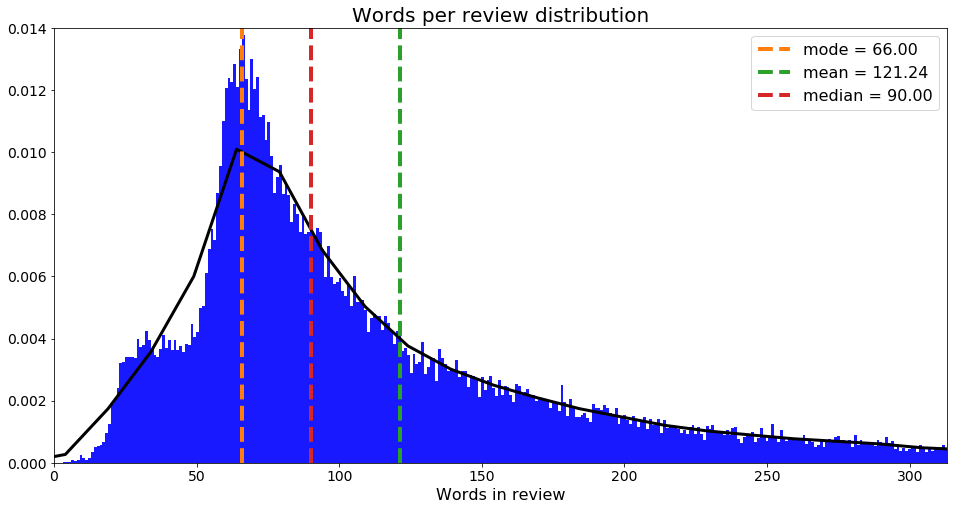

In [66]:
fig, ax = plt.subplots()
sb.distplot(train_data['review_lenght'], bins=train_data['review_lenght'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_data['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()


In [67]:
%%time
bigrams = Phrases(sentences=all_reviews)

CPU times: user 1min 59s, sys: 2.61 s, total: 2min 1s
Wall time: 2min 1s


In [68]:
%%time
trigrams = Phrases(sentences=bigrams[all_reviews])

CPU times: user 6min 5s, sys: 7.35 s, total: 6min 13s
Wall time: 6min 13s


In [69]:
print(bigrams['space station near the solar system'.split()])

['space_station', 'near', 'the', 'solar_system']


In [70]:
%%time
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)


CPU times: user 49min 35s, sys: 1min 5s, total: 50min 40s
Wall time: 40min 43s


In [71]:
print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 130913


In [72]:
trigrams_model.wv.most_similar('galaxy')

[('planet', 0.7178300619125366),
 ('wormhole', 0.6934577822685242),
 ('solar_system', 0.6842825412750244),
 ('continent', 0.6793737411499023),
 ('starship', 0.6721703410148621),
 ('spacecraft', 0.6695280075073242),
 ('portal', 0.6671844124794006),
 ('anti_matter', 0.6519128084182739),
 ('space_station', 0.6499353647232056),
 ('colony', 0.6447393894195557)]

In [73]:
trigrams_model.wv.doesnt_match(['galaxy', 'starship', 'planet', 'dog'])

'dog'

In [74]:
%%time
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
CPU times: user 13min 24s, sys: 2.71 s, total: 13min 27s
Wall time: 13min 27s


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    Y_train_data,
    test_size=0.05,
    shuffle=True,
    random_state=42)


In [76]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 256)          33513728  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

In [77]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=20)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 71250 samples, validate on 3750 samples
Epoch 1/20
71250/71250 [==============================] - 155s 2ms/step - loss: 0.5199 - acc: 0.7426 - val_loss: 0.4797 - val_acc: 0.7747
Epoch 2/20
71250/71250 [==============================] - 152s 2ms/step - loss: 0.3717 - acc: 0.8382 - val_loss: 0.3336 - val_acc: 0.8597
Epoch 3/20
71250/71250 [==============================] - 151s 2ms/step - loss: 0.2901 - acc: 0.8804 - val_loss: 0.3146 - val_acc: 0.8659
Epoch 4/20
71250/71250 [==============================] - 152s 2ms/step - loss: 0.2226 - acc: 0.9104 - val_loss: 0.2770 - val_acc: 0.8931
Epoch 5/20
71250/71250 [==============================] - 152s 2ms/step - loss: 0.1641 - acc: 0.9368 - val_loss: 0.2782 - val_acc: 0.9032
Epoch 6/20
71250/71250 [==============================] - 154s 2ms/step - loss: 0.1213 - acc: 0.9543 - val_loss: 0.2667 - val_acc: 0.9189
Epoch 7/20
71250/71250 [=

In [78]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [79]:
%%time
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)



CPU times: user 9min 55s, sys: 1min 1s, total: 10min 57s
Wall time: 1min 4s


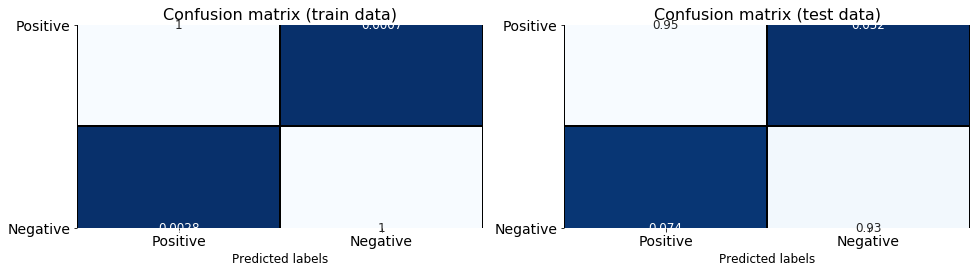

In [80]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])



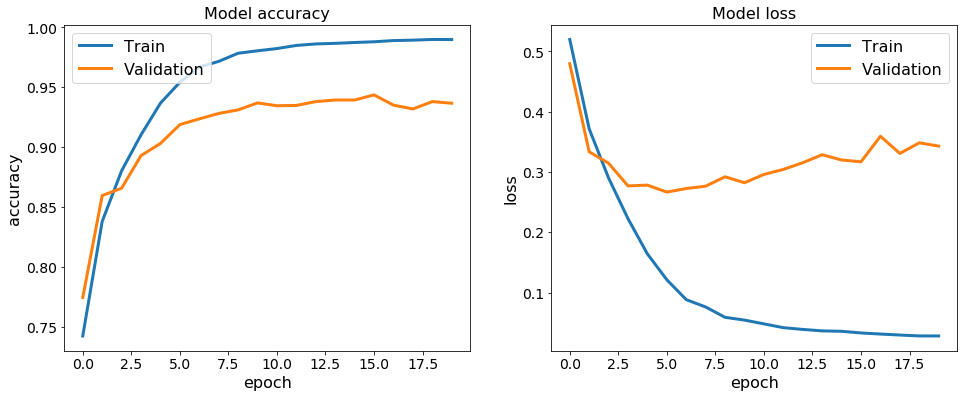

In [81]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['acc'], label='Train', linewidth=3)
axis1.plot(history.history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()



In [82]:
print('Convert sentences to sentences with ngrams...', end='\r')
X_submit = trigrams[bigrams[X_submission]]
print('Convert sentences to sentences with ngrams... (done)')
X_sub = pad_sequences(
    sequences=vectorize_data(X_submit, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')


Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)


In [83]:
%%time
Y_sub_pred = model.predict_classes(X_sub)

CPU times: user 3min 16s, sys: 24.7 s, total: 3min 40s
Wall time: 21.5 s


In [84]:
def submit(predictions):
    submission_data['sentiment'] = predictions
    submission_data.to_csv('submission.csv', index=False, columns=['id','sentiment'])

submit(Y_sub_pred)


In [ ]:
soup = BeautifulSoup("sdsfs","html.parser")
